## Mask RCNN

Loading pretrained model

In [3]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw

In [4]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = '../../aktwelve_Mask_RCNN'
assert os.path.exists(ROOT_DIR)

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

ImportError: cannot import name 'export_saved_model' from 'tensorflow.python.keras.saving.saved_model' (C:\Users\nipun\anaconda3\lib\site-packages\tensorflow\python\keras\saving\saved_model\__init__.py)

In [ ]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
#if not os.path.exists(COCO_MODEL_PATH):
    #utils.download_trained_weights(COCO_MODEL_PATH)

## Configuration
Define configuration for new dataset


In [34]:
class ClassroomConfig(Config):
    """Configuration for training on the classroom_data dataset.
    Derives from the base Config class and overrides values specific
    to the classroom_data dataset.
    """
    # Give the configuration a recognizable name
    NAME = "classroom"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    LEARNING_RATE = 0.01

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + (person + chair)

    # Change this later based on the dimension of images formed from extracting from video
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 704

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 300

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 3
    
    
    # backbone- resnet50 or resnet101
    BACKBONE = 'resnet50'

    RPN_ANCHOR_SCALES = (16, 32, 64, 128,256)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = ClassroomConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  704
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [704 704   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.01
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

# Define the dataset


In [35]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

# Create the Training and Validation Datasets


In [36]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('../classroom_data/datasets/video2/train/trainval.json', '../classroom_data/datasets/video2/train/images/')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('../classroom_data/datasets/video2/test/testval.json', '../classroom_data/datasets/video2/test/images/')
dataset_val.prepare()

## Display a few images from the training dataset

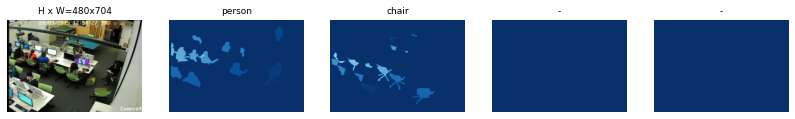

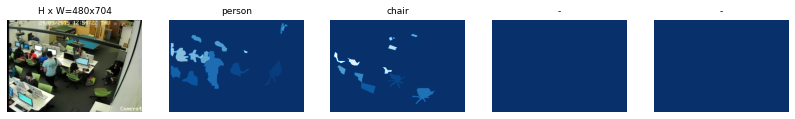

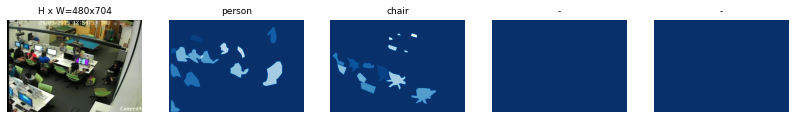

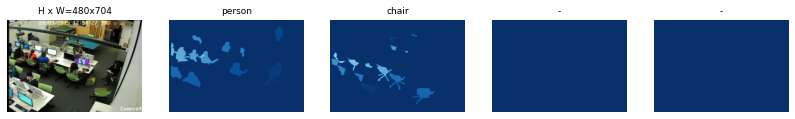

In [37]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

# Create the Training Model and Train


In [38]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [39]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

# Training
Train in two stages:

1.Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

2.Fine-tune all layers.

In [15]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=4, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.01

Checkpoint Path: ../../aktwelve_Mask_RCNN\logs\classroom20210330T1418\mask_rcnn_classroom_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_de

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow\python\framework\indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier_2/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier_2/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier_2/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may con

  1/300 [..............................] - ETA: 42:10 - batch: 0.0000e+00 - size: 1.0000 - loss: 3.7255 - rpn_class_loss: 0.3022 - rpn_bbox_loss: 0.6155 - mrcnn_class_loss: 0.9234 - mrcnn_bbox_loss: 1.0405 - mrcnn_mask_loss: 0.8438

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/300 [..............................] - ETA: 22:37 - batch: 0.5000 - size: 1.0000 - loss: 3.9412 - rpn_class_loss: 0.3220 - rpn_bbox_loss: 0.6404 - mrcnn_class_loss: 1.2914 - mrcnn_bbox_loss: 0.9561 - mrcnn_mask_loss: 0.7313    

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/300 [..............................] - ETA: 21:46 - batch: 1.0000 - size: 1.0000 - loss: 3.5956 - rpn_class_loss: 0.3039 - rpn_bbox_loss: 0.6109 - mrcnn_class_loss: 1.1049 - mrcnn_bbox_loss: 0.8952 - mrcnn_mask_loss: 0.6806

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/300 [..............................] - ETA: 21:22 - batch: 1.5000 - size: 1.0000 - loss: 3.4893 - rpn_class_loss: 0.2842 - rpn_bbox_loss: 0.6064 - mrcnn_class_loss: 1.0935 - mrcnn_bbox_loss: 0.8635 - mrcnn_mask_loss: 0.6415

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/300 [..............................] - ETA: 21:17 - batch: 2.0000 - size: 1.0000 - loss: 3.3644 - rpn_class_loss: 0.2506 - rpn_bbox_loss: 0.5942 - mrcnn_class_loss: 1.0498 - mrcnn_bbox_loss: 0.8628 - mrcnn_mask_loss: 0.6069

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/300 [..............................] - ETA: 21:13 - batch: 2.5000 - size: 1.0000 - loss: 3.3999 - rpn_class_loss: 0.2272 - rpn_bbox_loss: 0.5727 - mrcnn_class_loss: 1.0315 - mrcnn_bbox_loss: 0.8875 - mrcnn_mask_loss: 0.6810

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/300 [..............................] - ETA: 21:11 - batch: 3.0000 - size: 1.0000 - loss: 3.4986 - rpn_class_loss: 0.2083 - rpn_bbox_loss: 0.5728 - mrcnn_class_loss: 1.0728 - mrcnn_bbox_loss: 0.9432 - mrcnn_mask_loss: 0.7016

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/300 [..............................] - ETA: 21:02 - batch: 3.5000 - size: 1.0000 - loss: 3.4302 - rpn_class_loss: 0.1924 - rpn_bbox_loss: 0.5654 - mrcnn_class_loss: 1.0623 - mrcnn_bbox_loss: 0.9377 - mrcnn_mask_loss: 0.6724

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/300 [..............................] - ETA: 21:01 - batch: 4.0000 - size: 1.0000 - loss: 3.3459 - rpn_class_loss: 0.1823 - rpn_bbox_loss: 0.5528 - mrcnn_class_loss: 1.0332 - mrcnn_bbox_loss: 0.9213 - mrcnn_mask_loss: 0.6564

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/300 [>.............................] - ETA: 20:54 - batch: 4.5000 - size: 1.0000 - loss: 3.3660 - rpn_class_loss: 0.1804 - rpn_bbox_loss: 0.5852 - mrcnn_class_loss: 1.0204 - mrcnn_bbox_loss: 0.9304 - mrcnn_mask_loss: 0.6495

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/300 [>.............................] - ETA: 20:50 - batch: 5.0000 - size: 1.0000 - loss: 3.3758 - rpn_class_loss: 0.1755 - rpn_bbox_loss: 0.5751 - mrcnn_class_loss: 1.0300 - mrcnn_bbox_loss: 0.9610 - mrcnn_mask_loss: 0.6342

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/300 [>.............................] - ETA: 20:45 - batch: 5.5000 - size: 1.0000 - loss: 3.3806 - rpn_class_loss: 0.1720 - rpn_bbox_loss: 0.5716 - mrcnn_class_loss: 1.0603 - mrcnn_bbox_loss: 0.9518 - mrcnn_mask_loss: 0.6249

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/300 [>.............................] - ETA: 20:40 - batch: 6.0000 - size: 1.0000 - loss: 3.3153 - rpn_class_loss: 0.1677 - rpn_bbox_loss: 0.5591 - mrcnn_class_loss: 1.0356 - mrcnn_bbox_loss: 0.9412 - mrcnn_mask_loss: 0.6116

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/300 [>.............................] - ETA: 20:35 - batch: 6.5000 - size: 1.0000 - loss: 3.2624 - rpn_class_loss: 0.1628 - rpn_bbox_loss: 0.5531 - mrcnn_class_loss: 1.0075 - mrcnn_bbox_loss: 0.9184 - mrcnn_mask_loss: 0.6206

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/300 [>.............................] - ETA: 20:31 - batch: 7.0000 - size: 1.0000 - loss: 3.2142 - rpn_class_loss: 0.1687 - rpn_bbox_loss: 0.5496 - mrcnn_class_loss: 0.9649 - mrcnn_bbox_loss: 0.9254 - mrcnn_mask_loss: 0.6056

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/300 [>.............................] - ETA: 20:26 - batch: 7.5000 - size: 1.0000 - loss: 3.2357 - rpn_class_loss: 0.1624 - rpn_bbox_loss: 0.5498 - mrcnn_class_loss: 0.9961 - mrcnn_bbox_loss: 0.9298 - mrcnn_mask_loss: 0.5975

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/300 [>.............................] - ETA: 20:23 - batch: 8.0000 - size: 1.0000 - loss: 3.2697 - rpn_class_loss: 0.1583 - rpn_bbox_loss: 0.5466 - mrcnn_class_loss: 0.9922 - mrcnn_bbox_loss: 0.9490 - mrcnn_mask_loss: 0.6237

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/300 [>.............................] - ETA: 20:16 - batch: 8.5000 - size: 1.0000 - loss: 3.2375 - rpn_class_loss: 0.1536 - rpn_bbox_loss: 0.5420 - mrcnn_class_loss: 0.9962 - mrcnn_bbox_loss: 0.9284 - mrcnn_mask_loss: 0.6173

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/300 [>.............................] - ETA: 20:11 - batch: 9.0000 - size: 1.0000 - loss: 3.2080 - rpn_class_loss: 0.1504 - rpn_bbox_loss: 0.5348 - mrcnn_class_loss: 0.9956 - mrcnn_bbox_loss: 0.9107 - mrcnn_mask_loss: 0.6164

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/300 [=>............................] - ETA: 20:09 - batch: 9.5000 - size: 1.0000 - loss: 3.2064 - rpn_class_loss: 0.1669 - rpn_bbox_loss: 0.5388 - mrcnn_class_loss: 0.9852 - mrcnn_bbox_loss: 0.8986 - mrcnn_mask_loss: 0.6169

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/300 [=>............................] - ETA: 20:05 - batch: 10.0000 - size: 1.0000 - loss: 3.1996 - rpn_class_loss: 0.1723 - rpn_bbox_loss: 0.5399 - mrcnn_class_loss: 0.9842 - mrcnn_bbox_loss: 0.8862 - mrcnn_mask_loss: 0.6170

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/300 [=>............................] - ETA: 20:00 - batch: 10.5000 - size: 1.0000 - loss: 3.1856 - rpn_class_loss: 0.1738 - rpn_bbox_loss: 0.5365 - mrcnn_class_loss: 0.9642 - mrcnn_bbox_loss: 0.8948 - mrcnn_mask_loss: 0.6163

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/300 [=>............................] - ETA: 19:54 - batch: 11.0000 - size: 1.0000 - loss: 3.1581 - rpn_class_loss: 0.1801 - rpn_bbox_loss: 0.5369 - mrcnn_class_loss: 0.9502 - mrcnn_bbox_loss: 0.8746 - mrcnn_mask_loss: 0.6164

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/300 [=>............................] - ETA: 19:50 - batch: 11.5000 - size: 1.0000 - loss: 3.1458 - rpn_class_loss: 0.1790 - rpn_bbox_loss: 0.5365 - mrcnn_class_loss: 0.9387 - mrcnn_bbox_loss: 0.8749 - mrcnn_mask_loss: 0.6168

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/300 [=>............................] - ETA: 19:45 - batch: 12.0000 - size: 1.0000 - loss: 3.1012 - rpn_class_loss: 0.1763 - rpn_bbox_loss: 0.5323 - mrcnn_class_loss: 0.9197 - mrcnn_bbox_loss: 0.8604 - mrcnn_mask_loss: 0.6125

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/300 [=>............................] - ETA: 19:40 - batch: 12.5000 - size: 1.0000 - loss: 3.0773 - rpn_class_loss: 0.1739 - rpn_bbox_loss: 0.5303 - mrcnn_class_loss: 0.9216 - mrcnn_bbox_loss: 0.8419 - mrcnn_mask_loss: 0.6097

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/300 [=>............................] - ETA: 19:35 - batch: 13.0000 - size: 1.0000 - loss: 3.0600 - rpn_class_loss: 0.1716 - rpn_bbox_loss: 0.5294 - mrcnn_class_loss: 0.9106 - mrcnn_bbox_loss: 0.8348 - mrcnn_mask_loss: 0.6137

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/300 [=>............................] - ETA: 19:32 - batch: 13.5000 - size: 1.0000 - loss: 3.0475 - rpn_class_loss: 0.1716 - rpn_bbox_loss: 0.5312 - mrcnn_class_loss: 0.8963 - mrcnn_bbox_loss: 0.8310 - mrcnn_mask_loss: 0.6175

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/300 [=>............................] - ETA: 19:28 - batch: 14.0000 - size: 1.0000 - loss: 3.0358 - rpn_class_loss: 0.1718 - rpn_bbox_loss: 0.5285 - mrcnn_class_loss: 0.8977 - mrcnn_bbox_loss: 0.8238 - mrcnn_mask_loss: 0.6141

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/300 [==>...........................] - ETA: 19:23 - batch: 14.5000 - size: 1.0000 - loss: 3.0092 - rpn_class_loss: 0.1693 - rpn_bbox_loss: 0.5232 - mrcnn_class_loss: 0.8862 - mrcnn_bbox_loss: 0.8213 - mrcnn_mask_loss: 0.6092

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/300 [==>...........................] - ETA: 19:18 - batch: 15.0000 - size: 1.0000 - loss: 2.9893 - rpn_class_loss: 0.1699 - rpn_bbox_loss: 0.5226 - mrcnn_class_loss: 0.8755 - mrcnn_bbox_loss: 0.8182 - mrcnn_mask_loss: 0.6031

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/300 [==>...........................] - ETA: 19:15 - batch: 15.5000 - size: 1.0000 - loss: 2.9784 - rpn_class_loss: 0.1683 - rpn_bbox_loss: 0.5219 - mrcnn_class_loss: 0.8759 - mrcnn_bbox_loss: 0.8141 - mrcnn_mask_loss: 0.5981

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/300 [==>...........................] - ETA: 19:10 - batch: 16.0000 - size: 1.0000 - loss: 2.9598 - rpn_class_loss: 0.1651 - rpn_bbox_loss: 0.5189 - mrcnn_class_loss: 0.8689 - mrcnn_bbox_loss: 0.8070 - mrcnn_mask_loss: 0.5999

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/300 [==>...........................] - ETA: 19:05 - batch: 16.5000 - size: 1.0000 - loss: 2.9638 - rpn_class_loss: 0.1656 - rpn_bbox_loss: 0.5378 - mrcnn_class_loss: 0.8589 - mrcnn_bbox_loss: 0.8036 - mrcnn_mask_loss: 0.5979

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/300 [==>...........................] - ETA: 19:02 - batch: 17.0000 - size: 1.0000 - loss: 2.9548 - rpn_class_loss: 0.1640 - rpn_bbox_loss: 0.5390 - mrcnn_class_loss: 0.8607 - mrcnn_bbox_loss: 0.7975 - mrcnn_mask_loss: 0.5936

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/300 [==>...........................] - ETA: 18:59 - batch: 17.5000 - size: 1.0000 - loss: 2.9433 - rpn_class_loss: 0.1621 - rpn_bbox_loss: 0.5391 - mrcnn_class_loss: 0.8513 - mrcnn_bbox_loss: 0.7961 - mrcnn_mask_loss: 0.5947

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/300 [==>...........................] - ETA: 18:55 - batch: 18.0000 - size: 1.0000 - loss: 2.9145 - rpn_class_loss: 0.1601 - rpn_bbox_loss: 0.5358 - mrcnn_class_loss: 0.8425 - mrcnn_bbox_loss: 0.7859 - mrcnn_mask_loss: 0.5902

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/300 [==>...........................] - ETA: 18:49 - batch: 18.5000 - size: 1.0000 - loss: 2.9062 - rpn_class_loss: 0.1616 - rpn_bbox_loss: 0.5353 - mrcnn_class_loss: 0.8361 - mrcnn_bbox_loss: 0.7835 - mrcnn_mask_loss: 0.5897

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/300 [==>...........................] - ETA: 18:41 - batch: 19.0000 - size: 1.0000 - loss: 2.8959 - rpn_class_loss: 0.1623 - rpn_bbox_loss: 0.5340 - mrcnn_class_loss: 0.8318 - mrcnn_bbox_loss: 0.7815 - mrcnn_mask_loss: 0.5864

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/300 [===>..........................] - ETA: 18:32 - batch: 19.5000 - size: 1.0000 - loss: 2.8761 - rpn_class_loss: 0.1602 - rpn_bbox_loss: 0.5320 - mrcnn_class_loss: 0.8234 - mrcnn_bbox_loss: 0.7783 - mrcnn_mask_loss: 0.5822

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/300 [===>..........................] - ETA: 18:27 - batch: 20.0000 - size: 1.0000 - loss: 2.8554 - rpn_class_loss: 0.1578 - rpn_bbox_loss: 0.5333 - mrcnn_class_loss: 0.8137 - mrcnn_bbox_loss: 0.7730 - mrcnn_mask_loss: 0.5776

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/300 [===>..........................] - ETA: 18:21 - batch: 20.5000 - size: 1.0000 - loss: 2.8371 - rpn_class_loss: 0.1555 - rpn_bbox_loss: 0.5314 - mrcnn_class_loss: 0.8066 - mrcnn_bbox_loss: 0.7684 - mrcnn_mask_loss: 0.5752

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/300 [===>..........................] - ETA: 18:13 - batch: 21.0000 - size: 1.0000 - loss: 2.8205 - rpn_class_loss: 0.1535 - rpn_bbox_loss: 0.5301 - mrcnn_class_loss: 0.7925 - mrcnn_bbox_loss: 0.7718 - mrcnn_mask_loss: 0.5726

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/300 [===>..........................] - ETA: 18:07 - batch: 21.5000 - size: 1.0000 - loss: 2.8149 - rpn_class_loss: 0.1543 - rpn_bbox_loss: 0.5331 - mrcnn_class_loss: 0.7880 - mrcnn_bbox_loss: 0.7716 - mrcnn_mask_loss: 0.5679

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/300 [===>..........................] - ETA: 18:01 - batch: 22.0000 - size: 1.0000 - loss: 2.8135 - rpn_class_loss: 0.1522 - rpn_bbox_loss: 0.5429 - mrcnn_class_loss: 0.7824 - mrcnn_bbox_loss: 0.7698 - mrcnn_mask_loss: 0.5661

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/300 [===>..........................] - ETA: 17:55 - batch: 22.5000 - size: 1.0000 - loss: 2.7986 - rpn_class_loss: 0.1504 - rpn_bbox_loss: 0.5425 - mrcnn_class_loss: 0.7764 - mrcnn_bbox_loss: 0.7670 - mrcnn_mask_loss: 0.5623

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/300 [===>..........................] - ETA: 17:48 - batch: 23.0000 - size: 1.0000 - loss: 2.7871 - rpn_class_loss: 0.1485 - rpn_bbox_loss: 0.5385 - mrcnn_class_loss: 0.7731 - mrcnn_bbox_loss: 0.7699 - mrcnn_mask_loss: 0.5571

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/300 [===>..........................] - ETA: 17:44 - batch: 23.5000 - size: 1.0000 - loss: 2.7831 - rpn_class_loss: 0.1470 - rpn_bbox_loss: 0.5363 - mrcnn_class_loss: 0.7729 - mrcnn_bbox_loss: 0.7728 - mrcnn_mask_loss: 0.5541

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/300 [===>..........................] - ETA: 17:41 - batch: 24.0000 - size: 1.0000 - loss: 2.7609 - rpn_class_loss: 0.1455 - rpn_bbox_loss: 0.5320 - mrcnn_class_loss: 0.7645 - mrcnn_bbox_loss: 0.7688 - mrcnn_mask_loss: 0.5501

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/300 [====>.........................] - ETA: 17:35 - batch: 24.5000 - size: 1.0000 - loss: 2.7444 - rpn_class_loss: 0.1440 - rpn_bbox_loss: 0.5334 - mrcnn_class_loss: 0.7566 - mrcnn_bbox_loss: 0.7632 - mrcnn_mask_loss: 0.5472

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/300 [====>.........................] - ETA: 17:31 - batch: 25.0000 - size: 1.0000 - loss: 2.7288 - rpn_class_loss: 0.1428 - rpn_bbox_loss: 0.5325 - mrcnn_class_loss: 0.7510 - mrcnn_bbox_loss: 0.7581 - mrcnn_mask_loss: 0.5444

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/300 [====>.........................] - ETA: 17:25 - batch: 25.5000 - size: 1.0000 - loss: 2.7193 - rpn_class_loss: 0.1418 - rpn_bbox_loss: 0.5315 - mrcnn_class_loss: 0.7481 - mrcnn_bbox_loss: 0.7531 - mrcnn_mask_loss: 0.5449

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/300 [====>.........................] - ETA: 17:19 - batch: 26.0000 - size: 1.0000 - loss: 2.7075 - rpn_class_loss: 0.1410 - rpn_bbox_loss: 0.5281 - mrcnn_class_loss: 0.7427 - mrcnn_bbox_loss: 0.7515 - mrcnn_mask_loss: 0.5442

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/300 [====>.........................] - ETA: 17:14 - batch: 26.5000 - size: 1.0000 - loss: 2.6852 - rpn_class_loss: 0.1403 - rpn_bbox_loss: 0.5242 - mrcnn_class_loss: 0.7341 - mrcnn_bbox_loss: 0.7466 - mrcnn_mask_loss: 0.5400

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/300 [====>.........................] - ETA: 17:09 - batch: 27.0000 - size: 1.0000 - loss: 2.6748 - rpn_class_loss: 0.1398 - rpn_bbox_loss: 0.5229 - mrcnn_class_loss: 0.7339 - mrcnn_bbox_loss: 0.7413 - mrcnn_mask_loss: 0.5369

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/300 [====>.........................] - ETA: 17:04 - batch: 27.5000 - size: 1.0000 - loss: 2.6659 - rpn_class_loss: 0.1396 - rpn_bbox_loss: 0.5229 - mrcnn_class_loss: 0.7310 - mrcnn_bbox_loss: 0.7385 - mrcnn_mask_loss: 0.5339

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/300 [====>.........................] - ETA: 16:59 - batch: 28.0000 - size: 1.0000 - loss: 2.6514 - rpn_class_loss: 0.1382 - rpn_bbox_loss: 0.5259 - mrcnn_class_loss: 0.7244 - mrcnn_bbox_loss: 0.7319 - mrcnn_mask_loss: 0.5309

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/300 [====>.........................] - ETA: 16:53 - batch: 28.5000 - size: 1.0000 - loss: 2.6365 - rpn_class_loss: 0.1382 - rpn_bbox_loss: 0.5253 - mrcnn_class_loss: 0.7182 - mrcnn_bbox_loss: 0.7272 - mrcnn_mask_loss: 0.5277

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/300 [====>.........................] - ETA: 16:48 - batch: 29.0000 - size: 1.0000 - loss: 2.6267 - rpn_class_loss: 0.1369 - rpn_bbox_loss: 0.5249 - mrcnn_class_loss: 0.7150 - mrcnn_bbox_loss: 0.7242 - mrcnn_mask_loss: 0.5257

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/300 [=====>........................] - ETA: 16:43 - batch: 29.5000 - size: 1.0000 - loss: 2.6163 - rpn_class_loss: 0.1358 - rpn_bbox_loss: 0.5226 - mrcnn_class_loss: 0.7158 - mrcnn_bbox_loss: 0.7192 - mrcnn_mask_loss: 0.5229

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/300 [=====>........................] - ETA: 16:38 - batch: 30.0000 - size: 1.0000 - loss: 2.6031 - rpn_class_loss: 0.1349 - rpn_bbox_loss: 0.5227 - mrcnn_class_loss: 0.7100 - mrcnn_bbox_loss: 0.7155 - mrcnn_mask_loss: 0.5200

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/300 [=====>........................] - ETA: 16:33 - batch: 30.5000 - size: 1.0000 - loss: 2.5989 - rpn_class_loss: 0.1342 - rpn_bbox_loss: 0.5210 - mrcnn_class_loss: 0.7080 - mrcnn_bbox_loss: 0.7170 - mrcnn_mask_loss: 0.5187

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/300 [=====>........................] - ETA: 16:28 - batch: 31.0000 - size: 1.0000 - loss: 2.5985 - rpn_class_loss: 0.1335 - rpn_bbox_loss: 0.5199 - mrcnn_class_loss: 0.7110 - mrcnn_bbox_loss: 0.7148 - mrcnn_mask_loss: 0.5193

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/300 [=====>........................] - ETA: 16:24 - batch: 31.5000 - size: 1.0000 - loss: 2.5925 - rpn_class_loss: 0.1337 - rpn_bbox_loss: 0.5208 - mrcnn_class_loss: 0.7066 - mrcnn_bbox_loss: 0.7141 - mrcnn_mask_loss: 0.5173

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/300 [=====>........................] - ETA: 16:19 - batch: 32.0000 - size: 1.0000 - loss: 2.5862 - rpn_class_loss: 0.1337 - rpn_bbox_loss: 0.5232 - mrcnn_class_loss: 0.7018 - mrcnn_bbox_loss: 0.7122 - mrcnn_mask_loss: 0.5153

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/300 [=====>........................] - ETA: 16:14 - batch: 32.5000 - size: 1.0000 - loss: 2.5731 - rpn_class_loss: 0.1329 - rpn_bbox_loss: 0.5216 - mrcnn_class_loss: 0.6967 - mrcnn_bbox_loss: 0.7092 - mrcnn_mask_loss: 0.5126

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/300 [=====>........................] - ETA: 16:09 - batch: 33.0000 - size: 1.0000 - loss: 2.5616 - rpn_class_loss: 0.1332 - rpn_bbox_loss: 0.5214 - mrcnn_class_loss: 0.6903 - mrcnn_bbox_loss: 0.7055 - mrcnn_mask_loss: 0.5113

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/300 [=====>........................] - ETA: 16:05 - batch: 33.5000 - size: 1.0000 - loss: 2.5503 - rpn_class_loss: 0.1339 - rpn_bbox_loss: 0.5212 - mrcnn_class_loss: 0.6848 - mrcnn_bbox_loss: 0.7019 - mrcnn_mask_loss: 0.5085

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/300 [=====>........................] - ETA: 15:59 - batch: 34.0000 - size: 1.0000 - loss: 2.5360 - rpn_class_loss: 0.1334 - rpn_bbox_loss: 0.5209 - mrcnn_class_loss: 0.6791 - mrcnn_bbox_loss: 0.6976 - mrcnn_mask_loss: 0.5050

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/300 [======>.......................] - ETA: 15:54 - batch: 34.5000 - size: 1.0000 - loss: 2.5301 - rpn_class_loss: 0.1325 - rpn_bbox_loss: 0.5210 - mrcnn_class_loss: 0.6781 - mrcnn_bbox_loss: 0.6971 - mrcnn_mask_loss: 0.5016

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/300 [======>.......................] - ETA: 15:50 - batch: 35.0000 - size: 1.0000 - loss: 2.5240 - rpn_class_loss: 0.1320 - rpn_bbox_loss: 0.5223 - mrcnn_class_loss: 0.6774 - mrcnn_bbox_loss: 0.6942 - mrcnn_mask_loss: 0.4981

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/300 [======>.......................] - ETA: 15:45 - batch: 35.5000 - size: 1.0000 - loss: 2.5229 - rpn_class_loss: 0.1309 - rpn_bbox_loss: 0.5250 - mrcnn_class_loss: 0.6760 - mrcnn_bbox_loss: 0.6942 - mrcnn_mask_loss: 0.4968

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/300 [======>.......................] - ETA: 15:40 - batch: 36.0000 - size: 1.0000 - loss: 2.5211 - rpn_class_loss: 0.1302 - rpn_bbox_loss: 0.5254 - mrcnn_class_loss: 0.6774 - mrcnn_bbox_loss: 0.6923 - mrcnn_mask_loss: 0.4959

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/300 [======>.......................] - ETA: 15:36 - batch: 36.5000 - size: 1.0000 - loss: 2.5170 - rpn_class_loss: 0.1305 - rpn_bbox_loss: 0.5233 - mrcnn_class_loss: 0.6781 - mrcnn_bbox_loss: 0.6919 - mrcnn_mask_loss: 0.4934

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/300 [======>.......................] - ETA: 15:31 - batch: 37.0000 - size: 1.0000 - loss: 2.5082 - rpn_class_loss: 0.1306 - rpn_bbox_loss: 0.5227 - mrcnn_class_loss: 0.6738 - mrcnn_bbox_loss: 0.6898 - mrcnn_mask_loss: 0.4912

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/300 [======>.......................] - ETA: 15:27 - batch: 37.5000 - size: 1.0000 - loss: 2.4992 - rpn_class_loss: 0.1308 - rpn_bbox_loss: 0.5221 - mrcnn_class_loss: 0.6697 - mrcnn_bbox_loss: 0.6873 - mrcnn_mask_loss: 0.4893

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/300 [======>.......................] - ETA: 15:22 - batch: 38.0000 - size: 1.0000 - loss: 2.4944 - rpn_class_loss: 0.1306 - rpn_bbox_loss: 0.5222 - mrcnn_class_loss: 0.6673 - mrcnn_bbox_loss: 0.6868 - mrcnn_mask_loss: 0.4876

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/300 [======>.......................] - ETA: 15:17 - batch: 38.5000 - size: 1.0000 - loss: 2.4828 - rpn_class_loss: 0.1302 - rpn_bbox_loss: 0.5209 - mrcnn_class_loss: 0.6621 - mrcnn_bbox_loss: 0.6842 - mrcnn_mask_loss: 0.4855

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/300 [======>.......................] - ETA: 15:14 - batch: 39.0000 - size: 1.0000 - loss: 2.4798 - rpn_class_loss: 0.1303 - rpn_bbox_loss: 0.5216 - mrcnn_class_loss: 0.6614 - mrcnn_bbox_loss: 0.6823 - mrcnn_mask_loss: 0.4843

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/300 [=======>......................] - ETA: 15:10 - batch: 39.5000 - size: 1.0000 - loss: 2.4773 - rpn_class_loss: 0.1298 - rpn_bbox_loss: 0.5199 - mrcnn_class_loss: 0.6652 - mrcnn_bbox_loss: 0.6796 - mrcnn_mask_loss: 0.4827

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/300 [=======>......................] - ETA: 15:05 - batch: 40.0000 - size: 1.0000 - loss: 2.4720 - rpn_class_loss: 0.1295 - rpn_bbox_loss: 0.5186 - mrcnn_class_loss: 0.6647 - mrcnn_bbox_loss: 0.6780 - mrcnn_mask_loss: 0.4811

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/300 [=======>......................] - ETA: 15:01 - batch: 40.5000 - size: 1.0000 - loss: 2.4660 - rpn_class_loss: 0.1294 - rpn_bbox_loss: 0.5171 - mrcnn_class_loss: 0.6615 - mrcnn_bbox_loss: 0.6767 - mrcnn_mask_loss: 0.4813

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/300 [=======>......................] - ETA: 14:56 - batch: 41.0000 - size: 1.0000 - loss: 2.4575 - rpn_class_loss: 0.1286 - rpn_bbox_loss: 0.5163 - mrcnn_class_loss: 0.6566 - mrcnn_bbox_loss: 0.6762 - mrcnn_mask_loss: 0.4799

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/300 [=======>......................] - ETA: 14:52 - batch: 41.5000 - size: 1.0000 - loss: 2.4576 - rpn_class_loss: 0.1284 - rpn_bbox_loss: 0.5211 - mrcnn_class_loss: 0.6527 - mrcnn_bbox_loss: 0.6773 - mrcnn_mask_loss: 0.4782

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/300 [=======>......................] - ETA: 14:48 - batch: 42.0000 - size: 1.0000 - loss: 2.4527 - rpn_class_loss: 0.1283 - rpn_bbox_loss: 0.5209 - mrcnn_class_loss: 0.6508 - mrcnn_bbox_loss: 0.6759 - mrcnn_mask_loss: 0.4768

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/300 [=======>......................] - ETA: 14:43 - batch: 42.5000 - size: 1.0000 - loss: 2.4446 - rpn_class_loss: 0.1283 - rpn_bbox_loss: 0.5195 - mrcnn_class_loss: 0.6474 - mrcnn_bbox_loss: 0.6744 - mrcnn_mask_loss: 0.4750

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/300 [=======>......................] - ETA: 14:38 - batch: 43.0000 - size: 1.0000 - loss: 2.4385 - rpn_class_loss: 0.1280 - rpn_bbox_loss: 0.5176 - mrcnn_class_loss: 0.6445 - mrcnn_bbox_loss: 0.6756 - mrcnn_mask_loss: 0.4727

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/300 [=======>......................] - ETA: 14:34 - batch: 43.5000 - size: 1.0000 - loss: 2.4315 - rpn_class_loss: 0.1277 - rpn_bbox_loss: 0.5173 - mrcnn_class_loss: 0.6403 - mrcnn_bbox_loss: 0.6745 - mrcnn_mask_loss: 0.4717

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/300 [=======>......................] - ETA: 14:29 - batch: 44.0000 - size: 1.0000 - loss: 2.4262 - rpn_class_loss: 0.1277 - rpn_bbox_loss: 0.5182 - mrcnn_class_loss: 0.6370 - mrcnn_bbox_loss: 0.6733 - mrcnn_mask_loss: 0.4700

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/300 [========>.....................] - ETA: 14:25 - batch: 44.5000 - size: 1.0000 - loss: 2.4190 - rpn_class_loss: 0.1274 - rpn_bbox_loss: 0.5176 - mrcnn_class_loss: 0.6331 - mrcnn_bbox_loss: 0.6726 - mrcnn_mask_loss: 0.4683

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/300 [========>.....................] - ETA: 14:21 - batch: 45.0000 - size: 1.0000 - loss: 2.4273 - rpn_class_loss: 0.1272 - rpn_bbox_loss: 0.5181 - mrcnn_class_loss: 0.6363 - mrcnn_bbox_loss: 0.6735 - mrcnn_mask_loss: 0.4722

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/300 [========>.....................] - ETA: 14:16 - batch: 45.5000 - size: 1.0000 - loss: 2.4203 - rpn_class_loss: 0.1271 - rpn_bbox_loss: 0.5167 - mrcnn_class_loss: 0.6333 - mrcnn_bbox_loss: 0.6727 - mrcnn_mask_loss: 0.4704

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/300 [========>.....................] - ETA: 14:12 - batch: 46.0000 - size: 1.0000 - loss: 2.4139 - rpn_class_loss: 0.1268 - rpn_bbox_loss: 0.5162 - mrcnn_class_loss: 0.6300 - mrcnn_bbox_loss: 0.6717 - mrcnn_mask_loss: 0.4692

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/300 [========>.....................] - ETA: 14:08 - batch: 46.5000 - size: 1.0000 - loss: 2.4118 - rpn_class_loss: 0.1275 - rpn_bbox_loss: 0.5170 - mrcnn_class_loss: 0.6276 - mrcnn_bbox_loss: 0.6715 - mrcnn_mask_loss: 0.4683

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/300 [========>.....................] - ETA: 14:03 - batch: 47.0000 - size: 1.0000 - loss: 2.4149 - rpn_class_loss: 0.1269 - rpn_bbox_loss: 0.5241 - mrcnn_class_loss: 0.6245 - mrcnn_bbox_loss: 0.6715 - mrcnn_mask_loss: 0.4678

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/300 [========>.....................] - ETA: 13:59 - batch: 47.5000 - size: 1.0000 - loss: 2.4183 - rpn_class_loss: 0.1266 - rpn_bbox_loss: 0.5286 - mrcnn_class_loss: 0.6250 - mrcnn_bbox_loss: 0.6712 - mrcnn_mask_loss: 0.4669

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/300 [========>.....................] - ETA: 13:55 - batch: 48.0000 - size: 1.0000 - loss: 2.4220 - rpn_class_loss: 0.1262 - rpn_bbox_loss: 0.5285 - mrcnn_class_loss: 0.6297 - mrcnn_bbox_loss: 0.6710 - mrcnn_mask_loss: 0.4665

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/300 [========>.....................] - ETA: 13:51 - batch: 48.5000 - size: 1.0000 - loss: 2.4160 - rpn_class_loss: 0.1260 - rpn_bbox_loss: 0.5275 - mrcnn_class_loss: 0.6264 - mrcnn_bbox_loss: 0.6694 - mrcnn_mask_loss: 0.4668

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/300 [========>.....................] - ETA: 13:47 - batch: 49.0000 - size: 1.0000 - loss: 2.4117 - rpn_class_loss: 0.1257 - rpn_bbox_loss: 0.5258 - mrcnn_class_loss: 0.6264 - mrcnn_bbox_loss: 0.6684 - mrcnn_mask_loss: 0.4654

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/300 [=========>....................] - ETA: 13:42 - batch: 49.5000 - size: 1.0000 - loss: 2.4076 - rpn_class_loss: 0.1255 - rpn_bbox_loss: 0.5252 - mrcnn_class_loss: 0.6248 - mrcnn_bbox_loss: 0.6674 - mrcnn_mask_loss: 0.4647

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/300 [=========>....................] - ETA: 13:37 - batch: 50.0000 - size: 1.0000 - loss: 2.4051 - rpn_class_loss: 0.1250 - rpn_bbox_loss: 0.5257 - mrcnn_class_loss: 0.6232 - mrcnn_bbox_loss: 0.6672 - mrcnn_mask_loss: 0.4641

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/300 [=========>....................] - ETA: 13:33 - batch: 50.5000 - size: 1.0000 - loss: 2.3989 - rpn_class_loss: 0.1243 - rpn_bbox_loss: 0.5259 - mrcnn_class_loss: 0.6214 - mrcnn_bbox_loss: 0.6641 - mrcnn_mask_loss: 0.4633

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/300 [=========>....................] - ETA: 13:29 - batch: 51.0000 - size: 1.0000 - loss: 2.3942 - rpn_class_loss: 0.1239 - rpn_bbox_loss: 0.5253 - mrcnn_class_loss: 0.6199 - mrcnn_bbox_loss: 0.6627 - mrcnn_mask_loss: 0.4624

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/300 [=========>....................] - ETA: 13:25 - batch: 51.5000 - size: 1.0000 - loss: 2.3871 - rpn_class_loss: 0.1236 - rpn_bbox_loss: 0.5248 - mrcnn_class_loss: 0.6166 - mrcnn_bbox_loss: 0.6610 - mrcnn_mask_loss: 0.4611

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/300 [=========>....................] - ETA: 13:21 - batch: 52.0000 - size: 1.0000 - loss: 2.3803 - rpn_class_loss: 0.1231 - rpn_bbox_loss: 0.5243 - mrcnn_class_loss: 0.6145 - mrcnn_bbox_loss: 0.6587 - mrcnn_mask_loss: 0.4596

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/300 [=========>....................] - ETA: 13:18 - batch: 52.5000 - size: 1.0000 - loss: 2.3755 - rpn_class_loss: 0.1224 - rpn_bbox_loss: 0.5238 - mrcnn_class_loss: 0.6135 - mrcnn_bbox_loss: 0.6580 - mrcnn_mask_loss: 0.4579

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/300 [=========>....................] - ETA: 13:14 - batch: 53.0000 - size: 1.0000 - loss: 2.3911 - rpn_class_loss: 0.1220 - rpn_bbox_loss: 0.5392 - mrcnn_class_loss: 0.6149 - mrcnn_bbox_loss: 0.6579 - mrcnn_mask_loss: 0.4571

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/300 [=========>....................] - ETA: 13:10 - batch: 53.5000 - size: 1.0000 - loss: 2.3879 - rpn_class_loss: 0.1214 - rpn_bbox_loss: 0.5394 - mrcnn_class_loss: 0.6146 - mrcnn_bbox_loss: 0.6570 - mrcnn_mask_loss: 0.4556

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/300 [=========>....................] - ETA: 13:07 - batch: 54.0000 - size: 1.0000 - loss: 2.3920 - rpn_class_loss: 0.1218 - rpn_bbox_loss: 0.5473 - mrcnn_class_loss: 0.6126 - mrcnn_bbox_loss: 0.6560 - mrcnn_mask_loss: 0.4542

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/300 [==========>...................] - ETA: 13:04 - batch: 54.5000 - size: 1.0000 - loss: 2.3898 - rpn_class_loss: 0.1214 - rpn_bbox_loss: 0.5486 - mrcnn_class_loss: 0.6110 - mrcnn_bbox_loss: 0.6559 - mrcnn_mask_loss: 0.4529

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/300 [==========>...................] - ETA: 13:01 - batch: 55.0000 - size: 1.0000 - loss: 2.3823 - rpn_class_loss: 0.1208 - rpn_bbox_loss: 0.5474 - mrcnn_class_loss: 0.6095 - mrcnn_bbox_loss: 0.6539 - mrcnn_mask_loss: 0.4509

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/300 [==========>...................] - ETA: 12:58 - batch: 55.5000 - size: 1.0000 - loss: 2.3831 - rpn_class_loss: 0.1209 - rpn_bbox_loss: 0.5459 - mrcnn_class_loss: 0.6119 - mrcnn_bbox_loss: 0.6547 - mrcnn_mask_loss: 0.4495

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/300 [==========>...................] - ETA: 12:56 - batch: 56.0000 - size: 1.0000 - loss: 2.3809 - rpn_class_loss: 0.1209 - rpn_bbox_loss: 0.5449 - mrcnn_class_loss: 0.6119 - mrcnn_bbox_loss: 0.6545 - mrcnn_mask_loss: 0.4486

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/300 [==========>...................] - ETA: 12:54 - batch: 56.5000 - size: 1.0000 - loss: 2.3756 - rpn_class_loss: 0.1207 - rpn_bbox_loss: 0.5446 - mrcnn_class_loss: 0.6112 - mrcnn_bbox_loss: 0.6522 - mrcnn_mask_loss: 0.4469

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/300 [==========>...................] - ETA: 12:51 - batch: 57.0000 - size: 1.0000 - loss: 2.3719 - rpn_class_loss: 0.1206 - rpn_bbox_loss: 0.5438 - mrcnn_class_loss: 0.6101 - mrcnn_bbox_loss: 0.6506 - mrcnn_mask_loss: 0.4467

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/300 [==========>...................] - ETA: 12:49 - batch: 57.5000 - size: 1.0000 - loss: 2.3678 - rpn_class_loss: 0.1207 - rpn_bbox_loss: 0.5431 - mrcnn_class_loss: 0.6093 - mrcnn_bbox_loss: 0.6494 - mrcnn_mask_loss: 0.4453

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/300 [==========>...................] - ETA: 12:45 - batch: 58.0000 - size: 1.0000 - loss: 2.3669 - rpn_class_loss: 0.1202 - rpn_bbox_loss: 0.5420 - mrcnn_class_loss: 0.6093 - mrcnn_bbox_loss: 0.6510 - mrcnn_mask_loss: 0.4444

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/300 [==========>...................] - ETA: 12:42 - batch: 58.5000 - size: 1.0000 - loss: 2.3633 - rpn_class_loss: 0.1194 - rpn_bbox_loss: 0.5413 - mrcnn_class_loss: 0.6077 - mrcnn_bbox_loss: 0.6516 - mrcnn_mask_loss: 0.4431

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/300 [==========>...................] - ETA: 12:38 - batch: 59.0000 - size: 1.0000 - loss: 2.3573 - rpn_class_loss: 0.1190 - rpn_bbox_loss: 0.5399 - mrcnn_class_loss: 0.6059 - mrcnn_bbox_loss: 0.6501 - mrcnn_mask_loss: 0.4423

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/300 [===========>..................] - ETA: 12:34 - batch: 59.5000 - size: 1.0000 - loss: 2.3536 - rpn_class_loss: 0.1189 - rpn_bbox_loss: 0.5391 - mrcnn_class_loss: 0.6051 - mrcnn_bbox_loss: 0.6492 - mrcnn_mask_loss: 0.4413

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/300 [===========>..................] - ETA: 12:32 - batch: 60.0000 - size: 1.0000 - loss: 2.3581 - rpn_class_loss: 0.1185 - rpn_bbox_loss: 0.5380 - mrcnn_class_loss: 0.6105 - mrcnn_bbox_loss: 0.6505 - mrcnn_mask_loss: 0.4406

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/300 [===========>..................] - ETA: 12:29 - batch: 60.5000 - size: 1.0000 - loss: 2.3609 - rpn_class_loss: 0.1184 - rpn_bbox_loss: 0.5393 - mrcnn_class_loss: 0.6114 - mrcnn_bbox_loss: 0.6518 - mrcnn_mask_loss: 0.4401

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/300 [===========>..................] - ETA: 12:24 - batch: 61.0000 - size: 1.0000 - loss: 2.3583 - rpn_class_loss: 0.1179 - rpn_bbox_loss: 0.5398 - mrcnn_class_loss: 0.6110 - mrcnn_bbox_loss: 0.6503 - mrcnn_mask_loss: 0.4394

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/300 [===========>..................] - ETA: 12:19 - batch: 61.5000 - size: 1.0000 - loss: 2.3620 - rpn_class_loss: 0.1176 - rpn_bbox_loss: 0.5404 - mrcnn_class_loss: 0.6149 - mrcnn_bbox_loss: 0.6504 - mrcnn_mask_loss: 0.4387

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/300 [===========>..................] - ETA: 12:15 - batch: 62.0000 - size: 1.0000 - loss: 2.3645 - rpn_class_loss: 0.1175 - rpn_bbox_loss: 0.5422 - mrcnn_class_loss: 0.6162 - mrcnn_bbox_loss: 0.6506 - mrcnn_mask_loss: 0.4379

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/300 [===========>..................] - ETA: 12:11 - batch: 62.5000 - size: 1.0000 - loss: 2.3691 - rpn_class_loss: 0.1175 - rpn_bbox_loss: 0.5419 - mrcnn_class_loss: 0.6195 - mrcnn_bbox_loss: 0.6530 - mrcnn_mask_loss: 0.4373

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/300 [===========>..................] - ETA: 12:08 - batch: 63.0000 - size: 1.0000 - loss: 2.3669 - rpn_class_loss: 0.1173 - rpn_bbox_loss: 0.5411 - mrcnn_class_loss: 0.6190 - mrcnn_bbox_loss: 0.6524 - mrcnn_mask_loss: 0.4371

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/300 [===========>..................] - ETA: 12:04 - batch: 63.5000 - size: 1.0000 - loss: 2.3638 - rpn_class_loss: 0.1183 - rpn_bbox_loss: 0.5409 - mrcnn_class_loss: 0.6171 - mrcnn_bbox_loss: 0.6519 - mrcnn_mask_loss: 0.4357

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/300 [===========>..................] - ETA: 11:59 - batch: 64.0000 - size: 1.0000 - loss: 2.3610 - rpn_class_loss: 0.1186 - rpn_bbox_loss: 0.5402 - mrcnn_class_loss: 0.6158 - mrcnn_bbox_loss: 0.6519 - mrcnn_mask_loss: 0.4345

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/300 [============>.................] - ETA: 11:55 - batch: 64.5000 - size: 1.0000 - loss: 2.3584 - rpn_class_loss: 0.1188 - rpn_bbox_loss: 0.5400 - mrcnn_class_loss: 0.6158 - mrcnn_bbox_loss: 0.6504 - mrcnn_mask_loss: 0.4335

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/300 [============>.................] - ETA: 11:50 - batch: 65.0000 - size: 1.0000 - loss: 2.3544 - rpn_class_loss: 0.1192 - rpn_bbox_loss: 0.5395 - mrcnn_class_loss: 0.6132 - mrcnn_bbox_loss: 0.6502 - mrcnn_mask_loss: 0.4323

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/300 [============>.................] - ETA: 11:46 - batch: 65.5000 - size: 1.0000 - loss: 2.3516 - rpn_class_loss: 0.1195 - rpn_bbox_loss: 0.5385 - mrcnn_class_loss: 0.6108 - mrcnn_bbox_loss: 0.6509 - mrcnn_mask_loss: 0.4320

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/300 [============>.................] - ETA: 11:41 - batch: 66.0000 - size: 1.0000 - loss: 2.3525 - rpn_class_loss: 0.1199 - rpn_bbox_loss: 0.5398 - mrcnn_class_loss: 0.6105 - mrcnn_bbox_loss: 0.6509 - mrcnn_mask_loss: 0.4314

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/300 [============>.................] - ETA: 11:37 - batch: 66.5000 - size: 1.0000 - loss: 2.3488 - rpn_class_loss: 0.1197 - rpn_bbox_loss: 0.5405 - mrcnn_class_loss: 0.6092 - mrcnn_bbox_loss: 0.6494 - mrcnn_mask_loss: 0.4300

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/300 [============>.................] - ETA: 11:32 - batch: 67.0000 - size: 1.0000 - loss: 2.3468 - rpn_class_loss: 0.1196 - rpn_bbox_loss: 0.5399 - mrcnn_class_loss: 0.6100 - mrcnn_bbox_loss: 0.6485 - mrcnn_mask_loss: 0.4288

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/300 [============>.................] - ETA: 11:28 - batch: 67.5000 - size: 1.0000 - loss: 2.3444 - rpn_class_loss: 0.1199 - rpn_bbox_loss: 0.5400 - mrcnn_class_loss: 0.6089 - mrcnn_bbox_loss: 0.6473 - mrcnn_mask_loss: 0.4283

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/300 [============>.................] - ETA: 11:23 - batch: 68.0000 - size: 1.0000 - loss: 2.3412 - rpn_class_loss: 0.1200 - rpn_bbox_loss: 0.5400 - mrcnn_class_loss: 0.6084 - mrcnn_bbox_loss: 0.6455 - mrcnn_mask_loss: 0.4273

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/300 [============>.................] - ETA: 11:19 - batch: 68.5000 - size: 1.0000 - loss: 2.3361 - rpn_class_loss: 0.1198 - rpn_bbox_loss: 0.5390 - mrcnn_class_loss: 0.6067 - mrcnn_bbox_loss: 0.6440 - mrcnn_mask_loss: 0.4266

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/300 [============>.................] - ETA: 11:14 - batch: 69.0000 - size: 1.0000 - loss: 2.3342 - rpn_class_loss: 0.1198 - rpn_bbox_loss: 0.5388 - mrcnn_class_loss: 0.6060 - mrcnn_bbox_loss: 0.6434 - mrcnn_mask_loss: 0.4263

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/300 [=============>................] - ETA: 11:10 - batch: 69.5000 - size: 1.0000 - loss: 2.3350 - rpn_class_loss: 0.1219 - rpn_bbox_loss: 0.5403 - mrcnn_class_loss: 0.6044 - mrcnn_bbox_loss: 0.6428 - mrcnn_mask_loss: 0.4255

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/300 [=============>................] - ETA: 11:06 - batch: 70.0000 - size: 1.0000 - loss: 2.3310 - rpn_class_loss: 0.1227 - rpn_bbox_loss: 0.5399 - mrcnn_class_loss: 0.6023 - mrcnn_bbox_loss: 0.6417 - mrcnn_mask_loss: 0.4243

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/300 [=============>................] - ETA: 11:01 - batch: 70.5000 - size: 1.0000 - loss: 2.3314 - rpn_class_loss: 0.1231 - rpn_bbox_loss: 0.5396 - mrcnn_class_loss: 0.6021 - mrcnn_bbox_loss: 0.6434 - mrcnn_mask_loss: 0.4233

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/300 [=============>................] - ETA: 10:57 - batch: 71.0000 - size: 1.0000 - loss: 2.3297 - rpn_class_loss: 0.1231 - rpn_bbox_loss: 0.5385 - mrcnn_class_loss: 0.6016 - mrcnn_bbox_loss: 0.6438 - mrcnn_mask_loss: 0.4227

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/300 [=============>................] - ETA: 10:52 - batch: 71.5000 - size: 1.0000 - loss: 2.3251 - rpn_class_loss: 0.1230 - rpn_bbox_loss: 0.5370 - mrcnn_class_loss: 0.5998 - mrcnn_bbox_loss: 0.6439 - mrcnn_mask_loss: 0.4214

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/300 [=============>................] - ETA: 10:48 - batch: 72.0000 - size: 1.0000 - loss: 2.3255 - rpn_class_loss: 0.1234 - rpn_bbox_loss: 0.5374 - mrcnn_class_loss: 0.5993 - mrcnn_bbox_loss: 0.6447 - mrcnn_mask_loss: 0.4208

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/300 [=============>................] - ETA: 10:44 - batch: 72.5000 - size: 1.0000 - loss: 2.3233 - rpn_class_loss: 0.1233 - rpn_bbox_loss: 0.5371 - mrcnn_class_loss: 0.5977 - mrcnn_bbox_loss: 0.6454 - mrcnn_mask_loss: 0.4197

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/300 [=============>................] - ETA: 10:39 - batch: 73.0000 - size: 1.0000 - loss: 2.3213 - rpn_class_loss: 0.1233 - rpn_bbox_loss: 0.5374 - mrcnn_class_loss: 0.5966 - mrcnn_bbox_loss: 0.6447 - mrcnn_mask_loss: 0.4193

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/300 [=============>................] - ETA: 10:35 - batch: 73.5000 - size: 1.0000 - loss: 2.3162 - rpn_class_loss: 0.1231 - rpn_bbox_loss: 0.5369 - mrcnn_class_loss: 0.5953 - mrcnn_bbox_loss: 0.6428 - mrcnn_mask_loss: 0.4181

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/300 [=============>................] - ETA: 10:30 - batch: 74.0000 - size: 1.0000 - loss: 2.3159 - rpn_class_loss: 0.1228 - rpn_bbox_loss: 0.5373 - mrcnn_class_loss: 0.5968 - mrcnn_bbox_loss: 0.6417 - mrcnn_mask_loss: 0.4172

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/300 [==============>...............] - ETA: 10:26 - batch: 74.5000 - size: 1.0000 - loss: 2.3137 - rpn_class_loss: 0.1227 - rpn_bbox_loss: 0.5360 - mrcnn_class_loss: 0.5975 - mrcnn_bbox_loss: 0.6411 - mrcnn_mask_loss: 0.4163

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/300 [==============>...............] - ETA: 10:21 - batch: 75.0000 - size: 1.0000 - loss: 2.3089 - rpn_class_loss: 0.1225 - rpn_bbox_loss: 0.5357 - mrcnn_class_loss: 0.5950 - mrcnn_bbox_loss: 0.6407 - mrcnn_mask_loss: 0.4149

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/300 [==============>...............] - ETA: 10:17 - batch: 75.5000 - size: 1.0000 - loss: 2.3036 - rpn_class_loss: 0.1225 - rpn_bbox_loss: 0.5349 - mrcnn_class_loss: 0.5932 - mrcnn_bbox_loss: 0.6391 - mrcnn_mask_loss: 0.4138

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/300 [==============>...............] - ETA: 10:13 - batch: 76.0000 - size: 1.0000 - loss: 2.3015 - rpn_class_loss: 0.1223 - rpn_bbox_loss: 0.5347 - mrcnn_class_loss: 0.5926 - mrcnn_bbox_loss: 0.6382 - mrcnn_mask_loss: 0.4137

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/300 [==============>...............] - ETA: 10:08 - batch: 76.5000 - size: 1.0000 - loss: 2.3011 - rpn_class_loss: 0.1221 - rpn_bbox_loss: 0.5345 - mrcnn_class_loss: 0.5945 - mrcnn_bbox_loss: 0.6374 - mrcnn_mask_loss: 0.4126

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/300 [==============>...............] - ETA: 10:04 - batch: 77.0000 - size: 1.0000 - loss: 2.2971 - rpn_class_loss: 0.1222 - rpn_bbox_loss: 0.5331 - mrcnn_class_loss: 0.5934 - mrcnn_bbox_loss: 0.6370 - mrcnn_mask_loss: 0.4114

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/300 [==============>...............] - ETA: 10:00 - batch: 77.5000 - size: 1.0000 - loss: 2.2940 - rpn_class_loss: 0.1220 - rpn_bbox_loss: 0.5322 - mrcnn_class_loss: 0.5925 - mrcnn_bbox_loss: 0.6362 - mrcnn_mask_loss: 0.4111

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/300 [==============>...............] - ETA: 9:56 - batch: 78.0000 - size: 1.0000 - loss: 2.2971 - rpn_class_loss: 0.1223 - rpn_bbox_loss: 0.5371 - mrcnn_class_loss: 0.5909 - mrcnn_bbox_loss: 0.6367 - mrcnn_mask_loss: 0.4101 

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/300 [==============>...............] - ETA: 9:51 - batch: 78.5000 - size: 1.0000 - loss: 2.2996 - rpn_class_loss: 0.1226 - rpn_bbox_loss: 0.5404 - mrcnn_class_loss: 0.5915 - mrcnn_bbox_loss: 0.6349 - mrcnn_mask_loss: 0.4103

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/300 [==============>...............] - ETA: 9:47 - batch: 79.0000 - size: 1.0000 - loss: 2.3066 - rpn_class_loss: 0.1224 - rpn_bbox_loss: 0.5414 - mrcnn_class_loss: 0.5972 - mrcnn_bbox_loss: 0.6363 - mrcnn_mask_loss: 0.4093

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/300 [===============>..............] - ETA: 9:43 - batch: 79.5000 - size: 1.0000 - loss: 2.3044 - rpn_class_loss: 0.1222 - rpn_bbox_loss: 0.5413 - mrcnn_class_loss: 0.5963 - mrcnn_bbox_loss: 0.6362 - mrcnn_mask_loss: 0.4084

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/300 [===============>..............] - ETA: 9:38 - batch: 80.0000 - size: 1.0000 - loss: 2.3019 - rpn_class_loss: 0.1220 - rpn_bbox_loss: 0.5409 - mrcnn_class_loss: 0.5961 - mrcnn_bbox_loss: 0.6355 - mrcnn_mask_loss: 0.4074

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/300 [===============>..............] - ETA: 9:34 - batch: 80.5000 - size: 1.0000 - loss: 2.2993 - rpn_class_loss: 0.1219 - rpn_bbox_loss: 0.5406 - mrcnn_class_loss: 0.5960 - mrcnn_bbox_loss: 0.6343 - mrcnn_mask_loss: 0.4064

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/300 [===============>..............] - ETA: 9:30 - batch: 81.0000 - size: 1.0000 - loss: 2.2971 - rpn_class_loss: 0.1219 - rpn_bbox_loss: 0.5404 - mrcnn_class_loss: 0.5951 - mrcnn_bbox_loss: 0.6334 - mrcnn_mask_loss: 0.4063

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/300 [===============>..............] - ETA: 9:26 - batch: 81.5000 - size: 1.0000 - loss: 2.2935 - rpn_class_loss: 0.1219 - rpn_bbox_loss: 0.5400 - mrcnn_class_loss: 0.5938 - mrcnn_bbox_loss: 0.6320 - mrcnn_mask_loss: 0.4058

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/300 [===============>..............] - ETA: 9:21 - batch: 82.0000 - size: 1.0000 - loss: 2.2901 - rpn_class_loss: 0.1219 - rpn_bbox_loss: 0.5397 - mrcnn_class_loss: 0.5923 - mrcnn_bbox_loss: 0.6308 - mrcnn_mask_loss: 0.4053

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/300 [===============>..............] - ETA: 9:17 - batch: 82.5000 - size: 1.0000 - loss: 2.2868 - rpn_class_loss: 0.1218 - rpn_bbox_loss: 0.5397 - mrcnn_class_loss: 0.5912 - mrcnn_bbox_loss: 0.6291 - mrcnn_mask_loss: 0.4050

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/300 [===============>..............] - ETA: 9:13 - batch: 83.0000 - size: 1.0000 - loss: 2.2865 - rpn_class_loss: 0.1219 - rpn_bbox_loss: 0.5408 - mrcnn_class_loss: 0.5901 - mrcnn_bbox_loss: 0.6279 - mrcnn_mask_loss: 0.4057

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/300 [===============>..............] - ETA: 9:09 - batch: 83.5000 - size: 1.0000 - loss: 2.2833 - rpn_class_loss: 0.1224 - rpn_bbox_loss: 0.5415 - mrcnn_class_loss: 0.5882 - mrcnn_bbox_loss: 0.6261 - mrcnn_mask_loss: 0.4051

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/300 [===============>..............] - ETA: 9:04 - batch: 84.0000 - size: 1.0000 - loss: 2.2813 - rpn_class_loss: 0.1224 - rpn_bbox_loss: 0.5414 - mrcnn_class_loss: 0.5869 - mrcnn_bbox_loss: 0.6261 - mrcnn_mask_loss: 0.4046

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/300 [================>.............] - ETA: 9:00 - batch: 84.5000 - size: 1.0000 - loss: 2.2791 - rpn_class_loss: 0.1222 - rpn_bbox_loss: 0.5416 - mrcnn_class_loss: 0.5856 - mrcnn_bbox_loss: 0.6259 - mrcnn_mask_loss: 0.4038

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/300 [================>.............] - ETA: 8:56 - batch: 85.0000 - size: 1.0000 - loss: 2.2826 - rpn_class_loss: 0.1220 - rpn_bbox_loss: 0.5414 - mrcnn_class_loss: 0.5889 - mrcnn_bbox_loss: 0.6267 - mrcnn_mask_loss: 0.4036

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/300 [================>.............] - ETA: 8:52 - batch: 85.5000 - size: 1.0000 - loss: 2.2826 - rpn_class_loss: 0.1222 - rpn_bbox_loss: 0.5418 - mrcnn_class_loss: 0.5895 - mrcnn_bbox_loss: 0.6260 - mrcnn_mask_loss: 0.4030

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/300 [================>.............] - ETA: 8:47 - batch: 86.0000 - size: 1.0000 - loss: 2.2812 - rpn_class_loss: 0.1224 - rpn_bbox_loss: 0.5423 - mrcnn_class_loss: 0.5879 - mrcnn_bbox_loss: 0.6261 - mrcnn_mask_loss: 0.4026

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/300 [================>.............] - ETA: 8:43 - batch: 86.5000 - size: 1.0000 - loss: 2.2810 - rpn_class_loss: 0.1225 - rpn_bbox_loss: 0.5425 - mrcnn_class_loss: 0.5868 - mrcnn_bbox_loss: 0.6269 - mrcnn_mask_loss: 0.4023

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/300 [================>.............] - ETA: 8:39 - batch: 87.0000 - size: 1.0000 - loss: 2.2839 - rpn_class_loss: 0.1225 - rpn_bbox_loss: 0.5427 - mrcnn_class_loss: 0.5884 - mrcnn_bbox_loss: 0.6284 - mrcnn_mask_loss: 0.4019

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/300 [================>.............] - ETA: 8:35 - batch: 87.5000 - size: 1.0000 - loss: 2.2835 - rpn_class_loss: 0.1224 - rpn_bbox_loss: 0.5425 - mrcnn_class_loss: 0.5891 - mrcnn_bbox_loss: 0.6284 - mrcnn_mask_loss: 0.4011

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/300 [================>.............] - ETA: 8:30 - batch: 88.0000 - size: 1.0000 - loss: 2.2815 - rpn_class_loss: 0.1223 - rpn_bbox_loss: 0.5442 - mrcnn_class_loss: 0.5871 - mrcnn_bbox_loss: 0.6280 - mrcnn_mask_loss: 0.4001

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/300 [================>.............] - ETA: 8:27 - batch: 88.5000 - size: 1.0000 - loss: 2.2815 - rpn_class_loss: 0.1225 - rpn_bbox_loss: 0.5444 - mrcnn_class_loss: 0.5871 - mrcnn_bbox_loss: 0.6275 - mrcnn_mask_loss: 0.4000

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/300 [================>.............] - ETA: 8:22 - batch: 89.0000 - size: 1.0000 - loss: 2.2788 - rpn_class_loss: 0.1224 - rpn_bbox_loss: 0.5434 - mrcnn_class_loss: 0.5868 - mrcnn_bbox_loss: 0.6270 - mrcnn_mask_loss: 0.3992

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/300 [=================>............] - ETA: 8:18 - batch: 89.5000 - size: 1.0000 - loss: 2.2750 - rpn_class_loss: 0.1223 - rpn_bbox_loss: 0.5432 - mrcnn_class_loss: 0.5855 - mrcnn_bbox_loss: 0.6250 - mrcnn_mask_loss: 0.3990

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/300 [=================>............] - ETA: 8:14 - batch: 90.0000 - size: 1.0000 - loss: 2.2745 - rpn_class_loss: 0.1222 - rpn_bbox_loss: 0.5431 - mrcnn_class_loss: 0.5854 - mrcnn_bbox_loss: 0.6247 - mrcnn_mask_loss: 0.3990

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/300 [=================>............] - ETA: 8:10 - batch: 90.5000 - size: 1.0000 - loss: 2.2745 - rpn_class_loss: 0.1222 - rpn_bbox_loss: 0.5445 - mrcnn_class_loss: 0.5862 - mrcnn_bbox_loss: 0.6236 - mrcnn_mask_loss: 0.3981

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/300 [=================>............] - ETA: 8:05 - batch: 91.0000 - size: 1.0000 - loss: 2.2759 - rpn_class_loss: 0.1219 - rpn_bbox_loss: 0.5451 - mrcnn_class_loss: 0.5856 - mrcnn_bbox_loss: 0.6240 - mrcnn_mask_loss: 0.3994

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/300 [=================>............] - ETA: 8:01 - batch: 91.5000 - size: 1.0000 - loss: 2.2751 - rpn_class_loss: 0.1216 - rpn_bbox_loss: 0.5452 - mrcnn_class_loss: 0.5851 - mrcnn_bbox_loss: 0.6241 - mrcnn_mask_loss: 0.3990

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/300 [=================>............] - ETA: 7:57 - batch: 92.0000 - size: 1.0000 - loss: 2.2706 - rpn_class_loss: 0.1215 - rpn_bbox_loss: 0.5450 - mrcnn_class_loss: 0.5830 - mrcnn_bbox_loss: 0.6231 - mrcnn_mask_loss: 0.3981

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/300 [=================>............] - ETA: 7:52 - batch: 92.5000 - size: 1.0000 - loss: 2.2684 - rpn_class_loss: 0.1213 - rpn_bbox_loss: 0.5447 - mrcnn_class_loss: 0.5814 - mrcnn_bbox_loss: 0.6236 - mrcnn_mask_loss: 0.3974

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/300 [=================>............] - ETA: 7:49 - batch: 93.0000 - size: 1.0000 - loss: 2.2686 - rpn_class_loss: 0.1212 - rpn_bbox_loss: 0.5443 - mrcnn_class_loss: 0.5826 - mrcnn_bbox_loss: 0.6234 - mrcnn_mask_loss: 0.3971

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/300 [=================>............] - ETA: 7:44 - batch: 93.5000 - size: 1.0000 - loss: 2.2666 - rpn_class_loss: 0.1213 - rpn_bbox_loss: 0.5438 - mrcnn_class_loss: 0.5813 - mrcnn_bbox_loss: 0.6235 - mrcnn_mask_loss: 0.3968

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/300 [=================>............] - ETA: 7:40 - batch: 94.0000 - size: 1.0000 - loss: 2.2647 - rpn_class_loss: 0.1213 - rpn_bbox_loss: 0.5435 - mrcnn_class_loss: 0.5800 - mrcnn_bbox_loss: 0.6236 - mrcnn_mask_loss: 0.3963

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/300 [==================>...........] - ETA: 7:36 - batch: 94.5000 - size: 1.0000 - loss: 2.2640 - rpn_class_loss: 0.1211 - rpn_bbox_loss: 0.5431 - mrcnn_class_loss: 0.5802 - mrcnn_bbox_loss: 0.6238 - mrcnn_mask_loss: 0.3958

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/300 [==================>...........] - ETA: 7:32 - batch: 95.0000 - size: 1.0000 - loss: 2.2619 - rpn_class_loss: 0.1207 - rpn_bbox_loss: 0.5425 - mrcnn_class_loss: 0.5799 - mrcnn_bbox_loss: 0.6231 - mrcnn_mask_loss: 0.3957

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/300 [==================>...........] - ETA: 7:28 - batch: 95.5000 - size: 1.0000 - loss: 2.2585 - rpn_class_loss: 0.1206 - rpn_bbox_loss: 0.5419 - mrcnn_class_loss: 0.5787 - mrcnn_bbox_loss: 0.6222 - mrcnn_mask_loss: 0.3951

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/300 [==================>...........] - ETA: 7:23 - batch: 96.0000 - size: 1.0000 - loss: 2.2583 - rpn_class_loss: 0.1203 - rpn_bbox_loss: 0.5427 - mrcnn_class_loss: 0.5785 - mrcnn_bbox_loss: 0.6215 - mrcnn_mask_loss: 0.3953

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/300 [==================>...........] - ETA: 7:19 - batch: 96.5000 - size: 1.0000 - loss: 2.2569 - rpn_class_loss: 0.1200 - rpn_bbox_loss: 0.5421 - mrcnn_class_loss: 0.5780 - mrcnn_bbox_loss: 0.6222 - mrcnn_mask_loss: 0.3947

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/300 [==================>...........] - ETA: 7:15 - batch: 97.0000 - size: 1.0000 - loss: 2.2550 - rpn_class_loss: 0.1198 - rpn_bbox_loss: 0.5414 - mrcnn_class_loss: 0.5769 - mrcnn_bbox_loss: 0.6225 - mrcnn_mask_loss: 0.3944

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/300 [==================>...........] - ETA: 7:11 - batch: 97.5000 - size: 1.0000 - loss: 2.2527 - rpn_class_loss: 0.1196 - rpn_bbox_loss: 0.5409 - mrcnn_class_loss: 0.5754 - mrcnn_bbox_loss: 0.6226 - mrcnn_mask_loss: 0.3942

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/300 [==================>...........] - ETA: 7:07 - batch: 98.0000 - size: 1.0000 - loss: 2.2506 - rpn_class_loss: 0.1194 - rpn_bbox_loss: 0.5400 - mrcnn_class_loss: 0.5747 - mrcnn_bbox_loss: 0.6220 - mrcnn_mask_loss: 0.3944

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/300 [==================>...........] - ETA: 7:03 - batch: 98.5000 - size: 1.0000 - loss: 2.2479 - rpn_class_loss: 0.1193 - rpn_bbox_loss: 0.5395 - mrcnn_class_loss: 0.5731 - mrcnn_bbox_loss: 0.6224 - mrcnn_mask_loss: 0.3936

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/300 [==================>...........] - ETA: 6:59 - batch: 99.0000 - size: 1.0000 - loss: 2.2477 - rpn_class_loss: 0.1193 - rpn_bbox_loss: 0.5393 - mrcnn_class_loss: 0.5736 - mrcnn_bbox_loss: 0.6227 - mrcnn_mask_loss: 0.3929

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/300 [===================>..........] - ETA: 6:55 - batch: 99.5000 - size: 1.0000 - loss: 2.2481 - rpn_class_loss: 0.1192 - rpn_bbox_loss: 0.5391 - mrcnn_class_loss: 0.5731 - mrcnn_bbox_loss: 0.6241 - mrcnn_mask_loss: 0.3926

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/300 [===================>..........] - ETA: 6:51 - batch: 100.0000 - size: 1.0000 - loss: 2.2468 - rpn_class_loss: 0.1188 - rpn_bbox_loss: 0.5387 - mrcnn_class_loss: 0.5723 - mrcnn_bbox_loss: 0.6246 - mrcnn_mask_loss: 0.3923

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/300 [===================>..........] - ETA: 6:47 - batch: 100.5000 - size: 1.0000 - loss: 2.2447 - rpn_class_loss: 0.1187 - rpn_bbox_loss: 0.5394 - mrcnn_class_loss: 0.5705 - mrcnn_bbox_loss: 0.6242 - mrcnn_mask_loss: 0.3920

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/300 [===================>..........] - ETA: 6:42 - batch: 101.0000 - size: 1.0000 - loss: 2.2458 - rpn_class_loss: 0.1183 - rpn_bbox_loss: 0.5405 - mrcnn_class_loss: 0.5706 - mrcnn_bbox_loss: 0.6245 - mrcnn_mask_loss: 0.3919

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/300 [===================>..........] - ETA: 6:38 - batch: 101.5000 - size: 1.0000 - loss: 2.2466 - rpn_class_loss: 0.1180 - rpn_bbox_loss: 0.5401 - mrcnn_class_loss: 0.5715 - mrcnn_bbox_loss: 0.6246 - mrcnn_mask_loss: 0.3923

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/300 [===================>..........] - ETA: 6:34 - batch: 102.0000 - size: 1.0000 - loss: 2.2461 - rpn_class_loss: 0.1177 - rpn_bbox_loss: 0.5399 - mrcnn_class_loss: 0.5717 - mrcnn_bbox_loss: 0.6247 - mrcnn_mask_loss: 0.3921

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/300 [===================>..........] - ETA: 6:30 - batch: 102.5000 - size: 1.0000 - loss: 2.2435 - rpn_class_loss: 0.1173 - rpn_bbox_loss: 0.5391 - mrcnn_class_loss: 0.5709 - mrcnn_bbox_loss: 0.6246 - mrcnn_mask_loss: 0.3915

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/300 [===================>..........] - ETA: 6:26 - batch: 103.0000 - size: 1.0000 - loss: 2.2435 - rpn_class_loss: 0.1171 - rpn_bbox_loss: 0.5387 - mrcnn_class_loss: 0.5724 - mrcnn_bbox_loss: 0.6240 - mrcnn_mask_loss: 0.3913

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/300 [===================>..........] - ETA: 6:22 - batch: 103.5000 - size: 1.0000 - loss: 2.2410 - rpn_class_loss: 0.1173 - rpn_bbox_loss: 0.5384 - mrcnn_class_loss: 0.5710 - mrcnn_bbox_loss: 0.6232 - mrcnn_mask_loss: 0.3910

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/300 [===================>..........] - ETA: 6:17 - batch: 104.0000 - size: 1.0000 - loss: 2.2392 - rpn_class_loss: 0.1173 - rpn_bbox_loss: 0.5387 - mrcnn_class_loss: 0.5704 - mrcnn_bbox_loss: 0.6222 - mrcnn_mask_loss: 0.3907

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/300 [====================>.........] - ETA: 6:13 - batch: 104.5000 - size: 1.0000 - loss: 2.2370 - rpn_class_loss: 0.1172 - rpn_bbox_loss: 0.5385 - mrcnn_class_loss: 0.5695 - mrcnn_bbox_loss: 0.6210 - mrcnn_mask_loss: 0.3907

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/300 [====================>.........] - ETA: 6:09 - batch: 105.0000 - size: 1.0000 - loss: 2.2384 - rpn_class_loss: 0.1171 - rpn_bbox_loss: 0.5382 - mrcnn_class_loss: 0.5721 - mrcnn_bbox_loss: 0.6206 - mrcnn_mask_loss: 0.3904

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/300 [====================>.........] - ETA: 6:05 - batch: 105.5000 - size: 1.0000 - loss: 2.2360 - rpn_class_loss: 0.1170 - rpn_bbox_loss: 0.5381 - mrcnn_class_loss: 0.5714 - mrcnn_bbox_loss: 0.6195 - mrcnn_mask_loss: 0.3899

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/300 [====================>.........] - ETA: 6:01 - batch: 106.0000 - size: 1.0000 - loss: 2.2342 - rpn_class_loss: 0.1170 - rpn_bbox_loss: 0.5381 - mrcnn_class_loss: 0.5712 - mrcnn_bbox_loss: 0.6184 - mrcnn_mask_loss: 0.3895

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/300 [====================>.........] - ETA: 5:57 - batch: 106.5000 - size: 1.0000 - loss: 2.2315 - rpn_class_loss: 0.1168 - rpn_bbox_loss: 0.5376 - mrcnn_class_loss: 0.5704 - mrcnn_bbox_loss: 0.6179 - mrcnn_mask_loss: 0.3888

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/300 [====================>.........] - ETA: 5:53 - batch: 107.0000 - size: 1.0000 - loss: 2.2331 - rpn_class_loss: 0.1167 - rpn_bbox_loss: 0.5375 - mrcnn_class_loss: 0.5724 - mrcnn_bbox_loss: 0.6179 - mrcnn_mask_loss: 0.3885

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/300 [====================>.........] - ETA: 5:49 - batch: 107.5000 - size: 1.0000 - loss: 2.2322 - rpn_class_loss: 0.1166 - rpn_bbox_loss: 0.5371 - mrcnn_class_loss: 0.5725 - mrcnn_bbox_loss: 0.6176 - mrcnn_mask_loss: 0.3883

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/300 [====================>.........] - ETA: 5:45 - batch: 108.0000 - size: 1.0000 - loss: 2.2310 - rpn_class_loss: 0.1166 - rpn_bbox_loss: 0.5366 - mrcnn_class_loss: 0.5728 - mrcnn_bbox_loss: 0.6173 - mrcnn_mask_loss: 0.3877

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/300 [====================>.........] - ETA: 5:41 - batch: 108.5000 - size: 1.0000 - loss: 2.2283 - rpn_class_loss: 0.1164 - rpn_bbox_loss: 0.5361 - mrcnn_class_loss: 0.5718 - mrcnn_bbox_loss: 0.6170 - mrcnn_mask_loss: 0.3871

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/300 [====================>.........] - ETA: 5:36 - batch: 109.0000 - size: 1.0000 - loss: 2.2265 - rpn_class_loss: 0.1162 - rpn_bbox_loss: 0.5355 - mrcnn_class_loss: 0.5712 - mrcnn_bbox_loss: 0.6168 - mrcnn_mask_loss: 0.3868

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


220/300 [=====================>........] - ETA: 5:32 - batch: 109.5000 - size: 1.0000 - loss: 2.2248 - rpn_class_loss: 0.1160 - rpn_bbox_loss: 0.5354 - mrcnn_class_loss: 0.5700 - mrcnn_bbox_loss: 0.6167 - mrcnn_mask_loss: 0.3866

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


221/300 [=====================>........] - ETA: 5:29 - batch: 110.0000 - size: 1.0000 - loss: 2.2243 - rpn_class_loss: 0.1158 - rpn_bbox_loss: 0.5361 - mrcnn_class_loss: 0.5689 - mrcnn_bbox_loss: 0.6169 - mrcnn_mask_loss: 0.3865

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


222/300 [=====================>........] - ETA: 5:25 - batch: 110.5000 - size: 1.0000 - loss: 2.2249 - rpn_class_loss: 0.1159 - rpn_bbox_loss: 0.5373 - mrcnn_class_loss: 0.5691 - mrcnn_bbox_loss: 0.6164 - mrcnn_mask_loss: 0.3861

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


223/300 [=====================>........] - ETA: 5:20 - batch: 111.0000 - size: 1.0000 - loss: 2.2245 - rpn_class_loss: 0.1157 - rpn_bbox_loss: 0.5369 - mrcnn_class_loss: 0.5695 - mrcnn_bbox_loss: 0.6162 - mrcnn_mask_loss: 0.3861

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


224/300 [=====================>........] - ETA: 5:16 - batch: 111.5000 - size: 1.0000 - loss: 2.2250 - rpn_class_loss: 0.1156 - rpn_bbox_loss: 0.5373 - mrcnn_class_loss: 0.5706 - mrcnn_bbox_loss: 0.6159 - mrcnn_mask_loss: 0.3855

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


225/300 [=====================>........] - ETA: 5:12 - batch: 112.0000 - size: 1.0000 - loss: 2.2238 - rpn_class_loss: 0.1155 - rpn_bbox_loss: 0.5371 - mrcnn_class_loss: 0.5702 - mrcnn_bbox_loss: 0.6160 - mrcnn_mask_loss: 0.3850

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


226/300 [=====================>........] - ETA: 5:08 - batch: 112.5000 - size: 1.0000 - loss: 2.2232 - rpn_class_loss: 0.1153 - rpn_bbox_loss: 0.5367 - mrcnn_class_loss: 0.5719 - mrcnn_bbox_loss: 0.6148 - mrcnn_mask_loss: 0.3844

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


227/300 [=====================>........] - ETA: 5:04 - batch: 113.0000 - size: 1.0000 - loss: 2.2194 - rpn_class_loss: 0.1151 - rpn_bbox_loss: 0.5359 - mrcnn_class_loss: 0.5710 - mrcnn_bbox_loss: 0.6137 - mrcnn_mask_loss: 0.3837

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


228/300 [=====================>........] - ETA: 5:00 - batch: 113.5000 - size: 1.0000 - loss: 2.2230 - rpn_class_loss: 0.1151 - rpn_bbox_loss: 0.5356 - mrcnn_class_loss: 0.5749 - mrcnn_bbox_loss: 0.6139 - mrcnn_mask_loss: 0.3835

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


229/300 [=====================>........] - ETA: 4:56 - batch: 114.0000 - size: 1.0000 - loss: 2.2203 - rpn_class_loss: 0.1150 - rpn_bbox_loss: 0.5347 - mrcnn_class_loss: 0.5737 - mrcnn_bbox_loss: 0.6140 - mrcnn_mask_loss: 0.3829

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/300 [======================>.......] - ETA: 4:52 - batch: 114.5000 - size: 1.0000 - loss: 2.2215 - rpn_class_loss: 0.1150 - rpn_bbox_loss: 0.5366 - mrcnn_class_loss: 0.5727 - mrcnn_bbox_loss: 0.6145 - mrcnn_mask_loss: 0.3826

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


231/300 [======================>.......] - ETA: 4:48 - batch: 115.0000 - size: 1.0000 - loss: 2.2194 - rpn_class_loss: 0.1151 - rpn_bbox_loss: 0.5370 - mrcnn_class_loss: 0.5718 - mrcnn_bbox_loss: 0.6136 - mrcnn_mask_loss: 0.3820

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


232/300 [======================>.......] - ETA: 4:44 - batch: 115.5000 - size: 1.0000 - loss: 2.2171 - rpn_class_loss: 0.1150 - rpn_bbox_loss: 0.5364 - mrcnn_class_loss: 0.5709 - mrcnn_bbox_loss: 0.6133 - mrcnn_mask_loss: 0.3815

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


233/300 [======================>.......] - ETA: 4:40 - batch: 116.0000 - size: 1.0000 - loss: 2.2158 - rpn_class_loss: 0.1150 - rpn_bbox_loss: 0.5362 - mrcnn_class_loss: 0.5705 - mrcnn_bbox_loss: 0.6128 - mrcnn_mask_loss: 0.3814

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


234/300 [======================>.......] - ETA: 4:36 - batch: 116.5000 - size: 1.0000 - loss: 2.2164 - rpn_class_loss: 0.1150 - rpn_bbox_loss: 0.5360 - mrcnn_class_loss: 0.5717 - mrcnn_bbox_loss: 0.6128 - mrcnn_mask_loss: 0.3809

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


235/300 [======================>.......] - ETA: 4:32 - batch: 117.0000 - size: 1.0000 - loss: 2.2144 - rpn_class_loss: 0.1149 - rpn_bbox_loss: 0.5360 - mrcnn_class_loss: 0.5701 - mrcnn_bbox_loss: 0.6130 - mrcnn_mask_loss: 0.3804

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


236/300 [======================>.......] - ETA: 4:27 - batch: 117.5000 - size: 1.0000 - loss: 2.2144 - rpn_class_loss: 0.1149 - rpn_bbox_loss: 0.5358 - mrcnn_class_loss: 0.5699 - mrcnn_bbox_loss: 0.6128 - mrcnn_mask_loss: 0.3809

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


237/300 [======================>.......] - ETA: 4:23 - batch: 118.0000 - size: 1.0000 - loss: 2.2135 - rpn_class_loss: 0.1148 - rpn_bbox_loss: 0.5355 - mrcnn_class_loss: 0.5695 - mrcnn_bbox_loss: 0.6124 - mrcnn_mask_loss: 0.3814

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


238/300 [======================>.......] - ETA: 4:19 - batch: 118.5000 - size: 1.0000 - loss: 2.2119 - rpn_class_loss: 0.1148 - rpn_bbox_loss: 0.5358 - mrcnn_class_loss: 0.5685 - mrcnn_bbox_loss: 0.6118 - mrcnn_mask_loss: 0.3810

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


239/300 [======================>.......] - ETA: 4:15 - batch: 119.0000 - size: 1.0000 - loss: 2.2117 - rpn_class_loss: 0.1147 - rpn_bbox_loss: 0.5356 - mrcnn_class_loss: 0.5687 - mrcnn_bbox_loss: 0.6119 - mrcnn_mask_loss: 0.3808

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


240/300 [=======================>......] - ETA: 4:11 - batch: 119.5000 - size: 1.0000 - loss: 2.2130 - rpn_class_loss: 0.1146 - rpn_bbox_loss: 0.5353 - mrcnn_class_loss: 0.5698 - mrcnn_bbox_loss: 0.6122 - mrcnn_mask_loss: 0.3812

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


241/300 [=======================>......] - ETA: 4:07 - batch: 120.0000 - size: 1.0000 - loss: 2.2115 - rpn_class_loss: 0.1145 - rpn_bbox_loss: 0.5343 - mrcnn_class_loss: 0.5699 - mrcnn_bbox_loss: 0.6120 - mrcnn_mask_loss: 0.3808

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


242/300 [=======================>......] - ETA: 4:02 - batch: 120.5000 - size: 1.0000 - loss: 2.2109 - rpn_class_loss: 0.1144 - rpn_bbox_loss: 0.5345 - mrcnn_class_loss: 0.5694 - mrcnn_bbox_loss: 0.6119 - mrcnn_mask_loss: 0.3806

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/300 [=======================>......] - ETA: 3:58 - batch: 121.0000 - size: 1.0000 - loss: 2.2086 - rpn_class_loss: 0.1143 - rpn_bbox_loss: 0.5344 - mrcnn_class_loss: 0.5681 - mrcnn_bbox_loss: 0.6115 - mrcnn_mask_loss: 0.3804

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


244/300 [=======================>......] - ETA: 3:54 - batch: 121.5000 - size: 1.0000 - loss: 2.2081 - rpn_class_loss: 0.1145 - rpn_bbox_loss: 0.5345 - mrcnn_class_loss: 0.5677 - mrcnn_bbox_loss: 0.6116 - mrcnn_mask_loss: 0.3799

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


245/300 [=======================>......] - ETA: 3:50 - batch: 122.0000 - size: 1.0000 - loss: 2.2121 - rpn_class_loss: 0.1145 - rpn_bbox_loss: 0.5345 - mrcnn_class_loss: 0.5707 - mrcnn_bbox_loss: 0.6129 - mrcnn_mask_loss: 0.3796

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


246/300 [=======================>......] - ETA: 3:45 - batch: 122.5000 - size: 1.0000 - loss: 2.2123 - rpn_class_loss: 0.1146 - rpn_bbox_loss: 0.5347 - mrcnn_class_loss: 0.5711 - mrcnn_bbox_loss: 0.6124 - mrcnn_mask_loss: 0.3796

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/300 [=======================>......] - ETA: 3:41 - batch: 123.0000 - size: 1.0000 - loss: 2.2119 - rpn_class_loss: 0.1146 - rpn_bbox_loss: 0.5346 - mrcnn_class_loss: 0.5708 - mrcnn_bbox_loss: 0.6127 - mrcnn_mask_loss: 0.3792

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


248/300 [=======================>......] - ETA: 3:37 - batch: 123.5000 - size: 1.0000 - loss: 2.2116 - rpn_class_loss: 0.1145 - rpn_bbox_loss: 0.5345 - mrcnn_class_loss: 0.5706 - mrcnn_bbox_loss: 0.6130 - mrcnn_mask_loss: 0.3790

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/300 [=======================>......] - ETA: 3:33 - batch: 124.0000 - size: 1.0000 - loss: 2.2113 - rpn_class_loss: 0.1143 - rpn_bbox_loss: 0.5342 - mrcnn_class_loss: 0.5708 - mrcnn_bbox_loss: 0.6132 - mrcnn_mask_loss: 0.3788

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


250/300 [========================>.....] - ETA: 3:29 - batch: 124.5000 - size: 1.0000 - loss: 2.2107 - rpn_class_loss: 0.1142 - rpn_bbox_loss: 0.5338 - mrcnn_class_loss: 0.5701 - mrcnn_bbox_loss: 0.6132 - mrcnn_mask_loss: 0.3794

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


251/300 [========================>.....] - ETA: 3:24 - batch: 125.0000 - size: 1.0000 - loss: 2.2083 - rpn_class_loss: 0.1140 - rpn_bbox_loss: 0.5341 - mrcnn_class_loss: 0.5693 - mrcnn_bbox_loss: 0.6121 - mrcnn_mask_loss: 0.3788

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


252/300 [========================>.....] - ETA: 3:20 - batch: 125.5000 - size: 1.0000 - loss: 2.2101 - rpn_class_loss: 0.1140 - rpn_bbox_loss: 0.5353 - mrcnn_class_loss: 0.5698 - mrcnn_bbox_loss: 0.6124 - mrcnn_mask_loss: 0.3786

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


253/300 [========================>.....] - ETA: 3:16 - batch: 126.0000 - size: 1.0000 - loss: 2.2081 - rpn_class_loss: 0.1140 - rpn_bbox_loss: 0.5346 - mrcnn_class_loss: 0.5691 - mrcnn_bbox_loss: 0.6122 - mrcnn_mask_loss: 0.3782

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


254/300 [========================>.....] - ETA: 3:12 - batch: 126.5000 - size: 1.0000 - loss: 2.2084 - rpn_class_loss: 0.1140 - rpn_bbox_loss: 0.5348 - mrcnn_class_loss: 0.5679 - mrcnn_bbox_loss: 0.6136 - mrcnn_mask_loss: 0.3780

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


255/300 [========================>.....] - ETA: 3:08 - batch: 127.0000 - size: 1.0000 - loss: 2.2080 - rpn_class_loss: 0.1140 - rpn_bbox_loss: 0.5352 - mrcnn_class_loss: 0.5669 - mrcnn_bbox_loss: 0.6141 - mrcnn_mask_loss: 0.3777

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


256/300 [========================>.....] - ETA: 3:04 - batch: 127.5000 - size: 1.0000 - loss: 2.2075 - rpn_class_loss: 0.1140 - rpn_bbox_loss: 0.5353 - mrcnn_class_loss: 0.5661 - mrcnn_bbox_loss: 0.6145 - mrcnn_mask_loss: 0.3776

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


257/300 [========================>.....] - ETA: 3:00 - batch: 128.0000 - size: 1.0000 - loss: 2.2059 - rpn_class_loss: 0.1140 - rpn_bbox_loss: 0.5353 - mrcnn_class_loss: 0.5650 - mrcnn_bbox_loss: 0.6142 - mrcnn_mask_loss: 0.3774

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


258/300 [========================>.....] - ETA: 2:55 - batch: 128.5000 - size: 1.0000 - loss: 2.2067 - rpn_class_loss: 0.1140 - rpn_bbox_loss: 0.5351 - mrcnn_class_loss: 0.5658 - mrcnn_bbox_loss: 0.6142 - mrcnn_mask_loss: 0.3776

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


259/300 [========================>.....] - ETA: 2:51 - batch: 129.0000 - size: 1.0000 - loss: 2.2066 - rpn_class_loss: 0.1141 - rpn_bbox_loss: 0.5349 - mrcnn_class_loss: 0.5662 - mrcnn_bbox_loss: 0.6139 - mrcnn_mask_loss: 0.3775

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


260/300 [=========================>....] - ETA: 2:47 - batch: 129.5000 - size: 1.0000 - loss: 2.2057 - rpn_class_loss: 0.1141 - rpn_bbox_loss: 0.5350 - mrcnn_class_loss: 0.5654 - mrcnn_bbox_loss: 0.6139 - mrcnn_mask_loss: 0.3773

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


261/300 [=========================>....] - ETA: 2:43 - batch: 130.0000 - size: 1.0000 - loss: 2.2033 - rpn_class_loss: 0.1140 - rpn_bbox_loss: 0.5348 - mrcnn_class_loss: 0.5637 - mrcnn_bbox_loss: 0.6133 - mrcnn_mask_loss: 0.3774

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/300 [=========================>....] - ETA: 2:39 - batch: 130.5000 - size: 1.0000 - loss: 2.2032 - rpn_class_loss: 0.1140 - rpn_bbox_loss: 0.5348 - mrcnn_class_loss: 0.5639 - mrcnn_bbox_loss: 0.6133 - mrcnn_mask_loss: 0.3772

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/300 [=========================>....] - ETA: 2:35 - batch: 131.0000 - size: 1.0000 - loss: 2.2018 - rpn_class_loss: 0.1139 - rpn_bbox_loss: 0.5347 - mrcnn_class_loss: 0.5631 - mrcnn_bbox_loss: 0.6131 - mrcnn_mask_loss: 0.3770

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


264/300 [=========================>....] - ETA: 2:30 - batch: 131.5000 - size: 1.0000 - loss: 2.1996 - rpn_class_loss: 0.1138 - rpn_bbox_loss: 0.5341 - mrcnn_class_loss: 0.5621 - mrcnn_bbox_loss: 0.6128 - mrcnn_mask_loss: 0.3768

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


265/300 [=========================>....] - ETA: 2:26 - batch: 132.0000 - size: 1.0000 - loss: 2.1967 - rpn_class_loss: 0.1136 - rpn_bbox_loss: 0.5336 - mrcnn_class_loss: 0.5608 - mrcnn_bbox_loss: 0.6123 - mrcnn_mask_loss: 0.3763

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


266/300 [=========================>....] - ETA: 2:22 - batch: 132.5000 - size: 1.0000 - loss: 2.1947 - rpn_class_loss: 0.1135 - rpn_bbox_loss: 0.5330 - mrcnn_class_loss: 0.5601 - mrcnn_bbox_loss: 0.6122 - mrcnn_mask_loss: 0.3759

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/300 [=========================>....] - ETA: 2:18 - batch: 133.0000 - size: 1.0000 - loss: 2.1929 - rpn_class_loss: 0.1135 - rpn_bbox_loss: 0.5329 - mrcnn_class_loss: 0.5586 - mrcnn_bbox_loss: 0.6127 - mrcnn_mask_loss: 0.3752

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


268/300 [=========================>....] - ETA: 2:14 - batch: 133.5000 - size: 1.0000 - loss: 2.1927 - rpn_class_loss: 0.1135 - rpn_bbox_loss: 0.5335 - mrcnn_class_loss: 0.5580 - mrcnn_bbox_loss: 0.6130 - mrcnn_mask_loss: 0.3747

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


269/300 [=========================>....] - ETA: 2:09 - batch: 134.0000 - size: 1.0000 - loss: 2.1915 - rpn_class_loss: 0.1135 - rpn_bbox_loss: 0.5340 - mrcnn_class_loss: 0.5570 - mrcnn_bbox_loss: 0.6129 - mrcnn_mask_loss: 0.3740

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


270/300 [==========================>...] - ETA: 2:05 - batch: 134.5000 - size: 1.0000 - loss: 2.1925 - rpn_class_loss: 0.1134 - rpn_bbox_loss: 0.5346 - mrcnn_class_loss: 0.5574 - mrcnn_bbox_loss: 0.6134 - mrcnn_mask_loss: 0.3736

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


271/300 [==========================>...] - ETA: 2:01 - batch: 135.0000 - size: 1.0000 - loss: 2.1907 - rpn_class_loss: 0.1132 - rpn_bbox_loss: 0.5342 - mrcnn_class_loss: 0.5570 - mrcnn_bbox_loss: 0.6131 - mrcnn_mask_loss: 0.3731

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


272/300 [==========================>...] - ETA: 1:57 - batch: 135.5000 - size: 1.0000 - loss: 2.1884 - rpn_class_loss: 0.1133 - rpn_bbox_loss: 0.5344 - mrcnn_class_loss: 0.5557 - mrcnn_bbox_loss: 0.6126 - mrcnn_mask_loss: 0.3725

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


273/300 [==========================>...] - ETA: 1:53 - batch: 136.0000 - size: 1.0000 - loss: 2.1872 - rpn_class_loss: 0.1132 - rpn_bbox_loss: 0.5344 - mrcnn_class_loss: 0.5548 - mrcnn_bbox_loss: 0.6128 - mrcnn_mask_loss: 0.3720

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/300 [==========================>...] - ETA: 1:48 - batch: 136.5000 - size: 1.0000 - loss: 2.1866 - rpn_class_loss: 0.1131 - rpn_bbox_loss: 0.5341 - mrcnn_class_loss: 0.5549 - mrcnn_bbox_loss: 0.6130 - mrcnn_mask_loss: 0.3714

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


275/300 [==========================>...] - ETA: 1:44 - batch: 137.0000 - size: 1.0000 - loss: 2.1856 - rpn_class_loss: 0.1130 - rpn_bbox_loss: 0.5340 - mrcnn_class_loss: 0.5548 - mrcnn_bbox_loss: 0.6127 - mrcnn_mask_loss: 0.3711

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


276/300 [==========================>...] - ETA: 1:40 - batch: 137.5000 - size: 1.0000 - loss: 2.1873 - rpn_class_loss: 0.1132 - rpn_bbox_loss: 0.5344 - mrcnn_class_loss: 0.5556 - mrcnn_bbox_loss: 0.6132 - mrcnn_mask_loss: 0.3709

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


277/300 [==========================>...] - ETA: 1:36 - batch: 138.0000 - size: 1.0000 - loss: 2.1869 - rpn_class_loss: 0.1130 - rpn_bbox_loss: 0.5343 - mrcnn_class_loss: 0.5552 - mrcnn_bbox_loss: 0.6136 - mrcnn_mask_loss: 0.3708

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


278/300 [==========================>...] - ETA: 1:32 - batch: 138.5000 - size: 1.0000 - loss: 2.1868 - rpn_class_loss: 0.1129 - rpn_bbox_loss: 0.5345 - mrcnn_class_loss: 0.5556 - mrcnn_bbox_loss: 0.6131 - mrcnn_mask_loss: 0.3708

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


279/300 [==========================>...] - ETA: 1:27 - batch: 139.0000 - size: 1.0000 - loss: 2.1854 - rpn_class_loss: 0.1127 - rpn_bbox_loss: 0.5341 - mrcnn_class_loss: 0.5555 - mrcnn_bbox_loss: 0.6125 - mrcnn_mask_loss: 0.3706

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


280/300 [===========================>..] - ETA: 1:23 - batch: 139.5000 - size: 1.0000 - loss: 2.1848 - rpn_class_loss: 0.1126 - rpn_bbox_loss: 0.5340 - mrcnn_class_loss: 0.5552 - mrcnn_bbox_loss: 0.6128 - mrcnn_mask_loss: 0.3701

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


281/300 [===========================>..] - ETA: 1:19 - batch: 140.0000 - size: 1.0000 - loss: 2.1840 - rpn_class_loss: 0.1125 - rpn_bbox_loss: 0.5337 - mrcnn_class_loss: 0.5553 - mrcnn_bbox_loss: 0.6125 - mrcnn_mask_loss: 0.3699

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


282/300 [===========================>..] - ETA: 1:15 - batch: 140.5000 - size: 1.0000 - loss: 2.1829 - rpn_class_loss: 0.1124 - rpn_bbox_loss: 0.5338 - mrcnn_class_loss: 0.5549 - mrcnn_bbox_loss: 0.6125 - mrcnn_mask_loss: 0.3694

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


283/300 [===========================>..] - ETA: 1:11 - batch: 141.0000 - size: 1.0000 - loss: 2.1811 - rpn_class_loss: 0.1123 - rpn_bbox_loss: 0.5338 - mrcnn_class_loss: 0.5542 - mrcnn_bbox_loss: 0.6120 - mrcnn_mask_loss: 0.3689

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


284/300 [===========================>..] - ETA: 1:06 - batch: 141.5000 - size: 1.0000 - loss: 2.1798 - rpn_class_loss: 0.1122 - rpn_bbox_loss: 0.5337 - mrcnn_class_loss: 0.5536 - mrcnn_bbox_loss: 0.6120 - mrcnn_mask_loss: 0.3683

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


285/300 [===========================>..] - ETA: 1:02 - batch: 142.0000 - size: 1.0000 - loss: 2.1792 - rpn_class_loss: 0.1121 - rpn_bbox_loss: 0.5336 - mrcnn_class_loss: 0.5528 - mrcnn_bbox_loss: 0.6130 - mrcnn_mask_loss: 0.3678

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


286/300 [===========================>..] - ETA: 58s - batch: 142.5000 - size: 1.0000 - loss: 2.1778 - rpn_class_loss: 0.1118 - rpn_bbox_loss: 0.5331 - mrcnn_class_loss: 0.5528 - mrcnn_bbox_loss: 0.6126 - mrcnn_mask_loss: 0.3675 

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


287/300 [===========================>..] - ETA: 54s - batch: 143.0000 - size: 1.0000 - loss: 2.1775 - rpn_class_loss: 0.1116 - rpn_bbox_loss: 0.5335 - mrcnn_class_loss: 0.5532 - mrcnn_bbox_loss: 0.6121 - mrcnn_mask_loss: 0.3671

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


288/300 [===========================>..] - ETA: 50s - batch: 143.5000 - size: 1.0000 - loss: 2.1768 - rpn_class_loss: 0.1114 - rpn_bbox_loss: 0.5339 - mrcnn_class_loss: 0.5527 - mrcnn_bbox_loss: 0.6121 - mrcnn_mask_loss: 0.3667

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


289/300 [===========================>..] - ETA: 45s - batch: 144.0000 - size: 1.0000 - loss: 2.1759 - rpn_class_loss: 0.1113 - rpn_bbox_loss: 0.5336 - mrcnn_class_loss: 0.5520 - mrcnn_bbox_loss: 0.6123 - mrcnn_mask_loss: 0.3667

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


290/300 [============================>.] - ETA: 41s - batch: 144.5000 - size: 1.0000 - loss: 2.1757 - rpn_class_loss: 0.1112 - rpn_bbox_loss: 0.5333 - mrcnn_class_loss: 0.5526 - mrcnn_bbox_loss: 0.6120 - mrcnn_mask_loss: 0.3665

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


291/300 [============================>.] - ETA: 37s - batch: 145.0000 - size: 1.0000 - loss: 2.1737 - rpn_class_loss: 0.1112 - rpn_bbox_loss: 0.5330 - mrcnn_class_loss: 0.5517 - mrcnn_bbox_loss: 0.6119 - mrcnn_mask_loss: 0.3660

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


292/300 [============================>.] - ETA: 33s - batch: 145.5000 - size: 1.0000 - loss: 2.1728 - rpn_class_loss: 0.1110 - rpn_bbox_loss: 0.5327 - mrcnn_class_loss: 0.5510 - mrcnn_bbox_loss: 0.6126 - mrcnn_mask_loss: 0.3655

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/300 [============================>.] - ETA: 29s - batch: 146.0000 - size: 1.0000 - loss: 2.1715 - rpn_class_loss: 0.1109 - rpn_bbox_loss: 0.5324 - mrcnn_class_loss: 0.5508 - mrcnn_bbox_loss: 0.6124 - mrcnn_mask_loss: 0.3651

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


294/300 [============================>.] - ETA: 25s - batch: 146.5000 - size: 1.0000 - loss: 2.1704 - rpn_class_loss: 0.1109 - rpn_bbox_loss: 0.5323 - mrcnn_class_loss: 0.5503 - mrcnn_bbox_loss: 0.6121 - mrcnn_mask_loss: 0.3648

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


295/300 [============================>.] - ETA: 20s - batch: 147.0000 - size: 1.0000 - loss: 2.1698 - rpn_class_loss: 0.1111 - rpn_bbox_loss: 0.5330 - mrcnn_class_loss: 0.5498 - mrcnn_bbox_loss: 0.6115 - mrcnn_mask_loss: 0.3644

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


296/300 [============================>.] - ETA: 16s - batch: 147.5000 - size: 1.0000 - loss: 2.1695 - rpn_class_loss: 0.1110 - rpn_bbox_loss: 0.5329 - mrcnn_class_loss: 0.5497 - mrcnn_bbox_loss: 0.6118 - mrcnn_mask_loss: 0.3642

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


297/300 [============================>.] - ETA: 12s - batch: 148.0000 - size: 1.0000 - loss: 2.1678 - rpn_class_loss: 0.1110 - rpn_bbox_loss: 0.5327 - mrcnn_class_loss: 0.5492 - mrcnn_bbox_loss: 0.6112 - mrcnn_mask_loss: 0.3638

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


298/300 [============================>.] - ETA: 8s - batch: 148.5000 - size: 1.0000 - loss: 2.1669 - rpn_class_loss: 0.1109 - rpn_bbox_loss: 0.5323 - mrcnn_class_loss: 0.5490 - mrcnn_bbox_loss: 0.6111 - mrcnn_mask_loss: 0.3636 

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


299/300 [============================>.] - ETA: 4s - batch: 149.0000 - size: 1.0000 - loss: 2.1654 - rpn_class_loss: 0.1108 - rpn_bbox_loss: 0.5330 - mrcnn_class_loss: 0.5479 - mrcnn_bbox_loss: 0.6105 - mrcnn_mask_loss: 0.3632

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


300/300 [==============================] - ETA: 0s - batch: 149.5000 - size: 1.0000 - loss: 2.1651 - rpn_class_loss: 0.1108 - rpn_bbox_loss: 0.5328 - mrcnn_class_loss: 0.5480 - mrcnn_bbox_loss: 0.6106 - mrcnn_mask_loss: 0.3630

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data

300/300 [==============================] - 1275s 4s/step - batch: 149.5000 - size: 1.0000 - loss: 2.1651 - rpn_class_loss: 0.1108 - rpn_bbox_loss: 0.5328 - mrcnn_class_loss: 0.5480 - mrcnn_bbox_loss: 0.6106 - mrcnn_mask_loss: 0.3630 - val_loss: 2.6196 - val_rpn_class_loss: 0.2672 - val_rpn_bbox_loss: 0.5348 - val_mrcnn_class_loss: 0.7520 - val_mrcnn_bbox_loss: 0.7292 - val_mrcnn_mask_loss: 0.3365
Epoch 2/4


C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/300 [..............................] - ETA: 18:42 - batch: 0.0000e+00 - size: 1.0000 - loss: 2.4688 - rpn_class_loss: 0.1286 - rpn_bbox_loss: 0.4494 - mrcnn_class_loss: 0.7789 - mrcnn_bbox_loss: 0.8547 - mrcnn_mask_loss: 0.2572

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/300 [..............................] - ETA: 18:01 - batch: 0.5000 - size: 1.0000 - loss: 2.0401 - rpn_class_loss: 0.1042 - rpn_bbox_loss: 0.4469 - mrcnn_class_loss: 0.5391 - mrcnn_bbox_loss: 0.7128 - mrcnn_mask_loss: 0.2372    

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/300 [..............................] - ETA: 18:13 - batch: 1.0000 - size: 1.0000 - loss: 1.9276 - rpn_class_loss: 0.0925 - rpn_bbox_loss: 0.4633 - mrcnn_class_loss: 0.4955 - mrcnn_bbox_loss: 0.6388 - mrcnn_mask_loss: 0.2376

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/300 [..............................] - ETA: 18:41 - batch: 1.5000 - size: 1.0000 - loss: 1.8796 - rpn_class_loss: 0.0949 - rpn_bbox_loss: 0.5075 - mrcnn_class_loss: 0.4440 - mrcnn_bbox_loss: 0.6000 - mrcnn_mask_loss: 0.2332

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/300 [..............................] - ETA: 18:54 - batch: 2.0000 - size: 1.0000 - loss: 1.9445 - rpn_class_loss: 0.1015 - rpn_bbox_loss: 0.5254 - mrcnn_class_loss: 0.4807 - mrcnn_bbox_loss: 0.5935 - mrcnn_mask_loss: 0.2433

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/300 [..............................] - ETA: 18:42 - batch: 2.5000 - size: 1.0000 - loss: 1.9496 - rpn_class_loss: 0.0947 - rpn_bbox_loss: 0.5290 - mrcnn_class_loss: 0.4924 - mrcnn_bbox_loss: 0.5915 - mrcnn_mask_loss: 0.2421

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/300 [..............................] - ETA: 18:34 - batch: 3.0000 - size: 1.0000 - loss: 1.9843 - rpn_class_loss: 0.0914 - rpn_bbox_loss: 0.5268 - mrcnn_class_loss: 0.4841 - mrcnn_bbox_loss: 0.6285 - mrcnn_mask_loss: 0.2535

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/300 [..............................] - ETA: 18:38 - batch: 3.5000 - size: 1.0000 - loss: 1.9612 - rpn_class_loss: 0.0912 - rpn_bbox_loss: 0.5280 - mrcnn_class_loss: 0.4738 - mrcnn_bbox_loss: 0.6111 - mrcnn_mask_loss: 0.2571

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/300 [..............................] - ETA: 18:40 - batch: 4.0000 - size: 1.0000 - loss: 1.9551 - rpn_class_loss: 0.0902 - rpn_bbox_loss: 0.5154 - mrcnn_class_loss: 0.4682 - mrcnn_bbox_loss: 0.6172 - mrcnn_mask_loss: 0.2641

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/300 [>.............................] - ETA: 18:49 - batch: 4.5000 - size: 1.0000 - loss: 1.9750 - rpn_class_loss: 0.1001 - rpn_bbox_loss: 0.5341 - mrcnn_class_loss: 0.4579 - mrcnn_bbox_loss: 0.6199 - mrcnn_mask_loss: 0.2630

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/300 [>.............................] - ETA: 18:51 - batch: 5.0000 - size: 1.0000 - loss: 1.9515 - rpn_class_loss: 0.0995 - rpn_bbox_loss: 0.5296 - mrcnn_class_loss: 0.4431 - mrcnn_bbox_loss: 0.6133 - mrcnn_mask_loss: 0.2660

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/300 [>.............................] - ETA: 19:01 - batch: 5.5000 - size: 1.0000 - loss: 1.9780 - rpn_class_loss: 0.1017 - rpn_bbox_loss: 0.5335 - mrcnn_class_loss: 0.4718 - mrcnn_bbox_loss: 0.6067 - mrcnn_mask_loss: 0.2643

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/300 [>.............................] - ETA: 19:04 - batch: 6.0000 - size: 1.0000 - loss: 1.9661 - rpn_class_loss: 0.1046 - rpn_bbox_loss: 0.5355 - mrcnn_class_loss: 0.4490 - mrcnn_bbox_loss: 0.6116 - mrcnn_mask_loss: 0.2654

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/300 [>.............................] - ETA: 19:02 - batch: 6.5000 - size: 1.0000 - loss: 1.9518 - rpn_class_loss: 0.1040 - rpn_bbox_loss: 0.5295 - mrcnn_class_loss: 0.4449 - mrcnn_bbox_loss: 0.6056 - mrcnn_mask_loss: 0.2678

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/300 [>.............................] - ETA: 18:57 - batch: 7.0000 - size: 1.0000 - loss: 1.9738 - rpn_class_loss: 0.1078 - rpn_bbox_loss: 0.5414 - mrcnn_class_loss: 0.4495 - mrcnn_bbox_loss: 0.6031 - mrcnn_mask_loss: 0.2720

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/300 [>.............................] - ETA: 18:56 - batch: 7.5000 - size: 1.0000 - loss: 2.0310 - rpn_class_loss: 0.1145 - rpn_bbox_loss: 0.5470 - mrcnn_class_loss: 0.4685 - mrcnn_bbox_loss: 0.6117 - mrcnn_mask_loss: 0.2894

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/300 [>.............................] - ETA: 18:55 - batch: 8.0000 - size: 1.0000 - loss: 2.0862 - rpn_class_loss: 0.1140 - rpn_bbox_loss: 0.6045 - mrcnn_class_loss: 0.4765 - mrcnn_bbox_loss: 0.6025 - mrcnn_mask_loss: 0.2886

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/300 [>.............................] - ETA: 18:52 - batch: 8.5000 - size: 1.0000 - loss: 2.1160 - rpn_class_loss: 0.1137 - rpn_bbox_loss: 0.6278 - mrcnn_class_loss: 0.4831 - mrcnn_bbox_loss: 0.5996 - mrcnn_mask_loss: 0.2918

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/300 [>.............................] - ETA: 18:44 - batch: 9.0000 - size: 1.0000 - loss: 2.1036 - rpn_class_loss: 0.1126 - rpn_bbox_loss: 0.6149 - mrcnn_class_loss: 0.4768 - mrcnn_bbox_loss: 0.6032 - mrcnn_mask_loss: 0.2960

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/300 [=>............................] - ETA: 18:41 - batch: 9.5000 - size: 1.0000 - loss: 2.1071 - rpn_class_loss: 0.1128 - rpn_bbox_loss: 0.6090 - mrcnn_class_loss: 0.4858 - mrcnn_bbox_loss: 0.6070 - mrcnn_mask_loss: 0.2926

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/300 [=>............................] - ETA: 18:39 - batch: 10.0000 - size: 1.0000 - loss: 2.1119 - rpn_class_loss: 0.1148 - rpn_bbox_loss: 0.6119 - mrcnn_class_loss: 0.4886 - mrcnn_bbox_loss: 0.6046 - mrcnn_mask_loss: 0.2920

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/300 [=>............................] - ETA: 18:35 - batch: 10.5000 - size: 1.0000 - loss: 2.0959 - rpn_class_loss: 0.1140 - rpn_bbox_loss: 0.6041 - mrcnn_class_loss: 0.4834 - mrcnn_bbox_loss: 0.6008 - mrcnn_mask_loss: 0.2936

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/300 [=>............................] - ETA: 18:29 - batch: 11.0000 - size: 1.0000 - loss: 2.0959 - rpn_class_loss: 0.1133 - rpn_bbox_loss: 0.6011 - mrcnn_class_loss: 0.4807 - mrcnn_bbox_loss: 0.6041 - mrcnn_mask_loss: 0.2967

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/300 [=>............................] - ETA: 18:25 - batch: 11.5000 - size: 1.0000 - loss: 2.0703 - rpn_class_loss: 0.1132 - rpn_bbox_loss: 0.5955 - mrcnn_class_loss: 0.4680 - mrcnn_bbox_loss: 0.5985 - mrcnn_mask_loss: 0.2951

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/300 [=>............................] - ETA: 18:21 - batch: 12.0000 - size: 1.0000 - loss: 2.0659 - rpn_class_loss: 0.1127 - rpn_bbox_loss: 0.5922 - mrcnn_class_loss: 0.4668 - mrcnn_bbox_loss: 0.6011 - mrcnn_mask_loss: 0.2931

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/300 [=>............................] - ETA: 18:13 - batch: 12.5000 - size: 1.0000 - loss: 2.0717 - rpn_class_loss: 0.1119 - rpn_bbox_loss: 0.5882 - mrcnn_class_loss: 0.4735 - mrcnn_bbox_loss: 0.6042 - mrcnn_mask_loss: 0.2939

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/300 [=>............................] - ETA: 18:07 - batch: 13.0000 - size: 1.0000 - loss: 2.0817 - rpn_class_loss: 0.1102 - rpn_bbox_loss: 0.5838 - mrcnn_class_loss: 0.4875 - mrcnn_bbox_loss: 0.6059 - mrcnn_mask_loss: 0.2942

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/300 [=>............................] - ETA: 18:03 - batch: 13.5000 - size: 1.0000 - loss: 2.0748 - rpn_class_loss: 0.1096 - rpn_bbox_loss: 0.5798 - mrcnn_class_loss: 0.4934 - mrcnn_bbox_loss: 0.5974 - mrcnn_mask_loss: 0.2946

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/300 [=>............................] - ETA: 18:02 - batch: 14.0000 - size: 1.0000 - loss: 2.1315 - rpn_class_loss: 0.1289 - rpn_bbox_loss: 0.6006 - mrcnn_class_loss: 0.4994 - mrcnn_bbox_loss: 0.6043 - mrcnn_mask_loss: 0.2984

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/300 [==>...........................] - ETA: 17:59 - batch: 14.5000 - size: 1.0000 - loss: 2.1325 - rpn_class_loss: 0.1281 - rpn_bbox_loss: 0.5990 - mrcnn_class_loss: 0.5044 - mrcnn_bbox_loss: 0.6007 - mrcnn_mask_loss: 0.3004

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/300 [==>...........................] - ETA: 17:57 - batch: 15.0000 - size: 1.0000 - loss: 2.1415 - rpn_class_loss: 0.1278 - rpn_bbox_loss: 0.5937 - mrcnn_class_loss: 0.5192 - mrcnn_bbox_loss: 0.6008 - mrcnn_mask_loss: 0.3000

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/300 [==>...........................] - ETA: 17:53 - batch: 15.5000 - size: 1.0000 - loss: 2.1735 - rpn_class_loss: 0.1272 - rpn_bbox_loss: 0.5905 - mrcnn_class_loss: 0.5491 - mrcnn_bbox_loss: 0.6051 - mrcnn_mask_loss: 0.3016

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/300 [==>...........................] - ETA: 17:54 - batch: 16.0000 - size: 1.0000 - loss: 2.1612 - rpn_class_loss: 0.1264 - rpn_bbox_loss: 0.5849 - mrcnn_class_loss: 0.5490 - mrcnn_bbox_loss: 0.6001 - mrcnn_mask_loss: 0.3008

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/300 [==>...........................] - ETA: 17:52 - batch: 16.5000 - size: 1.0000 - loss: 2.1633 - rpn_class_loss: 0.1258 - rpn_bbox_loss: 0.5826 - mrcnn_class_loss: 0.5525 - mrcnn_bbox_loss: 0.6008 - mrcnn_mask_loss: 0.3016

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/300 [==>...........................] - ETA: 17:48 - batch: 17.0000 - size: 1.0000 - loss: 2.1572 - rpn_class_loss: 0.1254 - rpn_bbox_loss: 0.5799 - mrcnn_class_loss: 0.5497 - mrcnn_bbox_loss: 0.5994 - mrcnn_mask_loss: 0.3029

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/300 [==>...........................] - ETA: 17:44 - batch: 17.5000 - size: 1.0000 - loss: 2.1742 - rpn_class_loss: 0.1255 - rpn_bbox_loss: 0.5833 - mrcnn_class_loss: 0.5567 - mrcnn_bbox_loss: 0.6027 - mrcnn_mask_loss: 0.3059

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/300 [==>...........................] - ETA: 17:40 - batch: 18.0000 - size: 1.0000 - loss: 2.1714 - rpn_class_loss: 0.1262 - rpn_bbox_loss: 0.5812 - mrcnn_class_loss: 0.5604 - mrcnn_bbox_loss: 0.5999 - mrcnn_mask_loss: 0.3037

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/300 [==>...........................] - ETA: 17:35 - batch: 18.5000 - size: 1.0000 - loss: 2.1661 - rpn_class_loss: 0.1263 - rpn_bbox_loss: 0.5810 - mrcnn_class_loss: 0.5549 - mrcnn_bbox_loss: 0.6005 - mrcnn_mask_loss: 0.3034

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/300 [==>...........................] - ETA: 17:31 - batch: 19.0000 - size: 1.0000 - loss: 2.1644 - rpn_class_loss: 0.1246 - rpn_bbox_loss: 0.5794 - mrcnn_class_loss: 0.5559 - mrcnn_bbox_loss: 0.6029 - mrcnn_mask_loss: 0.3016

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/300 [===>..........................] - ETA: 17:27 - batch: 19.5000 - size: 1.0000 - loss: 2.1609 - rpn_class_loss: 0.1238 - rpn_bbox_loss: 0.5790 - mrcnn_class_loss: 0.5560 - mrcnn_bbox_loss: 0.6021 - mrcnn_mask_loss: 0.3001

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/300 [===>..........................] - ETA: 17:22 - batch: 20.0000 - size: 1.0000 - loss: 2.1610 - rpn_class_loss: 0.1229 - rpn_bbox_loss: 0.5767 - mrcnn_class_loss: 0.5598 - mrcnn_bbox_loss: 0.6021 - mrcnn_mask_loss: 0.2995

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/300 [===>..........................] - ETA: 17:18 - batch: 20.5000 - size: 1.0000 - loss: 2.1458 - rpn_class_loss: 0.1214 - rpn_bbox_loss: 0.5715 - mrcnn_class_loss: 0.5548 - mrcnn_bbox_loss: 0.6007 - mrcnn_mask_loss: 0.2974

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/300 [===>..........................] - ETA: 17:14 - batch: 21.0000 - size: 1.0000 - loss: 2.1461 - rpn_class_loss: 0.1197 - rpn_bbox_loss: 0.5708 - mrcnn_class_loss: 0.5511 - mrcnn_bbox_loss: 0.6044 - mrcnn_mask_loss: 0.3001

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/300 [===>..........................] - ETA: 17:10 - batch: 21.5000 - size: 1.0000 - loss: 2.1499 - rpn_class_loss: 0.1181 - rpn_bbox_loss: 0.5838 - mrcnn_class_loss: 0.5489 - mrcnn_bbox_loss: 0.6017 - mrcnn_mask_loss: 0.2975

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/300 [===>..........................] - ETA: 17:05 - batch: 22.0000 - size: 1.0000 - loss: 2.1493 - rpn_class_loss: 0.1172 - rpn_bbox_loss: 0.5859 - mrcnn_class_loss: 0.5473 - mrcnn_bbox_loss: 0.5990 - mrcnn_mask_loss: 0.2998

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/300 [===>..........................] - ETA: 17:03 - batch: 22.5000 - size: 1.0000 - loss: 2.1535 - rpn_class_loss: 0.1172 - rpn_bbox_loss: 0.5848 - mrcnn_class_loss: 0.5514 - mrcnn_bbox_loss: 0.6014 - mrcnn_mask_loss: 0.2987

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/300 [===>..........................] - ETA: 16:59 - batch: 23.0000 - size: 1.0000 - loss: 2.1522 - rpn_class_loss: 0.1178 - rpn_bbox_loss: 0.5828 - mrcnn_class_loss: 0.5505 - mrcnn_bbox_loss: 0.6033 - mrcnn_mask_loss: 0.2978

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/300 [===>..........................] - ETA: 16:56 - batch: 23.5000 - size: 1.0000 - loss: 2.1533 - rpn_class_loss: 0.1183 - rpn_bbox_loss: 0.5833 - mrcnn_class_loss: 0.5508 - mrcnn_bbox_loss: 0.6018 - mrcnn_mask_loss: 0.2991

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/300 [===>..........................] - ETA: 16:53 - batch: 24.0000 - size: 1.0000 - loss: 2.1459 - rpn_class_loss: 0.1177 - rpn_bbox_loss: 0.5804 - mrcnn_class_loss: 0.5477 - mrcnn_bbox_loss: 0.5996 - mrcnn_mask_loss: 0.3004

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/300 [====>.........................] - ETA: 16:50 - batch: 24.5000 - size: 1.0000 - loss: 2.1433 - rpn_class_loss: 0.1181 - rpn_bbox_loss: 0.5804 - mrcnn_class_loss: 0.5429 - mrcnn_bbox_loss: 0.6019 - mrcnn_mask_loss: 0.3000

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/300 [====>.........................] - ETA: 16:46 - batch: 25.0000 - size: 1.0000 - loss: 2.1550 - rpn_class_loss: 0.1174 - rpn_bbox_loss: 0.5784 - mrcnn_class_loss: 0.5564 - mrcnn_bbox_loss: 0.6033 - mrcnn_mask_loss: 0.2996

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/300 [====>.........................] - ETA: 16:43 - batch: 25.5000 - size: 1.0000 - loss: 2.1562 - rpn_class_loss: 0.1164 - rpn_bbox_loss: 0.5758 - mrcnn_class_loss: 0.5609 - mrcnn_bbox_loss: 0.6014 - mrcnn_mask_loss: 0.3017

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/300 [====>.........................] - ETA: 16:39 - batch: 26.0000 - size: 1.0000 - loss: 2.1590 - rpn_class_loss: 0.1166 - rpn_bbox_loss: 0.5799 - mrcnn_class_loss: 0.5555 - mrcnn_bbox_loss: 0.6051 - mrcnn_mask_loss: 0.3020

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/300 [====>.........................] - ETA: 16:35 - batch: 26.5000 - size: 1.0000 - loss: 2.1583 - rpn_class_loss: 0.1158 - rpn_bbox_loss: 0.5841 - mrcnn_class_loss: 0.5534 - mrcnn_bbox_loss: 0.6041 - mrcnn_mask_loss: 0.3010

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/300 [====>.........................] - ETA: 16:31 - batch: 27.0000 - size: 1.0000 - loss: 2.1503 - rpn_class_loss: 0.1157 - rpn_bbox_loss: 0.5834 - mrcnn_class_loss: 0.5489 - mrcnn_bbox_loss: 0.6025 - mrcnn_mask_loss: 0.2998

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/300 [====>.........................] - ETA: 16:27 - batch: 27.5000 - size: 1.0000 - loss: 2.1571 - rpn_class_loss: 0.1156 - rpn_bbox_loss: 0.5830 - mrcnn_class_loss: 0.5545 - mrcnn_bbox_loss: 0.6027 - mrcnn_mask_loss: 0.3013

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/300 [====>.........................] - ETA: 16:23 - batch: 28.0000 - size: 1.0000 - loss: 2.1480 - rpn_class_loss: 0.1155 - rpn_bbox_loss: 0.5795 - mrcnn_class_loss: 0.5494 - mrcnn_bbox_loss: 0.6028 - mrcnn_mask_loss: 0.3008

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/300 [====>.........................] - ETA: 16:19 - batch: 28.5000 - size: 1.0000 - loss: 2.1464 - rpn_class_loss: 0.1156 - rpn_bbox_loss: 0.5790 - mrcnn_class_loss: 0.5467 - mrcnn_bbox_loss: 0.6049 - mrcnn_mask_loss: 0.3002

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/300 [====>.........................] - ETA: 16:14 - batch: 29.0000 - size: 1.0000 - loss: 2.1409 - rpn_class_loss: 0.1150 - rpn_bbox_loss: 0.5772 - mrcnn_class_loss: 0.5467 - mrcnn_bbox_loss: 0.6012 - mrcnn_mask_loss: 0.3008

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/300 [=====>........................] - ETA: 16:12 - batch: 29.5000 - size: 1.0000 - loss: 2.1397 - rpn_class_loss: 0.1156 - rpn_bbox_loss: 0.5774 - mrcnn_class_loss: 0.5434 - mrcnn_bbox_loss: 0.6028 - mrcnn_mask_loss: 0.3005

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/300 [=====>........................] - ETA: 16:09 - batch: 30.0000 - size: 1.0000 - loss: 2.1333 - rpn_class_loss: 0.1158 - rpn_bbox_loss: 0.5761 - mrcnn_class_loss: 0.5392 - mrcnn_bbox_loss: 0.6017 - mrcnn_mask_loss: 0.3004

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/300 [=====>........................] - ETA: 16:05 - batch: 30.5000 - size: 1.0000 - loss: 2.1288 - rpn_class_loss: 0.1159 - rpn_bbox_loss: 0.5759 - mrcnn_class_loss: 0.5359 - mrcnn_bbox_loss: 0.6015 - mrcnn_mask_loss: 0.2996

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/300 [=====>........................] - ETA: 16:02 - batch: 31.0000 - size: 1.0000 - loss: 2.1229 - rpn_class_loss: 0.1155 - rpn_bbox_loss: 0.5740 - mrcnn_class_loss: 0.5333 - mrcnn_bbox_loss: 0.6012 - mrcnn_mask_loss: 0.2989

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/300 [=====>........................] - ETA: 15:58 - batch: 31.5000 - size: 1.0000 - loss: 2.1145 - rpn_class_loss: 0.1152 - rpn_bbox_loss: 0.5734 - mrcnn_class_loss: 0.5289 - mrcnn_bbox_loss: 0.5997 - mrcnn_mask_loss: 0.2972

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/300 [=====>........................] - ETA: 15:55 - batch: 32.0000 - size: 1.0000 - loss: 2.1088 - rpn_class_loss: 0.1148 - rpn_bbox_loss: 0.5718 - mrcnn_class_loss: 0.5267 - mrcnn_bbox_loss: 0.5984 - mrcnn_mask_loss: 0.2971

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/300 [=====>........................] - ETA: 15:51 - batch: 32.5000 - size: 1.0000 - loss: 2.1046 - rpn_class_loss: 0.1141 - rpn_bbox_loss: 0.5709 - mrcnn_class_loss: 0.5227 - mrcnn_bbox_loss: 0.6005 - mrcnn_mask_loss: 0.2964

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/300 [=====>........................] - ETA: 15:48 - batch: 33.0000 - size: 1.0000 - loss: 2.0987 - rpn_class_loss: 0.1139 - rpn_bbox_loss: 0.5690 - mrcnn_class_loss: 0.5187 - mrcnn_bbox_loss: 0.6012 - mrcnn_mask_loss: 0.2959

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/300 [=====>........................] - ETA: 15:44 - batch: 33.5000 - size: 1.0000 - loss: 2.0951 - rpn_class_loss: 0.1139 - rpn_bbox_loss: 0.5684 - mrcnn_class_loss: 0.5167 - mrcnn_bbox_loss: 0.6012 - mrcnn_mask_loss: 0.2950

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/300 [=====>........................] - ETA: 15:41 - batch: 34.0000 - size: 1.0000 - loss: 2.0913 - rpn_class_loss: 0.1132 - rpn_bbox_loss: 0.5684 - mrcnn_class_loss: 0.5135 - mrcnn_bbox_loss: 0.6007 - mrcnn_mask_loss: 0.2954

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/300 [======>.......................] - ETA: 15:37 - batch: 34.5000 - size: 1.0000 - loss: 2.0865 - rpn_class_loss: 0.1133 - rpn_bbox_loss: 0.5679 - mrcnn_class_loss: 0.5114 - mrcnn_bbox_loss: 0.5994 - mrcnn_mask_loss: 0.2946

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/300 [======>.......................] - ETA: 15:33 - batch: 35.0000 - size: 1.0000 - loss: 2.0844 - rpn_class_loss: 0.1131 - rpn_bbox_loss: 0.5684 - mrcnn_class_loss: 0.5099 - mrcnn_bbox_loss: 0.6003 - mrcnn_mask_loss: 0.2928

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/300 [======>.......................] - ETA: 15:30 - batch: 35.5000 - size: 1.0000 - loss: 2.0831 - rpn_class_loss: 0.1128 - rpn_bbox_loss: 0.5674 - mrcnn_class_loss: 0.5066 - mrcnn_bbox_loss: 0.6029 - mrcnn_mask_loss: 0.2934

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/300 [======>.......................] - ETA: 15:26 - batch: 36.0000 - size: 1.0000 - loss: 2.0795 - rpn_class_loss: 0.1122 - rpn_bbox_loss: 0.5663 - mrcnn_class_loss: 0.5069 - mrcnn_bbox_loss: 0.6013 - mrcnn_mask_loss: 0.2929

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/300 [======>.......................] - ETA: 15:21 - batch: 36.5000 - size: 1.0000 - loss: 2.0771 - rpn_class_loss: 0.1115 - rpn_bbox_loss: 0.5658 - mrcnn_class_loss: 0.5058 - mrcnn_bbox_loss: 0.6017 - mrcnn_mask_loss: 0.2921

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/300 [======>.......................] - ETA: 15:17 - batch: 37.0000 - size: 1.0000 - loss: 2.0677 - rpn_class_loss: 0.1110 - rpn_bbox_loss: 0.5646 - mrcnn_class_loss: 0.5003 - mrcnn_bbox_loss: 0.6001 - mrcnn_mask_loss: 0.2917

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/300 [======>.......................] - ETA: 15:14 - batch: 37.5000 - size: 1.0000 - loss: 2.0616 - rpn_class_loss: 0.1107 - rpn_bbox_loss: 0.5636 - mrcnn_class_loss: 0.4962 - mrcnn_bbox_loss: 0.5994 - mrcnn_mask_loss: 0.2917

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/300 [======>.......................] - ETA: 15:10 - batch: 38.0000 - size: 1.0000 - loss: 2.0626 - rpn_class_loss: 0.1104 - rpn_bbox_loss: 0.5641 - mrcnn_class_loss: 0.4980 - mrcnn_bbox_loss: 0.5992 - mrcnn_mask_loss: 0.2909

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/300 [======>.......................] - ETA: 15:06 - batch: 38.5000 - size: 1.0000 - loss: 2.0577 - rpn_class_loss: 0.1102 - rpn_bbox_loss: 0.5631 - mrcnn_class_loss: 0.4957 - mrcnn_bbox_loss: 0.5988 - mrcnn_mask_loss: 0.2899

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/300 [======>.......................] - ETA: 15:02 - batch: 39.0000 - size: 1.0000 - loss: 2.0593 - rpn_class_loss: 0.1098 - rpn_bbox_loss: 0.5646 - mrcnn_class_loss: 0.4973 - mrcnn_bbox_loss: 0.5990 - mrcnn_mask_loss: 0.2887

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/300 [=======>......................] - ETA: 14:59 - batch: 39.5000 - size: 1.0000 - loss: 2.0578 - rpn_class_loss: 0.1096 - rpn_bbox_loss: 0.5631 - mrcnn_class_loss: 0.4985 - mrcnn_bbox_loss: 0.5981 - mrcnn_mask_loss: 0.2886

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/300 [=======>......................] - ETA: 14:54 - batch: 40.0000 - size: 1.0000 - loss: 2.0571 - rpn_class_loss: 0.1103 - rpn_bbox_loss: 0.5621 - mrcnn_class_loss: 0.4988 - mrcnn_bbox_loss: 0.5974 - mrcnn_mask_loss: 0.2884

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/300 [=======>......................] - ETA: 14:50 - batch: 40.5000 - size: 1.0000 - loss: 2.0562 - rpn_class_loss: 0.1101 - rpn_bbox_loss: 0.5599 - mrcnn_class_loss: 0.4995 - mrcnn_bbox_loss: 0.5961 - mrcnn_mask_loss: 0.2906

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/300 [=======>......................] - ETA: 14:47 - batch: 41.0000 - size: 1.0000 - loss: 2.0534 - rpn_class_loss: 0.1101 - rpn_bbox_loss: 0.5605 - mrcnn_class_loss: 0.4982 - mrcnn_bbox_loss: 0.5941 - mrcnn_mask_loss: 0.2906

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/300 [=======>......................] - ETA: 14:44 - batch: 41.5000 - size: 1.0000 - loss: 2.0534 - rpn_class_loss: 0.1097 - rpn_bbox_loss: 0.5595 - mrcnn_class_loss: 0.4984 - mrcnn_bbox_loss: 0.5943 - mrcnn_mask_loss: 0.2915

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/300 [=======>......................] - ETA: 14:40 - batch: 42.0000 - size: 1.0000 - loss: 2.0540 - rpn_class_loss: 0.1095 - rpn_bbox_loss: 0.5587 - mrcnn_class_loss: 0.4993 - mrcnn_bbox_loss: 0.5953 - mrcnn_mask_loss: 0.2911

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/300 [=======>......................] - ETA: 14:37 - batch: 42.5000 - size: 1.0000 - loss: 2.0539 - rpn_class_loss: 0.1092 - rpn_bbox_loss: 0.5595 - mrcnn_class_loss: 0.4985 - mrcnn_bbox_loss: 0.5961 - mrcnn_mask_loss: 0.2907

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/300 [=======>......................] - ETA: 14:32 - batch: 43.0000 - size: 1.0000 - loss: 2.0589 - rpn_class_loss: 0.1089 - rpn_bbox_loss: 0.5582 - mrcnn_class_loss: 0.4998 - mrcnn_bbox_loss: 0.6016 - mrcnn_mask_loss: 0.2903

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/300 [=======>......................] - ETA: 14:28 - batch: 43.5000 - size: 1.0000 - loss: 2.0531 - rpn_class_loss: 0.1086 - rpn_bbox_loss: 0.5565 - mrcnn_class_loss: 0.4980 - mrcnn_bbox_loss: 0.6001 - mrcnn_mask_loss: 0.2899

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/300 [=======>......................] - ETA: 14:24 - batch: 44.0000 - size: 1.0000 - loss: 2.0517 - rpn_class_loss: 0.1081 - rpn_bbox_loss: 0.5563 - mrcnn_class_loss: 0.4987 - mrcnn_bbox_loss: 0.5983 - mrcnn_mask_loss: 0.2903

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/300 [========>.....................] - ETA: 14:21 - batch: 44.5000 - size: 1.0000 - loss: 2.0426 - rpn_class_loss: 0.1078 - rpn_bbox_loss: 0.5544 - mrcnn_class_loss: 0.4958 - mrcnn_bbox_loss: 0.5952 - mrcnn_mask_loss: 0.2895

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/300 [========>.....................] - ETA: 14:17 - batch: 45.0000 - size: 1.0000 - loss: 2.0493 - rpn_class_loss: 0.1078 - rpn_bbox_loss: 0.5537 - mrcnn_class_loss: 0.5004 - mrcnn_bbox_loss: 0.5981 - mrcnn_mask_loss: 0.2893

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/300 [========>.....................] - ETA: 14:12 - batch: 45.5000 - size: 1.0000 - loss: 2.0449 - rpn_class_loss: 0.1074 - rpn_bbox_loss: 0.5534 - mrcnn_class_loss: 0.4963 - mrcnn_bbox_loss: 0.5993 - mrcnn_mask_loss: 0.2884

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/300 [========>.....................] - ETA: 14:08 - batch: 46.0000 - size: 1.0000 - loss: 2.0399 - rpn_class_loss: 0.1071 - rpn_bbox_loss: 0.5526 - mrcnn_class_loss: 0.4938 - mrcnn_bbox_loss: 0.5984 - mrcnn_mask_loss: 0.2878

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/300 [========>.....................] - ETA: 14:04 - batch: 46.5000 - size: 1.0000 - loss: 2.0388 - rpn_class_loss: 0.1072 - rpn_bbox_loss: 0.5531 - mrcnn_class_loss: 0.4927 - mrcnn_bbox_loss: 0.5975 - mrcnn_mask_loss: 0.2883

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/300 [========>.....................] - ETA: 13:59 - batch: 47.0000 - size: 1.0000 - loss: 2.0391 - rpn_class_loss: 0.1069 - rpn_bbox_loss: 0.5530 - mrcnn_class_loss: 0.4917 - mrcnn_bbox_loss: 0.5979 - mrcnn_mask_loss: 0.2896

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/300 [========>.....................] - ETA: 13:55 - batch: 47.5000 - size: 1.0000 - loss: 2.0361 - rpn_class_loss: 0.1066 - rpn_bbox_loss: 0.5523 - mrcnn_class_loss: 0.4905 - mrcnn_bbox_loss: 0.5977 - mrcnn_mask_loss: 0.2890

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/300 [========>.....................] - ETA: 13:50 - batch: 48.0000 - size: 1.0000 - loss: 2.0332 - rpn_class_loss: 0.1063 - rpn_bbox_loss: 0.5516 - mrcnn_class_loss: 0.4886 - mrcnn_bbox_loss: 0.5980 - mrcnn_mask_loss: 0.2888

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/300 [========>.....................] - ETA: 13:46 - batch: 48.5000 - size: 1.0000 - loss: 2.0365 - rpn_class_loss: 0.1062 - rpn_bbox_loss: 0.5524 - mrcnn_class_loss: 0.4903 - mrcnn_bbox_loss: 0.5979 - mrcnn_mask_loss: 0.2897

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/300 [========>.....................] - ETA: 13:42 - batch: 49.0000 - size: 1.0000 - loss: 2.0336 - rpn_class_loss: 0.1061 - rpn_bbox_loss: 0.5509 - mrcnn_class_loss: 0.4892 - mrcnn_bbox_loss: 0.5981 - mrcnn_mask_loss: 0.2894

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/300 [=========>....................] - ETA: 13:38 - batch: 49.5000 - size: 1.0000 - loss: 2.0311 - rpn_class_loss: 0.1060 - rpn_bbox_loss: 0.5505 - mrcnn_class_loss: 0.4874 - mrcnn_bbox_loss: 0.5978 - mrcnn_mask_loss: 0.2893

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/300 [=========>....................] - ETA: 13:34 - batch: 50.0000 - size: 1.0000 - loss: 2.0374 - rpn_class_loss: 0.1057 - rpn_bbox_loss: 0.5508 - mrcnn_class_loss: 0.4898 - mrcnn_bbox_loss: 0.6013 - mrcnn_mask_loss: 0.2898

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/300 [=========>....................] - ETA: 13:30 - batch: 50.5000 - size: 1.0000 - loss: 2.0417 - rpn_class_loss: 0.1055 - rpn_bbox_loss: 0.5491 - mrcnn_class_loss: 0.4959 - mrcnn_bbox_loss: 0.6018 - mrcnn_mask_loss: 0.2895

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/300 [=========>....................] - ETA: 13:26 - batch: 51.0000 - size: 1.0000 - loss: 2.0416 - rpn_class_loss: 0.1052 - rpn_bbox_loss: 0.5486 - mrcnn_class_loss: 0.4953 - mrcnn_bbox_loss: 0.6029 - mrcnn_mask_loss: 0.2895

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/300 [=========>....................] - ETA: 13:22 - batch: 51.5000 - size: 1.0000 - loss: 2.0406 - rpn_class_loss: 0.1049 - rpn_bbox_loss: 0.5479 - mrcnn_class_loss: 0.4951 - mrcnn_bbox_loss: 0.6033 - mrcnn_mask_loss: 0.2892

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/300 [=========>....................] - ETA: 13:18 - batch: 52.0000 - size: 1.0000 - loss: 2.0375 - rpn_class_loss: 0.1048 - rpn_bbox_loss: 0.5475 - mrcnn_class_loss: 0.4935 - mrcnn_bbox_loss: 0.6028 - mrcnn_mask_loss: 0.2889

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/300 [=========>....................] - ETA: 13:14 - batch: 52.5000 - size: 1.0000 - loss: 2.0375 - rpn_class_loss: 0.1045 - rpn_bbox_loss: 0.5461 - mrcnn_class_loss: 0.4955 - mrcnn_bbox_loss: 0.6020 - mrcnn_mask_loss: 0.2894

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/300 [=========>....................] - ETA: 13:11 - batch: 53.0000 - size: 1.0000 - loss: 2.0359 - rpn_class_loss: 0.1042 - rpn_bbox_loss: 0.5453 - mrcnn_class_loss: 0.4954 - mrcnn_bbox_loss: 0.6022 - mrcnn_mask_loss: 0.2888

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/300 [=========>....................] - ETA: 13:07 - batch: 53.5000 - size: 1.0000 - loss: 2.0352 - rpn_class_loss: 0.1041 - rpn_bbox_loss: 0.5458 - mrcnn_class_loss: 0.4946 - mrcnn_bbox_loss: 0.6016 - mrcnn_mask_loss: 0.2891

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/300 [=========>....................] - ETA: 13:03 - batch: 54.0000 - size: 1.0000 - loss: 2.0324 - rpn_class_loss: 0.1041 - rpn_bbox_loss: 0.5457 - mrcnn_class_loss: 0.4936 - mrcnn_bbox_loss: 0.6004 - mrcnn_mask_loss: 0.2885

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/300 [==========>...................] - ETA: 12:59 - batch: 54.5000 - size: 1.0000 - loss: 2.0322 - rpn_class_loss: 0.1040 - rpn_bbox_loss: 0.5454 - mrcnn_class_loss: 0.4935 - mrcnn_bbox_loss: 0.6014 - mrcnn_mask_loss: 0.2879

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/300 [==========>...................] - ETA: 12:55 - batch: 55.0000 - size: 1.0000 - loss: 2.0326 - rpn_class_loss: 0.1038 - rpn_bbox_loss: 0.5446 - mrcnn_class_loss: 0.4939 - mrcnn_bbox_loss: 0.6030 - mrcnn_mask_loss: 0.2873

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/300 [==========>...................] - ETA: 12:51 - batch: 55.5000 - size: 1.0000 - loss: 2.0343 - rpn_class_loss: 0.1035 - rpn_bbox_loss: 0.5445 - mrcnn_class_loss: 0.4959 - mrcnn_bbox_loss: 0.6033 - mrcnn_mask_loss: 0.2870

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/300 [==========>...................] - ETA: 12:47 - batch: 56.0000 - size: 1.0000 - loss: 2.0435 - rpn_class_loss: 0.1085 - rpn_bbox_loss: 0.5490 - mrcnn_class_loss: 0.4956 - mrcnn_bbox_loss: 0.6035 - mrcnn_mask_loss: 0.2869

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/300 [==========>...................] - ETA: 12:43 - batch: 56.5000 - size: 1.0000 - loss: 2.0458 - rpn_class_loss: 0.1086 - rpn_bbox_loss: 0.5486 - mrcnn_class_loss: 0.4975 - mrcnn_bbox_loss: 0.6040 - mrcnn_mask_loss: 0.2870

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/300 [==========>...................] - ETA: 12:39 - batch: 57.0000 - size: 1.0000 - loss: 2.0535 - rpn_class_loss: 0.1089 - rpn_bbox_loss: 0.5494 - mrcnn_class_loss: 0.4977 - mrcnn_bbox_loss: 0.6107 - mrcnn_mask_loss: 0.2868

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/300 [==========>...................] - ETA: 12:35 - batch: 57.5000 - size: 1.0000 - loss: 2.0569 - rpn_class_loss: 0.1097 - rpn_bbox_loss: 0.5507 - mrcnn_class_loss: 0.4986 - mrcnn_bbox_loss: 0.6114 - mrcnn_mask_loss: 0.2864

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/300 [==========>...................] - ETA: 12:31 - batch: 58.0000 - size: 1.0000 - loss: 2.0576 - rpn_class_loss: 0.1099 - rpn_bbox_loss: 0.5507 - mrcnn_class_loss: 0.4988 - mrcnn_bbox_loss: 0.6112 - mrcnn_mask_loss: 0.2870

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/300 [==========>...................] - ETA: 12:28 - batch: 58.5000 - size: 1.0000 - loss: 2.0579 - rpn_class_loss: 0.1101 - rpn_bbox_loss: 0.5500 - mrcnn_class_loss: 0.4992 - mrcnn_bbox_loss: 0.6110 - mrcnn_mask_loss: 0.2876

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/300 [==========>...................] - ETA: 12:23 - batch: 59.0000 - size: 1.0000 - loss: 2.0620 - rpn_class_loss: 0.1107 - rpn_bbox_loss: 0.5497 - mrcnn_class_loss: 0.5014 - mrcnn_bbox_loss: 0.6127 - mrcnn_mask_loss: 0.2876

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/300 [===========>..................] - ETA: 12:20 - batch: 59.5000 - size: 1.0000 - loss: 2.0599 - rpn_class_loss: 0.1111 - rpn_bbox_loss: 0.5486 - mrcnn_class_loss: 0.5015 - mrcnn_bbox_loss: 0.6119 - mrcnn_mask_loss: 0.2869

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/300 [===========>..................] - ETA: 12:16 - batch: 60.0000 - size: 1.0000 - loss: 2.0573 - rpn_class_loss: 0.1113 - rpn_bbox_loss: 0.5482 - mrcnn_class_loss: 0.5004 - mrcnn_bbox_loss: 0.6102 - mrcnn_mask_loss: 0.2872

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/300 [===========>..................] - ETA: 12:12 - batch: 60.5000 - size: 1.0000 - loss: 2.0608 - rpn_class_loss: 0.1112 - rpn_bbox_loss: 0.5483 - mrcnn_class_loss: 0.5017 - mrcnn_bbox_loss: 0.6126 - mrcnn_mask_loss: 0.2870

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/300 [===========>..................] - ETA: 12:08 - batch: 61.0000 - size: 1.0000 - loss: 2.0630 - rpn_class_loss: 0.1114 - rpn_bbox_loss: 0.5487 - mrcnn_class_loss: 0.5027 - mrcnn_bbox_loss: 0.6121 - mrcnn_mask_loss: 0.2881

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/300 [===========>..................] - ETA: 12:04 - batch: 61.5000 - size: 1.0000 - loss: 2.0624 - rpn_class_loss: 0.1110 - rpn_bbox_loss: 0.5485 - mrcnn_class_loss: 0.5026 - mrcnn_bbox_loss: 0.6125 - mrcnn_mask_loss: 0.2879

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/300 [===========>..................] - ETA: 12:00 - batch: 62.0000 - size: 1.0000 - loss: 2.0577 - rpn_class_loss: 0.1107 - rpn_bbox_loss: 0.5476 - mrcnn_class_loss: 0.5009 - mrcnn_bbox_loss: 0.6111 - mrcnn_mask_loss: 0.2874

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/300 [===========>..................] - ETA: 11:56 - batch: 62.5000 - size: 1.0000 - loss: 2.0554 - rpn_class_loss: 0.1107 - rpn_bbox_loss: 0.5473 - mrcnn_class_loss: 0.5002 - mrcnn_bbox_loss: 0.6100 - mrcnn_mask_loss: 0.2871

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/300 [===========>..................] - ETA: 11:52 - batch: 63.0000 - size: 1.0000 - loss: 2.0505 - rpn_class_loss: 0.1107 - rpn_bbox_loss: 0.5470 - mrcnn_class_loss: 0.4980 - mrcnn_bbox_loss: 0.6079 - mrcnn_mask_loss: 0.2868

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/300 [===========>..................] - ETA: 11:48 - batch: 63.5000 - size: 1.0000 - loss: 2.0492 - rpn_class_loss: 0.1105 - rpn_bbox_loss: 0.5468 - mrcnn_class_loss: 0.4976 - mrcnn_bbox_loss: 0.6072 - mrcnn_mask_loss: 0.2871

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/300 [===========>..................] - ETA: 11:44 - batch: 64.0000 - size: 1.0000 - loss: 2.0446 - rpn_class_loss: 0.1107 - rpn_bbox_loss: 0.5458 - mrcnn_class_loss: 0.4951 - mrcnn_bbox_loss: 0.6060 - mrcnn_mask_loss: 0.2870

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/300 [============>.................] - ETA: 11:40 - batch: 64.5000 - size: 1.0000 - loss: 2.0420 - rpn_class_loss: 0.1104 - rpn_bbox_loss: 0.5449 - mrcnn_class_loss: 0.4940 - mrcnn_bbox_loss: 0.6058 - mrcnn_mask_loss: 0.2869

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/300 [============>.................] - ETA: 11:37 - batch: 65.0000 - size: 1.0000 - loss: 2.0382 - rpn_class_loss: 0.1103 - rpn_bbox_loss: 0.5439 - mrcnn_class_loss: 0.4927 - mrcnn_bbox_loss: 0.6043 - mrcnn_mask_loss: 0.2870

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/300 [============>.................] - ETA: 11:33 - batch: 65.5000 - size: 1.0000 - loss: 2.0377 - rpn_class_loss: 0.1103 - rpn_bbox_loss: 0.5437 - mrcnn_class_loss: 0.4924 - mrcnn_bbox_loss: 0.6045 - mrcnn_mask_loss: 0.2869

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/300 [============>.................] - ETA: 11:29 - batch: 66.0000 - size: 1.0000 - loss: 2.0369 - rpn_class_loss: 0.1108 - rpn_bbox_loss: 0.5444 - mrcnn_class_loss: 0.4904 - mrcnn_bbox_loss: 0.6047 - mrcnn_mask_loss: 0.2866

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/300 [============>.................] - ETA: 11:25 - batch: 66.5000 - size: 1.0000 - loss: 2.0341 - rpn_class_loss: 0.1107 - rpn_bbox_loss: 0.5446 - mrcnn_class_loss: 0.4886 - mrcnn_bbox_loss: 0.6042 - mrcnn_mask_loss: 0.2861

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/300 [============>.................] - ETA: 11:21 - batch: 67.0000 - size: 1.0000 - loss: 2.0353 - rpn_class_loss: 0.1105 - rpn_bbox_loss: 0.5438 - mrcnn_class_loss: 0.4891 - mrcnn_bbox_loss: 0.6063 - mrcnn_mask_loss: 0.2855

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/300 [============>.................] - ETA: 11:17 - batch: 67.5000 - size: 1.0000 - loss: 2.0347 - rpn_class_loss: 0.1107 - rpn_bbox_loss: 0.5437 - mrcnn_class_loss: 0.4882 - mrcnn_bbox_loss: 0.6065 - mrcnn_mask_loss: 0.2856

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/300 [============>.................] - ETA: 11:13 - batch: 68.0000 - size: 1.0000 - loss: 2.0344 - rpn_class_loss: 0.1108 - rpn_bbox_loss: 0.5438 - mrcnn_class_loss: 0.4880 - mrcnn_bbox_loss: 0.6065 - mrcnn_mask_loss: 0.2852

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/300 [============>.................] - ETA: 11:09 - batch: 68.5000 - size: 1.0000 - loss: 2.0352 - rpn_class_loss: 0.1108 - rpn_bbox_loss: 0.5447 - mrcnn_class_loss: 0.4870 - mrcnn_bbox_loss: 0.6058 - mrcnn_mask_loss: 0.2869

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/300 [============>.................] - ETA: 11:05 - batch: 69.0000 - size: 1.0000 - loss: 2.0332 - rpn_class_loss: 0.1106 - rpn_bbox_loss: 0.5447 - mrcnn_class_loss: 0.4858 - mrcnn_bbox_loss: 0.6053 - mrcnn_mask_loss: 0.2869

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/300 [=============>................] - ETA: 11:01 - batch: 69.5000 - size: 1.0000 - loss: 2.0313 - rpn_class_loss: 0.1107 - rpn_bbox_loss: 0.5448 - mrcnn_class_loss: 0.4843 - mrcnn_bbox_loss: 0.6050 - mrcnn_mask_loss: 0.2865

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/300 [=============>................] - ETA: 10:57 - batch: 70.0000 - size: 1.0000 - loss: 2.0324 - rpn_class_loss: 0.1105 - rpn_bbox_loss: 0.5454 - mrcnn_class_loss: 0.4843 - mrcnn_bbox_loss: 0.6055 - mrcnn_mask_loss: 0.2867

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/300 [=============>................] - ETA: 10:53 - batch: 70.5000 - size: 1.0000 - loss: 2.0304 - rpn_class_loss: 0.1105 - rpn_bbox_loss: 0.5450 - mrcnn_class_loss: 0.4828 - mrcnn_bbox_loss: 0.6059 - mrcnn_mask_loss: 0.2862

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/300 [=============>................] - ETA: 10:49 - batch: 71.0000 - size: 1.0000 - loss: 2.0256 - rpn_class_loss: 0.1103 - rpn_bbox_loss: 0.5447 - mrcnn_class_loss: 0.4809 - mrcnn_bbox_loss: 0.6041 - mrcnn_mask_loss: 0.2856

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/300 [=============>................] - ETA: 10:46 - batch: 71.5000 - size: 1.0000 - loss: 2.0279 - rpn_class_loss: 0.1103 - rpn_bbox_loss: 0.5446 - mrcnn_class_loss: 0.4812 - mrcnn_bbox_loss: 0.6063 - mrcnn_mask_loss: 0.2855

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/300 [=============>................] - ETA: 10:42 - batch: 72.0000 - size: 1.0000 - loss: 2.0256 - rpn_class_loss: 0.1104 - rpn_bbox_loss: 0.5451 - mrcnn_class_loss: 0.4802 - mrcnn_bbox_loss: 0.6047 - mrcnn_mask_loss: 0.2851

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/300 [=============>................] - ETA: 10:38 - batch: 72.5000 - size: 1.0000 - loss: 2.0225 - rpn_class_loss: 0.1107 - rpn_bbox_loss: 0.5451 - mrcnn_class_loss: 0.4794 - mrcnn_bbox_loss: 0.6030 - mrcnn_mask_loss: 0.2844

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/300 [=============>................] - ETA: 10:34 - batch: 73.0000 - size: 1.0000 - loss: 2.0208 - rpn_class_loss: 0.1105 - rpn_bbox_loss: 0.5447 - mrcnn_class_loss: 0.4784 - mrcnn_bbox_loss: 0.6028 - mrcnn_mask_loss: 0.2844

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/300 [=============>................] - ETA: 10:30 - batch: 73.5000 - size: 1.0000 - loss: 2.0199 - rpn_class_loss: 0.1105 - rpn_bbox_loss: 0.5441 - mrcnn_class_loss: 0.4786 - mrcnn_bbox_loss: 0.6028 - mrcnn_mask_loss: 0.2839

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/300 [=============>................] - ETA: 10:26 - batch: 74.0000 - size: 1.0000 - loss: 2.0164 - rpn_class_loss: 0.1104 - rpn_bbox_loss: 0.5437 - mrcnn_class_loss: 0.4777 - mrcnn_bbox_loss: 0.6011 - mrcnn_mask_loss: 0.2835

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/300 [==============>...............] - ETA: 10:22 - batch: 74.5000 - size: 1.0000 - loss: 2.0137 - rpn_class_loss: 0.1104 - rpn_bbox_loss: 0.5437 - mrcnn_class_loss: 0.4756 - mrcnn_bbox_loss: 0.6011 - mrcnn_mask_loss: 0.2829

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/300 [==============>...............] - ETA: 10:17 - batch: 75.0000 - size: 1.0000 - loss: 2.0130 - rpn_class_loss: 0.1103 - rpn_bbox_loss: 0.5437 - mrcnn_class_loss: 0.4759 - mrcnn_bbox_loss: 0.6004 - mrcnn_mask_loss: 0.2826

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/300 [==============>...............] - ETA: 10:13 - batch: 75.5000 - size: 1.0000 - loss: 2.0126 - rpn_class_loss: 0.1103 - rpn_bbox_loss: 0.5437 - mrcnn_class_loss: 0.4763 - mrcnn_bbox_loss: 0.5998 - mrcnn_mask_loss: 0.2823

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/300 [==============>...............] - ETA: 10:09 - batch: 76.0000 - size: 1.0000 - loss: 2.0114 - rpn_class_loss: 0.1101 - rpn_bbox_loss: 0.5435 - mrcnn_class_loss: 0.4764 - mrcnn_bbox_loss: 0.5995 - mrcnn_mask_loss: 0.2818

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/300 [==============>...............] - ETA: 10:05 - batch: 76.5000 - size: 1.0000 - loss: 2.0110 - rpn_class_loss: 0.1100 - rpn_bbox_loss: 0.5429 - mrcnn_class_loss: 0.4761 - mrcnn_bbox_loss: 0.6000 - mrcnn_mask_loss: 0.2821

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/300 [==============>...............] - ETA: 10:00 - batch: 77.0000 - size: 1.0000 - loss: 2.0123 - rpn_class_loss: 0.1098 - rpn_bbox_loss: 0.5427 - mrcnn_class_loss: 0.4779 - mrcnn_bbox_loss: 0.6001 - mrcnn_mask_loss: 0.2818

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/300 [==============>...............] - ETA: 9:56 - batch: 77.5000 - size: 1.0000 - loss: 2.0149 - rpn_class_loss: 0.1097 - rpn_bbox_loss: 0.5437 - mrcnn_class_loss: 0.4793 - mrcnn_bbox_loss: 0.6005 - mrcnn_mask_loss: 0.2817 

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/300 [==============>...............] - ETA: 9:52 - batch: 78.0000 - size: 1.0000 - loss: 2.0143 - rpn_class_loss: 0.1094 - rpn_bbox_loss: 0.5437 - mrcnn_class_loss: 0.4783 - mrcnn_bbox_loss: 0.6012 - mrcnn_mask_loss: 0.2817

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/300 [==============>...............] - ETA: 9:47 - batch: 78.5000 - size: 1.0000 - loss: 2.0147 - rpn_class_loss: 0.1093 - rpn_bbox_loss: 0.5440 - mrcnn_class_loss: 0.4788 - mrcnn_bbox_loss: 0.6012 - mrcnn_mask_loss: 0.2814

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/300 [==============>...............] - ETA: 9:43 - batch: 79.0000 - size: 1.0000 - loss: 2.0119 - rpn_class_loss: 0.1090 - rpn_bbox_loss: 0.5441 - mrcnn_class_loss: 0.4776 - mrcnn_bbox_loss: 0.5997 - mrcnn_mask_loss: 0.2815

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/300 [===============>..............] - ETA: 9:39 - batch: 79.5000 - size: 1.0000 - loss: 2.0104 - rpn_class_loss: 0.1088 - rpn_bbox_loss: 0.5440 - mrcnn_class_loss: 0.4768 - mrcnn_bbox_loss: 0.5993 - mrcnn_mask_loss: 0.2815

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/300 [===============>..............] - ETA: 9:35 - batch: 80.0000 - size: 1.0000 - loss: 2.0085 - rpn_class_loss: 0.1086 - rpn_bbox_loss: 0.5439 - mrcnn_class_loss: 0.4761 - mrcnn_bbox_loss: 0.5988 - mrcnn_mask_loss: 0.2810

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/300 [===============>..............] - ETA: 9:30 - batch: 80.5000 - size: 1.0000 - loss: 2.0122 - rpn_class_loss: 0.1083 - rpn_bbox_loss: 0.5445 - mrcnn_class_loss: 0.4775 - mrcnn_bbox_loss: 0.6009 - mrcnn_mask_loss: 0.2811

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/300 [===============>..............] - ETA: 9:26 - batch: 81.0000 - size: 1.0000 - loss: 2.0165 - rpn_class_loss: 0.1081 - rpn_bbox_loss: 0.5442 - mrcnn_class_loss: 0.4790 - mrcnn_bbox_loss: 0.6042 - mrcnn_mask_loss: 0.2810

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/300 [===============>..............] - ETA: 9:22 - batch: 81.5000 - size: 1.0000 - loss: 2.0154 - rpn_class_loss: 0.1080 - rpn_bbox_loss: 0.5442 - mrcnn_class_loss: 0.4781 - mrcnn_bbox_loss: 0.6046 - mrcnn_mask_loss: 0.2806

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/300 [===============>..............] - ETA: 9:17 - batch: 82.0000 - size: 1.0000 - loss: 2.0172 - rpn_class_loss: 0.1081 - rpn_bbox_loss: 0.5449 - mrcnn_class_loss: 0.4782 - mrcnn_bbox_loss: 0.6050 - mrcnn_mask_loss: 0.2810

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/300 [===============>..............] - ETA: 9:13 - batch: 82.5000 - size: 1.0000 - loss: 2.0154 - rpn_class_loss: 0.1078 - rpn_bbox_loss: 0.5449 - mrcnn_class_loss: 0.4769 - mrcnn_bbox_loss: 0.6045 - mrcnn_mask_loss: 0.2813

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/300 [===============>..............] - ETA: 9:08 - batch: 83.0000 - size: 1.0000 - loss: 2.0147 - rpn_class_loss: 0.1076 - rpn_bbox_loss: 0.5447 - mrcnn_class_loss: 0.4766 - mrcnn_bbox_loss: 0.6042 - mrcnn_mask_loss: 0.2814

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/300 [===============>..............] - ETA: 9:04 - batch: 83.5000 - size: 1.0000 - loss: 2.0134 - rpn_class_loss: 0.1075 - rpn_bbox_loss: 0.5449 - mrcnn_class_loss: 0.4758 - mrcnn_bbox_loss: 0.6040 - mrcnn_mask_loss: 0.2812

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/300 [===============>..............] - ETA: 9:00 - batch: 84.0000 - size: 1.0000 - loss: 2.0128 - rpn_class_loss: 0.1076 - rpn_bbox_loss: 0.5445 - mrcnn_class_loss: 0.4772 - mrcnn_bbox_loss: 0.6026 - mrcnn_mask_loss: 0.2809

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/300 [================>.............] - ETA: 8:56 - batch: 84.5000 - size: 1.0000 - loss: 2.0135 - rpn_class_loss: 0.1073 - rpn_bbox_loss: 0.5443 - mrcnn_class_loss: 0.4781 - mrcnn_bbox_loss: 0.6027 - mrcnn_mask_loss: 0.2812

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/300 [================>.............] - ETA: 8:52 - batch: 85.0000 - size: 1.0000 - loss: 2.0135 - rpn_class_loss: 0.1074 - rpn_bbox_loss: 0.5461 - mrcnn_class_loss: 0.4774 - mrcnn_bbox_loss: 0.6017 - mrcnn_mask_loss: 0.2809

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/300 [================>.............] - ETA: 8:47 - batch: 85.5000 - size: 1.0000 - loss: 2.0136 - rpn_class_loss: 0.1077 - rpn_bbox_loss: 0.5469 - mrcnn_class_loss: 0.4774 - mrcnn_bbox_loss: 0.6011 - mrcnn_mask_loss: 0.2805

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/300 [================>.............] - ETA: 8:43 - batch: 86.0000 - size: 1.0000 - loss: 2.0140 - rpn_class_loss: 0.1075 - rpn_bbox_loss: 0.5469 - mrcnn_class_loss: 0.4774 - mrcnn_bbox_loss: 0.6009 - mrcnn_mask_loss: 0.2813

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/300 [================>.............] - ETA: 8:39 - batch: 86.5000 - size: 1.0000 - loss: 2.0133 - rpn_class_loss: 0.1073 - rpn_bbox_loss: 0.5466 - mrcnn_class_loss: 0.4771 - mrcnn_bbox_loss: 0.6007 - mrcnn_mask_loss: 0.2816

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/300 [================>.............] - ETA: 8:34 - batch: 87.0000 - size: 1.0000 - loss: 2.0123 - rpn_class_loss: 0.1073 - rpn_bbox_loss: 0.5467 - mrcnn_class_loss: 0.4766 - mrcnn_bbox_loss: 0.6002 - mrcnn_mask_loss: 0.2816

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/300 [================>.............] - ETA: 8:30 - batch: 87.5000 - size: 1.0000 - loss: 2.0108 - rpn_class_loss: 0.1072 - rpn_bbox_loss: 0.5461 - mrcnn_class_loss: 0.4770 - mrcnn_bbox_loss: 0.5992 - mrcnn_mask_loss: 0.2813

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/300 [================>.............] - ETA: 8:26 - batch: 88.0000 - size: 1.0000 - loss: 2.0098 - rpn_class_loss: 0.1072 - rpn_bbox_loss: 0.5464 - mrcnn_class_loss: 0.4764 - mrcnn_bbox_loss: 0.5985 - mrcnn_mask_loss: 0.2813

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/300 [================>.............] - ETA: 8:22 - batch: 88.5000 - size: 1.0000 - loss: 2.0087 - rpn_class_loss: 0.1071 - rpn_bbox_loss: 0.5468 - mrcnn_class_loss: 0.4755 - mrcnn_bbox_loss: 0.5981 - mrcnn_mask_loss: 0.2812

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/300 [================>.............] - ETA: 8:17 - batch: 89.0000 - size: 1.0000 - loss: 2.0059 - rpn_class_loss: 0.1070 - rpn_bbox_loss: 0.5461 - mrcnn_class_loss: 0.4750 - mrcnn_bbox_loss: 0.5967 - mrcnn_mask_loss: 0.2811

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/300 [=================>............] - ETA: 8:13 - batch: 89.5000 - size: 1.0000 - loss: 2.0033 - rpn_class_loss: 0.1070 - rpn_bbox_loss: 0.5460 - mrcnn_class_loss: 0.4733 - mrcnn_bbox_loss: 0.5958 - mrcnn_mask_loss: 0.2813

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/300 [=================>............] - ETA: 8:09 - batch: 90.0000 - size: 1.0000 - loss: 2.0013 - rpn_class_loss: 0.1068 - rpn_bbox_loss: 0.5462 - mrcnn_class_loss: 0.4719 - mrcnn_bbox_loss: 0.5954 - mrcnn_mask_loss: 0.2811

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/300 [=================>............] - ETA: 8:04 - batch: 90.5000 - size: 1.0000 - loss: 2.0020 - rpn_class_loss: 0.1068 - rpn_bbox_loss: 0.5462 - mrcnn_class_loss: 0.4730 - mrcnn_bbox_loss: 0.5954 - mrcnn_mask_loss: 0.2806

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/300 [=================>............] - ETA: 8:00 - batch: 91.0000 - size: 1.0000 - loss: 2.0031 - rpn_class_loss: 0.1068 - rpn_bbox_loss: 0.5459 - mrcnn_class_loss: 0.4730 - mrcnn_bbox_loss: 0.5963 - mrcnn_mask_loss: 0.2810

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/300 [=================>............] - ETA: 7:56 - batch: 91.5000 - size: 1.0000 - loss: 2.0026 - rpn_class_loss: 0.1070 - rpn_bbox_loss: 0.5461 - mrcnn_class_loss: 0.4719 - mrcnn_bbox_loss: 0.5969 - mrcnn_mask_loss: 0.2807

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/300 [=================>............] - ETA: 7:52 - batch: 92.0000 - size: 1.0000 - loss: 2.0034 - rpn_class_loss: 0.1068 - rpn_bbox_loss: 0.5456 - mrcnn_class_loss: 0.4724 - mrcnn_bbox_loss: 0.5976 - mrcnn_mask_loss: 0.2810

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/300 [=================>............] - ETA: 7:47 - batch: 92.5000 - size: 1.0000 - loss: 2.0070 - rpn_class_loss: 0.1074 - rpn_bbox_loss: 0.5464 - mrcnn_class_loss: 0.4726 - mrcnn_bbox_loss: 0.5989 - mrcnn_mask_loss: 0.2817

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/300 [=================>............] - ETA: 7:43 - batch: 93.0000 - size: 1.0000 - loss: 2.0064 - rpn_class_loss: 0.1074 - rpn_bbox_loss: 0.5460 - mrcnn_class_loss: 0.4723 - mrcnn_bbox_loss: 0.5989 - mrcnn_mask_loss: 0.2818

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/300 [=================>............] - ETA: 7:39 - batch: 93.5000 - size: 1.0000 - loss: 2.0109 - rpn_class_loss: 0.1073 - rpn_bbox_loss: 0.5456 - mrcnn_class_loss: 0.4762 - mrcnn_bbox_loss: 0.6001 - mrcnn_mask_loss: 0.2817

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/300 [=================>............] - ETA: 7:35 - batch: 94.0000 - size: 1.0000 - loss: 2.0096 - rpn_class_loss: 0.1072 - rpn_bbox_loss: 0.5452 - mrcnn_class_loss: 0.4752 - mrcnn_bbox_loss: 0.6002 - mrcnn_mask_loss: 0.2818

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/300 [==================>...........] - ETA: 7:30 - batch: 94.5000 - size: 1.0000 - loss: 2.0108 - rpn_class_loss: 0.1073 - rpn_bbox_loss: 0.5454 - mrcnn_class_loss: 0.4746 - mrcnn_bbox_loss: 0.6016 - mrcnn_mask_loss: 0.2819

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/300 [==================>...........] - ETA: 7:26 - batch: 95.0000 - size: 1.0000 - loss: 2.0089 - rpn_class_loss: 0.1076 - rpn_bbox_loss: 0.5450 - mrcnn_class_loss: 0.4731 - mrcnn_bbox_loss: 0.6012 - mrcnn_mask_loss: 0.2820

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/300 [==================>...........] - ETA: 7:22 - batch: 95.5000 - size: 1.0000 - loss: 2.0066 - rpn_class_loss: 0.1076 - rpn_bbox_loss: 0.5445 - mrcnn_class_loss: 0.4723 - mrcnn_bbox_loss: 0.6002 - mrcnn_mask_loss: 0.2820

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/300 [==================>...........] - ETA: 7:18 - batch: 96.0000 - size: 1.0000 - loss: 2.0043 - rpn_class_loss: 0.1079 - rpn_bbox_loss: 0.5448 - mrcnn_class_loss: 0.4707 - mrcnn_bbox_loss: 0.5993 - mrcnn_mask_loss: 0.2817

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/300 [==================>...........] - ETA: 7:14 - batch: 96.5000 - size: 1.0000 - loss: 2.0026 - rpn_class_loss: 0.1081 - rpn_bbox_loss: 0.5447 - mrcnn_class_loss: 0.4699 - mrcnn_bbox_loss: 0.5983 - mrcnn_mask_loss: 0.2816

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/300 [==================>...........] - ETA: 7:09 - batch: 97.0000 - size: 1.0000 - loss: 2.0022 - rpn_class_loss: 0.1083 - rpn_bbox_loss: 0.5447 - mrcnn_class_loss: 0.4688 - mrcnn_bbox_loss: 0.5988 - mrcnn_mask_loss: 0.2817

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/300 [==================>...........] - ETA: 7:05 - batch: 97.5000 - size: 1.0000 - loss: 2.0013 - rpn_class_loss: 0.1085 - rpn_bbox_loss: 0.5449 - mrcnn_class_loss: 0.4680 - mrcnn_bbox_loss: 0.5982 - mrcnn_mask_loss: 0.2815

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/300 [==================>...........] - ETA: 7:01 - batch: 98.0000 - size: 1.0000 - loss: 2.0021 - rpn_class_loss: 0.1085 - rpn_bbox_loss: 0.5447 - mrcnn_class_loss: 0.4697 - mrcnn_bbox_loss: 0.5978 - mrcnn_mask_loss: 0.2815

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/300 [==================>...........] - ETA: 6:57 - batch: 98.5000 - size: 1.0000 - loss: 2.0014 - rpn_class_loss: 0.1085 - rpn_bbox_loss: 0.5445 - mrcnn_class_loss: 0.4699 - mrcnn_bbox_loss: 0.5974 - mrcnn_mask_loss: 0.2812

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/300 [==================>...........] - ETA: 6:52 - batch: 99.0000 - size: 1.0000 - loss: 2.0006 - rpn_class_loss: 0.1084 - rpn_bbox_loss: 0.5436 - mrcnn_class_loss: 0.4702 - mrcnn_bbox_loss: 0.5967 - mrcnn_mask_loss: 0.2817

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/300 [===================>..........] - ETA: 6:48 - batch: 99.5000 - size: 1.0000 - loss: 2.0015 - rpn_class_loss: 0.1084 - rpn_bbox_loss: 0.5441 - mrcnn_class_loss: 0.4707 - mrcnn_bbox_loss: 0.5965 - mrcnn_mask_loss: 0.2817

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/300 [===================>..........] - ETA: 6:44 - batch: 100.0000 - size: 1.0000 - loss: 2.0027 - rpn_class_loss: 0.1083 - rpn_bbox_loss: 0.5435 - mrcnn_class_loss: 0.4710 - mrcnn_bbox_loss: 0.5983 - mrcnn_mask_loss: 0.2817

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/300 [===================>..........] - ETA: 6:40 - batch: 100.5000 - size: 1.0000 - loss: 2.0035 - rpn_class_loss: 0.1088 - rpn_bbox_loss: 0.5438 - mrcnn_class_loss: 0.4701 - mrcnn_bbox_loss: 0.5986 - mrcnn_mask_loss: 0.2822

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/300 [===================>..........] - ETA: 6:35 - batch: 101.0000 - size: 1.0000 - loss: 2.0050 - rpn_class_loss: 0.1087 - rpn_bbox_loss: 0.5443 - mrcnn_class_loss: 0.4704 - mrcnn_bbox_loss: 0.5995 - mrcnn_mask_loss: 0.2821

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/300 [===================>..........] - ETA: 6:31 - batch: 101.5000 - size: 1.0000 - loss: 2.0037 - rpn_class_loss: 0.1086 - rpn_bbox_loss: 0.5438 - mrcnn_class_loss: 0.4696 - mrcnn_bbox_loss: 0.6000 - mrcnn_mask_loss: 0.2817

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/300 [===================>..........] - ETA: 6:27 - batch: 102.0000 - size: 1.0000 - loss: 2.0035 - rpn_class_loss: 0.1085 - rpn_bbox_loss: 0.5438 - mrcnn_class_loss: 0.4695 - mrcnn_bbox_loss: 0.5998 - mrcnn_mask_loss: 0.2820

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/300 [===================>..........] - ETA: 6:23 - batch: 102.5000 - size: 1.0000 - loss: 2.0060 - rpn_class_loss: 0.1085 - rpn_bbox_loss: 0.5456 - mrcnn_class_loss: 0.4694 - mrcnn_bbox_loss: 0.6003 - mrcnn_mask_loss: 0.2821

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/300 [===================>..........] - ETA: 6:18 - batch: 103.0000 - size: 1.0000 - loss: 2.0054 - rpn_class_loss: 0.1086 - rpn_bbox_loss: 0.5454 - mrcnn_class_loss: 0.4693 - mrcnn_bbox_loss: 0.6001 - mrcnn_mask_loss: 0.2821

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/300 [===================>..........] - ETA: 6:14 - batch: 103.5000 - size: 1.0000 - loss: 2.0053 - rpn_class_loss: 0.1084 - rpn_bbox_loss: 0.5452 - mrcnn_class_loss: 0.4694 - mrcnn_bbox_loss: 0.5999 - mrcnn_mask_loss: 0.2824

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/300 [===================>..........] - ETA: 6:10 - batch: 104.0000 - size: 1.0000 - loss: 2.0084 - rpn_class_loss: 0.1085 - rpn_bbox_loss: 0.5455 - mrcnn_class_loss: 0.4699 - mrcnn_bbox_loss: 0.6027 - mrcnn_mask_loss: 0.2819

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/300 [====================>.........] - ETA: 6:06 - batch: 104.5000 - size: 1.0000 - loss: 2.0081 - rpn_class_loss: 0.1085 - rpn_bbox_loss: 0.5456 - mrcnn_class_loss: 0.4692 - mrcnn_bbox_loss: 0.6029 - mrcnn_mask_loss: 0.2819

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/300 [====================>.........] - ETA: 6:02 - batch: 105.0000 - size: 1.0000 - loss: 2.0061 - rpn_class_loss: 0.1083 - rpn_bbox_loss: 0.5450 - mrcnn_class_loss: 0.4688 - mrcnn_bbox_loss: 0.6023 - mrcnn_mask_loss: 0.2816

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/300 [====================>.........] - ETA: 5:58 - batch: 105.5000 - size: 1.0000 - loss: 2.0066 - rpn_class_loss: 0.1083 - rpn_bbox_loss: 0.5454 - mrcnn_class_loss: 0.4688 - mrcnn_bbox_loss: 0.6028 - mrcnn_mask_loss: 0.2814

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/300 [====================>.........] - ETA: 5:53 - batch: 106.0000 - size: 1.0000 - loss: 2.0040 - rpn_class_loss: 0.1081 - rpn_bbox_loss: 0.5452 - mrcnn_class_loss: 0.4673 - mrcnn_bbox_loss: 0.6021 - mrcnn_mask_loss: 0.2814

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/300 [====================>.........] - ETA: 5:49 - batch: 106.5000 - size: 1.0000 - loss: 2.0040 - rpn_class_loss: 0.1079 - rpn_bbox_loss: 0.5450 - mrcnn_class_loss: 0.4660 - mrcnn_bbox_loss: 0.6038 - mrcnn_mask_loss: 0.2813

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/300 [====================>.........] - ETA: 5:45 - batch: 107.0000 - size: 1.0000 - loss: 2.0038 - rpn_class_loss: 0.1078 - rpn_bbox_loss: 0.5448 - mrcnn_class_loss: 0.4664 - mrcnn_bbox_loss: 0.6036 - mrcnn_mask_loss: 0.2812

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/300 [====================>.........] - ETA: 5:41 - batch: 107.5000 - size: 1.0000 - loss: 2.0048 - rpn_class_loss: 0.1079 - rpn_bbox_loss: 0.5459 - mrcnn_class_loss: 0.4668 - mrcnn_bbox_loss: 0.6032 - mrcnn_mask_loss: 0.2811

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/300 [====================>.........] - ETA: 5:37 - batch: 108.0000 - size: 1.0000 - loss: 2.0034 - rpn_class_loss: 0.1079 - rpn_bbox_loss: 0.5461 - mrcnn_class_loss: 0.4662 - mrcnn_bbox_loss: 0.6025 - mrcnn_mask_loss: 0.2808

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/300 [====================>.........] - ETA: 5:33 - batch: 108.5000 - size: 1.0000 - loss: 2.0017 - rpn_class_loss: 0.1077 - rpn_bbox_loss: 0.5457 - mrcnn_class_loss: 0.4655 - mrcnn_bbox_loss: 0.6022 - mrcnn_mask_loss: 0.2807

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/300 [====================>.........] - ETA: 5:29 - batch: 109.0000 - size: 1.0000 - loss: 2.0008 - rpn_class_loss: 0.1075 - rpn_bbox_loss: 0.5457 - mrcnn_class_loss: 0.4649 - mrcnn_bbox_loss: 0.6021 - mrcnn_mask_loss: 0.2805

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


220/300 [=====================>........] - ETA: 5:24 - batch: 109.5000 - size: 1.0000 - loss: 1.9991 - rpn_class_loss: 0.1073 - rpn_bbox_loss: 0.5455 - mrcnn_class_loss: 0.4645 - mrcnn_bbox_loss: 0.6016 - mrcnn_mask_loss: 0.2802

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


221/300 [=====================>........] - ETA: 5:20 - batch: 110.0000 - size: 1.0000 - loss: 1.9992 - rpn_class_loss: 0.1072 - rpn_bbox_loss: 0.5455 - mrcnn_class_loss: 0.4645 - mrcnn_bbox_loss: 0.6016 - mrcnn_mask_loss: 0.2804

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


222/300 [=====================>........] - ETA: 5:16 - batch: 110.5000 - size: 1.0000 - loss: 1.9979 - rpn_class_loss: 0.1070 - rpn_bbox_loss: 0.5449 - mrcnn_class_loss: 0.4639 - mrcnn_bbox_loss: 0.6017 - mrcnn_mask_loss: 0.2804

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


223/300 [=====================>........] - ETA: 5:12 - batch: 111.0000 - size: 1.0000 - loss: 1.9959 - rpn_class_loss: 0.1069 - rpn_bbox_loss: 0.5446 - mrcnn_class_loss: 0.4632 - mrcnn_bbox_loss: 0.6011 - mrcnn_mask_loss: 0.2801

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


224/300 [=====================>........] - ETA: 5:08 - batch: 111.5000 - size: 1.0000 - loss: 1.9974 - rpn_class_loss: 0.1068 - rpn_bbox_loss: 0.5445 - mrcnn_class_loss: 0.4636 - mrcnn_bbox_loss: 0.6021 - mrcnn_mask_loss: 0.2804

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


225/300 [=====================>........] - ETA: 5:04 - batch: 112.0000 - size: 1.0000 - loss: 1.9980 - rpn_class_loss: 0.1065 - rpn_bbox_loss: 0.5441 - mrcnn_class_loss: 0.4653 - mrcnn_bbox_loss: 0.6018 - mrcnn_mask_loss: 0.2803

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


226/300 [=====================>........] - ETA: 5:00 - batch: 112.5000 - size: 1.0000 - loss: 1.9993 - rpn_class_loss: 0.1063 - rpn_bbox_loss: 0.5440 - mrcnn_class_loss: 0.4658 - mrcnn_bbox_loss: 0.6028 - mrcnn_mask_loss: 0.2805

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


227/300 [=====================>........] - ETA: 4:56 - batch: 113.0000 - size: 1.0000 - loss: 1.9982 - rpn_class_loss: 0.1061 - rpn_bbox_loss: 0.5435 - mrcnn_class_loss: 0.4662 - mrcnn_bbox_loss: 0.6023 - mrcnn_mask_loss: 0.2802

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


228/300 [=====================>........] - ETA: 4:51 - batch: 113.5000 - size: 1.0000 - loss: 1.9981 - rpn_class_loss: 0.1060 - rpn_bbox_loss: 0.5433 - mrcnn_class_loss: 0.4661 - mrcnn_bbox_loss: 0.6025 - mrcnn_mask_loss: 0.2802

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


229/300 [=====================>........] - ETA: 4:47 - batch: 114.0000 - size: 1.0000 - loss: 1.9990 - rpn_class_loss: 0.1058 - rpn_bbox_loss: 0.5435 - mrcnn_class_loss: 0.4674 - mrcnn_bbox_loss: 0.6023 - mrcnn_mask_loss: 0.2800

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/300 [======================>.......] - ETA: 4:43 - batch: 114.5000 - size: 1.0000 - loss: 1.9983 - rpn_class_loss: 0.1058 - rpn_bbox_loss: 0.5437 - mrcnn_class_loss: 0.4669 - mrcnn_bbox_loss: 0.6022 - mrcnn_mask_loss: 0.2797

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


231/300 [======================>.......] - ETA: 4:39 - batch: 115.0000 - size: 1.0000 - loss: 1.9983 - rpn_class_loss: 0.1057 - rpn_bbox_loss: 0.5435 - mrcnn_class_loss: 0.4667 - mrcnn_bbox_loss: 0.6025 - mrcnn_mask_loss: 0.2799

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


232/300 [======================>.......] - ETA: 4:35 - batch: 115.5000 - size: 1.0000 - loss: 1.9989 - rpn_class_loss: 0.1057 - rpn_bbox_loss: 0.5436 - mrcnn_class_loss: 0.4675 - mrcnn_bbox_loss: 0.6024 - mrcnn_mask_loss: 0.2797

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


233/300 [======================>.......] - ETA: 4:31 - batch: 116.0000 - size: 1.0000 - loss: 1.9985 - rpn_class_loss: 0.1055 - rpn_bbox_loss: 0.5434 - mrcnn_class_loss: 0.4672 - mrcnn_bbox_loss: 0.6022 - mrcnn_mask_loss: 0.2801

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


234/300 [======================>.......] - ETA: 4:27 - batch: 116.5000 - size: 1.0000 - loss: 1.9978 - rpn_class_loss: 0.1055 - rpn_bbox_loss: 0.5432 - mrcnn_class_loss: 0.4670 - mrcnn_bbox_loss: 0.6023 - mrcnn_mask_loss: 0.2798

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


235/300 [======================>.......] - ETA: 4:23 - batch: 117.0000 - size: 1.0000 - loss: 1.9974 - rpn_class_loss: 0.1054 - rpn_bbox_loss: 0.5435 - mrcnn_class_loss: 0.4669 - mrcnn_bbox_loss: 0.6018 - mrcnn_mask_loss: 0.2798

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


236/300 [======================>.......] - ETA: 4:19 - batch: 117.5000 - size: 1.0000 - loss: 1.9967 - rpn_class_loss: 0.1052 - rpn_bbox_loss: 0.5428 - mrcnn_class_loss: 0.4669 - mrcnn_bbox_loss: 0.6020 - mrcnn_mask_loss: 0.2798

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


237/300 [======================>.......] - ETA: 4:14 - batch: 118.0000 - size: 1.0000 - loss: 1.9964 - rpn_class_loss: 0.1051 - rpn_bbox_loss: 0.5428 - mrcnn_class_loss: 0.4666 - mrcnn_bbox_loss: 0.6021 - mrcnn_mask_loss: 0.2798

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


238/300 [======================>.......] - ETA: 4:10 - batch: 118.5000 - size: 1.0000 - loss: 1.9988 - rpn_class_loss: 0.1056 - rpn_bbox_loss: 0.5436 - mrcnn_class_loss: 0.4672 - mrcnn_bbox_loss: 0.6025 - mrcnn_mask_loss: 0.2800

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


239/300 [======================>.......] - ETA: 4:06 - batch: 119.0000 - size: 1.0000 - loss: 1.9980 - rpn_class_loss: 0.1054 - rpn_bbox_loss: 0.5433 - mrcnn_class_loss: 0.4667 - mrcnn_bbox_loss: 0.6026 - mrcnn_mask_loss: 0.2801

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


240/300 [=======================>......] - ETA: 4:02 - batch: 119.5000 - size: 1.0000 - loss: 1.9969 - rpn_class_loss: 0.1053 - rpn_bbox_loss: 0.5432 - mrcnn_class_loss: 0.4661 - mrcnn_bbox_loss: 0.6023 - mrcnn_mask_loss: 0.2799

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


241/300 [=======================>......] - ETA: 3:58 - batch: 120.0000 - size: 1.0000 - loss: 1.9978 - rpn_class_loss: 0.1053 - rpn_bbox_loss: 0.5434 - mrcnn_class_loss: 0.4661 - mrcnn_bbox_loss: 0.6030 - mrcnn_mask_loss: 0.2800

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


242/300 [=======================>......] - ETA: 3:54 - batch: 120.5000 - size: 1.0000 - loss: 1.9981 - rpn_class_loss: 0.1053 - rpn_bbox_loss: 0.5435 - mrcnn_class_loss: 0.4649 - mrcnn_bbox_loss: 0.6044 - mrcnn_mask_loss: 0.2800

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/300 [=======================>......] - ETA: 3:50 - batch: 121.0000 - size: 1.0000 - loss: 1.9951 - rpn_class_loss: 0.1052 - rpn_bbox_loss: 0.5432 - mrcnn_class_loss: 0.4634 - mrcnn_bbox_loss: 0.6034 - mrcnn_mask_loss: 0.2799

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


244/300 [=======================>......] - ETA: 3:46 - batch: 121.5000 - size: 1.0000 - loss: 1.9942 - rpn_class_loss: 0.1053 - rpn_bbox_loss: 0.5430 - mrcnn_class_loss: 0.4633 - mrcnn_bbox_loss: 0.6029 - mrcnn_mask_loss: 0.2796

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


245/300 [=======================>......] - ETA: 3:42 - batch: 122.0000 - size: 1.0000 - loss: 1.9924 - rpn_class_loss: 0.1052 - rpn_bbox_loss: 0.5427 - mrcnn_class_loss: 0.4624 - mrcnn_bbox_loss: 0.6025 - mrcnn_mask_loss: 0.2796

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


246/300 [=======================>......] - ETA: 3:38 - batch: 122.5000 - size: 1.0000 - loss: 1.9916 - rpn_class_loss: 0.1050 - rpn_bbox_loss: 0.5423 - mrcnn_class_loss: 0.4619 - mrcnn_bbox_loss: 0.6028 - mrcnn_mask_loss: 0.2797

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/300 [=======================>......] - ETA: 3:34 - batch: 123.0000 - size: 1.0000 - loss: 1.9906 - rpn_class_loss: 0.1049 - rpn_bbox_loss: 0.5422 - mrcnn_class_loss: 0.4617 - mrcnn_bbox_loss: 0.6025 - mrcnn_mask_loss: 0.2794

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


248/300 [=======================>......] - ETA: 3:30 - batch: 123.5000 - size: 1.0000 - loss: 1.9912 - rpn_class_loss: 0.1048 - rpn_bbox_loss: 0.5420 - mrcnn_class_loss: 0.4627 - mrcnn_bbox_loss: 0.6024 - mrcnn_mask_loss: 0.2793

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/300 [=======================>......] - ETA: 3:26 - batch: 124.0000 - size: 1.0000 - loss: 1.9909 - rpn_class_loss: 0.1047 - rpn_bbox_loss: 0.5422 - mrcnn_class_loss: 0.4623 - mrcnn_bbox_loss: 0.6023 - mrcnn_mask_loss: 0.2794

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


250/300 [========================>.....] - ETA: 3:22 - batch: 124.5000 - size: 1.0000 - loss: 1.9907 - rpn_class_loss: 0.1046 - rpn_bbox_loss: 0.5421 - mrcnn_class_loss: 0.4623 - mrcnn_bbox_loss: 0.6027 - mrcnn_mask_loss: 0.2791

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


251/300 [========================>.....] - ETA: 3:18 - batch: 125.0000 - size: 1.0000 - loss: 1.9893 - rpn_class_loss: 0.1045 - rpn_bbox_loss: 0.5420 - mrcnn_class_loss: 0.4612 - mrcnn_bbox_loss: 0.6021 - mrcnn_mask_loss: 0.2796

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


252/300 [========================>.....] - ETA: 3:14 - batch: 125.5000 - size: 1.0000 - loss: 1.9880 - rpn_class_loss: 0.1044 - rpn_bbox_loss: 0.5420 - mrcnn_class_loss: 0.4601 - mrcnn_bbox_loss: 0.6023 - mrcnn_mask_loss: 0.2792

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


253/300 [========================>.....] - ETA: 3:10 - batch: 126.0000 - size: 1.0000 - loss: 1.9872 - rpn_class_loss: 0.1043 - rpn_bbox_loss: 0.5416 - mrcnn_class_loss: 0.4597 - mrcnn_bbox_loss: 0.6027 - mrcnn_mask_loss: 0.2789

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


254/300 [========================>.....] - ETA: 3:06 - batch: 126.5000 - size: 1.0000 - loss: 1.9862 - rpn_class_loss: 0.1042 - rpn_bbox_loss: 0.5413 - mrcnn_class_loss: 0.4597 - mrcnn_bbox_loss: 0.6024 - mrcnn_mask_loss: 0.2787

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


255/300 [========================>.....] - ETA: 3:02 - batch: 127.0000 - size: 1.0000 - loss: 1.9869 - rpn_class_loss: 0.1041 - rpn_bbox_loss: 0.5415 - mrcnn_class_loss: 0.4599 - mrcnn_bbox_loss: 0.6030 - mrcnn_mask_loss: 0.2784

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


256/300 [========================>.....] - ETA: 2:58 - batch: 127.5000 - size: 1.0000 - loss: 1.9855 - rpn_class_loss: 0.1040 - rpn_bbox_loss: 0.5413 - mrcnn_class_loss: 0.4592 - mrcnn_bbox_loss: 0.6029 - mrcnn_mask_loss: 0.2782

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


257/300 [========================>.....] - ETA: 2:54 - batch: 128.0000 - size: 1.0000 - loss: 1.9846 - rpn_class_loss: 0.1038 - rpn_bbox_loss: 0.5412 - mrcnn_class_loss: 0.4587 - mrcnn_bbox_loss: 0.6027 - mrcnn_mask_loss: 0.2781

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


258/300 [========================>.....] - ETA: 2:49 - batch: 128.5000 - size: 1.0000 - loss: 1.9843 - rpn_class_loss: 0.1038 - rpn_bbox_loss: 0.5410 - mrcnn_class_loss: 0.4587 - mrcnn_bbox_loss: 0.6026 - mrcnn_mask_loss: 0.2782

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


259/300 [========================>.....] - ETA: 2:45 - batch: 129.0000 - size: 1.0000 - loss: 1.9834 - rpn_class_loss: 0.1036 - rpn_bbox_loss: 0.5410 - mrcnn_class_loss: 0.4583 - mrcnn_bbox_loss: 0.6024 - mrcnn_mask_loss: 0.2781

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


260/300 [=========================>....] - ETA: 2:41 - batch: 129.5000 - size: 1.0000 - loss: 1.9836 - rpn_class_loss: 0.1035 - rpn_bbox_loss: 0.5405 - mrcnn_class_loss: 0.4591 - mrcnn_bbox_loss: 0.6025 - mrcnn_mask_loss: 0.2779

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


261/300 [=========================>....] - ETA: 2:37 - batch: 130.0000 - size: 1.0000 - loss: 1.9819 - rpn_class_loss: 0.1034 - rpn_bbox_loss: 0.5404 - mrcnn_class_loss: 0.4583 - mrcnn_bbox_loss: 0.6021 - mrcnn_mask_loss: 0.2776

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/300 [=========================>....] - ETA: 2:33 - batch: 130.5000 - size: 1.0000 - loss: 1.9815 - rpn_class_loss: 0.1032 - rpn_bbox_loss: 0.5403 - mrcnn_class_loss: 0.4585 - mrcnn_bbox_loss: 0.6020 - mrcnn_mask_loss: 0.2775

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/300 [=========================>....] - ETA: 2:29 - batch: 131.0000 - size: 1.0000 - loss: 1.9803 - rpn_class_loss: 0.1031 - rpn_bbox_loss: 0.5402 - mrcnn_class_loss: 0.4580 - mrcnn_bbox_loss: 0.6018 - mrcnn_mask_loss: 0.2773

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


264/300 [=========================>....] - ETA: 2:25 - batch: 131.5000 - size: 1.0000 - loss: 1.9797 - rpn_class_loss: 0.1029 - rpn_bbox_loss: 0.5398 - mrcnn_class_loss: 0.4581 - mrcnn_bbox_loss: 0.6020 - mrcnn_mask_loss: 0.2769

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


265/300 [=========================>....] - ETA: 2:21 - batch: 132.0000 - size: 1.0000 - loss: 1.9792 - rpn_class_loss: 0.1029 - rpn_bbox_loss: 0.5394 - mrcnn_class_loss: 0.4579 - mrcnn_bbox_loss: 0.6022 - mrcnn_mask_loss: 0.2769

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


266/300 [=========================>....] - ETA: 2:17 - batch: 132.5000 - size: 1.0000 - loss: 1.9791 - rpn_class_loss: 0.1029 - rpn_bbox_loss: 0.5397 - mrcnn_class_loss: 0.4578 - mrcnn_bbox_loss: 0.6019 - mrcnn_mask_loss: 0.2768

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/300 [=========================>....] - ETA: 2:13 - batch: 133.0000 - size: 1.0000 - loss: 1.9790 - rpn_class_loss: 0.1027 - rpn_bbox_loss: 0.5392 - mrcnn_class_loss: 0.4580 - mrcnn_bbox_loss: 0.6021 - mrcnn_mask_loss: 0.2770

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


268/300 [=========================>....] - ETA: 2:09 - batch: 133.5000 - size: 1.0000 - loss: 1.9779 - rpn_class_loss: 0.1026 - rpn_bbox_loss: 0.5390 - mrcnn_class_loss: 0.4578 - mrcnn_bbox_loss: 0.6018 - mrcnn_mask_loss: 0.2768

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


269/300 [=========================>....] - ETA: 2:05 - batch: 134.0000 - size: 1.0000 - loss: 1.9780 - rpn_class_loss: 0.1024 - rpn_bbox_loss: 0.5385 - mrcnn_class_loss: 0.4578 - mrcnn_bbox_loss: 0.6028 - mrcnn_mask_loss: 0.2765

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


270/300 [==========================>...] - ETA: 2:01 - batch: 134.5000 - size: 1.0000 - loss: 1.9783 - rpn_class_loss: 0.1022 - rpn_bbox_loss: 0.5386 - mrcnn_class_loss: 0.4578 - mrcnn_bbox_loss: 0.6033 - mrcnn_mask_loss: 0.2763

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


271/300 [==========================>...] - ETA: 1:57 - batch: 135.0000 - size: 1.0000 - loss: 1.9780 - rpn_class_loss: 0.1021 - rpn_bbox_loss: 0.5386 - mrcnn_class_loss: 0.4575 - mrcnn_bbox_loss: 0.6036 - mrcnn_mask_loss: 0.2761

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


272/300 [==========================>...] - ETA: 1:53 - batch: 135.5000 - size: 1.0000 - loss: 1.9782 - rpn_class_loss: 0.1020 - rpn_bbox_loss: 0.5385 - mrcnn_class_loss: 0.4582 - mrcnn_bbox_loss: 0.6035 - mrcnn_mask_loss: 0.2761

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


273/300 [==========================>...] - ETA: 1:49 - batch: 136.0000 - size: 1.0000 - loss: 1.9776 - rpn_class_loss: 0.1019 - rpn_bbox_loss: 0.5387 - mrcnn_class_loss: 0.4577 - mrcnn_bbox_loss: 0.6034 - mrcnn_mask_loss: 0.2759

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/300 [==========================>...] - ETA: 1:44 - batch: 136.5000 - size: 1.0000 - loss: 1.9752 - rpn_class_loss: 0.1019 - rpn_bbox_loss: 0.5385 - mrcnn_class_loss: 0.4568 - mrcnn_bbox_loss: 0.6024 - mrcnn_mask_loss: 0.2757

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


275/300 [==========================>...] - ETA: 1:40 - batch: 137.0000 - size: 1.0000 - loss: 1.9744 - rpn_class_loss: 0.1017 - rpn_bbox_loss: 0.5381 - mrcnn_class_loss: 0.4572 - mrcnn_bbox_loss: 0.6019 - mrcnn_mask_loss: 0.2754

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


276/300 [==========================>...] - ETA: 1:36 - batch: 137.5000 - size: 1.0000 - loss: 1.9729 - rpn_class_loss: 0.1017 - rpn_bbox_loss: 0.5379 - mrcnn_class_loss: 0.4567 - mrcnn_bbox_loss: 0.6014 - mrcnn_mask_loss: 0.2752

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


277/300 [==========================>...] - ETA: 1:32 - batch: 138.0000 - size: 1.0000 - loss: 1.9716 - rpn_class_loss: 0.1019 - rpn_bbox_loss: 0.5384 - mrcnn_class_loss: 0.4554 - mrcnn_bbox_loss: 0.6009 - mrcnn_mask_loss: 0.2750

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


278/300 [==========================>...] - ETA: 1:28 - batch: 138.5000 - size: 1.0000 - loss: 1.9707 - rpn_class_loss: 0.1019 - rpn_bbox_loss: 0.5386 - mrcnn_class_loss: 0.4543 - mrcnn_bbox_loss: 0.6010 - mrcnn_mask_loss: 0.2749

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


279/300 [==========================>...] - ETA: 1:24 - batch: 139.0000 - size: 1.0000 - loss: 1.9691 - rpn_class_loss: 0.1018 - rpn_bbox_loss: 0.5383 - mrcnn_class_loss: 0.4538 - mrcnn_bbox_loss: 0.6003 - mrcnn_mask_loss: 0.2750

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


280/300 [===========================>..] - ETA: 1:20 - batch: 139.5000 - size: 1.0000 - loss: 1.9684 - rpn_class_loss: 0.1017 - rpn_bbox_loss: 0.5383 - mrcnn_class_loss: 0.4534 - mrcnn_bbox_loss: 0.6001 - mrcnn_mask_loss: 0.2749

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


281/300 [===========================>..] - ETA: 1:16 - batch: 140.0000 - size: 1.0000 - loss: 1.9679 - rpn_class_loss: 0.1016 - rpn_bbox_loss: 0.5383 - mrcnn_class_loss: 0.4530 - mrcnn_bbox_loss: 0.6000 - mrcnn_mask_loss: 0.2750

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


282/300 [===========================>..] - ETA: 1:12 - batch: 140.5000 - size: 1.0000 - loss: 1.9679 - rpn_class_loss: 0.1016 - rpn_bbox_loss: 0.5384 - mrcnn_class_loss: 0.4533 - mrcnn_bbox_loss: 0.5996 - mrcnn_mask_loss: 0.2750

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


283/300 [===========================>..] - ETA: 1:08 - batch: 141.0000 - size: 1.0000 - loss: 1.9671 - rpn_class_loss: 0.1014 - rpn_bbox_loss: 0.5384 - mrcnn_class_loss: 0.4528 - mrcnn_bbox_loss: 0.5993 - mrcnn_mask_loss: 0.2751

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


284/300 [===========================>..] - ETA: 1:04 - batch: 141.5000 - size: 1.0000 - loss: 1.9680 - rpn_class_loss: 0.1013 - rpn_bbox_loss: 0.5382 - mrcnn_class_loss: 0.4537 - mrcnn_bbox_loss: 0.5996 - mrcnn_mask_loss: 0.2751

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


285/300 [===========================>..] - ETA: 1:00 - batch: 142.0000 - size: 1.0000 - loss: 1.9678 - rpn_class_loss: 0.1013 - rpn_bbox_loss: 0.5384 - mrcnn_class_loss: 0.4539 - mrcnn_bbox_loss: 0.5992 - mrcnn_mask_loss: 0.2749

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


286/300 [===========================>..] - ETA: 56s - batch: 142.5000 - size: 1.0000 - loss: 1.9660 - rpn_class_loss: 0.1012 - rpn_bbox_loss: 0.5382 - mrcnn_class_loss: 0.4532 - mrcnn_bbox_loss: 0.5986 - mrcnn_mask_loss: 0.2747 

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


287/300 [===========================>..] - ETA: 52s - batch: 143.0000 - size: 1.0000 - loss: 1.9653 - rpn_class_loss: 0.1010 - rpn_bbox_loss: 0.5379 - mrcnn_class_loss: 0.4526 - mrcnn_bbox_loss: 0.5990 - mrcnn_mask_loss: 0.2748

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


288/300 [===========================>..] - ETA: 48s - batch: 143.5000 - size: 1.0000 - loss: 1.9644 - rpn_class_loss: 0.1009 - rpn_bbox_loss: 0.5385 - mrcnn_class_loss: 0.4520 - mrcnn_bbox_loss: 0.5982 - mrcnn_mask_loss: 0.2748

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


289/300 [===========================>..] - ETA: 44s - batch: 144.0000 - size: 1.0000 - loss: 1.9639 - rpn_class_loss: 0.1009 - rpn_bbox_loss: 0.5388 - mrcnn_class_loss: 0.4517 - mrcnn_bbox_loss: 0.5979 - mrcnn_mask_loss: 0.2746

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


290/300 [============================>.] - ETA: 40s - batch: 144.5000 - size: 1.0000 - loss: 1.9664 - rpn_class_loss: 0.1008 - rpn_bbox_loss: 0.5391 - mrcnn_class_loss: 0.4537 - mrcnn_bbox_loss: 0.5981 - mrcnn_mask_loss: 0.2747

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


291/300 [============================>.] - ETA: 36s - batch: 145.0000 - size: 1.0000 - loss: 1.9661 - rpn_class_loss: 0.1007 - rpn_bbox_loss: 0.5388 - mrcnn_class_loss: 0.4544 - mrcnn_bbox_loss: 0.5977 - mrcnn_mask_loss: 0.2745

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


292/300 [============================>.] - ETA: 32s - batch: 145.5000 - size: 1.0000 - loss: 1.9655 - rpn_class_loss: 0.1006 - rpn_bbox_loss: 0.5387 - mrcnn_class_loss: 0.4541 - mrcnn_bbox_loss: 0.5974 - mrcnn_mask_loss: 0.2746

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/300 [============================>.] - ETA: 28s - batch: 146.0000 - size: 1.0000 - loss: 1.9653 - rpn_class_loss: 0.1005 - rpn_bbox_loss: 0.5385 - mrcnn_class_loss: 0.4543 - mrcnn_bbox_loss: 0.5975 - mrcnn_mask_loss: 0.2745

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


294/300 [============================>.] - ETA: 24s - batch: 146.5000 - size: 1.0000 - loss: 1.9647 - rpn_class_loss: 0.1005 - rpn_bbox_loss: 0.5387 - mrcnn_class_loss: 0.4544 - mrcnn_bbox_loss: 0.5968 - mrcnn_mask_loss: 0.2744

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


295/300 [============================>.] - ETA: 20s - batch: 147.0000 - size: 1.0000 - loss: 1.9629 - rpn_class_loss: 0.1003 - rpn_bbox_loss: 0.5385 - mrcnn_class_loss: 0.4537 - mrcnn_bbox_loss: 0.5958 - mrcnn_mask_loss: 0.2745

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


296/300 [============================>.] - ETA: 16s - batch: 147.5000 - size: 1.0000 - loss: 1.9622 - rpn_class_loss: 0.1004 - rpn_bbox_loss: 0.5388 - mrcnn_class_loss: 0.4538 - mrcnn_bbox_loss: 0.5948 - mrcnn_mask_loss: 0.2744

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


297/300 [============================>.] - ETA: 12s - batch: 148.0000 - size: 1.0000 - loss: 1.9628 - rpn_class_loss: 0.1002 - rpn_bbox_loss: 0.5386 - mrcnn_class_loss: 0.4548 - mrcnn_bbox_loss: 0.5950 - mrcnn_mask_loss: 0.2741

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


298/300 [============================>.] - ETA: 8s - batch: 148.5000 - size: 1.0000 - loss: 1.9622 - rpn_class_loss: 0.1000 - rpn_bbox_loss: 0.5385 - mrcnn_class_loss: 0.4548 - mrcnn_bbox_loss: 0.5949 - mrcnn_mask_loss: 0.2739 

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


299/300 [============================>.] - ETA: 4s - batch: 149.0000 - size: 1.0000 - loss: 1.9620 - rpn_class_loss: 0.1000 - rpn_bbox_loss: 0.5385 - mrcnn_class_loss: 0.4550 - mrcnn_bbox_loss: 0.5948 - mrcnn_mask_loss: 0.2737

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


300/300 [==============================] - ETA: 0s - batch: 149.5000 - size: 1.0000 - loss: 1.9621 - rpn_class_loss: 0.0998 - rpn_bbox_loss: 0.5385 - mrcnn_class_loss: 0.4550 - mrcnn_bbox_loss: 0.5951 - mrcnn_mask_loss: 0.2737

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to

300/300 [==============================] - 1213s 4s/step - batch: 149.5000 - size: 1.0000 - loss: 1.9621 - rpn_class_loss: 0.0998 - rpn_bbox_loss: 0.5385 - mrcnn_class_loss: 0.4550 - mrcnn_bbox_loss: 0.5951 - mrcnn_mask_loss: 0.2737 - val_loss: 2.0311 - val_rpn_class_loss: 0.0833 - val_rpn_bbox_loss: 0.5209 - val_mrcnn_class_loss: 0.5453 - val_mrcnn_bbox_loss: 0.4948 - val_mrcnn_mask_loss: 0.3868
Epoch 3/4


C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/300 [..............................] - ETA: 19:43 - batch: 0.0000e+00 - size: 1.0000 - loss: 1.7467 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 0.4719 - mrcnn_class_loss: 0.4102 - mrcnn_bbox_loss: 0.5522 - mrcnn_mask_loss: 0.2619

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/300 [..............................] - ETA: 18:52 - batch: 0.5000 - size: 1.0000 - loss: 1.7667 - rpn_class_loss: 0.0634 - rpn_bbox_loss: 0.4825 - mrcnn_class_loss: 0.4267 - mrcnn_bbox_loss: 0.5359 - mrcnn_mask_loss: 0.2581    

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/300 [..............................] - ETA: 18:41 - batch: 1.0000 - size: 1.0000 - loss: 1.7945 - rpn_class_loss: 0.0659 - rpn_bbox_loss: 0.4546 - mrcnn_class_loss: 0.4776 - mrcnn_bbox_loss: 0.5499 - mrcnn_mask_loss: 0.2464

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/300 [..............................] - ETA: 18:29 - batch: 1.5000 - size: 1.0000 - loss: 1.9010 - rpn_class_loss: 0.0718 - rpn_bbox_loss: 0.4899 - mrcnn_class_loss: 0.4463 - mrcnn_bbox_loss: 0.6285 - mrcnn_mask_loss: 0.2645

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/300 [..............................] - ETA: 18:32 - batch: 2.0000 - size: 1.0000 - loss: 1.8283 - rpn_class_loss: 0.0709 - rpn_bbox_loss: 0.4740 - mrcnn_class_loss: 0.4118 - mrcnn_bbox_loss: 0.6162 - mrcnn_mask_loss: 0.2554

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/300 [..............................] - ETA: 18:33 - batch: 2.5000 - size: 1.0000 - loss: 1.8033 - rpn_class_loss: 0.0659 - rpn_bbox_loss: 0.4931 - mrcnn_class_loss: 0.4014 - mrcnn_bbox_loss: 0.5899 - mrcnn_mask_loss: 0.2529

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/300 [..............................] - ETA: 18:26 - batch: 3.0000 - size: 1.0000 - loss: 1.8582 - rpn_class_loss: 0.0664 - rpn_bbox_loss: 0.4953 - mrcnn_class_loss: 0.4372 - mrcnn_bbox_loss: 0.6109 - mrcnn_mask_loss: 0.2484

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/300 [..............................] - ETA: 18:18 - batch: 3.5000 - size: 1.0000 - loss: 1.8174 - rpn_class_loss: 0.0659 - rpn_bbox_loss: 0.4865 - mrcnn_class_loss: 0.4214 - mrcnn_bbox_loss: 0.6019 - mrcnn_mask_loss: 0.2417

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/300 [..............................] - ETA: 18:20 - batch: 4.0000 - size: 1.0000 - loss: 1.8717 - rpn_class_loss: 0.0636 - rpn_bbox_loss: 0.4924 - mrcnn_class_loss: 0.4702 - mrcnn_bbox_loss: 0.6088 - mrcnn_mask_loss: 0.2366

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/300 [>.............................] - ETA: 18:25 - batch: 4.5000 - size: 1.0000 - loss: 1.8964 - rpn_class_loss: 0.0649 - rpn_bbox_loss: 0.5043 - mrcnn_class_loss: 0.4810 - mrcnn_bbox_loss: 0.6102 - mrcnn_mask_loss: 0.2359

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/300 [>.............................] - ETA: 18:23 - batch: 5.0000 - size: 1.0000 - loss: 1.9090 - rpn_class_loss: 0.0648 - rpn_bbox_loss: 0.5017 - mrcnn_class_loss: 0.4669 - mrcnn_bbox_loss: 0.6395 - mrcnn_mask_loss: 0.2362

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/300 [>.............................] - ETA: 18:25 - batch: 5.5000 - size: 1.0000 - loss: 1.8810 - rpn_class_loss: 0.0640 - rpn_bbox_loss: 0.4999 - mrcnn_class_loss: 0.4549 - mrcnn_bbox_loss: 0.6284 - mrcnn_mask_loss: 0.2339

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/300 [>.............................] - ETA: 18:20 - batch: 6.0000 - size: 1.0000 - loss: 1.9093 - rpn_class_loss: 0.0646 - rpn_bbox_loss: 0.5023 - mrcnn_class_loss: 0.4685 - mrcnn_bbox_loss: 0.6298 - mrcnn_mask_loss: 0.2441

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/300 [>.............................] - ETA: 18:16 - batch: 6.5000 - size: 1.0000 - loss: 1.9029 - rpn_class_loss: 0.0663 - rpn_bbox_loss: 0.5010 - mrcnn_class_loss: 0.4627 - mrcnn_bbox_loss: 0.6331 - mrcnn_mask_loss: 0.2399

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/300 [>.............................] - ETA: 18:11 - batch: 7.0000 - size: 1.0000 - loss: 1.8816 - rpn_class_loss: 0.0663 - rpn_bbox_loss: 0.5037 - mrcnn_class_loss: 0.4539 - mrcnn_bbox_loss: 0.6206 - mrcnn_mask_loss: 0.2371

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/300 [>.............................] - ETA: 18:09 - batch: 7.5000 - size: 1.0000 - loss: 1.8662 - rpn_class_loss: 0.0686 - rpn_bbox_loss: 0.5074 - mrcnn_class_loss: 0.4377 - mrcnn_bbox_loss: 0.6171 - mrcnn_mask_loss: 0.2355

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/300 [>.............................] - ETA: 18:05 - batch: 8.0000 - size: 1.0000 - loss: 1.8650 - rpn_class_loss: 0.0679 - rpn_bbox_loss: 0.5124 - mrcnn_class_loss: 0.4325 - mrcnn_bbox_loss: 0.6163 - mrcnn_mask_loss: 0.2359

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/300 [>.............................] - ETA: 18:00 - batch: 8.5000 - size: 1.0000 - loss: 1.8744 - rpn_class_loss: 0.0699 - rpn_bbox_loss: 0.5179 - mrcnn_class_loss: 0.4303 - mrcnn_bbox_loss: 0.6214 - mrcnn_mask_loss: 0.2349

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/300 [>.............................] - ETA: 17:57 - batch: 9.0000 - size: 1.0000 - loss: 1.9288 - rpn_class_loss: 0.0693 - rpn_bbox_loss: 0.5373 - mrcnn_class_loss: 0.4433 - mrcnn_bbox_loss: 0.6421 - mrcnn_mask_loss: 0.2367

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/300 [=>............................] - ETA: 17:56 - batch: 9.5000 - size: 1.0000 - loss: 1.9473 - rpn_class_loss: 0.0677 - rpn_bbox_loss: 0.5458 - mrcnn_class_loss: 0.4424 - mrcnn_bbox_loss: 0.6511 - mrcnn_mask_loss: 0.2404

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/300 [=>............................] - ETA: 17:53 - batch: 10.0000 - size: 1.0000 - loss: 1.9450 - rpn_class_loss: 0.0685 - rpn_bbox_loss: 0.5440 - mrcnn_class_loss: 0.4430 - mrcnn_bbox_loss: 0.6500 - mrcnn_mask_loss: 0.2396

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/300 [=>............................] - ETA: 17:50 - batch: 10.5000 - size: 1.0000 - loss: 1.9488 - rpn_class_loss: 0.0680 - rpn_bbox_loss: 0.5386 - mrcnn_class_loss: 0.4520 - mrcnn_bbox_loss: 0.6461 - mrcnn_mask_loss: 0.2442

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/300 [=>............................] - ETA: 17:45 - batch: 11.0000 - size: 1.0000 - loss: 1.9585 - rpn_class_loss: 0.0678 - rpn_bbox_loss: 0.5384 - mrcnn_class_loss: 0.4599 - mrcnn_bbox_loss: 0.6486 - mrcnn_mask_loss: 0.2438

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/300 [=>............................] - ETA: 17:40 - batch: 11.5000 - size: 1.0000 - loss: 1.9391 - rpn_class_loss: 0.0672 - rpn_bbox_loss: 0.5333 - mrcnn_class_loss: 0.4559 - mrcnn_bbox_loss: 0.6397 - mrcnn_mask_loss: 0.2429

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/300 [=>............................] - ETA: 17:36 - batch: 12.0000 - size: 1.0000 - loss: 1.9369 - rpn_class_loss: 0.0679 - rpn_bbox_loss: 0.5335 - mrcnn_class_loss: 0.4548 - mrcnn_bbox_loss: 0.6392 - mrcnn_mask_loss: 0.2415

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/300 [=>............................] - ETA: 17:32 - batch: 12.5000 - size: 1.0000 - loss: 1.9237 - rpn_class_loss: 0.0685 - rpn_bbox_loss: 0.5336 - mrcnn_class_loss: 0.4447 - mrcnn_bbox_loss: 0.6329 - mrcnn_mask_loss: 0.2439

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/300 [=>............................] - ETA: 17:28 - batch: 13.0000 - size: 1.0000 - loss: 1.9153 - rpn_class_loss: 0.0681 - rpn_bbox_loss: 0.5298 - mrcnn_class_loss: 0.4439 - mrcnn_bbox_loss: 0.6269 - mrcnn_mask_loss: 0.2466

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/300 [=>............................] - ETA: 17:26 - batch: 13.5000 - size: 1.0000 - loss: 1.9061 - rpn_class_loss: 0.0704 - rpn_bbox_loss: 0.5306 - mrcnn_class_loss: 0.4382 - mrcnn_bbox_loss: 0.6201 - mrcnn_mask_loss: 0.2468

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/300 [=>............................] - ETA: 17:23 - batch: 14.0000 - size: 1.0000 - loss: 1.9127 - rpn_class_loss: 0.0703 - rpn_bbox_loss: 0.5310 - mrcnn_class_loss: 0.4387 - mrcnn_bbox_loss: 0.6252 - mrcnn_mask_loss: 0.2475

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/300 [==>...........................] - ETA: 17:20 - batch: 14.5000 - size: 1.0000 - loss: 1.9010 - rpn_class_loss: 0.0698 - rpn_bbox_loss: 0.5301 - mrcnn_class_loss: 0.4339 - mrcnn_bbox_loss: 0.6183 - mrcnn_mask_loss: 0.2488

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/300 [==>...........................] - ETA: 17:16 - batch: 15.0000 - size: 1.0000 - loss: 1.8952 - rpn_class_loss: 0.0708 - rpn_bbox_loss: 0.5284 - mrcnn_class_loss: 0.4327 - mrcnn_bbox_loss: 0.6133 - mrcnn_mask_loss: 0.2500

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/300 [==>...........................] - ETA: 17:13 - batch: 15.5000 - size: 1.0000 - loss: 1.8912 - rpn_class_loss: 0.0714 - rpn_bbox_loss: 0.5266 - mrcnn_class_loss: 0.4283 - mrcnn_bbox_loss: 0.6147 - mrcnn_mask_loss: 0.2502

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/300 [==>...........................] - ETA: 17:10 - batch: 16.0000 - size: 1.0000 - loss: 1.8817 - rpn_class_loss: 0.0713 - rpn_bbox_loss: 0.5243 - mrcnn_class_loss: 0.4202 - mrcnn_bbox_loss: 0.6161 - mrcnn_mask_loss: 0.2498

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/300 [==>...........................] - ETA: 17:08 - batch: 16.5000 - size: 1.0000 - loss: 1.8713 - rpn_class_loss: 0.0713 - rpn_bbox_loss: 0.5224 - mrcnn_class_loss: 0.4153 - mrcnn_bbox_loss: 0.6131 - mrcnn_mask_loss: 0.2491

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/300 [==>...........................] - ETA: 17:04 - batch: 17.0000 - size: 1.0000 - loss: 1.8764 - rpn_class_loss: 0.0718 - rpn_bbox_loss: 0.5191 - mrcnn_class_loss: 0.4234 - mrcnn_bbox_loss: 0.6113 - mrcnn_mask_loss: 0.2508

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/300 [==>...........................] - ETA: 17:00 - batch: 17.5000 - size: 1.0000 - loss: 1.8778 - rpn_class_loss: 0.0722 - rpn_bbox_loss: 0.5180 - mrcnn_class_loss: 0.4268 - mrcnn_bbox_loss: 0.6113 - mrcnn_mask_loss: 0.2496

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/300 [==>...........................] - ETA: 16:56 - batch: 18.0000 - size: 1.0000 - loss: 1.8683 - rpn_class_loss: 0.0717 - rpn_bbox_loss: 0.5194 - mrcnn_class_loss: 0.4219 - mrcnn_bbox_loss: 0.6056 - mrcnn_mask_loss: 0.2496

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/300 [==>...........................] - ETA: 16:53 - batch: 18.5000 - size: 1.0000 - loss: 1.8728 - rpn_class_loss: 0.0726 - rpn_bbox_loss: 0.5225 - mrcnn_class_loss: 0.4229 - mrcnn_bbox_loss: 0.6031 - mrcnn_mask_loss: 0.2517

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/300 [==>...........................] - ETA: 16:49 - batch: 19.0000 - size: 1.0000 - loss: 1.8724 - rpn_class_loss: 0.0724 - rpn_bbox_loss: 0.5216 - mrcnn_class_loss: 0.4260 - mrcnn_bbox_loss: 0.6015 - mrcnn_mask_loss: 0.2509

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/300 [===>..........................] - ETA: 16:45 - batch: 19.5000 - size: 1.0000 - loss: 1.8916 - rpn_class_loss: 0.0725 - rpn_bbox_loss: 0.5226 - mrcnn_class_loss: 0.4351 - mrcnn_bbox_loss: 0.6099 - mrcnn_mask_loss: 0.2514

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/300 [===>..........................] - ETA: 16:41 - batch: 20.0000 - size: 1.0000 - loss: 1.8828 - rpn_class_loss: 0.0724 - rpn_bbox_loss: 0.5241 - mrcnn_class_loss: 0.4291 - mrcnn_bbox_loss: 0.6068 - mrcnn_mask_loss: 0.2504

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/300 [===>..........................] - ETA: 16:37 - batch: 20.5000 - size: 1.0000 - loss: 1.8788 - rpn_class_loss: 0.0723 - rpn_bbox_loss: 0.5232 - mrcnn_class_loss: 0.4260 - mrcnn_bbox_loss: 0.6052 - mrcnn_mask_loss: 0.2520

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/300 [===>..........................] - ETA: 16:34 - batch: 21.0000 - size: 1.0000 - loss: 1.8774 - rpn_class_loss: 0.0724 - rpn_bbox_loss: 0.5238 - mrcnn_class_loss: 0.4245 - mrcnn_bbox_loss: 0.6047 - mrcnn_mask_loss: 0.2520

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/300 [===>..........................] - ETA: 16:29 - batch: 21.5000 - size: 1.0000 - loss: 1.8894 - rpn_class_loss: 0.0725 - rpn_bbox_loss: 0.5244 - mrcnn_class_loss: 0.4247 - mrcnn_bbox_loss: 0.6158 - mrcnn_mask_loss: 0.2522

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/300 [===>..........................] - ETA: 16:26 - batch: 22.0000 - size: 1.0000 - loss: 1.8997 - rpn_class_loss: 0.0723 - rpn_bbox_loss: 0.5217 - mrcnn_class_loss: 0.4345 - mrcnn_bbox_loss: 0.6195 - mrcnn_mask_loss: 0.2517

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/300 [===>..........................] - ETA: 16:23 - batch: 22.5000 - size: 1.0000 - loss: 1.9014 - rpn_class_loss: 0.0728 - rpn_bbox_loss: 0.5215 - mrcnn_class_loss: 0.4323 - mrcnn_bbox_loss: 0.6233 - mrcnn_mask_loss: 0.2514

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/300 [===>..........................] - ETA: 16:20 - batch: 23.0000 - size: 1.0000 - loss: 1.9030 - rpn_class_loss: 0.0727 - rpn_bbox_loss: 0.5215 - mrcnn_class_loss: 0.4327 - mrcnn_bbox_loss: 0.6245 - mrcnn_mask_loss: 0.2517

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/300 [===>..........................] - ETA: 16:15 - batch: 23.5000 - size: 1.0000 - loss: 1.8981 - rpn_class_loss: 0.0737 - rpn_bbox_loss: 0.5201 - mrcnn_class_loss: 0.4312 - mrcnn_bbox_loss: 0.6212 - mrcnn_mask_loss: 0.2518

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/300 [===>..........................] - ETA: 16:11 - batch: 24.0000 - size: 1.0000 - loss: 1.8957 - rpn_class_loss: 0.0735 - rpn_bbox_loss: 0.5195 - mrcnn_class_loss: 0.4314 - mrcnn_bbox_loss: 0.6205 - mrcnn_mask_loss: 0.2507

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/300 [====>.........................] - ETA: 16:07 - batch: 24.5000 - size: 1.0000 - loss: 1.8997 - rpn_class_loss: 0.0738 - rpn_bbox_loss: 0.5210 - mrcnn_class_loss: 0.4326 - mrcnn_bbox_loss: 0.6210 - mrcnn_mask_loss: 0.2513

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/300 [====>.........................] - ETA: 16:03 - batch: 25.0000 - size: 1.0000 - loss: 1.9011 - rpn_class_loss: 0.0741 - rpn_bbox_loss: 0.5226 - mrcnn_class_loss: 0.4311 - mrcnn_bbox_loss: 0.6224 - mrcnn_mask_loss: 0.2509

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/300 [====>.........................] - ETA: 15:59 - batch: 25.5000 - size: 1.0000 - loss: 1.9081 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 0.5238 - mrcnn_class_loss: 0.4351 - mrcnn_bbox_loss: 0.6234 - mrcnn_mask_loss: 0.2518

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/300 [====>.........................] - ETA: 15:54 - batch: 26.0000 - size: 1.0000 - loss: 1.9062 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 0.5220 - mrcnn_class_loss: 0.4381 - mrcnn_bbox_loss: 0.6208 - mrcnn_mask_loss: 0.2513

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/300 [====>.........................] - ETA: 15:50 - batch: 26.5000 - size: 1.0000 - loss: 1.9066 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 0.5208 - mrcnn_class_loss: 0.4382 - mrcnn_bbox_loss: 0.6216 - mrcnn_mask_loss: 0.2520

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/300 [====>.........................] - ETA: 15:46 - batch: 27.0000 - size: 1.0000 - loss: 1.9026 - rpn_class_loss: 0.0736 - rpn_bbox_loss: 0.5188 - mrcnn_class_loss: 0.4387 - mrcnn_bbox_loss: 0.6195 - mrcnn_mask_loss: 0.2519

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/300 [====>.........................] - ETA: 15:42 - batch: 27.5000 - size: 1.0000 - loss: 1.9158 - rpn_class_loss: 0.0745 - rpn_bbox_loss: 0.5209 - mrcnn_class_loss: 0.4455 - mrcnn_bbox_loss: 0.6231 - mrcnn_mask_loss: 0.2518

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/300 [====>.........................] - ETA: 15:38 - batch: 28.0000 - size: 1.0000 - loss: 1.9181 - rpn_class_loss: 0.0745 - rpn_bbox_loss: 0.5216 - mrcnn_class_loss: 0.4490 - mrcnn_bbox_loss: 0.6217 - mrcnn_mask_loss: 0.2513

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/300 [====>.........................] - ETA: 15:34 - batch: 28.5000 - size: 1.0000 - loss: 1.9177 - rpn_class_loss: 0.0744 - rpn_bbox_loss: 0.5205 - mrcnn_class_loss: 0.4490 - mrcnn_bbox_loss: 0.6207 - mrcnn_mask_loss: 0.2531

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/300 [====>.........................] - ETA: 15:30 - batch: 29.0000 - size: 1.0000 - loss: 1.9313 - rpn_class_loss: 0.0749 - rpn_bbox_loss: 0.5267 - mrcnn_class_loss: 0.4527 - mrcnn_bbox_loss: 0.6207 - mrcnn_mask_loss: 0.2563

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/300 [=====>........................] - ETA: 15:26 - batch: 29.5000 - size: 1.0000 - loss: 1.9306 - rpn_class_loss: 0.0745 - rpn_bbox_loss: 0.5267 - mrcnn_class_loss: 0.4537 - mrcnn_bbox_loss: 0.6196 - mrcnn_mask_loss: 0.2561

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/300 [=====>........................] - ETA: 15:22 - batch: 30.0000 - size: 1.0000 - loss: 1.9278 - rpn_class_loss: 0.0744 - rpn_bbox_loss: 0.5274 - mrcnn_class_loss: 0.4532 - mrcnn_bbox_loss: 0.6170 - mrcnn_mask_loss: 0.2558

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/300 [=====>........................] - ETA: 15:18 - batch: 30.5000 - size: 1.0000 - loss: 1.9284 - rpn_class_loss: 0.0739 - rpn_bbox_loss: 0.5293 - mrcnn_class_loss: 0.4524 - mrcnn_bbox_loss: 0.6169 - mrcnn_mask_loss: 0.2559

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/300 [=====>........................] - ETA: 15:15 - batch: 31.0000 - size: 1.0000 - loss: 1.9269 - rpn_class_loss: 0.0737 - rpn_bbox_loss: 0.5294 - mrcnn_class_loss: 0.4528 - mrcnn_bbox_loss: 0.6158 - mrcnn_mask_loss: 0.2552

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/300 [=====>........................] - ETA: 15:12 - batch: 31.5000 - size: 1.0000 - loss: 1.9308 - rpn_class_loss: 0.0737 - rpn_bbox_loss: 0.5284 - mrcnn_class_loss: 0.4554 - mrcnn_bbox_loss: 0.6175 - mrcnn_mask_loss: 0.2558

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/300 [=====>........................] - ETA: 15:08 - batch: 32.0000 - size: 1.0000 - loss: 1.9241 - rpn_class_loss: 0.0738 - rpn_bbox_loss: 0.5301 - mrcnn_class_loss: 0.4508 - mrcnn_bbox_loss: 0.6146 - mrcnn_mask_loss: 0.2548

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/300 [=====>........................] - ETA: 15:04 - batch: 32.5000 - size: 1.0000 - loss: 1.9249 - rpn_class_loss: 0.0738 - rpn_bbox_loss: 0.5320 - mrcnn_class_loss: 0.4511 - mrcnn_bbox_loss: 0.6128 - mrcnn_mask_loss: 0.2552

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/300 [=====>........................] - ETA: 15:00 - batch: 33.0000 - size: 1.0000 - loss: 1.9186 - rpn_class_loss: 0.0735 - rpn_bbox_loss: 0.5305 - mrcnn_class_loss: 0.4505 - mrcnn_bbox_loss: 0.6087 - mrcnn_mask_loss: 0.2554

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/300 [=====>........................] - ETA: 14:57 - batch: 33.5000 - size: 1.0000 - loss: 1.9183 - rpn_class_loss: 0.0734 - rpn_bbox_loss: 0.5321 - mrcnn_class_loss: 0.4498 - mrcnn_bbox_loss: 0.6081 - mrcnn_mask_loss: 0.2548

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/300 [=====>........................] - ETA: 14:53 - batch: 34.0000 - size: 1.0000 - loss: 1.9148 - rpn_class_loss: 0.0732 - rpn_bbox_loss: 0.5318 - mrcnn_class_loss: 0.4459 - mrcnn_bbox_loss: 0.6080 - mrcnn_mask_loss: 0.2559

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/300 [======>.......................] - ETA: 14:48 - batch: 34.5000 - size: 1.0000 - loss: 1.9101 - rpn_class_loss: 0.0732 - rpn_bbox_loss: 0.5307 - mrcnn_class_loss: 0.4444 - mrcnn_bbox_loss: 0.6057 - mrcnn_mask_loss: 0.2560

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/300 [======>.......................] - ETA: 14:45 - batch: 35.0000 - size: 1.0000 - loss: 1.9048 - rpn_class_loss: 0.0733 - rpn_bbox_loss: 0.5309 - mrcnn_class_loss: 0.4405 - mrcnn_bbox_loss: 0.6048 - mrcnn_mask_loss: 0.2554

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/300 [======>.......................] - ETA: 14:41 - batch: 35.5000 - size: 1.0000 - loss: 1.9109 - rpn_class_loss: 0.0735 - rpn_bbox_loss: 0.5313 - mrcnn_class_loss: 0.4445 - mrcnn_bbox_loss: 0.6065 - mrcnn_mask_loss: 0.2551

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/300 [======>.......................] - ETA: 14:38 - batch: 36.0000 - size: 1.0000 - loss: 1.9114 - rpn_class_loss: 0.0738 - rpn_bbox_loss: 0.5318 - mrcnn_class_loss: 0.4459 - mrcnn_bbox_loss: 0.6055 - mrcnn_mask_loss: 0.2544

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/300 [======>.......................] - ETA: 14:34 - batch: 36.5000 - size: 1.0000 - loss: 1.9087 - rpn_class_loss: 0.0738 - rpn_bbox_loss: 0.5317 - mrcnn_class_loss: 0.4428 - mrcnn_bbox_loss: 0.6065 - mrcnn_mask_loss: 0.2538

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/300 [======>.......................] - ETA: 14:31 - batch: 37.0000 - size: 1.0000 - loss: 1.9158 - rpn_class_loss: 0.0737 - rpn_bbox_loss: 0.5315 - mrcnn_class_loss: 0.4495 - mrcnn_bbox_loss: 0.6065 - mrcnn_mask_loss: 0.2545

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/300 [======>.......................] - ETA: 14:27 - batch: 37.5000 - size: 1.0000 - loss: 1.9140 - rpn_class_loss: 0.0739 - rpn_bbox_loss: 0.5308 - mrcnn_class_loss: 0.4474 - mrcnn_bbox_loss: 0.6077 - mrcnn_mask_loss: 0.2541

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/300 [======>.......................] - ETA: 14:23 - batch: 38.0000 - size: 1.0000 - loss: 1.9200 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 0.5342 - mrcnn_class_loss: 0.4490 - mrcnn_bbox_loss: 0.6082 - mrcnn_mask_loss: 0.2546

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/300 [======>.......................] - ETA: 14:19 - batch: 38.5000 - size: 1.0000 - loss: 1.9204 - rpn_class_loss: 0.0736 - rpn_bbox_loss: 0.5355 - mrcnn_class_loss: 0.4496 - mrcnn_bbox_loss: 0.6082 - mrcnn_mask_loss: 0.2534

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/300 [======>.......................] - ETA: 14:16 - batch: 39.0000 - size: 1.0000 - loss: 1.9201 - rpn_class_loss: 0.0733 - rpn_bbox_loss: 0.5356 - mrcnn_class_loss: 0.4505 - mrcnn_bbox_loss: 0.6080 - mrcnn_mask_loss: 0.2527

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/300 [=======>......................] - ETA: 14:13 - batch: 39.5000 - size: 1.0000 - loss: 1.9151 - rpn_class_loss: 0.0732 - rpn_bbox_loss: 0.5348 - mrcnn_class_loss: 0.4488 - mrcnn_bbox_loss: 0.6060 - mrcnn_mask_loss: 0.2523

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/300 [=======>......................] - ETA: 14:08 - batch: 40.0000 - size: 1.0000 - loss: 1.9193 - rpn_class_loss: 0.0736 - rpn_bbox_loss: 0.5352 - mrcnn_class_loss: 0.4507 - mrcnn_bbox_loss: 0.6063 - mrcnn_mask_loss: 0.2535

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/300 [=======>......................] - ETA: 14:04 - batch: 40.5000 - size: 1.0000 - loss: 1.9174 - rpn_class_loss: 0.0734 - rpn_bbox_loss: 0.5337 - mrcnn_class_loss: 0.4493 - mrcnn_bbox_loss: 0.6070 - mrcnn_mask_loss: 0.2539

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/300 [=======>......................] - ETA: 14:00 - batch: 41.0000 - size: 1.0000 - loss: 1.9213 - rpn_class_loss: 0.0749 - rpn_bbox_loss: 0.5345 - mrcnn_class_loss: 0.4489 - mrcnn_bbox_loss: 0.6093 - mrcnn_mask_loss: 0.2537

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/300 [=======>......................] - ETA: 13:56 - batch: 41.5000 - size: 1.0000 - loss: 1.9248 - rpn_class_loss: 0.0749 - rpn_bbox_loss: 0.5336 - mrcnn_class_loss: 0.4530 - mrcnn_bbox_loss: 0.6100 - mrcnn_mask_loss: 0.2533

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/300 [=======>......................] - ETA: 13:52 - batch: 42.0000 - size: 1.0000 - loss: 1.9230 - rpn_class_loss: 0.0747 - rpn_bbox_loss: 0.5330 - mrcnn_class_loss: 0.4507 - mrcnn_bbox_loss: 0.6115 - mrcnn_mask_loss: 0.2530

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/300 [=======>......................] - ETA: 13:48 - batch: 42.5000 - size: 1.0000 - loss: 1.9243 - rpn_class_loss: 0.0747 - rpn_bbox_loss: 0.5340 - mrcnn_class_loss: 0.4492 - mrcnn_bbox_loss: 0.6132 - mrcnn_mask_loss: 0.2532

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/300 [=======>......................] - ETA: 13:44 - batch: 43.0000 - size: 1.0000 - loss: 1.9242 - rpn_class_loss: 0.0745 - rpn_bbox_loss: 0.5336 - mrcnn_class_loss: 0.4518 - mrcnn_bbox_loss: 0.6113 - mrcnn_mask_loss: 0.2530

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/300 [=======>......................] - ETA: 13:40 - batch: 43.5000 - size: 1.0000 - loss: 1.9205 - rpn_class_loss: 0.0744 - rpn_bbox_loss: 0.5330 - mrcnn_class_loss: 0.4503 - mrcnn_bbox_loss: 0.6106 - mrcnn_mask_loss: 0.2522

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/300 [=======>......................] - ETA: 13:36 - batch: 44.0000 - size: 1.0000 - loss: 1.9169 - rpn_class_loss: 0.0744 - rpn_bbox_loss: 0.5336 - mrcnn_class_loss: 0.4484 - mrcnn_bbox_loss: 0.6088 - mrcnn_mask_loss: 0.2517

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/300 [========>.....................] - ETA: 13:32 - batch: 44.5000 - size: 1.0000 - loss: 1.9168 - rpn_class_loss: 0.0745 - rpn_bbox_loss: 0.5337 - mrcnn_class_loss: 0.4469 - mrcnn_bbox_loss: 0.6090 - mrcnn_mask_loss: 0.2527

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/300 [========>.....................] - ETA: 13:28 - batch: 45.0000 - size: 1.0000 - loss: 1.9171 - rpn_class_loss: 0.0745 - rpn_bbox_loss: 0.5344 - mrcnn_class_loss: 0.4457 - mrcnn_bbox_loss: 0.6090 - mrcnn_mask_loss: 0.2535

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/300 [========>.....................] - ETA: 13:24 - batch: 45.5000 - size: 1.0000 - loss: 1.9174 - rpn_class_loss: 0.0745 - rpn_bbox_loss: 0.5352 - mrcnn_class_loss: 0.4457 - mrcnn_bbox_loss: 0.6083 - mrcnn_mask_loss: 0.2536

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/300 [========>.....................] - ETA: 13:20 - batch: 46.0000 - size: 1.0000 - loss: 1.9174 - rpn_class_loss: 0.0749 - rpn_bbox_loss: 0.5365 - mrcnn_class_loss: 0.4443 - mrcnn_bbox_loss: 0.6080 - mrcnn_mask_loss: 0.2536

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/300 [========>.....................] - ETA: 13:16 - batch: 46.5000 - size: 1.0000 - loss: 1.9222 - rpn_class_loss: 0.0746 - rpn_bbox_loss: 0.5355 - mrcnn_class_loss: 0.4495 - mrcnn_bbox_loss: 0.6083 - mrcnn_mask_loss: 0.2544

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/300 [========>.....................] - ETA: 13:12 - batch: 47.0000 - size: 1.0000 - loss: 1.9246 - rpn_class_loss: 0.0746 - rpn_bbox_loss: 0.5358 - mrcnn_class_loss: 0.4502 - mrcnn_bbox_loss: 0.6097 - mrcnn_mask_loss: 0.2544

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/300 [========>.....................] - ETA: 13:09 - batch: 47.5000 - size: 1.0000 - loss: 1.9287 - rpn_class_loss: 0.0748 - rpn_bbox_loss: 0.5367 - mrcnn_class_loss: 0.4513 - mrcnn_bbox_loss: 0.6115 - mrcnn_mask_loss: 0.2544

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/300 [========>.....................] - ETA: 13:05 - batch: 48.0000 - size: 1.0000 - loss: 1.9289 - rpn_class_loss: 0.0747 - rpn_bbox_loss: 0.5365 - mrcnn_class_loss: 0.4506 - mrcnn_bbox_loss: 0.6123 - mrcnn_mask_loss: 0.2548

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/300 [========>.....................] - ETA: 13:01 - batch: 48.5000 - size: 1.0000 - loss: 1.9316 - rpn_class_loss: 0.0747 - rpn_bbox_loss: 0.5368 - mrcnn_class_loss: 0.4533 - mrcnn_bbox_loss: 0.6119 - mrcnn_mask_loss: 0.2549

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/300 [========>.....................] - ETA: 12:57 - batch: 49.0000 - size: 1.0000 - loss: 1.9320 - rpn_class_loss: 0.0749 - rpn_bbox_loss: 0.5383 - mrcnn_class_loss: 0.4524 - mrcnn_bbox_loss: 0.6120 - mrcnn_mask_loss: 0.2545

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/300 [=========>....................] - ETA: 12:54 - batch: 49.5000 - size: 1.0000 - loss: 1.9320 - rpn_class_loss: 0.0746 - rpn_bbox_loss: 0.5384 - mrcnn_class_loss: 0.4518 - mrcnn_bbox_loss: 0.6124 - mrcnn_mask_loss: 0.2547

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/300 [=========>....................] - ETA: 12:50 - batch: 50.0000 - size: 1.0000 - loss: 1.9335 - rpn_class_loss: 0.0751 - rpn_bbox_loss: 0.5392 - mrcnn_class_loss: 0.4533 - mrcnn_bbox_loss: 0.6122 - mrcnn_mask_loss: 0.2538

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/300 [=========>....................] - ETA: 12:45 - batch: 50.5000 - size: 1.0000 - loss: 1.9326 - rpn_class_loss: 0.0750 - rpn_bbox_loss: 0.5391 - mrcnn_class_loss: 0.4522 - mrcnn_bbox_loss: 0.6127 - mrcnn_mask_loss: 0.2536

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/300 [=========>....................] - ETA: 12:41 - batch: 51.0000 - size: 1.0000 - loss: 1.9304 - rpn_class_loss: 0.0748 - rpn_bbox_loss: 0.5386 - mrcnn_class_loss: 0.4519 - mrcnn_bbox_loss: 0.6114 - mrcnn_mask_loss: 0.2537

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/300 [=========>....................] - ETA: 12:38 - batch: 51.5000 - size: 1.0000 - loss: 1.9332 - rpn_class_loss: 0.0745 - rpn_bbox_loss: 0.5380 - mrcnn_class_loss: 0.4555 - mrcnn_bbox_loss: 0.6119 - mrcnn_mask_loss: 0.2533

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/300 [=========>....................] - ETA: 12:34 - batch: 52.0000 - size: 1.0000 - loss: 1.9356 - rpn_class_loss: 0.0746 - rpn_bbox_loss: 0.5383 - mrcnn_class_loss: 0.4562 - mrcnn_bbox_loss: 0.6137 - mrcnn_mask_loss: 0.2529

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/300 [=========>....................] - ETA: 12:30 - batch: 52.5000 - size: 1.0000 - loss: 1.9372 - rpn_class_loss: 0.0746 - rpn_bbox_loss: 0.5384 - mrcnn_class_loss: 0.4577 - mrcnn_bbox_loss: 0.6129 - mrcnn_mask_loss: 0.2536

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/300 [=========>....................] - ETA: 12:26 - batch: 53.0000 - size: 1.0000 - loss: 1.9387 - rpn_class_loss: 0.0744 - rpn_bbox_loss: 0.5377 - mrcnn_class_loss: 0.4601 - mrcnn_bbox_loss: 0.6124 - mrcnn_mask_loss: 0.2541

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/300 [=========>....................] - ETA: 12:22 - batch: 53.5000 - size: 1.0000 - loss: 1.9410 - rpn_class_loss: 0.0747 - rpn_bbox_loss: 0.5373 - mrcnn_class_loss: 0.4623 - mrcnn_bbox_loss: 0.6124 - mrcnn_mask_loss: 0.2542

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/300 [=========>....................] - ETA: 12:18 - batch: 54.0000 - size: 1.0000 - loss: 1.9404 - rpn_class_loss: 0.0751 - rpn_bbox_loss: 0.5372 - mrcnn_class_loss: 0.4617 - mrcnn_bbox_loss: 0.6125 - mrcnn_mask_loss: 0.2539

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/300 [==========>...................] - ETA: 12:14 - batch: 54.5000 - size: 1.0000 - loss: 1.9419 - rpn_class_loss: 0.0751 - rpn_bbox_loss: 0.5363 - mrcnn_class_loss: 0.4611 - mrcnn_bbox_loss: 0.6157 - mrcnn_mask_loss: 0.2536

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/300 [==========>...................] - ETA: 12:10 - batch: 55.0000 - size: 1.0000 - loss: 1.9441 - rpn_class_loss: 0.0750 - rpn_bbox_loss: 0.5357 - mrcnn_class_loss: 0.4633 - mrcnn_bbox_loss: 0.6166 - mrcnn_mask_loss: 0.2536

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/300 [==========>...................] - ETA: 12:06 - batch: 55.5000 - size: 1.0000 - loss: 1.9411 - rpn_class_loss: 0.0752 - rpn_bbox_loss: 0.5355 - mrcnn_class_loss: 0.4623 - mrcnn_bbox_loss: 0.6149 - mrcnn_mask_loss: 0.2533

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/300 [==========>...................] - ETA: 12:03 - batch: 56.0000 - size: 1.0000 - loss: 1.9411 - rpn_class_loss: 0.0756 - rpn_bbox_loss: 0.5358 - mrcnn_class_loss: 0.4630 - mrcnn_bbox_loss: 0.6131 - mrcnn_mask_loss: 0.2535

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/300 [==========>...................] - ETA: 12:00 - batch: 56.5000 - size: 1.0000 - loss: 1.9390 - rpn_class_loss: 0.0759 - rpn_bbox_loss: 0.5352 - mrcnn_class_loss: 0.4621 - mrcnn_bbox_loss: 0.6125 - mrcnn_mask_loss: 0.2533

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/300 [==========>...................] - ETA: 11:57 - batch: 57.0000 - size: 1.0000 - loss: 1.9390 - rpn_class_loss: 0.0759 - rpn_bbox_loss: 0.5347 - mrcnn_class_loss: 0.4629 - mrcnn_bbox_loss: 0.6123 - mrcnn_mask_loss: 0.2533

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/300 [==========>...................] - ETA: 11:55 - batch: 57.5000 - size: 1.0000 - loss: 1.9350 - rpn_class_loss: 0.0759 - rpn_bbox_loss: 0.5342 - mrcnn_class_loss: 0.4601 - mrcnn_bbox_loss: 0.6122 - mrcnn_mask_loss: 0.2525

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/300 [==========>...................] - ETA: 11:51 - batch: 58.0000 - size: 1.0000 - loss: 1.9312 - rpn_class_loss: 0.0760 - rpn_bbox_loss: 0.5337 - mrcnn_class_loss: 0.4582 - mrcnn_bbox_loss: 0.6115 - mrcnn_mask_loss: 0.2520

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/300 [==========>...................] - ETA: 11:48 - batch: 58.5000 - size: 1.0000 - loss: 1.9341 - rpn_class_loss: 0.0761 - rpn_bbox_loss: 0.5341 - mrcnn_class_loss: 0.4588 - mrcnn_bbox_loss: 0.6132 - mrcnn_mask_loss: 0.2519

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/300 [==========>...................] - ETA: 11:45 - batch: 59.0000 - size: 1.0000 - loss: 1.9350 - rpn_class_loss: 0.0761 - rpn_bbox_loss: 0.5340 - mrcnn_class_loss: 0.4592 - mrcnn_bbox_loss: 0.6136 - mrcnn_mask_loss: 0.2521

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/300 [===========>..................] - ETA: 11:42 - batch: 59.5000 - size: 1.0000 - loss: 1.9358 - rpn_class_loss: 0.0763 - rpn_bbox_loss: 0.5340 - mrcnn_class_loss: 0.4595 - mrcnn_bbox_loss: 0.6139 - mrcnn_mask_loss: 0.2522

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/300 [===========>..................] - ETA: 11:39 - batch: 60.0000 - size: 1.0000 - loss: 1.9366 - rpn_class_loss: 0.0766 - rpn_bbox_loss: 0.5350 - mrcnn_class_loss: 0.4596 - mrcnn_bbox_loss: 0.6135 - mrcnn_mask_loss: 0.2520

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/300 [===========>..................] - ETA: 11:35 - batch: 60.5000 - size: 1.0000 - loss: 1.9360 - rpn_class_loss: 0.0766 - rpn_bbox_loss: 0.5349 - mrcnn_class_loss: 0.4603 - mrcnn_bbox_loss: 0.6128 - mrcnn_mask_loss: 0.2513

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/300 [===========>..................] - ETA: 11:32 - batch: 61.0000 - size: 1.0000 - loss: 1.9352 - rpn_class_loss: 0.0765 - rpn_bbox_loss: 0.5349 - mrcnn_class_loss: 0.4596 - mrcnn_bbox_loss: 0.6135 - mrcnn_mask_loss: 0.2507

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/300 [===========>..................] - ETA: 11:28 - batch: 61.5000 - size: 1.0000 - loss: 1.9345 - rpn_class_loss: 0.0762 - rpn_bbox_loss: 0.5350 - mrcnn_class_loss: 0.4597 - mrcnn_bbox_loss: 0.6130 - mrcnn_mask_loss: 0.2506

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/300 [===========>..................] - ETA: 11:25 - batch: 62.0000 - size: 1.0000 - loss: 1.9326 - rpn_class_loss: 0.0760 - rpn_bbox_loss: 0.5342 - mrcnn_class_loss: 0.4598 - mrcnn_bbox_loss: 0.6127 - mrcnn_mask_loss: 0.2499

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/300 [===========>..................] - ETA: 11:21 - batch: 62.5000 - size: 1.0000 - loss: 1.9325 - rpn_class_loss: 0.0758 - rpn_bbox_loss: 0.5341 - mrcnn_class_loss: 0.4613 - mrcnn_bbox_loss: 0.6116 - mrcnn_mask_loss: 0.2497

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/300 [===========>..................] - ETA: 11:17 - batch: 63.0000 - size: 1.0000 - loss: 1.9317 - rpn_class_loss: 0.0760 - rpn_bbox_loss: 0.5344 - mrcnn_class_loss: 0.4598 - mrcnn_bbox_loss: 0.6121 - mrcnn_mask_loss: 0.2494

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/300 [===========>..................] - ETA: 11:14 - batch: 63.5000 - size: 1.0000 - loss: 1.9313 - rpn_class_loss: 0.0759 - rpn_bbox_loss: 0.5350 - mrcnn_class_loss: 0.4595 - mrcnn_bbox_loss: 0.6113 - mrcnn_mask_loss: 0.2495

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/300 [===========>..................] - ETA: 11:11 - batch: 64.0000 - size: 1.0000 - loss: 1.9324 - rpn_class_loss: 0.0759 - rpn_bbox_loss: 0.5364 - mrcnn_class_loss: 0.4583 - mrcnn_bbox_loss: 0.6119 - mrcnn_mask_loss: 0.2498

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/300 [============>.................] - ETA: 11:08 - batch: 64.5000 - size: 1.0000 - loss: 1.9325 - rpn_class_loss: 0.0762 - rpn_bbox_loss: 0.5366 - mrcnn_class_loss: 0.4582 - mrcnn_bbox_loss: 0.6119 - mrcnn_mask_loss: 0.2496

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/300 [============>.................] - ETA: 11:04 - batch: 65.0000 - size: 1.0000 - loss: 1.9332 - rpn_class_loss: 0.0761 - rpn_bbox_loss: 0.5369 - mrcnn_class_loss: 0.4602 - mrcnn_bbox_loss: 0.6108 - mrcnn_mask_loss: 0.2493

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/300 [============>.................] - ETA: 11:00 - batch: 65.5000 - size: 1.0000 - loss: 1.9302 - rpn_class_loss: 0.0760 - rpn_bbox_loss: 0.5365 - mrcnn_class_loss: 0.4581 - mrcnn_bbox_loss: 0.6106 - mrcnn_mask_loss: 0.2490

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/300 [============>.................] - ETA: 10:58 - batch: 66.0000 - size: 1.0000 - loss: 1.9310 - rpn_class_loss: 0.0758 - rpn_bbox_loss: 0.5368 - mrcnn_class_loss: 0.4582 - mrcnn_bbox_loss: 0.6113 - mrcnn_mask_loss: 0.2490

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/300 [============>.................] - ETA: 10:54 - batch: 66.5000 - size: 1.0000 - loss: 1.9306 - rpn_class_loss: 0.0763 - rpn_bbox_loss: 0.5371 - mrcnn_class_loss: 0.4572 - mrcnn_bbox_loss: 0.6115 - mrcnn_mask_loss: 0.2484

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/300 [============>.................] - ETA: 10:51 - batch: 67.0000 - size: 1.0000 - loss: 1.9278 - rpn_class_loss: 0.0764 - rpn_bbox_loss: 0.5372 - mrcnn_class_loss: 0.4555 - mrcnn_bbox_loss: 0.6109 - mrcnn_mask_loss: 0.2478

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/300 [============>.................] - ETA: 10:47 - batch: 67.5000 - size: 1.0000 - loss: 1.9250 - rpn_class_loss: 0.0764 - rpn_bbox_loss: 0.5370 - mrcnn_class_loss: 0.4538 - mrcnn_bbox_loss: 0.6103 - mrcnn_mask_loss: 0.2476

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/300 [============>.................] - ETA: 10:44 - batch: 68.0000 - size: 1.0000 - loss: 1.9230 - rpn_class_loss: 0.0766 - rpn_bbox_loss: 0.5378 - mrcnn_class_loss: 0.4515 - mrcnn_bbox_loss: 0.6094 - mrcnn_mask_loss: 0.2476

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/300 [============>.................] - ETA: 10:40 - batch: 68.5000 - size: 1.0000 - loss: 1.9218 - rpn_class_loss: 0.0765 - rpn_bbox_loss: 0.5381 - mrcnn_class_loss: 0.4497 - mrcnn_bbox_loss: 0.6098 - mrcnn_mask_loss: 0.2477

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/300 [============>.................] - ETA: 10:36 - batch: 69.0000 - size: 1.0000 - loss: 1.9229 - rpn_class_loss: 0.0765 - rpn_bbox_loss: 0.5404 - mrcnn_class_loss: 0.4484 - mrcnn_bbox_loss: 0.6099 - mrcnn_mask_loss: 0.2476

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/300 [=============>................] - ETA: 10:32 - batch: 69.5000 - size: 1.0000 - loss: 1.9212 - rpn_class_loss: 0.0765 - rpn_bbox_loss: 0.5404 - mrcnn_class_loss: 0.4467 - mrcnn_bbox_loss: 0.6102 - mrcnn_mask_loss: 0.2473

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/300 [=============>................] - ETA: 10:28 - batch: 70.0000 - size: 1.0000 - loss: 1.9206 - rpn_class_loss: 0.0769 - rpn_bbox_loss: 0.5396 - mrcnn_class_loss: 0.4472 - mrcnn_bbox_loss: 0.6101 - mrcnn_mask_loss: 0.2469

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/300 [=============>................] - ETA: 10:25 - batch: 70.5000 - size: 1.0000 - loss: 1.9184 - rpn_class_loss: 0.0767 - rpn_bbox_loss: 0.5394 - mrcnn_class_loss: 0.4456 - mrcnn_bbox_loss: 0.6101 - mrcnn_mask_loss: 0.2467

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/300 [=============>................] - ETA: 10:21 - batch: 71.0000 - size: 1.0000 - loss: 1.9165 - rpn_class_loss: 0.0768 - rpn_bbox_loss: 0.5396 - mrcnn_class_loss: 0.4438 - mrcnn_bbox_loss: 0.6096 - mrcnn_mask_loss: 0.2468

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/300 [=============>................] - ETA: 10:17 - batch: 71.5000 - size: 1.0000 - loss: 1.9142 - rpn_class_loss: 0.0767 - rpn_bbox_loss: 0.5397 - mrcnn_class_loss: 0.4415 - mrcnn_bbox_loss: 0.6093 - mrcnn_mask_loss: 0.2469

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/300 [=============>................] - ETA: 10:13 - batch: 72.0000 - size: 1.0000 - loss: 1.9110 - rpn_class_loss: 0.0767 - rpn_bbox_loss: 0.5395 - mrcnn_class_loss: 0.4398 - mrcnn_bbox_loss: 0.6087 - mrcnn_mask_loss: 0.2464

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/300 [=============>................] - ETA: 10:10 - batch: 72.5000 - size: 1.0000 - loss: 1.9118 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 0.5389 - mrcnn_class_loss: 0.4413 - mrcnn_bbox_loss: 0.6076 - mrcnn_mask_loss: 0.2469

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/300 [=============>................] - ETA: 10:06 - batch: 73.0000 - size: 1.0000 - loss: 1.9106 - rpn_class_loss: 0.0772 - rpn_bbox_loss: 0.5384 - mrcnn_class_loss: 0.4416 - mrcnn_bbox_loss: 0.6068 - mrcnn_mask_loss: 0.2465

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/300 [=============>................] - ETA: 10:02 - batch: 73.5000 - size: 1.0000 - loss: 1.9094 - rpn_class_loss: 0.0773 - rpn_bbox_loss: 0.5380 - mrcnn_class_loss: 0.4416 - mrcnn_bbox_loss: 0.6059 - mrcnn_mask_loss: 0.2466

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/300 [=============>................] - ETA: 9:58 - batch: 74.0000 - size: 1.0000 - loss: 1.9075 - rpn_class_loss: 0.0772 - rpn_bbox_loss: 0.5378 - mrcnn_class_loss: 0.4400 - mrcnn_bbox_loss: 0.6059 - mrcnn_mask_loss: 0.2466 

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/300 [==============>...............] - ETA: 9:54 - batch: 74.5000 - size: 1.0000 - loss: 1.9136 - rpn_class_loss: 0.0772 - rpn_bbox_loss: 0.5408 - mrcnn_class_loss: 0.4416 - mrcnn_bbox_loss: 0.6077 - mrcnn_mask_loss: 0.2464

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/300 [==============>...............] - ETA: 9:50 - batch: 75.0000 - size: 1.0000 - loss: 1.9153 - rpn_class_loss: 0.0773 - rpn_bbox_loss: 0.5412 - mrcnn_class_loss: 0.4425 - mrcnn_bbox_loss: 0.6079 - mrcnn_mask_loss: 0.2464

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/300 [==============>...............] - ETA: 9:46 - batch: 75.5000 - size: 1.0000 - loss: 1.9139 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 0.5411 - mrcnn_class_loss: 0.4413 - mrcnn_bbox_loss: 0.6080 - mrcnn_mask_loss: 0.2460

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/300 [==============>...............] - ETA: 9:42 - batch: 76.0000 - size: 1.0000 - loss: 1.9136 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 0.5411 - mrcnn_class_loss: 0.4407 - mrcnn_bbox_loss: 0.6072 - mrcnn_mask_loss: 0.2473

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/300 [==============>...............] - ETA: 9:38 - batch: 76.5000 - size: 1.0000 - loss: 1.9144 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 0.5413 - mrcnn_class_loss: 0.4408 - mrcnn_bbox_loss: 0.6075 - mrcnn_mask_loss: 0.2474

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/300 [==============>...............] - ETA: 9:34 - batch: 77.0000 - size: 1.0000 - loss: 1.9122 - rpn_class_loss: 0.0775 - rpn_bbox_loss: 0.5421 - mrcnn_class_loss: 0.4397 - mrcnn_bbox_loss: 0.6063 - mrcnn_mask_loss: 0.2468

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/300 [==============>...............] - ETA: 9:30 - batch: 77.5000 - size: 1.0000 - loss: 1.9110 - rpn_class_loss: 0.0776 - rpn_bbox_loss: 0.5421 - mrcnn_class_loss: 0.4385 - mrcnn_bbox_loss: 0.6065 - mrcnn_mask_loss: 0.2463

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/300 [==============>...............] - ETA: 9:26 - batch: 78.0000 - size: 1.0000 - loss: 1.9096 - rpn_class_loss: 0.0777 - rpn_bbox_loss: 0.5419 - mrcnn_class_loss: 0.4374 - mrcnn_bbox_loss: 0.6065 - mrcnn_mask_loss: 0.2461

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/300 [==============>...............] - ETA: 9:22 - batch: 78.5000 - size: 1.0000 - loss: 1.9082 - rpn_class_loss: 0.0776 - rpn_bbox_loss: 0.5418 - mrcnn_class_loss: 0.4371 - mrcnn_bbox_loss: 0.6055 - mrcnn_mask_loss: 0.2461

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/300 [==============>...............] - ETA: 9:18 - batch: 79.0000 - size: 1.0000 - loss: 1.9066 - rpn_class_loss: 0.0777 - rpn_bbox_loss: 0.5415 - mrcnn_class_loss: 0.4361 - mrcnn_bbox_loss: 0.6055 - mrcnn_mask_loss: 0.2458

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/300 [===============>..............] - ETA: 9:14 - batch: 79.5000 - size: 1.0000 - loss: 1.9039 - rpn_class_loss: 0.0777 - rpn_bbox_loss: 0.5418 - mrcnn_class_loss: 0.4342 - mrcnn_bbox_loss: 0.6041 - mrcnn_mask_loss: 0.2462

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/300 [===============>..............] - ETA: 9:10 - batch: 80.0000 - size: 1.0000 - loss: 1.9020 - rpn_class_loss: 0.0776 - rpn_bbox_loss: 0.5415 - mrcnn_class_loss: 0.4338 - mrcnn_bbox_loss: 0.6030 - mrcnn_mask_loss: 0.2460

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/300 [===============>..............] - ETA: 9:06 - batch: 80.5000 - size: 1.0000 - loss: 1.9013 - rpn_class_loss: 0.0776 - rpn_bbox_loss: 0.5417 - mrcnn_class_loss: 0.4328 - mrcnn_bbox_loss: 0.6032 - mrcnn_mask_loss: 0.2460

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/300 [===============>..............] - ETA: 9:03 - batch: 81.0000 - size: 1.0000 - loss: 1.9009 - rpn_class_loss: 0.0775 - rpn_bbox_loss: 0.5415 - mrcnn_class_loss: 0.4318 - mrcnn_bbox_loss: 0.6039 - mrcnn_mask_loss: 0.2463

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/300 [===============>..............] - ETA: 8:59 - batch: 81.5000 - size: 1.0000 - loss: 1.8984 - rpn_class_loss: 0.0776 - rpn_bbox_loss: 0.5416 - mrcnn_class_loss: 0.4304 - mrcnn_bbox_loss: 0.6029 - mrcnn_mask_loss: 0.2459

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/300 [===============>..............] - ETA: 8:55 - batch: 82.0000 - size: 1.0000 - loss: 1.8971 - rpn_class_loss: 0.0775 - rpn_bbox_loss: 0.5417 - mrcnn_class_loss: 0.4292 - mrcnn_bbox_loss: 0.6032 - mrcnn_mask_loss: 0.2455

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/300 [===============>..............] - ETA: 8:51 - batch: 82.5000 - size: 1.0000 - loss: 1.8983 - rpn_class_loss: 0.0773 - rpn_bbox_loss: 0.5412 - mrcnn_class_loss: 0.4303 - mrcnn_bbox_loss: 0.6040 - mrcnn_mask_loss: 0.2455

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/300 [===============>..............] - ETA: 8:47 - batch: 83.0000 - size: 1.0000 - loss: 1.8973 - rpn_class_loss: 0.0773 - rpn_bbox_loss: 0.5415 - mrcnn_class_loss: 0.4302 - mrcnn_bbox_loss: 0.6029 - mrcnn_mask_loss: 0.2455

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/300 [===============>..............] - ETA: 8:42 - batch: 83.5000 - size: 1.0000 - loss: 1.8987 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 0.5415 - mrcnn_class_loss: 0.4317 - mrcnn_bbox_loss: 0.6031 - mrcnn_mask_loss: 0.2453

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/300 [===============>..............] - ETA: 8:38 - batch: 84.0000 - size: 1.0000 - loss: 1.8970 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 0.5417 - mrcnn_class_loss: 0.4304 - mrcnn_bbox_loss: 0.6027 - mrcnn_mask_loss: 0.2451

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/300 [================>.............] - ETA: 8:34 - batch: 84.5000 - size: 1.0000 - loss: 1.8947 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 0.5419 - mrcnn_class_loss: 0.4288 - mrcnn_bbox_loss: 0.6022 - mrcnn_mask_loss: 0.2447

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/300 [================>.............] - ETA: 8:31 - batch: 85.0000 - size: 1.0000 - loss: 1.8929 - rpn_class_loss: 0.0769 - rpn_bbox_loss: 0.5416 - mrcnn_class_loss: 0.4280 - mrcnn_bbox_loss: 0.6016 - mrcnn_mask_loss: 0.2447

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/300 [================>.............] - ETA: 8:27 - batch: 85.5000 - size: 1.0000 - loss: 1.8916 - rpn_class_loss: 0.0768 - rpn_bbox_loss: 0.5422 - mrcnn_class_loss: 0.4268 - mrcnn_bbox_loss: 0.6009 - mrcnn_mask_loss: 0.2448

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/300 [================>.............] - ETA: 8:23 - batch: 86.0000 - size: 1.0000 - loss: 1.8918 - rpn_class_loss: 0.0766 - rpn_bbox_loss: 0.5420 - mrcnn_class_loss: 0.4268 - mrcnn_bbox_loss: 0.6016 - mrcnn_mask_loss: 0.2448

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/300 [================>.............] - ETA: 8:19 - batch: 86.5000 - size: 1.0000 - loss: 1.8907 - rpn_class_loss: 0.0764 - rpn_bbox_loss: 0.5419 - mrcnn_class_loss: 0.4267 - mrcnn_bbox_loss: 0.6010 - mrcnn_mask_loss: 0.2446

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/300 [================>.............] - ETA: 8:16 - batch: 87.0000 - size: 1.0000 - loss: 1.8891 - rpn_class_loss: 0.0763 - rpn_bbox_loss: 0.5415 - mrcnn_class_loss: 0.4267 - mrcnn_bbox_loss: 0.5999 - mrcnn_mask_loss: 0.2447

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/300 [================>.............] - ETA: 8:12 - batch: 87.5000 - size: 1.0000 - loss: 1.8872 - rpn_class_loss: 0.0762 - rpn_bbox_loss: 0.5412 - mrcnn_class_loss: 0.4263 - mrcnn_bbox_loss: 0.5991 - mrcnn_mask_loss: 0.2444

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/300 [================>.............] - ETA: 8:09 - batch: 88.0000 - size: 1.0000 - loss: 1.8850 - rpn_class_loss: 0.0760 - rpn_bbox_loss: 0.5414 - mrcnn_class_loss: 0.4247 - mrcnn_bbox_loss: 0.5984 - mrcnn_mask_loss: 0.2445

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/300 [================>.............] - ETA: 8:05 - batch: 88.5000 - size: 1.0000 - loss: 1.8841 - rpn_class_loss: 0.0759 - rpn_bbox_loss: 0.5415 - mrcnn_class_loss: 0.4241 - mrcnn_bbox_loss: 0.5980 - mrcnn_mask_loss: 0.2446

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/300 [================>.............] - ETA: 8:01 - batch: 89.0000 - size: 1.0000 - loss: 1.8857 - rpn_class_loss: 0.0758 - rpn_bbox_loss: 0.5417 - mrcnn_class_loss: 0.4250 - mrcnn_bbox_loss: 0.5985 - mrcnn_mask_loss: 0.2447

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/300 [=================>............] - ETA: 7:57 - batch: 89.5000 - size: 1.0000 - loss: 1.8864 - rpn_class_loss: 0.0756 - rpn_bbox_loss: 0.5416 - mrcnn_class_loss: 0.4266 - mrcnn_bbox_loss: 0.5980 - mrcnn_mask_loss: 0.2447

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/300 [=================>............] - ETA: 7:54 - batch: 90.0000 - size: 1.0000 - loss: 1.8866 - rpn_class_loss: 0.0754 - rpn_bbox_loss: 0.5416 - mrcnn_class_loss: 0.4263 - mrcnn_bbox_loss: 0.5988 - mrcnn_mask_loss: 0.2446

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/300 [=================>............] - ETA: 7:50 - batch: 90.5000 - size: 1.0000 - loss: 1.8854 - rpn_class_loss: 0.0758 - rpn_bbox_loss: 0.5420 - mrcnn_class_loss: 0.4252 - mrcnn_bbox_loss: 0.5981 - mrcnn_mask_loss: 0.2443

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/300 [=================>............] - ETA: 7:46 - batch: 91.0000 - size: 1.0000 - loss: 1.8860 - rpn_class_loss: 0.0759 - rpn_bbox_loss: 0.5423 - mrcnn_class_loss: 0.4256 - mrcnn_bbox_loss: 0.5981 - mrcnn_mask_loss: 0.2440

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/300 [=================>............] - ETA: 7:42 - batch: 91.5000 - size: 1.0000 - loss: 1.8864 - rpn_class_loss: 0.0759 - rpn_bbox_loss: 0.5427 - mrcnn_class_loss: 0.4260 - mrcnn_bbox_loss: 0.5979 - mrcnn_mask_loss: 0.2439

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/300 [=================>............] - ETA: 7:38 - batch: 92.0000 - size: 1.0000 - loss: 1.8848 - rpn_class_loss: 0.0758 - rpn_bbox_loss: 0.5428 - mrcnn_class_loss: 0.4250 - mrcnn_bbox_loss: 0.5974 - mrcnn_mask_loss: 0.2437

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/300 [=================>............] - ETA: 7:34 - batch: 92.5000 - size: 1.0000 - loss: 1.8829 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 0.5429 - mrcnn_class_loss: 0.4245 - mrcnn_bbox_loss: 0.5963 - mrcnn_mask_loss: 0.2434

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/300 [=================>............] - ETA: 7:30 - batch: 93.0000 - size: 1.0000 - loss: 1.8816 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 0.5432 - mrcnn_class_loss: 0.4238 - mrcnn_bbox_loss: 0.5956 - mrcnn_mask_loss: 0.2433

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/300 [=================>............] - ETA: 7:26 - batch: 93.5000 - size: 1.0000 - loss: 1.8801 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 0.5430 - mrcnn_class_loss: 0.4235 - mrcnn_bbox_loss: 0.5944 - mrcnn_mask_loss: 0.2435

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/300 [=================>............] - ETA: 7:22 - batch: 94.0000 - size: 1.0000 - loss: 1.8791 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 0.5433 - mrcnn_class_loss: 0.4229 - mrcnn_bbox_loss: 0.5941 - mrcnn_mask_loss: 0.2431

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/300 [==================>...........] - ETA: 7:18 - batch: 94.5000 - size: 1.0000 - loss: 1.8777 - rpn_class_loss: 0.0756 - rpn_bbox_loss: 0.5433 - mrcnn_class_loss: 0.4224 - mrcnn_bbox_loss: 0.5935 - mrcnn_mask_loss: 0.2430

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/300 [==================>...........] - ETA: 7:15 - batch: 95.0000 - size: 1.0000 - loss: 1.8780 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 0.5436 - mrcnn_class_loss: 0.4230 - mrcnn_bbox_loss: 0.5931 - mrcnn_mask_loss: 0.2427

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/300 [==================>...........] - ETA: 7:11 - batch: 95.5000 - size: 1.0000 - loss: 1.8766 - rpn_class_loss: 0.0755 - rpn_bbox_loss: 0.5438 - mrcnn_class_loss: 0.4222 - mrcnn_bbox_loss: 0.5923 - mrcnn_mask_loss: 0.2429

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/300 [==================>...........] - ETA: 7:07 - batch: 96.0000 - size: 1.0000 - loss: 1.8774 - rpn_class_loss: 0.0754 - rpn_bbox_loss: 0.5444 - mrcnn_class_loss: 0.4224 - mrcnn_bbox_loss: 0.5925 - mrcnn_mask_loss: 0.2427

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/300 [==================>...........] - ETA: 7:03 - batch: 96.5000 - size: 1.0000 - loss: 1.8781 - rpn_class_loss: 0.0754 - rpn_bbox_loss: 0.5446 - mrcnn_class_loss: 0.4223 - mrcnn_bbox_loss: 0.5925 - mrcnn_mask_loss: 0.2433

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/300 [==================>...........] - ETA: 6:59 - batch: 97.0000 - size: 1.0000 - loss: 1.8790 - rpn_class_loss: 0.0754 - rpn_bbox_loss: 0.5448 - mrcnn_class_loss: 0.4230 - mrcnn_bbox_loss: 0.5925 - mrcnn_mask_loss: 0.2433

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/300 [==================>...........] - ETA: 6:55 - batch: 97.5000 - size: 1.0000 - loss: 1.8775 - rpn_class_loss: 0.0753 - rpn_bbox_loss: 0.5447 - mrcnn_class_loss: 0.4223 - mrcnn_bbox_loss: 0.5919 - mrcnn_mask_loss: 0.2433

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/300 [==================>...........] - ETA: 6:51 - batch: 98.0000 - size: 1.0000 - loss: 1.8767 - rpn_class_loss: 0.0753 - rpn_bbox_loss: 0.5448 - mrcnn_class_loss: 0.4218 - mrcnn_bbox_loss: 0.5916 - mrcnn_mask_loss: 0.2432

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/300 [==================>...........] - ETA: 6:47 - batch: 98.5000 - size: 1.0000 - loss: 1.8780 - rpn_class_loss: 0.0754 - rpn_bbox_loss: 0.5448 - mrcnn_class_loss: 0.4228 - mrcnn_bbox_loss: 0.5920 - mrcnn_mask_loss: 0.2430

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/300 [==================>...........] - ETA: 6:43 - batch: 99.0000 - size: 1.0000 - loss: 1.8760 - rpn_class_loss: 0.0755 - rpn_bbox_loss: 0.5449 - mrcnn_class_loss: 0.4216 - mrcnn_bbox_loss: 0.5914 - mrcnn_mask_loss: 0.2427

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/300 [===================>..........] - ETA: 6:39 - batch: 99.5000 - size: 1.0000 - loss: 1.8754 - rpn_class_loss: 0.0755 - rpn_bbox_loss: 0.5446 - mrcnn_class_loss: 0.4216 - mrcnn_bbox_loss: 0.5912 - mrcnn_mask_loss: 0.2426

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/300 [===================>..........] - ETA: 6:35 - batch: 100.0000 - size: 1.0000 - loss: 1.8766 - rpn_class_loss: 0.0756 - rpn_bbox_loss: 0.5448 - mrcnn_class_loss: 0.4220 - mrcnn_bbox_loss: 0.5915 - mrcnn_mask_loss: 0.2426

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/300 [===================>..........] - ETA: 6:31 - batch: 100.5000 - size: 1.0000 - loss: 1.8761 - rpn_class_loss: 0.0754 - rpn_bbox_loss: 0.5446 - mrcnn_class_loss: 0.4214 - mrcnn_bbox_loss: 0.5920 - mrcnn_mask_loss: 0.2427

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/300 [===================>..........] - ETA: 6:27 - batch: 101.0000 - size: 1.0000 - loss: 1.8760 - rpn_class_loss: 0.0753 - rpn_bbox_loss: 0.5444 - mrcnn_class_loss: 0.4221 - mrcnn_bbox_loss: 0.5917 - mrcnn_mask_loss: 0.2425

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/300 [===================>..........] - ETA: 6:23 - batch: 101.5000 - size: 1.0000 - loss: 1.8751 - rpn_class_loss: 0.0752 - rpn_bbox_loss: 0.5449 - mrcnn_class_loss: 0.4206 - mrcnn_bbox_loss: 0.5920 - mrcnn_mask_loss: 0.2423

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/300 [===================>..........] - ETA: 6:19 - batch: 102.0000 - size: 1.0000 - loss: 1.8746 - rpn_class_loss: 0.0752 - rpn_bbox_loss: 0.5449 - mrcnn_class_loss: 0.4197 - mrcnn_bbox_loss: 0.5924 - mrcnn_mask_loss: 0.2424

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/300 [===================>..........] - ETA: 6:15 - batch: 102.5000 - size: 1.0000 - loss: 1.8740 - rpn_class_loss: 0.0751 - rpn_bbox_loss: 0.5450 - mrcnn_class_loss: 0.4194 - mrcnn_bbox_loss: 0.5923 - mrcnn_mask_loss: 0.2422

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/300 [===================>..........] - ETA: 6:11 - batch: 103.0000 - size: 1.0000 - loss: 1.8740 - rpn_class_loss: 0.0752 - rpn_bbox_loss: 0.5454 - mrcnn_class_loss: 0.4195 - mrcnn_bbox_loss: 0.5918 - mrcnn_mask_loss: 0.2421

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/300 [===================>..........] - ETA: 6:07 - batch: 103.5000 - size: 1.0000 - loss: 1.8730 - rpn_class_loss: 0.0752 - rpn_bbox_loss: 0.5455 - mrcnn_class_loss: 0.4187 - mrcnn_bbox_loss: 0.5915 - mrcnn_mask_loss: 0.2420

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/300 [===================>..........] - ETA: 6:03 - batch: 104.0000 - size: 1.0000 - loss: 1.8710 - rpn_class_loss: 0.0752 - rpn_bbox_loss: 0.5455 - mrcnn_class_loss: 0.4183 - mrcnn_bbox_loss: 0.5901 - mrcnn_mask_loss: 0.2418

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/300 [====================>.........] - ETA: 5:59 - batch: 104.5000 - size: 1.0000 - loss: 1.8695 - rpn_class_loss: 0.0752 - rpn_bbox_loss: 0.5455 - mrcnn_class_loss: 0.4178 - mrcnn_bbox_loss: 0.5892 - mrcnn_mask_loss: 0.2418

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/300 [====================>.........] - ETA: 5:55 - batch: 105.0000 - size: 1.0000 - loss: 1.8685 - rpn_class_loss: 0.0752 - rpn_bbox_loss: 0.5449 - mrcnn_class_loss: 0.4175 - mrcnn_bbox_loss: 0.5893 - mrcnn_mask_loss: 0.2416

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/300 [====================>.........] - ETA: 5:51 - batch: 105.5000 - size: 1.0000 - loss: 1.8679 - rpn_class_loss: 0.0751 - rpn_bbox_loss: 0.5443 - mrcnn_class_loss: 0.4173 - mrcnn_bbox_loss: 0.5893 - mrcnn_mask_loss: 0.2419

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/300 [====================>.........] - ETA: 5:47 - batch: 106.0000 - size: 1.0000 - loss: 1.8660 - rpn_class_loss: 0.0751 - rpn_bbox_loss: 0.5444 - mrcnn_class_loss: 0.4158 - mrcnn_bbox_loss: 0.5887 - mrcnn_mask_loss: 0.2420

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/300 [====================>.........] - ETA: 5:43 - batch: 106.5000 - size: 1.0000 - loss: 1.8667 - rpn_class_loss: 0.0755 - rpn_bbox_loss: 0.5449 - mrcnn_class_loss: 0.4156 - mrcnn_bbox_loss: 0.5886 - mrcnn_mask_loss: 0.2422

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/300 [====================>.........] - ETA: 5:39 - batch: 107.0000 - size: 1.0000 - loss: 1.8664 - rpn_class_loss: 0.0756 - rpn_bbox_loss: 0.5451 - mrcnn_class_loss: 0.4152 - mrcnn_bbox_loss: 0.5885 - mrcnn_mask_loss: 0.2421

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/300 [====================>.........] - ETA: 5:35 - batch: 107.5000 - size: 1.0000 - loss: 1.8690 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 0.5453 - mrcnn_class_loss: 0.4160 - mrcnn_bbox_loss: 0.5891 - mrcnn_mask_loss: 0.2428

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/300 [====================>.........] - ETA: 5:32 - batch: 108.0000 - size: 1.0000 - loss: 1.8683 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 0.5451 - mrcnn_class_loss: 0.4157 - mrcnn_bbox_loss: 0.5889 - mrcnn_mask_loss: 0.2428

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/300 [====================>.........] - ETA: 5:28 - batch: 108.5000 - size: 1.0000 - loss: 1.8678 - rpn_class_loss: 0.0758 - rpn_bbox_loss: 0.5452 - mrcnn_class_loss: 0.4152 - mrcnn_bbox_loss: 0.5888 - mrcnn_mask_loss: 0.2428

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/300 [====================>.........] - ETA: 5:24 - batch: 109.0000 - size: 1.0000 - loss: 1.8664 - rpn_class_loss: 0.0758 - rpn_bbox_loss: 0.5452 - mrcnn_class_loss: 0.4141 - mrcnn_bbox_loss: 0.5883 - mrcnn_mask_loss: 0.2430

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


220/300 [=====================>........] - ETA: 5:20 - batch: 109.5000 - size: 1.0000 - loss: 1.8661 - rpn_class_loss: 0.0758 - rpn_bbox_loss: 0.5447 - mrcnn_class_loss: 0.4135 - mrcnn_bbox_loss: 0.5893 - mrcnn_mask_loss: 0.2428

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


221/300 [=====================>........] - ETA: 5:16 - batch: 110.0000 - size: 1.0000 - loss: 1.8661 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 0.5445 - mrcnn_class_loss: 0.4133 - mrcnn_bbox_loss: 0.5897 - mrcnn_mask_loss: 0.2431

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


222/300 [=====================>........] - ETA: 5:12 - batch: 110.5000 - size: 1.0000 - loss: 1.8650 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 0.5443 - mrcnn_class_loss: 0.4122 - mrcnn_bbox_loss: 0.5897 - mrcnn_mask_loss: 0.2430

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


223/300 [=====================>........] - ETA: 5:08 - batch: 111.0000 - size: 1.0000 - loss: 1.8658 - rpn_class_loss: 0.0756 - rpn_bbox_loss: 0.5439 - mrcnn_class_loss: 0.4115 - mrcnn_bbox_loss: 0.5916 - mrcnn_mask_loss: 0.2432

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


224/300 [=====================>........] - ETA: 5:04 - batch: 111.5000 - size: 1.0000 - loss: 1.8654 - rpn_class_loss: 0.0754 - rpn_bbox_loss: 0.5437 - mrcnn_class_loss: 0.4110 - mrcnn_bbox_loss: 0.5922 - mrcnn_mask_loss: 0.2431

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


225/300 [=====================>........] - ETA: 5:00 - batch: 112.0000 - size: 1.0000 - loss: 1.8688 - rpn_class_loss: 0.0753 - rpn_bbox_loss: 0.5433 - mrcnn_class_loss: 0.4141 - mrcnn_bbox_loss: 0.5928 - mrcnn_mask_loss: 0.2433

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


226/300 [=====================>........] - ETA: 4:56 - batch: 112.5000 - size: 1.0000 - loss: 1.8683 - rpn_class_loss: 0.0753 - rpn_bbox_loss: 0.5432 - mrcnn_class_loss: 0.4136 - mrcnn_bbox_loss: 0.5931 - mrcnn_mask_loss: 0.2431

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


227/300 [=====================>........] - ETA: 4:52 - batch: 113.0000 - size: 1.0000 - loss: 1.8676 - rpn_class_loss: 0.0752 - rpn_bbox_loss: 0.5433 - mrcnn_class_loss: 0.4132 - mrcnn_bbox_loss: 0.5930 - mrcnn_mask_loss: 0.2429

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


228/300 [=====================>........] - ETA: 4:48 - batch: 113.5000 - size: 1.0000 - loss: 1.8676 - rpn_class_loss: 0.0751 - rpn_bbox_loss: 0.5431 - mrcnn_class_loss: 0.4135 - mrcnn_bbox_loss: 0.5929 - mrcnn_mask_loss: 0.2430

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


229/300 [=====================>........] - ETA: 4:44 - batch: 114.0000 - size: 1.0000 - loss: 1.8661 - rpn_class_loss: 0.0750 - rpn_bbox_loss: 0.5427 - mrcnn_class_loss: 0.4133 - mrcnn_bbox_loss: 0.5921 - mrcnn_mask_loss: 0.2431

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/300 [======================>.......] - ETA: 4:40 - batch: 114.5000 - size: 1.0000 - loss: 1.8655 - rpn_class_loss: 0.0749 - rpn_bbox_loss: 0.5422 - mrcnn_class_loss: 0.4133 - mrcnn_bbox_loss: 0.5919 - mrcnn_mask_loss: 0.2432

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


231/300 [======================>.......] - ETA: 4:36 - batch: 115.0000 - size: 1.0000 - loss: 1.8653 - rpn_class_loss: 0.0748 - rpn_bbox_loss: 0.5417 - mrcnn_class_loss: 0.4138 - mrcnn_bbox_loss: 0.5915 - mrcnn_mask_loss: 0.2435

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


232/300 [======================>.......] - ETA: 4:32 - batch: 115.5000 - size: 1.0000 - loss: 1.8644 - rpn_class_loss: 0.0747 - rpn_bbox_loss: 0.5416 - mrcnn_class_loss: 0.4139 - mrcnn_bbox_loss: 0.5909 - mrcnn_mask_loss: 0.2433

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


233/300 [======================>.......] - ETA: 4:28 - batch: 116.0000 - size: 1.0000 - loss: 1.8639 - rpn_class_loss: 0.0746 - rpn_bbox_loss: 0.5412 - mrcnn_class_loss: 0.4138 - mrcnn_bbox_loss: 0.5906 - mrcnn_mask_loss: 0.2436

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


234/300 [======================>.......] - ETA: 4:24 - batch: 116.5000 - size: 1.0000 - loss: 1.8634 - rpn_class_loss: 0.0745 - rpn_bbox_loss: 0.5411 - mrcnn_class_loss: 0.4135 - mrcnn_bbox_loss: 0.5906 - mrcnn_mask_loss: 0.2436

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


235/300 [======================>.......] - ETA: 4:20 - batch: 117.0000 - size: 1.0000 - loss: 1.8632 - rpn_class_loss: 0.0745 - rpn_bbox_loss: 0.5408 - mrcnn_class_loss: 0.4137 - mrcnn_bbox_loss: 0.5907 - mrcnn_mask_loss: 0.2435

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


236/300 [======================>.......] - ETA: 4:16 - batch: 117.5000 - size: 1.0000 - loss: 1.8641 - rpn_class_loss: 0.0745 - rpn_bbox_loss: 0.5408 - mrcnn_class_loss: 0.4150 - mrcnn_bbox_loss: 0.5903 - mrcnn_mask_loss: 0.2435

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


237/300 [======================>.......] - ETA: 4:12 - batch: 118.0000 - size: 1.0000 - loss: 1.8630 - rpn_class_loss: 0.0744 - rpn_bbox_loss: 0.5408 - mrcnn_class_loss: 0.4147 - mrcnn_bbox_loss: 0.5897 - mrcnn_mask_loss: 0.2434

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


238/300 [======================>.......] - ETA: 4:08 - batch: 118.5000 - size: 1.0000 - loss: 1.8630 - rpn_class_loss: 0.0743 - rpn_bbox_loss: 0.5403 - mrcnn_class_loss: 0.4150 - mrcnn_bbox_loss: 0.5898 - mrcnn_mask_loss: 0.2437

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


239/300 [======================>.......] - ETA: 4:04 - batch: 119.0000 - size: 1.0000 - loss: 1.8631 - rpn_class_loss: 0.0741 - rpn_bbox_loss: 0.5397 - mrcnn_class_loss: 0.4154 - mrcnn_bbox_loss: 0.5902 - mrcnn_mask_loss: 0.2437

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


240/300 [=======================>......] - ETA: 4:00 - batch: 119.5000 - size: 1.0000 - loss: 1.8633 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 0.5395 - mrcnn_class_loss: 0.4151 - mrcnn_bbox_loss: 0.5912 - mrcnn_mask_loss: 0.2434

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


241/300 [=======================>......] - ETA: 3:56 - batch: 120.0000 - size: 1.0000 - loss: 1.8627 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 0.5396 - mrcnn_class_loss: 0.4148 - mrcnn_bbox_loss: 0.5912 - mrcnn_mask_loss: 0.2432

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


242/300 [=======================>......] - ETA: 3:52 - batch: 120.5000 - size: 1.0000 - loss: 1.8653 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 0.5425 - mrcnn_class_loss: 0.4148 - mrcnn_bbox_loss: 0.5911 - mrcnn_mask_loss: 0.2429

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/300 [=======================>......] - ETA: 3:48 - batch: 121.0000 - size: 1.0000 - loss: 1.8645 - rpn_class_loss: 0.0739 - rpn_bbox_loss: 0.5419 - mrcnn_class_loss: 0.4145 - mrcnn_bbox_loss: 0.5912 - mrcnn_mask_loss: 0.2430

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


244/300 [=======================>......] - ETA: 3:44 - batch: 121.5000 - size: 1.0000 - loss: 1.8645 - rpn_class_loss: 0.0737 - rpn_bbox_loss: 0.5419 - mrcnn_class_loss: 0.4145 - mrcnn_bbox_loss: 0.5915 - mrcnn_mask_loss: 0.2428

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


245/300 [=======================>......] - ETA: 3:40 - batch: 122.0000 - size: 1.0000 - loss: 1.8646 - rpn_class_loss: 0.0737 - rpn_bbox_loss: 0.5418 - mrcnn_class_loss: 0.4147 - mrcnn_bbox_loss: 0.5916 - mrcnn_mask_loss: 0.2428

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


246/300 [=======================>......] - ETA: 3:36 - batch: 122.5000 - size: 1.0000 - loss: 1.8635 - rpn_class_loss: 0.0737 - rpn_bbox_loss: 0.5417 - mrcnn_class_loss: 0.4144 - mrcnn_bbox_loss: 0.5911 - mrcnn_mask_loss: 0.2426

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/300 [=======================>......] - ETA: 3:32 - batch: 123.0000 - size: 1.0000 - loss: 1.8627 - rpn_class_loss: 0.0736 - rpn_bbox_loss: 0.5412 - mrcnn_class_loss: 0.4147 - mrcnn_bbox_loss: 0.5907 - mrcnn_mask_loss: 0.2425

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


248/300 [=======================>......] - ETA: 3:28 - batch: 123.5000 - size: 1.0000 - loss: 1.8611 - rpn_class_loss: 0.0734 - rpn_bbox_loss: 0.5408 - mrcnn_class_loss: 0.4144 - mrcnn_bbox_loss: 0.5903 - mrcnn_mask_loss: 0.2422

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/300 [=======================>......] - ETA: 3:24 - batch: 124.0000 - size: 1.0000 - loss: 1.8609 - rpn_class_loss: 0.0734 - rpn_bbox_loss: 0.5408 - mrcnn_class_loss: 0.4139 - mrcnn_bbox_loss: 0.5906 - mrcnn_mask_loss: 0.2421

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


250/300 [========================>.....] - ETA: 3:20 - batch: 124.5000 - size: 1.0000 - loss: 1.8591 - rpn_class_loss: 0.0734 - rpn_bbox_loss: 0.5405 - mrcnn_class_loss: 0.4133 - mrcnn_bbox_loss: 0.5900 - mrcnn_mask_loss: 0.2419

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


251/300 [========================>.....] - ETA: 3:16 - batch: 125.0000 - size: 1.0000 - loss: 1.8591 - rpn_class_loss: 0.0733 - rpn_bbox_loss: 0.5405 - mrcnn_class_loss: 0.4133 - mrcnn_bbox_loss: 0.5900 - mrcnn_mask_loss: 0.2420

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


252/300 [========================>.....] - ETA: 3:12 - batch: 125.5000 - size: 1.0000 - loss: 1.8576 - rpn_class_loss: 0.0733 - rpn_bbox_loss: 0.5401 - mrcnn_class_loss: 0.4129 - mrcnn_bbox_loss: 0.5892 - mrcnn_mask_loss: 0.2421

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


253/300 [========================>.....] - ETA: 3:08 - batch: 126.0000 - size: 1.0000 - loss: 1.8558 - rpn_class_loss: 0.0732 - rpn_bbox_loss: 0.5397 - mrcnn_class_loss: 0.4122 - mrcnn_bbox_loss: 0.5888 - mrcnn_mask_loss: 0.2418

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


254/300 [========================>.....] - ETA: 3:04 - batch: 126.5000 - size: 1.0000 - loss: 1.8551 - rpn_class_loss: 0.0730 - rpn_bbox_loss: 0.5400 - mrcnn_class_loss: 0.4121 - mrcnn_bbox_loss: 0.5881 - mrcnn_mask_loss: 0.2420

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


255/300 [========================>.....] - ETA: 3:00 - batch: 127.0000 - size: 1.0000 - loss: 1.8548 - rpn_class_loss: 0.0730 - rpn_bbox_loss: 0.5407 - mrcnn_class_loss: 0.4118 - mrcnn_bbox_loss: 0.5874 - mrcnn_mask_loss: 0.2419

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


256/300 [========================>.....] - ETA: 2:56 - batch: 127.5000 - size: 1.0000 - loss: 1.8539 - rpn_class_loss: 0.0730 - rpn_bbox_loss: 0.5411 - mrcnn_class_loss: 0.4114 - mrcnn_bbox_loss: 0.5870 - mrcnn_mask_loss: 0.2415

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


257/300 [========================>.....] - ETA: 2:52 - batch: 128.0000 - size: 1.0000 - loss: 1.8532 - rpn_class_loss: 0.0729 - rpn_bbox_loss: 0.5411 - mrcnn_class_loss: 0.4109 - mrcnn_bbox_loss: 0.5867 - mrcnn_mask_loss: 0.2416

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


258/300 [========================>.....] - ETA: 2:48 - batch: 128.5000 - size: 1.0000 - loss: 1.8520 - rpn_class_loss: 0.0729 - rpn_bbox_loss: 0.5413 - mrcnn_class_loss: 0.4101 - mrcnn_bbox_loss: 0.5861 - mrcnn_mask_loss: 0.2416

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


259/300 [========================>.....] - ETA: 2:44 - batch: 129.0000 - size: 1.0000 - loss: 1.8502 - rpn_class_loss: 0.0727 - rpn_bbox_loss: 0.5408 - mrcnn_class_loss: 0.4100 - mrcnn_bbox_loss: 0.5854 - mrcnn_mask_loss: 0.2413

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


260/300 [=========================>....] - ETA: 2:40 - batch: 129.5000 - size: 1.0000 - loss: 1.8497 - rpn_class_loss: 0.0728 - rpn_bbox_loss: 0.5412 - mrcnn_class_loss: 0.4095 - mrcnn_bbox_loss: 0.5850 - mrcnn_mask_loss: 0.2413

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


261/300 [=========================>....] - ETA: 2:36 - batch: 130.0000 - size: 1.0000 - loss: 1.8480 - rpn_class_loss: 0.0726 - rpn_bbox_loss: 0.5409 - mrcnn_class_loss: 0.4090 - mrcnn_bbox_loss: 0.5840 - mrcnn_mask_loss: 0.2415

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/300 [=========================>....] - ETA: 2:32 - batch: 130.5000 - size: 1.0000 - loss: 1.8497 - rpn_class_loss: 0.0726 - rpn_bbox_loss: 0.5408 - mrcnn_class_loss: 0.4107 - mrcnn_bbox_loss: 0.5841 - mrcnn_mask_loss: 0.2415

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/300 [=========================>....] - ETA: 2:28 - batch: 131.0000 - size: 1.0000 - loss: 1.8501 - rpn_class_loss: 0.0725 - rpn_bbox_loss: 0.5402 - mrcnn_class_loss: 0.4119 - mrcnn_bbox_loss: 0.5842 - mrcnn_mask_loss: 0.2414

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


264/300 [=========================>....] - ETA: 2:24 - batch: 131.5000 - size: 1.0000 - loss: 1.8486 - rpn_class_loss: 0.0724 - rpn_bbox_loss: 0.5399 - mrcnn_class_loss: 0.4118 - mrcnn_bbox_loss: 0.5832 - mrcnn_mask_loss: 0.2412

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


265/300 [=========================>....] - ETA: 2:20 - batch: 132.0000 - size: 1.0000 - loss: 1.8469 - rpn_class_loss: 0.0725 - rpn_bbox_loss: 0.5398 - mrcnn_class_loss: 0.4110 - mrcnn_bbox_loss: 0.5825 - mrcnn_mask_loss: 0.2411

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


266/300 [=========================>....] - ETA: 2:16 - batch: 132.5000 - size: 1.0000 - loss: 1.8448 - rpn_class_loss: 0.0724 - rpn_bbox_loss: 0.5394 - mrcnn_class_loss: 0.4103 - mrcnn_bbox_loss: 0.5819 - mrcnn_mask_loss: 0.2409

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/300 [=========================>....] - ETA: 2:12 - batch: 133.0000 - size: 1.0000 - loss: 1.8437 - rpn_class_loss: 0.0724 - rpn_bbox_loss: 0.5391 - mrcnn_class_loss: 0.4104 - mrcnn_bbox_loss: 0.5809 - mrcnn_mask_loss: 0.2408

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


268/300 [=========================>....] - ETA: 2:08 - batch: 133.5000 - size: 1.0000 - loss: 1.8438 - rpn_class_loss: 0.0724 - rpn_bbox_loss: 0.5394 - mrcnn_class_loss: 0.4104 - mrcnn_bbox_loss: 0.5808 - mrcnn_mask_loss: 0.2407

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


269/300 [=========================>....] - ETA: 2:04 - batch: 134.0000 - size: 1.0000 - loss: 1.8428 - rpn_class_loss: 0.0723 - rpn_bbox_loss: 0.5393 - mrcnn_class_loss: 0.4104 - mrcnn_bbox_loss: 0.5801 - mrcnn_mask_loss: 0.2407

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


270/300 [==========================>...] - ETA: 2:00 - batch: 134.5000 - size: 1.0000 - loss: 1.8413 - rpn_class_loss: 0.0723 - rpn_bbox_loss: 0.5394 - mrcnn_class_loss: 0.4099 - mrcnn_bbox_loss: 0.5793 - mrcnn_mask_loss: 0.2405

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


271/300 [==========================>...] - ETA: 1:56 - batch: 135.0000 - size: 1.0000 - loss: 1.8415 - rpn_class_loss: 0.0722 - rpn_bbox_loss: 0.5395 - mrcnn_class_loss: 0.4106 - mrcnn_bbox_loss: 0.5788 - mrcnn_mask_loss: 0.2403

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


272/300 [==========================>...] - ETA: 1:52 - batch: 135.5000 - size: 1.0000 - loss: 1.8414 - rpn_class_loss: 0.0721 - rpn_bbox_loss: 0.5392 - mrcnn_class_loss: 0.4112 - mrcnn_bbox_loss: 0.5786 - mrcnn_mask_loss: 0.2402

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


273/300 [==========================>...] - ETA: 1:48 - batch: 136.0000 - size: 1.0000 - loss: 1.8394 - rpn_class_loss: 0.0720 - rpn_bbox_loss: 0.5387 - mrcnn_class_loss: 0.4105 - mrcnn_bbox_loss: 0.5781 - mrcnn_mask_loss: 0.2401

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/300 [==========================>...] - ETA: 1:44 - batch: 136.5000 - size: 1.0000 - loss: 1.8391 - rpn_class_loss: 0.0720 - rpn_bbox_loss: 0.5384 - mrcnn_class_loss: 0.4105 - mrcnn_bbox_loss: 0.5782 - mrcnn_mask_loss: 0.2401

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


275/300 [==========================>...] - ETA: 1:40 - batch: 137.0000 - size: 1.0000 - loss: 1.8381 - rpn_class_loss: 0.0719 - rpn_bbox_loss: 0.5381 - mrcnn_class_loss: 0.4104 - mrcnn_bbox_loss: 0.5779 - mrcnn_mask_loss: 0.2399

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


276/300 [==========================>...] - ETA: 1:36 - batch: 137.5000 - size: 1.0000 - loss: 1.8390 - rpn_class_loss: 0.0719 - rpn_bbox_loss: 0.5381 - mrcnn_class_loss: 0.4108 - mrcnn_bbox_loss: 0.5783 - mrcnn_mask_loss: 0.2399

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


277/300 [==========================>...] - ETA: 1:32 - batch: 138.0000 - size: 1.0000 - loss: 1.8396 - rpn_class_loss: 0.0718 - rpn_bbox_loss: 0.5379 - mrcnn_class_loss: 0.4110 - mrcnn_bbox_loss: 0.5792 - mrcnn_mask_loss: 0.2397

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


278/300 [==========================>...] - ETA: 1:28 - batch: 138.5000 - size: 1.0000 - loss: 1.8398 - rpn_class_loss: 0.0716 - rpn_bbox_loss: 0.5376 - mrcnn_class_loss: 0.4114 - mrcnn_bbox_loss: 0.5797 - mrcnn_mask_loss: 0.2395

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


279/300 [==========================>...] - ETA: 1:24 - batch: 139.0000 - size: 1.0000 - loss: 1.8395 - rpn_class_loss: 0.0715 - rpn_bbox_loss: 0.5373 - mrcnn_class_loss: 0.4118 - mrcnn_bbox_loss: 0.5796 - mrcnn_mask_loss: 0.2393

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


280/300 [===========================>..] - ETA: 1:20 - batch: 139.5000 - size: 1.0000 - loss: 1.8384 - rpn_class_loss: 0.0714 - rpn_bbox_loss: 0.5372 - mrcnn_class_loss: 0.4114 - mrcnn_bbox_loss: 0.5793 - mrcnn_mask_loss: 0.2391

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


281/300 [===========================>..] - ETA: 1:16 - batch: 140.0000 - size: 1.0000 - loss: 1.8378 - rpn_class_loss: 0.0713 - rpn_bbox_loss: 0.5370 - mrcnn_class_loss: 0.4114 - mrcnn_bbox_loss: 0.5790 - mrcnn_mask_loss: 0.2391

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


282/300 [===========================>..] - ETA: 1:12 - batch: 140.5000 - size: 1.0000 - loss: 1.8378 - rpn_class_loss: 0.0712 - rpn_bbox_loss: 0.5368 - mrcnn_class_loss: 0.4115 - mrcnn_bbox_loss: 0.5790 - mrcnn_mask_loss: 0.2392

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


283/300 [===========================>..] - ETA: 1:08 - batch: 141.0000 - size: 1.0000 - loss: 1.8364 - rpn_class_loss: 0.0712 - rpn_bbox_loss: 0.5367 - mrcnn_class_loss: 0.4110 - mrcnn_bbox_loss: 0.5785 - mrcnn_mask_loss: 0.2390

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


284/300 [===========================>..] - ETA: 1:04 - batch: 141.5000 - size: 1.0000 - loss: 1.8361 - rpn_class_loss: 0.0712 - rpn_bbox_loss: 0.5365 - mrcnn_class_loss: 0.4110 - mrcnn_bbox_loss: 0.5784 - mrcnn_mask_loss: 0.2391

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


285/300 [===========================>..] - ETA: 1:00 - batch: 142.0000 - size: 1.0000 - loss: 1.8353 - rpn_class_loss: 0.0711 - rpn_bbox_loss: 0.5365 - mrcnn_class_loss: 0.4107 - mrcnn_bbox_loss: 0.5780 - mrcnn_mask_loss: 0.2391

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


286/300 [===========================>..] - ETA: 56s - batch: 142.5000 - size: 1.0000 - loss: 1.8343 - rpn_class_loss: 0.0711 - rpn_bbox_loss: 0.5366 - mrcnn_class_loss: 0.4099 - mrcnn_bbox_loss: 0.5778 - mrcnn_mask_loss: 0.2390 

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


287/300 [===========================>..] - ETA: 52s - batch: 143.0000 - size: 1.0000 - loss: 1.8368 - rpn_class_loss: 0.0710 - rpn_bbox_loss: 0.5368 - mrcnn_class_loss: 0.4118 - mrcnn_bbox_loss: 0.5781 - mrcnn_mask_loss: 0.2390

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


288/300 [===========================>..] - ETA: 48s - batch: 143.5000 - size: 1.0000 - loss: 1.8357 - rpn_class_loss: 0.0709 - rpn_bbox_loss: 0.5365 - mrcnn_class_loss: 0.4115 - mrcnn_bbox_loss: 0.5779 - mrcnn_mask_loss: 0.2389

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


289/300 [===========================>..] - ETA: 44s - batch: 144.0000 - size: 1.0000 - loss: 1.8350 - rpn_class_loss: 0.0708 - rpn_bbox_loss: 0.5370 - mrcnn_class_loss: 0.4113 - mrcnn_bbox_loss: 0.5771 - mrcnn_mask_loss: 0.2388

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


290/300 [============================>.] - ETA: 40s - batch: 144.5000 - size: 1.0000 - loss: 1.8357 - rpn_class_loss: 0.0707 - rpn_bbox_loss: 0.5375 - mrcnn_class_loss: 0.4117 - mrcnn_bbox_loss: 0.5770 - mrcnn_mask_loss: 0.2389

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


291/300 [============================>.] - ETA: 36s - batch: 145.0000 - size: 1.0000 - loss: 1.8351 - rpn_class_loss: 0.0708 - rpn_bbox_loss: 0.5374 - mrcnn_class_loss: 0.4113 - mrcnn_bbox_loss: 0.5767 - mrcnn_mask_loss: 0.2389

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


292/300 [============================>.] - ETA: 32s - batch: 145.5000 - size: 1.0000 - loss: 1.8349 - rpn_class_loss: 0.0707 - rpn_bbox_loss: 0.5373 - mrcnn_class_loss: 0.4113 - mrcnn_bbox_loss: 0.5761 - mrcnn_mask_loss: 0.2394

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/300 [============================>.] - ETA: 28s - batch: 146.0000 - size: 1.0000 - loss: 1.8355 - rpn_class_loss: 0.0708 - rpn_bbox_loss: 0.5387 - mrcnn_class_loss: 0.4114 - mrcnn_bbox_loss: 0.5753 - mrcnn_mask_loss: 0.2393

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


294/300 [============================>.] - ETA: 24s - batch: 146.5000 - size: 1.0000 - loss: 1.8342 - rpn_class_loss: 0.0707 - rpn_bbox_loss: 0.5385 - mrcnn_class_loss: 0.4111 - mrcnn_bbox_loss: 0.5745 - mrcnn_mask_loss: 0.2394

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


295/300 [============================>.] - ETA: 20s - batch: 147.0000 - size: 1.0000 - loss: 1.8351 - rpn_class_loss: 0.0706 - rpn_bbox_loss: 0.5379 - mrcnn_class_loss: 0.4125 - mrcnn_bbox_loss: 0.5746 - mrcnn_mask_loss: 0.2395

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


296/300 [============================>.] - ETA: 16s - batch: 147.5000 - size: 1.0000 - loss: 1.8342 - rpn_class_loss: 0.0707 - rpn_bbox_loss: 0.5378 - mrcnn_class_loss: 0.4118 - mrcnn_bbox_loss: 0.5746 - mrcnn_mask_loss: 0.2393

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


297/300 [============================>.] - ETA: 12s - batch: 148.0000 - size: 1.0000 - loss: 1.8349 - rpn_class_loss: 0.0707 - rpn_bbox_loss: 0.5374 - mrcnn_class_loss: 0.4129 - mrcnn_bbox_loss: 0.5748 - mrcnn_mask_loss: 0.2392

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


298/300 [============================>.] - ETA: 8s - batch: 148.5000 - size: 1.0000 - loss: 1.8336 - rpn_class_loss: 0.0707 - rpn_bbox_loss: 0.5373 - mrcnn_class_loss: 0.4123 - mrcnn_bbox_loss: 0.5741 - mrcnn_mask_loss: 0.2393 

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


299/300 [============================>.] - ETA: 4s - batch: 149.0000 - size: 1.0000 - loss: 1.8317 - rpn_class_loss: 0.0706 - rpn_bbox_loss: 0.5370 - mrcnn_class_loss: 0.4114 - mrcnn_bbox_loss: 0.5734 - mrcnn_mask_loss: 0.2393

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


300/300 [==============================] - ETA: 0s - batch: 149.5000 - size: 1.0000 - loss: 1.8304 - rpn_class_loss: 0.0706 - rpn_bbox_loss: 0.5364 - mrcnn_class_loss: 0.4111 - mrcnn_bbox_loss: 0.5730 - mrcnn_mask_loss: 0.2393

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to

300/300 [==============================] - 1217s 4s/step - batch: 149.5000 - size: 1.0000 - loss: 1.8304 - rpn_class_loss: 0.0706 - rpn_bbox_loss: 0.5364 - mrcnn_class_loss: 0.4111 - mrcnn_bbox_loss: 0.5730 - mrcnn_mask_loss: 0.2393 - val_loss: 2.7562 - val_rpn_class_loss: 0.4322 - val_rpn_bbox_loss: 0.9817 - val_mrcnn_class_loss: 0.4952 - val_mrcnn_bbox_loss: 0.5391 - val_mrcnn_mask_loss: 0.3080
Epoch 4/4


C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/300 [..............................] - ETA: 20:07 - batch: 0.0000e+00 - size: 1.0000 - loss: 1.7926 - rpn_class_loss: 0.0842 - rpn_bbox_loss: 0.4648 - mrcnn_class_loss: 0.4857 - mrcnn_bbox_loss: 0.5086 - mrcnn_mask_loss: 0.2492

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/300 [..............................] - ETA: 19:22 - batch: 0.5000 - size: 1.0000 - loss: 1.7690 - rpn_class_loss: 0.0804 - rpn_bbox_loss: 0.4797 - mrcnn_class_loss: 0.4790 - mrcnn_bbox_loss: 0.4800 - mrcnn_mask_loss: 0.2499    

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/300 [..............................] - ETA: 20:19 - batch: 1.0000 - size: 1.0000 - loss: 1.7551 - rpn_class_loss: 0.0704 - rpn_bbox_loss: 0.5011 - mrcnn_class_loss: 0.3697 - mrcnn_bbox_loss: 0.5731 - mrcnn_mask_loss: 0.2408

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/300 [..............................] - ETA: 20:36 - batch: 1.5000 - size: 1.0000 - loss: 1.7743 - rpn_class_loss: 0.0671 - rpn_bbox_loss: 0.4831 - mrcnn_class_loss: 0.3982 - mrcnn_bbox_loss: 0.5913 - mrcnn_mask_loss: 0.2347

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/300 [..............................] - ETA: 20:41 - batch: 2.0000 - size: 1.0000 - loss: 1.8654 - rpn_class_loss: 0.0670 - rpn_bbox_loss: 0.5460 - mrcnn_class_loss: 0.4079 - mrcnn_bbox_loss: 0.5888 - mrcnn_mask_loss: 0.2556

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/300 [..............................] - ETA: 21:00 - batch: 2.5000 - size: 1.0000 - loss: 1.8944 - rpn_class_loss: 0.0651 - rpn_bbox_loss: 0.5651 - mrcnn_class_loss: 0.4035 - mrcnn_bbox_loss: 0.6176 - mrcnn_mask_loss: 0.2430

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/300 [..............................] - ETA: 21:07 - batch: 3.0000 - size: 1.0000 - loss: 1.8538 - rpn_class_loss: 0.0611 - rpn_bbox_loss: 0.5634 - mrcnn_class_loss: 0.3815 - mrcnn_bbox_loss: 0.6055 - mrcnn_mask_loss: 0.2423

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/300 [..............................] - ETA: 21:28 - batch: 3.5000 - size: 1.0000 - loss: 1.8767 - rpn_class_loss: 0.0606 - rpn_bbox_loss: 0.5587 - mrcnn_class_loss: 0.3864 - mrcnn_bbox_loss: 0.6277 - mrcnn_mask_loss: 0.2433

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/300 [..............................] - ETA: 21:26 - batch: 4.0000 - size: 1.0000 - loss: 1.8693 - rpn_class_loss: 0.0603 - rpn_bbox_loss: 0.5615 - mrcnn_class_loss: 0.3604 - mrcnn_bbox_loss: 0.6450 - mrcnn_mask_loss: 0.2422

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/300 [>.............................] - ETA: 21:08 - batch: 4.5000 - size: 1.0000 - loss: 1.9201 - rpn_class_loss: 0.0592 - rpn_bbox_loss: 0.5605 - mrcnn_class_loss: 0.4001 - mrcnn_bbox_loss: 0.6446 - mrcnn_mask_loss: 0.2555

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/300 [>.............................] - ETA: 21:02 - batch: 5.0000 - size: 1.0000 - loss: 1.9119 - rpn_class_loss: 0.0617 - rpn_bbox_loss: 0.5627 - mrcnn_class_loss: 0.3888 - mrcnn_bbox_loss: 0.6428 - mrcnn_mask_loss: 0.2560

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/300 [>.............................] - ETA: 20:57 - batch: 5.5000 - size: 1.0000 - loss: 1.9093 - rpn_class_loss: 0.0680 - rpn_bbox_loss: 0.5697 - mrcnn_class_loss: 0.3780 - mrcnn_bbox_loss: 0.6363 - mrcnn_mask_loss: 0.2573

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/300 [>.............................] - ETA: 20:48 - batch: 6.0000 - size: 1.0000 - loss: 1.9305 - rpn_class_loss: 0.0658 - rpn_bbox_loss: 0.5735 - mrcnn_class_loss: 0.3881 - mrcnn_bbox_loss: 0.6410 - mrcnn_mask_loss: 0.2619

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/300 [>.............................] - ETA: 20:40 - batch: 6.5000 - size: 1.0000 - loss: 1.9137 - rpn_class_loss: 0.0653 - rpn_bbox_loss: 0.5748 - mrcnn_class_loss: 0.3853 - mrcnn_bbox_loss: 0.6278 - mrcnn_mask_loss: 0.2605

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/300 [>.............................] - ETA: 20:32 - batch: 7.0000 - size: 1.0000 - loss: 1.9063 - rpn_class_loss: 0.0691 - rpn_bbox_loss: 0.5756 - mrcnn_class_loss: 0.3803 - mrcnn_bbox_loss: 0.6246 - mrcnn_mask_loss: 0.2567

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/300 [>.............................] - ETA: 20:30 - batch: 7.5000 - size: 1.0000 - loss: 1.8740 - rpn_class_loss: 0.0702 - rpn_bbox_loss: 0.5748 - mrcnn_class_loss: 0.3674 - mrcnn_bbox_loss: 0.6078 - mrcnn_mask_loss: 0.2538

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/300 [>.............................] - ETA: 20:25 - batch: 8.0000 - size: 1.0000 - loss: 1.8386 - rpn_class_loss: 0.0702 - rpn_bbox_loss: 0.5672 - mrcnn_class_loss: 0.3611 - mrcnn_bbox_loss: 0.5910 - mrcnn_mask_loss: 0.2491

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/300 [>.............................] - ETA: 20:19 - batch: 8.5000 - size: 1.0000 - loss: 1.8282 - rpn_class_loss: 0.0690 - rpn_bbox_loss: 0.5600 - mrcnn_class_loss: 0.3611 - mrcnn_bbox_loss: 0.5924 - mrcnn_mask_loss: 0.2456

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/300 [>.............................] - ETA: 20:22 - batch: 9.0000 - size: 1.0000 - loss: 1.8140 - rpn_class_loss: 0.0702 - rpn_bbox_loss: 0.5602 - mrcnn_class_loss: 0.3511 - mrcnn_bbox_loss: 0.5852 - mrcnn_mask_loss: 0.2473

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/300 [=>............................] - ETA: 20:17 - batch: 9.5000 - size: 1.0000 - loss: 1.8045 - rpn_class_loss: 0.0710 - rpn_bbox_loss: 0.5651 - mrcnn_class_loss: 0.3423 - mrcnn_bbox_loss: 0.5794 - mrcnn_mask_loss: 0.2467

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/300 [=>............................] - ETA: 20:10 - batch: 10.0000 - size: 1.0000 - loss: 1.8013 - rpn_class_loss: 0.0704 - rpn_bbox_loss: 0.5667 - mrcnn_class_loss: 0.3387 - mrcnn_bbox_loss: 0.5835 - mrcnn_mask_loss: 0.2421

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/300 [=>............................] - ETA: 20:03 - batch: 10.5000 - size: 1.0000 - loss: 1.7880 - rpn_class_loss: 0.0700 - rpn_bbox_loss: 0.5648 - mrcnn_class_loss: 0.3362 - mrcnn_bbox_loss: 0.5766 - mrcnn_mask_loss: 0.2404

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/300 [=>............................] - ETA: 19:57 - batch: 11.0000 - size: 1.0000 - loss: 1.8001 - rpn_class_loss: 0.0695 - rpn_bbox_loss: 0.5685 - mrcnn_class_loss: 0.3366 - mrcnn_bbox_loss: 0.5816 - mrcnn_mask_loss: 0.2440

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/300 [=>............................] - ETA: 19:55 - batch: 11.5000 - size: 1.0000 - loss: 1.8222 - rpn_class_loss: 0.0689 - rpn_bbox_loss: 0.5978 - mrcnn_class_loss: 0.3408 - mrcnn_bbox_loss: 0.5729 - mrcnn_mask_loss: 0.2418

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/300 [=>............................] - ETA: 19:47 - batch: 12.0000 - size: 1.0000 - loss: 1.8180 - rpn_class_loss: 0.0686 - rpn_bbox_loss: 0.5925 - mrcnn_class_loss: 0.3415 - mrcnn_bbox_loss: 0.5761 - mrcnn_mask_loss: 0.2393

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/300 [=>............................] - ETA: 19:39 - batch: 12.5000 - size: 1.0000 - loss: 1.8168 - rpn_class_loss: 0.0677 - rpn_bbox_loss: 0.5894 - mrcnn_class_loss: 0.3453 - mrcnn_bbox_loss: 0.5763 - mrcnn_mask_loss: 0.2381

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/300 [=>............................] - ETA: 19:37 - batch: 13.0000 - size: 1.0000 - loss: 1.8228 - rpn_class_loss: 0.0682 - rpn_bbox_loss: 0.5885 - mrcnn_class_loss: 0.3510 - mrcnn_bbox_loss: 0.5789 - mrcnn_mask_loss: 0.2362

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/300 [=>............................] - ETA: 19:34 - batch: 13.5000 - size: 1.0000 - loss: 1.8309 - rpn_class_loss: 0.0699 - rpn_bbox_loss: 0.5885 - mrcnn_class_loss: 0.3518 - mrcnn_bbox_loss: 0.5855 - mrcnn_mask_loss: 0.2352

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/300 [=>............................] - ETA: 19:30 - batch: 14.0000 - size: 1.0000 - loss: 1.8372 - rpn_class_loss: 0.0689 - rpn_bbox_loss: 0.5909 - mrcnn_class_loss: 0.3526 - mrcnn_bbox_loss: 0.5893 - mrcnn_mask_loss: 0.2354

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/300 [==>...........................] - ETA: 19:26 - batch: 14.5000 - size: 1.0000 - loss: 1.8312 - rpn_class_loss: 0.0686 - rpn_bbox_loss: 0.5887 - mrcnn_class_loss: 0.3479 - mrcnn_bbox_loss: 0.5930 - mrcnn_mask_loss: 0.2330

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/300 [==>...........................] - ETA: 19:24 - batch: 15.0000 - size: 1.0000 - loss: 1.8301 - rpn_class_loss: 0.0683 - rpn_bbox_loss: 0.5870 - mrcnn_class_loss: 0.3489 - mrcnn_bbox_loss: 0.5926 - mrcnn_mask_loss: 0.2333

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/300 [==>...........................] - ETA: 19:25 - batch: 15.5000 - size: 1.0000 - loss: 1.8124 - rpn_class_loss: 0.0688 - rpn_bbox_loss: 0.5843 - mrcnn_class_loss: 0.3414 - mrcnn_bbox_loss: 0.5868 - mrcnn_mask_loss: 0.2311

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/300 [==>...........................] - ETA: 19:21 - batch: 16.0000 - size: 1.0000 - loss: 1.8018 - rpn_class_loss: 0.0689 - rpn_bbox_loss: 0.5826 - mrcnn_class_loss: 0.3368 - mrcnn_bbox_loss: 0.5815 - mrcnn_mask_loss: 0.2319

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/300 [==>...........................] - ETA: 19:18 - batch: 16.5000 - size: 1.0000 - loss: 1.8030 - rpn_class_loss: 0.0685 - rpn_bbox_loss: 0.5836 - mrcnn_class_loss: 0.3403 - mrcnn_bbox_loss: 0.5781 - mrcnn_mask_loss: 0.2324

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/300 [==>...........................] - ETA: 19:15 - batch: 17.0000 - size: 1.0000 - loss: 1.8002 - rpn_class_loss: 0.0689 - rpn_bbox_loss: 0.5841 - mrcnn_class_loss: 0.3408 - mrcnn_bbox_loss: 0.5749 - mrcnn_mask_loss: 0.2314

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/300 [==>...........................] - ETA: 19:09 - batch: 17.5000 - size: 1.0000 - loss: 1.8053 - rpn_class_loss: 0.0686 - rpn_bbox_loss: 0.5854 - mrcnn_class_loss: 0.3390 - mrcnn_bbox_loss: 0.5817 - mrcnn_mask_loss: 0.2306

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/300 [==>...........................] - ETA: 19:05 - batch: 18.0000 - size: 1.0000 - loss: 1.8070 - rpn_class_loss: 0.0695 - rpn_bbox_loss: 0.5871 - mrcnn_class_loss: 0.3379 - mrcnn_bbox_loss: 0.5820 - mrcnn_mask_loss: 0.2307

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/300 [==>...........................] - ETA: 19:02 - batch: 18.5000 - size: 1.0000 - loss: 1.8066 - rpn_class_loss: 0.0689 - rpn_bbox_loss: 0.5840 - mrcnn_class_loss: 0.3385 - mrcnn_bbox_loss: 0.5820 - mrcnn_mask_loss: 0.2332

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/300 [==>...........................] - ETA: 18:58 - batch: 19.0000 - size: 1.0000 - loss: 1.8040 - rpn_class_loss: 0.0687 - rpn_bbox_loss: 0.5827 - mrcnn_class_loss: 0.3368 - mrcnn_bbox_loss: 0.5823 - mrcnn_mask_loss: 0.2335

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/300 [===>..........................] - ETA: 18:53 - batch: 19.5000 - size: 1.0000 - loss: 1.7956 - rpn_class_loss: 0.0689 - rpn_bbox_loss: 0.5813 - mrcnn_class_loss: 0.3372 - mrcnn_bbox_loss: 0.5760 - mrcnn_mask_loss: 0.2322

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/300 [===>..........................] - ETA: 18:48 - batch: 20.0000 - size: 1.0000 - loss: 1.7937 - rpn_class_loss: 0.0703 - rpn_bbox_loss: 0.5833 - mrcnn_class_loss: 0.3322 - mrcnn_bbox_loss: 0.5767 - mrcnn_mask_loss: 0.2312

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/300 [===>..........................] - ETA: 18:46 - batch: 20.5000 - size: 1.0000 - loss: 1.7885 - rpn_class_loss: 0.0705 - rpn_bbox_loss: 0.5810 - mrcnn_class_loss: 0.3334 - mrcnn_bbox_loss: 0.5733 - mrcnn_mask_loss: 0.2303

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/300 [===>..........................] - ETA: 18:41 - batch: 21.0000 - size: 1.0000 - loss: 1.7787 - rpn_class_loss: 0.0701 - rpn_bbox_loss: 0.5807 - mrcnn_class_loss: 0.3296 - mrcnn_bbox_loss: 0.5688 - mrcnn_mask_loss: 0.2295

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/300 [===>..........................] - ETA: 18:37 - batch: 21.5000 - size: 1.0000 - loss: 1.7733 - rpn_class_loss: 0.0699 - rpn_bbox_loss: 0.5802 - mrcnn_class_loss: 0.3260 - mrcnn_bbox_loss: 0.5679 - mrcnn_mask_loss: 0.2294

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/300 [===>..........................] - ETA: 18:33 - batch: 22.0000 - size: 1.0000 - loss: 1.7708 - rpn_class_loss: 0.0698 - rpn_bbox_loss: 0.5789 - mrcnn_class_loss: 0.3282 - mrcnn_bbox_loss: 0.5646 - mrcnn_mask_loss: 0.2292

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/300 [===>..........................] - ETA: 18:32 - batch: 22.5000 - size: 1.0000 - loss: 1.7698 - rpn_class_loss: 0.0699 - rpn_bbox_loss: 0.5788 - mrcnn_class_loss: 0.3287 - mrcnn_bbox_loss: 0.5625 - mrcnn_mask_loss: 0.2300

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/300 [===>..........................] - ETA: 18:29 - batch: 23.0000 - size: 1.0000 - loss: 1.7719 - rpn_class_loss: 0.0707 - rpn_bbox_loss: 0.5802 - mrcnn_class_loss: 0.3336 - mrcnn_bbox_loss: 0.5587 - mrcnn_mask_loss: 0.2287

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/300 [===>..........................] - ETA: 18:23 - batch: 23.5000 - size: 1.0000 - loss: 1.7680 - rpn_class_loss: 0.0703 - rpn_bbox_loss: 0.5786 - mrcnn_class_loss: 0.3310 - mrcnn_bbox_loss: 0.5604 - mrcnn_mask_loss: 0.2277

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/300 [===>..........................] - ETA: 18:18 - batch: 24.0000 - size: 1.0000 - loss: 1.7706 - rpn_class_loss: 0.0702 - rpn_bbox_loss: 0.5775 - mrcnn_class_loss: 0.3310 - mrcnn_bbox_loss: 0.5615 - mrcnn_mask_loss: 0.2303

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/300 [====>.........................] - ETA: 18:13 - batch: 24.5000 - size: 1.0000 - loss: 1.7687 - rpn_class_loss: 0.0698 - rpn_bbox_loss: 0.5775 - mrcnn_class_loss: 0.3291 - mrcnn_bbox_loss: 0.5625 - mrcnn_mask_loss: 0.2297

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/300 [====>.........................] - ETA: 18:07 - batch: 25.0000 - size: 1.0000 - loss: 1.7651 - rpn_class_loss: 0.0696 - rpn_bbox_loss: 0.5761 - mrcnn_class_loss: 0.3308 - mrcnn_bbox_loss: 0.5593 - mrcnn_mask_loss: 0.2293

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/300 [====>.........................] - ETA: 18:02 - batch: 25.5000 - size: 1.0000 - loss: 1.7651 - rpn_class_loss: 0.0695 - rpn_bbox_loss: 0.5743 - mrcnn_class_loss: 0.3328 - mrcnn_bbox_loss: 0.5599 - mrcnn_mask_loss: 0.2286

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/300 [====>.........................] - ETA: 18:00 - batch: 26.0000 - size: 1.0000 - loss: 1.7573 - rpn_class_loss: 0.0691 - rpn_bbox_loss: 0.5729 - mrcnn_class_loss: 0.3308 - mrcnn_bbox_loss: 0.5562 - mrcnn_mask_loss: 0.2283

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/300 [====>.........................] - ETA: 17:55 - batch: 26.5000 - size: 1.0000 - loss: 1.7513 - rpn_class_loss: 0.0684 - rpn_bbox_loss: 0.5716 - mrcnn_class_loss: 0.3294 - mrcnn_bbox_loss: 0.5531 - mrcnn_mask_loss: 0.2289

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/300 [====>.........................] - ETA: 17:50 - batch: 27.0000 - size: 1.0000 - loss: 1.7609 - rpn_class_loss: 0.0680 - rpn_bbox_loss: 0.5714 - mrcnn_class_loss: 0.3334 - mrcnn_bbox_loss: 0.5580 - mrcnn_mask_loss: 0.2301

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/300 [====>.........................] - ETA: 17:46 - batch: 27.5000 - size: 1.0000 - loss: 1.7608 - rpn_class_loss: 0.0679 - rpn_bbox_loss: 0.5729 - mrcnn_class_loss: 0.3295 - mrcnn_bbox_loss: 0.5599 - mrcnn_mask_loss: 0.2306

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/300 [====>.........................] - ETA: 17:42 - batch: 28.0000 - size: 1.0000 - loss: 1.7596 - rpn_class_loss: 0.0677 - rpn_bbox_loss: 0.5705 - mrcnn_class_loss: 0.3330 - mrcnn_bbox_loss: 0.5578 - mrcnn_mask_loss: 0.2306

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/300 [====>.........................] - ETA: 17:38 - batch: 28.5000 - size: 1.0000 - loss: 1.7535 - rpn_class_loss: 0.0683 - rpn_bbox_loss: 0.5682 - mrcnn_class_loss: 0.3305 - mrcnn_bbox_loss: 0.5567 - mrcnn_mask_loss: 0.2298

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/300 [====>.........................] - ETA: 17:33 - batch: 29.0000 - size: 1.0000 - loss: 1.7497 - rpn_class_loss: 0.0681 - rpn_bbox_loss: 0.5663 - mrcnn_class_loss: 0.3291 - mrcnn_bbox_loss: 0.5565 - mrcnn_mask_loss: 0.2297

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/300 [=====>........................] - ETA: 17:27 - batch: 29.5000 - size: 1.0000 - loss: 1.7531 - rpn_class_loss: 0.0679 - rpn_bbox_loss: 0.5651 - mrcnn_class_loss: 0.3330 - mrcnn_bbox_loss: 0.5566 - mrcnn_mask_loss: 0.2304

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/300 [=====>........................] - ETA: 17:23 - batch: 30.0000 - size: 1.0000 - loss: 1.7537 - rpn_class_loss: 0.0678 - rpn_bbox_loss: 0.5654 - mrcnn_class_loss: 0.3351 - mrcnn_bbox_loss: 0.5555 - mrcnn_mask_loss: 0.2299

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/300 [=====>........................] - ETA: 17:20 - batch: 30.5000 - size: 1.0000 - loss: 1.7548 - rpn_class_loss: 0.0690 - rpn_bbox_loss: 0.5665 - mrcnn_class_loss: 0.3364 - mrcnn_bbox_loss: 0.5535 - mrcnn_mask_loss: 0.2294

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/300 [=====>........................] - ETA: 17:16 - batch: 31.0000 - size: 1.0000 - loss: 1.7568 - rpn_class_loss: 0.0693 - rpn_bbox_loss: 0.5672 - mrcnn_class_loss: 0.3394 - mrcnn_bbox_loss: 0.5514 - mrcnn_mask_loss: 0.2294

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/300 [=====>........................] - ETA: 17:12 - batch: 31.5000 - size: 1.0000 - loss: 1.7516 - rpn_class_loss: 0.0692 - rpn_bbox_loss: 0.5673 - mrcnn_class_loss: 0.3376 - mrcnn_bbox_loss: 0.5487 - mrcnn_mask_loss: 0.2288

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/300 [=====>........................] - ETA: 17:08 - batch: 32.0000 - size: 1.0000 - loss: 1.7521 - rpn_class_loss: 0.0689 - rpn_bbox_loss: 0.5672 - mrcnn_class_loss: 0.3385 - mrcnn_bbox_loss: 0.5492 - mrcnn_mask_loss: 0.2283

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/300 [=====>........................] - ETA: 17:03 - batch: 32.5000 - size: 1.0000 - loss: 1.7476 - rpn_class_loss: 0.0690 - rpn_bbox_loss: 0.5672 - mrcnn_class_loss: 0.3372 - mrcnn_bbox_loss: 0.5464 - mrcnn_mask_loss: 0.2279

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/300 [=====>........................] - ETA: 16:58 - batch: 33.0000 - size: 1.0000 - loss: 1.7418 - rpn_class_loss: 0.0690 - rpn_bbox_loss: 0.5657 - mrcnn_class_loss: 0.3350 - mrcnn_bbox_loss: 0.5450 - mrcnn_mask_loss: 0.2271

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/300 [=====>........................] - ETA: 16:53 - batch: 33.5000 - size: 1.0000 - loss: 1.7375 - rpn_class_loss: 0.0686 - rpn_bbox_loss: 0.5650 - mrcnn_class_loss: 0.3342 - mrcnn_bbox_loss: 0.5428 - mrcnn_mask_loss: 0.2269

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/300 [=====>........................] - ETA: 16:49 - batch: 34.0000 - size: 1.0000 - loss: 1.7319 - rpn_class_loss: 0.0682 - rpn_bbox_loss: 0.5632 - mrcnn_class_loss: 0.3318 - mrcnn_bbox_loss: 0.5421 - mrcnn_mask_loss: 0.2266

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/300 [======>.......................] - ETA: 16:44 - batch: 34.5000 - size: 1.0000 - loss: 1.7348 - rpn_class_loss: 0.0681 - rpn_bbox_loss: 0.5642 - mrcnn_class_loss: 0.3359 - mrcnn_bbox_loss: 0.5400 - mrcnn_mask_loss: 0.2266

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/300 [======>.......................] - ETA: 16:40 - batch: 35.0000 - size: 1.0000 - loss: 1.7397 - rpn_class_loss: 0.0675 - rpn_bbox_loss: 0.5642 - mrcnn_class_loss: 0.3424 - mrcnn_bbox_loss: 0.5392 - mrcnn_mask_loss: 0.2264

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/300 [======>.......................] - ETA: 16:35 - batch: 35.5000 - size: 1.0000 - loss: 1.7386 - rpn_class_loss: 0.0671 - rpn_bbox_loss: 0.5644 - mrcnn_class_loss: 0.3427 - mrcnn_bbox_loss: 0.5389 - mrcnn_mask_loss: 0.2256

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/300 [======>.......................] - ETA: 16:30 - batch: 36.0000 - size: 1.0000 - loss: 1.7342 - rpn_class_loss: 0.0667 - rpn_bbox_loss: 0.5636 - mrcnn_class_loss: 0.3416 - mrcnn_bbox_loss: 0.5367 - mrcnn_mask_loss: 0.2256

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/300 [======>.......................] - ETA: 16:26 - batch: 36.5000 - size: 1.0000 - loss: 1.7302 - rpn_class_loss: 0.0662 - rpn_bbox_loss: 0.5627 - mrcnn_class_loss: 0.3402 - mrcnn_bbox_loss: 0.5355 - mrcnn_mask_loss: 0.2255

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/300 [======>.......................] - ETA: 16:22 - batch: 37.0000 - size: 1.0000 - loss: 1.7363 - rpn_class_loss: 0.0664 - rpn_bbox_loss: 0.5643 - mrcnn_class_loss: 0.3438 - mrcnn_bbox_loss: 0.5359 - mrcnn_mask_loss: 0.2260

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/300 [======>.......................] - ETA: 16:17 - batch: 37.5000 - size: 1.0000 - loss: 1.7345 - rpn_class_loss: 0.0660 - rpn_bbox_loss: 0.5638 - mrcnn_class_loss: 0.3428 - mrcnn_bbox_loss: 0.5349 - mrcnn_mask_loss: 0.2271

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/300 [======>.......................] - ETA: 16:13 - batch: 38.0000 - size: 1.0000 - loss: 1.7371 - rpn_class_loss: 0.0660 - rpn_bbox_loss: 0.5654 - mrcnn_class_loss: 0.3455 - mrcnn_bbox_loss: 0.5324 - mrcnn_mask_loss: 0.2278

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/300 [======>.......................] - ETA: 16:08 - batch: 38.5000 - size: 1.0000 - loss: 1.7356 - rpn_class_loss: 0.0655 - rpn_bbox_loss: 0.5650 - mrcnn_class_loss: 0.3454 - mrcnn_bbox_loss: 0.5315 - mrcnn_mask_loss: 0.2282

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/300 [======>.......................] - ETA: 16:04 - batch: 39.0000 - size: 1.0000 - loss: 1.7332 - rpn_class_loss: 0.0652 - rpn_bbox_loss: 0.5634 - mrcnn_class_loss: 0.3455 - mrcnn_bbox_loss: 0.5312 - mrcnn_mask_loss: 0.2279

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/300 [=======>......................] - ETA: 15:59 - batch: 39.5000 - size: 1.0000 - loss: 1.7317 - rpn_class_loss: 0.0647 - rpn_bbox_loss: 0.5617 - mrcnn_class_loss: 0.3463 - mrcnn_bbox_loss: 0.5313 - mrcnn_mask_loss: 0.2278

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/300 [=======>......................] - ETA: 15:55 - batch: 40.0000 - size: 1.0000 - loss: 1.7285 - rpn_class_loss: 0.0644 - rpn_bbox_loss: 0.5611 - mrcnn_class_loss: 0.3448 - mrcnn_bbox_loss: 0.5307 - mrcnn_mask_loss: 0.2275

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/300 [=======>......................] - ETA: 15:50 - batch: 40.5000 - size: 1.0000 - loss: 1.7282 - rpn_class_loss: 0.0640 - rpn_bbox_loss: 0.5591 - mrcnn_class_loss: 0.3459 - mrcnn_bbox_loss: 0.5321 - mrcnn_mask_loss: 0.2270

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/300 [=======>......................] - ETA: 15:45 - batch: 41.0000 - size: 1.0000 - loss: 1.7237 - rpn_class_loss: 0.0638 - rpn_bbox_loss: 0.5575 - mrcnn_class_loss: 0.3445 - mrcnn_bbox_loss: 0.5308 - mrcnn_mask_loss: 0.2271

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/300 [=======>......................] - ETA: 15:41 - batch: 41.5000 - size: 1.0000 - loss: 1.7231 - rpn_class_loss: 0.0635 - rpn_bbox_loss: 0.5557 - mrcnn_class_loss: 0.3457 - mrcnn_bbox_loss: 0.5315 - mrcnn_mask_loss: 0.2268

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/300 [=======>......................] - ETA: 15:36 - batch: 42.0000 - size: 1.0000 - loss: 1.7220 - rpn_class_loss: 0.0632 - rpn_bbox_loss: 0.5558 - mrcnn_class_loss: 0.3462 - mrcnn_bbox_loss: 0.5299 - mrcnn_mask_loss: 0.2270

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/300 [=======>......................] - ETA: 15:32 - batch: 42.5000 - size: 1.0000 - loss: 1.7223 - rpn_class_loss: 0.0628 - rpn_bbox_loss: 0.5540 - mrcnn_class_loss: 0.3467 - mrcnn_bbox_loss: 0.5310 - mrcnn_mask_loss: 0.2279

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/300 [=======>......................] - ETA: 15:27 - batch: 43.0000 - size: 1.0000 - loss: 1.7208 - rpn_class_loss: 0.0624 - rpn_bbox_loss: 0.5532 - mrcnn_class_loss: 0.3474 - mrcnn_bbox_loss: 0.5304 - mrcnn_mask_loss: 0.2273

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/300 [=======>......................] - ETA: 15:22 - batch: 43.5000 - size: 1.0000 - loss: 1.7199 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 0.5518 - mrcnn_class_loss: 0.3462 - mrcnn_bbox_loss: 0.5317 - mrcnn_mask_loss: 0.2282

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/300 [=======>......................] - ETA: 15:18 - batch: 44.0000 - size: 1.0000 - loss: 1.7206 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 0.5518 - mrcnn_class_loss: 0.3476 - mrcnn_bbox_loss: 0.5315 - mrcnn_mask_loss: 0.2279

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/300 [========>.....................] - ETA: 15:14 - batch: 44.5000 - size: 1.0000 - loss: 1.7269 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 0.5545 - mrcnn_class_loss: 0.3500 - mrcnn_bbox_loss: 0.5331 - mrcnn_mask_loss: 0.2277

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/300 [========>.....................] - ETA: 15:09 - batch: 45.0000 - size: 1.0000 - loss: 1.7268 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 0.5542 - mrcnn_class_loss: 0.3509 - mrcnn_bbox_loss: 0.5331 - mrcnn_mask_loss: 0.2272

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/300 [========>.....................] - ETA: 15:05 - batch: 45.5000 - size: 1.0000 - loss: 1.7287 - rpn_class_loss: 0.0613 - rpn_bbox_loss: 0.5557 - mrcnn_class_loss: 0.3507 - mrcnn_bbox_loss: 0.5337 - mrcnn_mask_loss: 0.2272

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/300 [========>.....................] - ETA: 15:00 - batch: 46.0000 - size: 1.0000 - loss: 1.7317 - rpn_class_loss: 0.0610 - rpn_bbox_loss: 0.5556 - mrcnn_class_loss: 0.3540 - mrcnn_bbox_loss: 0.5332 - mrcnn_mask_loss: 0.2278

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/300 [========>.....................] - ETA: 14:55 - batch: 46.5000 - size: 1.0000 - loss: 1.7331 - rpn_class_loss: 0.0610 - rpn_bbox_loss: 0.5581 - mrcnn_class_loss: 0.3553 - mrcnn_bbox_loss: 0.5318 - mrcnn_mask_loss: 0.2268

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/300 [========>.....................] - ETA: 14:51 - batch: 47.0000 - size: 1.0000 - loss: 1.7313 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 0.5576 - mrcnn_class_loss: 0.3562 - mrcnn_bbox_loss: 0.5305 - mrcnn_mask_loss: 0.2265

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/300 [========>.....................] - ETA: 14:46 - batch: 47.5000 - size: 1.0000 - loss: 1.7306 - rpn_class_loss: 0.0604 - rpn_bbox_loss: 0.5565 - mrcnn_class_loss: 0.3567 - mrcnn_bbox_loss: 0.5305 - mrcnn_mask_loss: 0.2264

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/300 [========>.....................] - ETA: 14:42 - batch: 48.0000 - size: 1.0000 - loss: 1.7313 - rpn_class_loss: 0.0604 - rpn_bbox_loss: 0.5604 - mrcnn_class_loss: 0.3560 - mrcnn_bbox_loss: 0.5279 - mrcnn_mask_loss: 0.2266

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/300 [========>.....................] - ETA: 14:37 - batch: 48.5000 - size: 1.0000 - loss: 1.7361 - rpn_class_loss: 0.0602 - rpn_bbox_loss: 0.5625 - mrcnn_class_loss: 0.3578 - mrcnn_bbox_loss: 0.5278 - mrcnn_mask_loss: 0.2279

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/300 [========>.....................] - ETA: 14:33 - batch: 49.0000 - size: 1.0000 - loss: 1.7359 - rpn_class_loss: 0.0599 - rpn_bbox_loss: 0.5611 - mrcnn_class_loss: 0.3584 - mrcnn_bbox_loss: 0.5285 - mrcnn_mask_loss: 0.2281

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/300 [=========>....................] - ETA: 14:28 - batch: 49.5000 - size: 1.0000 - loss: 1.7327 - rpn_class_loss: 0.0598 - rpn_bbox_loss: 0.5604 - mrcnn_class_loss: 0.3576 - mrcnn_bbox_loss: 0.5270 - mrcnn_mask_loss: 0.2279

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/300 [=========>....................] - ETA: 14:24 - batch: 50.0000 - size: 1.0000 - loss: 1.7316 - rpn_class_loss: 0.0598 - rpn_bbox_loss: 0.5620 - mrcnn_class_loss: 0.3560 - mrcnn_bbox_loss: 0.5268 - mrcnn_mask_loss: 0.2270

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/300 [=========>....................] - ETA: 14:19 - batch: 50.5000 - size: 1.0000 - loss: 1.7297 - rpn_class_loss: 0.0596 - rpn_bbox_loss: 0.5616 - mrcnn_class_loss: 0.3537 - mrcnn_bbox_loss: 0.5275 - mrcnn_mask_loss: 0.2274

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/300 [=========>....................] - ETA: 14:15 - batch: 51.0000 - size: 1.0000 - loss: 1.7295 - rpn_class_loss: 0.0597 - rpn_bbox_loss: 0.5613 - mrcnn_class_loss: 0.3539 - mrcnn_bbox_loss: 0.5275 - mrcnn_mask_loss: 0.2271

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/300 [=========>....................] - ETA: 14:10 - batch: 51.5000 - size: 1.0000 - loss: 1.7260 - rpn_class_loss: 0.0596 - rpn_bbox_loss: 0.5614 - mrcnn_class_loss: 0.3523 - mrcnn_bbox_loss: 0.5258 - mrcnn_mask_loss: 0.2269

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/300 [=========>....................] - ETA: 14:06 - batch: 52.0000 - size: 1.0000 - loss: 1.7249 - rpn_class_loss: 0.0598 - rpn_bbox_loss: 0.5622 - mrcnn_class_loss: 0.3502 - mrcnn_bbox_loss: 0.5258 - mrcnn_mask_loss: 0.2269

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/300 [=========>....................] - ETA: 14:02 - batch: 52.5000 - size: 1.0000 - loss: 1.7218 - rpn_class_loss: 0.0598 - rpn_bbox_loss: 0.5628 - mrcnn_class_loss: 0.3484 - mrcnn_bbox_loss: 0.5240 - mrcnn_mask_loss: 0.2268

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/300 [=========>....................] - ETA: 13:58 - batch: 53.0000 - size: 1.0000 - loss: 1.7213 - rpn_class_loss: 0.0600 - rpn_bbox_loss: 0.5629 - mrcnn_class_loss: 0.3491 - mrcnn_bbox_loss: 0.5230 - mrcnn_mask_loss: 0.2264

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/300 [=========>....................] - ETA: 13:53 - batch: 53.5000 - size: 1.0000 - loss: 1.7211 - rpn_class_loss: 0.0604 - rpn_bbox_loss: 0.5630 - mrcnn_class_loss: 0.3492 - mrcnn_bbox_loss: 0.5220 - mrcnn_mask_loss: 0.2266

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/300 [=========>....................] - ETA: 13:49 - batch: 54.0000 - size: 1.0000 - loss: 1.7202 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 0.5628 - mrcnn_class_loss: 0.3478 - mrcnn_bbox_loss: 0.5216 - mrcnn_mask_loss: 0.2273

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/300 [==========>...................] - ETA: 13:44 - batch: 54.5000 - size: 1.0000 - loss: 1.7209 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 0.5627 - mrcnn_class_loss: 0.3488 - mrcnn_bbox_loss: 0.5217 - mrcnn_mask_loss: 0.2270

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/300 [==========>...................] - ETA: 13:40 - batch: 55.0000 - size: 1.0000 - loss: 1.7177 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 0.5616 - mrcnn_class_loss: 0.3485 - mrcnn_bbox_loss: 0.5201 - mrcnn_mask_loss: 0.2268

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/300 [==========>...................] - ETA: 13:36 - batch: 55.5000 - size: 1.0000 - loss: 1.7147 - rpn_class_loss: 0.0606 - rpn_bbox_loss: 0.5616 - mrcnn_class_loss: 0.3460 - mrcnn_bbox_loss: 0.5194 - mrcnn_mask_loss: 0.2270

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/300 [==========>...................] - ETA: 13:31 - batch: 56.0000 - size: 1.0000 - loss: 1.7119 - rpn_class_loss: 0.0604 - rpn_bbox_loss: 0.5614 - mrcnn_class_loss: 0.3447 - mrcnn_bbox_loss: 0.5185 - mrcnn_mask_loss: 0.2268

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/300 [==========>...................] - ETA: 13:27 - batch: 56.5000 - size: 1.0000 - loss: 1.7092 - rpn_class_loss: 0.0603 - rpn_bbox_loss: 0.5614 - mrcnn_class_loss: 0.3431 - mrcnn_bbox_loss: 0.5177 - mrcnn_mask_loss: 0.2267

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/300 [==========>...................] - ETA: 13:22 - batch: 57.0000 - size: 1.0000 - loss: 1.7211 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 0.5724 - mrcnn_class_loss: 0.3414 - mrcnn_bbox_loss: 0.5199 - mrcnn_mask_loss: 0.2267

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/300 [==========>...................] - ETA: 13:18 - batch: 57.5000 - size: 1.0000 - loss: 1.7258 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 0.5767 - mrcnn_class_loss: 0.3411 - mrcnn_bbox_loss: 0.5200 - mrcnn_mask_loss: 0.2273

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/300 [==========>...................] - ETA: 13:13 - batch: 58.0000 - size: 1.0000 - loss: 1.7259 - rpn_class_loss: 0.0613 - rpn_bbox_loss: 0.5774 - mrcnn_class_loss: 0.3399 - mrcnn_bbox_loss: 0.5201 - mrcnn_mask_loss: 0.2273

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/300 [==========>...................] - ETA: 13:09 - batch: 58.5000 - size: 1.0000 - loss: 1.7258 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 0.5777 - mrcnn_class_loss: 0.3392 - mrcnn_bbox_loss: 0.5201 - mrcnn_mask_loss: 0.2274

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/300 [==========>...................] - ETA: 13:05 - batch: 59.0000 - size: 1.0000 - loss: 1.7253 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 0.5769 - mrcnn_class_loss: 0.3388 - mrcnn_bbox_loss: 0.5203 - mrcnn_mask_loss: 0.2273

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/300 [===========>..................] - ETA: 13:00 - batch: 59.5000 - size: 1.0000 - loss: 1.7252 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 0.5767 - mrcnn_class_loss: 0.3397 - mrcnn_bbox_loss: 0.5194 - mrcnn_mask_loss: 0.2274

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/300 [===========>..................] - ETA: 12:56 - batch: 60.0000 - size: 1.0000 - loss: 1.7239 - rpn_class_loss: 0.0621 - rpn_bbox_loss: 0.5760 - mrcnn_class_loss: 0.3396 - mrcnn_bbox_loss: 0.5188 - mrcnn_mask_loss: 0.2274

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/300 [===========>..................] - ETA: 12:52 - batch: 60.5000 - size: 1.0000 - loss: 1.7210 - rpn_class_loss: 0.0625 - rpn_bbox_loss: 0.5751 - mrcnn_class_loss: 0.3386 - mrcnn_bbox_loss: 0.5175 - mrcnn_mask_loss: 0.2273

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/300 [===========>..................] - ETA: 12:47 - batch: 61.0000 - size: 1.0000 - loss: 1.7196 - rpn_class_loss: 0.0625 - rpn_bbox_loss: 0.5752 - mrcnn_class_loss: 0.3375 - mrcnn_bbox_loss: 0.5174 - mrcnn_mask_loss: 0.2271

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/300 [===========>..................] - ETA: 12:44 - batch: 61.5000 - size: 1.0000 - loss: 1.7171 - rpn_class_loss: 0.0624 - rpn_bbox_loss: 0.5738 - mrcnn_class_loss: 0.3364 - mrcnn_bbox_loss: 0.5172 - mrcnn_mask_loss: 0.2273

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/300 [===========>..................] - ETA: 12:39 - batch: 62.0000 - size: 1.0000 - loss: 1.7178 - rpn_class_loss: 0.0625 - rpn_bbox_loss: 0.5739 - mrcnn_class_loss: 0.3359 - mrcnn_bbox_loss: 0.5177 - mrcnn_mask_loss: 0.2277

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/300 [===========>..................] - ETA: 12:35 - batch: 62.5000 - size: 1.0000 - loss: 1.7172 - rpn_class_loss: 0.0624 - rpn_bbox_loss: 0.5739 - mrcnn_class_loss: 0.3362 - mrcnn_bbox_loss: 0.5167 - mrcnn_mask_loss: 0.2280

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/300 [===========>..................] - ETA: 12:31 - batch: 63.0000 - size: 1.0000 - loss: 1.7170 - rpn_class_loss: 0.0624 - rpn_bbox_loss: 0.5740 - mrcnn_class_loss: 0.3355 - mrcnn_bbox_loss: 0.5164 - mrcnn_mask_loss: 0.2287

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/300 [===========>..................] - ETA: 12:27 - batch: 63.5000 - size: 1.0000 - loss: 1.7128 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 0.5732 - mrcnn_class_loss: 0.3339 - mrcnn_bbox_loss: 0.5148 - mrcnn_mask_loss: 0.2287

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/300 [===========>..................] - ETA: 12:22 - batch: 64.0000 - size: 1.0000 - loss: 1.7122 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 0.5734 - mrcnn_class_loss: 0.3346 - mrcnn_bbox_loss: 0.5131 - mrcnn_mask_loss: 0.2288

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/300 [============>.................] - ETA: 12:18 - batch: 64.5000 - size: 1.0000 - loss: 1.7148 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 0.5729 - mrcnn_class_loss: 0.3376 - mrcnn_bbox_loss: 0.5127 - mrcnn_mask_loss: 0.2296

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/300 [============>.................] - ETA: 12:13 - batch: 65.0000 - size: 1.0000 - loss: 1.7134 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 0.5721 - mrcnn_class_loss: 0.3375 - mrcnn_bbox_loss: 0.5120 - mrcnn_mask_loss: 0.2301

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/300 [============>.................] - ETA: 12:09 - batch: 65.5000 - size: 1.0000 - loss: 1.7138 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 0.5719 - mrcnn_class_loss: 0.3370 - mrcnn_bbox_loss: 0.5129 - mrcnn_mask_loss: 0.2305

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/300 [============>.................] - ETA: 12:04 - batch: 66.0000 - size: 1.0000 - loss: 1.7124 - rpn_class_loss: 0.0614 - rpn_bbox_loss: 0.5712 - mrcnn_class_loss: 0.3361 - mrcnn_bbox_loss: 0.5132 - mrcnn_mask_loss: 0.2305

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/300 [============>.................] - ETA: 12:00 - batch: 66.5000 - size: 1.0000 - loss: 1.7134 - rpn_class_loss: 0.0612 - rpn_bbox_loss: 0.5702 - mrcnn_class_loss: 0.3388 - mrcnn_bbox_loss: 0.5125 - mrcnn_mask_loss: 0.2307

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/300 [============>.................] - ETA: 11:56 - batch: 67.0000 - size: 1.0000 - loss: 1.7117 - rpn_class_loss: 0.0610 - rpn_bbox_loss: 0.5695 - mrcnn_class_loss: 0.3378 - mrcnn_bbox_loss: 0.5128 - mrcnn_mask_loss: 0.2307

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/300 [============>.................] - ETA: 11:51 - batch: 67.5000 - size: 1.0000 - loss: 1.7096 - rpn_class_loss: 0.0610 - rpn_bbox_loss: 0.5685 - mrcnn_class_loss: 0.3372 - mrcnn_bbox_loss: 0.5125 - mrcnn_mask_loss: 0.2304

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/300 [============>.................] - ETA: 11:47 - batch: 68.0000 - size: 1.0000 - loss: 1.7074 - rpn_class_loss: 0.0611 - rpn_bbox_loss: 0.5682 - mrcnn_class_loss: 0.3363 - mrcnn_bbox_loss: 0.5119 - mrcnn_mask_loss: 0.2300

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/300 [============>.................] - ETA: 11:43 - batch: 68.5000 - size: 1.0000 - loss: 1.7063 - rpn_class_loss: 0.0611 - rpn_bbox_loss: 0.5680 - mrcnn_class_loss: 0.3356 - mrcnn_bbox_loss: 0.5118 - mrcnn_mask_loss: 0.2298

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/300 [============>.................] - ETA: 11:38 - batch: 69.0000 - size: 1.0000 - loss: 1.7086 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 0.5709 - mrcnn_class_loss: 0.3346 - mrcnn_bbox_loss: 0.5115 - mrcnn_mask_loss: 0.2298

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/300 [=============>................] - ETA: 11:34 - batch: 69.5000 - size: 1.0000 - loss: 1.7063 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 0.5704 - mrcnn_class_loss: 0.3339 - mrcnn_bbox_loss: 0.5110 - mrcnn_mask_loss: 0.2292

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/300 [=============>................] - ETA: 11:30 - batch: 70.0000 - size: 1.0000 - loss: 1.7031 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 0.5695 - mrcnn_class_loss: 0.3327 - mrcnn_bbox_loss: 0.5101 - mrcnn_mask_loss: 0.2288

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/300 [=============>................] - ETA: 11:25 - batch: 70.5000 - size: 1.0000 - loss: 1.7026 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 0.5698 - mrcnn_class_loss: 0.3318 - mrcnn_bbox_loss: 0.5096 - mrcnn_mask_loss: 0.2294

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/300 [=============>................] - ETA: 11:21 - batch: 71.0000 - size: 1.0000 - loss: 1.7022 - rpn_class_loss: 0.0621 - rpn_bbox_loss: 0.5699 - mrcnn_class_loss: 0.3325 - mrcnn_bbox_loss: 0.5087 - mrcnn_mask_loss: 0.2291

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/300 [=============>................] - ETA: 11:16 - batch: 71.5000 - size: 1.0000 - loss: 1.7025 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 0.5701 - mrcnn_class_loss: 0.3318 - mrcnn_bbox_loss: 0.5091 - mrcnn_mask_loss: 0.2293

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/300 [=============>................] - ETA: 11:12 - batch: 72.0000 - size: 1.0000 - loss: 1.7009 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 0.5699 - mrcnn_class_loss: 0.3317 - mrcnn_bbox_loss: 0.5079 - mrcnn_mask_loss: 0.2291

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/300 [=============>................] - ETA: 11:08 - batch: 72.5000 - size: 1.0000 - loss: 1.6978 - rpn_class_loss: 0.0625 - rpn_bbox_loss: 0.5699 - mrcnn_class_loss: 0.3307 - mrcnn_bbox_loss: 0.5057 - mrcnn_mask_loss: 0.2290

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/300 [=============>................] - ETA: 11:04 - batch: 73.0000 - size: 1.0000 - loss: 1.6955 - rpn_class_loss: 0.0627 - rpn_bbox_loss: 0.5697 - mrcnn_class_loss: 0.3300 - mrcnn_bbox_loss: 0.5044 - mrcnn_mask_loss: 0.2287

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/300 [=============>................] - ETA: 10:59 - batch: 73.5000 - size: 1.0000 - loss: 1.6938 - rpn_class_loss: 0.0628 - rpn_bbox_loss: 0.5696 - mrcnn_class_loss: 0.3293 - mrcnn_bbox_loss: 0.5036 - mrcnn_mask_loss: 0.2285

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/300 [=============>................] - ETA: 10:55 - batch: 74.0000 - size: 1.0000 - loss: 1.6903 - rpn_class_loss: 0.0626 - rpn_bbox_loss: 0.5692 - mrcnn_class_loss: 0.3280 - mrcnn_bbox_loss: 0.5022 - mrcnn_mask_loss: 0.2284

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/300 [==============>...............] - ETA: 10:50 - batch: 74.5000 - size: 1.0000 - loss: 1.6894 - rpn_class_loss: 0.0628 - rpn_bbox_loss: 0.5689 - mrcnn_class_loss: 0.3273 - mrcnn_bbox_loss: 0.5021 - mrcnn_mask_loss: 0.2283

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/300 [==============>...............] - ETA: 10:46 - batch: 75.0000 - size: 1.0000 - loss: 1.6904 - rpn_class_loss: 0.0628 - rpn_bbox_loss: 0.5682 - mrcnn_class_loss: 0.3298 - mrcnn_bbox_loss: 0.5016 - mrcnn_mask_loss: 0.2280

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/300 [==============>...............] - ETA: 10:42 - batch: 75.5000 - size: 1.0000 - loss: 1.6899 - rpn_class_loss: 0.0629 - rpn_bbox_loss: 0.5676 - mrcnn_class_loss: 0.3312 - mrcnn_bbox_loss: 0.5004 - mrcnn_mask_loss: 0.2277

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/300 [==============>...............] - ETA: 10:37 - batch: 76.0000 - size: 1.0000 - loss: 1.6875 - rpn_class_loss: 0.0628 - rpn_bbox_loss: 0.5670 - mrcnn_class_loss: 0.3301 - mrcnn_bbox_loss: 0.4997 - mrcnn_mask_loss: 0.2279

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/300 [==============>...............] - ETA: 10:33 - batch: 76.5000 - size: 1.0000 - loss: 1.6864 - rpn_class_loss: 0.0627 - rpn_bbox_loss: 0.5672 - mrcnn_class_loss: 0.3300 - mrcnn_bbox_loss: 0.4989 - mrcnn_mask_loss: 0.2277

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/300 [==============>...............] - ETA: 10:29 - batch: 77.0000 - size: 1.0000 - loss: 1.6861 - rpn_class_loss: 0.0626 - rpn_bbox_loss: 0.5671 - mrcnn_class_loss: 0.3303 - mrcnn_bbox_loss: 0.4984 - mrcnn_mask_loss: 0.2277

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/300 [==============>...............] - ETA: 10:24 - batch: 77.5000 - size: 1.0000 - loss: 1.6838 - rpn_class_loss: 0.0626 - rpn_bbox_loss: 0.5663 - mrcnn_class_loss: 0.3298 - mrcnn_bbox_loss: 0.4974 - mrcnn_mask_loss: 0.2277

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/300 [==============>...............] - ETA: 10:20 - batch: 78.0000 - size: 1.0000 - loss: 1.6821 - rpn_class_loss: 0.0626 - rpn_bbox_loss: 0.5656 - mrcnn_class_loss: 0.3288 - mrcnn_bbox_loss: 0.4976 - mrcnn_mask_loss: 0.2275

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/300 [==============>...............] - ETA: 10:16 - batch: 78.5000 - size: 1.0000 - loss: 1.6834 - rpn_class_loss: 0.0625 - rpn_bbox_loss: 0.5648 - mrcnn_class_loss: 0.3302 - mrcnn_bbox_loss: 0.4980 - mrcnn_mask_loss: 0.2279

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/300 [==============>...............] - ETA: 10:12 - batch: 79.0000 - size: 1.0000 - loss: 1.6858 - rpn_class_loss: 0.0624 - rpn_bbox_loss: 0.5644 - mrcnn_class_loss: 0.3334 - mrcnn_bbox_loss: 0.4981 - mrcnn_mask_loss: 0.2274

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/300 [===============>..............] - ETA: 10:08 - batch: 79.5000 - size: 1.0000 - loss: 1.6866 - rpn_class_loss: 0.0625 - rpn_bbox_loss: 0.5646 - mrcnn_class_loss: 0.3344 - mrcnn_bbox_loss: 0.4973 - mrcnn_mask_loss: 0.2277

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/300 [===============>..............] - ETA: 10:04 - batch: 80.0000 - size: 1.0000 - loss: 1.6856 - rpn_class_loss: 0.0624 - rpn_bbox_loss: 0.5640 - mrcnn_class_loss: 0.3351 - mrcnn_bbox_loss: 0.4966 - mrcnn_mask_loss: 0.2275

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/300 [===============>..............] - ETA: 9:59 - batch: 80.5000 - size: 1.0000 - loss: 1.6850 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 0.5638 - mrcnn_class_loss: 0.3346 - mrcnn_bbox_loss: 0.4969 - mrcnn_mask_loss: 0.2275 

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/300 [===============>..............] - ETA: 9:55 - batch: 81.0000 - size: 1.0000 - loss: 1.6877 - rpn_class_loss: 0.0625 - rpn_bbox_loss: 0.5646 - mrcnn_class_loss: 0.3356 - mrcnn_bbox_loss: 0.4976 - mrcnn_mask_loss: 0.2274

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/300 [===============>..............] - ETA: 9:51 - batch: 81.5000 - size: 1.0000 - loss: 1.6871 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 0.5646 - mrcnn_class_loss: 0.3362 - mrcnn_bbox_loss: 0.4969 - mrcnn_mask_loss: 0.2270

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/300 [===============>..............] - ETA: 9:47 - batch: 82.0000 - size: 1.0000 - loss: 1.6884 - rpn_class_loss: 0.0621 - rpn_bbox_loss: 0.5642 - mrcnn_class_loss: 0.3373 - mrcnn_bbox_loss: 0.4976 - mrcnn_mask_loss: 0.2272

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/300 [===============>..............] - ETA: 9:43 - batch: 82.5000 - size: 1.0000 - loss: 1.6898 - rpn_class_loss: 0.0621 - rpn_bbox_loss: 0.5648 - mrcnn_class_loss: 0.3381 - mrcnn_bbox_loss: 0.4979 - mrcnn_mask_loss: 0.2270

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/300 [===============>..............] - ETA: 9:38 - batch: 83.0000 - size: 1.0000 - loss: 1.6900 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 0.5643 - mrcnn_class_loss: 0.3383 - mrcnn_bbox_loss: 0.4984 - mrcnn_mask_loss: 0.2272

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/300 [===============>..............] - ETA: 9:34 - batch: 83.5000 - size: 1.0000 - loss: 1.6891 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 0.5642 - mrcnn_class_loss: 0.3383 - mrcnn_bbox_loss: 0.4978 - mrcnn_mask_loss: 0.2271

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/300 [===============>..............] - ETA: 9:29 - batch: 84.0000 - size: 1.0000 - loss: 1.6895 - rpn_class_loss: 0.0616 - rpn_bbox_loss: 0.5636 - mrcnn_class_loss: 0.3388 - mrcnn_bbox_loss: 0.4984 - mrcnn_mask_loss: 0.2270

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/300 [================>.............] - ETA: 9:25 - batch: 84.5000 - size: 1.0000 - loss: 1.6903 - rpn_class_loss: 0.0617 - rpn_bbox_loss: 0.5637 - mrcnn_class_loss: 0.3387 - mrcnn_bbox_loss: 0.4995 - mrcnn_mask_loss: 0.2268

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/300 [================>.............] - ETA: 9:20 - batch: 85.0000 - size: 1.0000 - loss: 1.6909 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 0.5637 - mrcnn_class_loss: 0.3391 - mrcnn_bbox_loss: 0.5001 - mrcnn_mask_loss: 0.2265

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/300 [================>.............] - ETA: 9:16 - batch: 85.5000 - size: 1.0000 - loss: 1.6910 - rpn_class_loss: 0.0614 - rpn_bbox_loss: 0.5636 - mrcnn_class_loss: 0.3388 - mrcnn_bbox_loss: 0.5008 - mrcnn_mask_loss: 0.2264

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/300 [================>.............] - ETA: 9:12 - batch: 86.0000 - size: 1.0000 - loss: 1.6889 - rpn_class_loss: 0.0613 - rpn_bbox_loss: 0.5631 - mrcnn_class_loss: 0.3375 - mrcnn_bbox_loss: 0.5008 - mrcnn_mask_loss: 0.2262

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/300 [================>.............] - ETA: 9:08 - batch: 86.5000 - size: 1.0000 - loss: 1.6887 - rpn_class_loss: 0.0611 - rpn_bbox_loss: 0.5625 - mrcnn_class_loss: 0.3365 - mrcnn_bbox_loss: 0.5029 - mrcnn_mask_loss: 0.2257

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/300 [================>.............] - ETA: 9:04 - batch: 87.0000 - size: 1.0000 - loss: 1.6876 - rpn_class_loss: 0.0609 - rpn_bbox_loss: 0.5627 - mrcnn_class_loss: 0.3356 - mrcnn_bbox_loss: 0.5027 - mrcnn_mask_loss: 0.2257

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/300 [================>.............] - ETA: 8:59 - batch: 87.5000 - size: 1.0000 - loss: 1.6864 - rpn_class_loss: 0.0608 - rpn_bbox_loss: 0.5620 - mrcnn_class_loss: 0.3351 - mrcnn_bbox_loss: 0.5028 - mrcnn_mask_loss: 0.2257

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/300 [================>.............] - ETA: 8:55 - batch: 88.0000 - size: 1.0000 - loss: 1.6856 - rpn_class_loss: 0.0606 - rpn_bbox_loss: 0.5612 - mrcnn_class_loss: 0.3354 - mrcnn_bbox_loss: 0.5024 - mrcnn_mask_loss: 0.2259

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/300 [================>.............] - ETA: 8:51 - batch: 88.5000 - size: 1.0000 - loss: 1.6836 - rpn_class_loss: 0.0605 - rpn_bbox_loss: 0.5606 - mrcnn_class_loss: 0.3342 - mrcnn_bbox_loss: 0.5028 - mrcnn_mask_loss: 0.2256

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/300 [================>.............] - ETA: 8:47 - batch: 89.0000 - size: 1.0000 - loss: 1.6829 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 0.5607 - mrcnn_class_loss: 0.3332 - mrcnn_bbox_loss: 0.5028 - mrcnn_mask_loss: 0.2255

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/300 [=================>............] - ETA: 8:43 - batch: 89.5000 - size: 1.0000 - loss: 1.6869 - rpn_class_loss: 0.0608 - rpn_bbox_loss: 0.5614 - mrcnn_class_loss: 0.3371 - mrcnn_bbox_loss: 0.5022 - mrcnn_mask_loss: 0.2255

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/300 [=================>............] - ETA: 8:39 - batch: 90.0000 - size: 1.0000 - loss: 1.6858 - rpn_class_loss: 0.0608 - rpn_bbox_loss: 0.5606 - mrcnn_class_loss: 0.3372 - mrcnn_bbox_loss: 0.5021 - mrcnn_mask_loss: 0.2252

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/300 [=================>............] - ETA: 8:35 - batch: 90.5000 - size: 1.0000 - loss: 1.6873 - rpn_class_loss: 0.0608 - rpn_bbox_loss: 0.5609 - mrcnn_class_loss: 0.3374 - mrcnn_bbox_loss: 0.5025 - mrcnn_mask_loss: 0.2257

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/300 [=================>............] - ETA: 8:31 - batch: 91.0000 - size: 1.0000 - loss: 1.6868 - rpn_class_loss: 0.0608 - rpn_bbox_loss: 0.5601 - mrcnn_class_loss: 0.3380 - mrcnn_bbox_loss: 0.5022 - mrcnn_mask_loss: 0.2258

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/300 [=================>............] - ETA: 8:27 - batch: 91.5000 - size: 1.0000 - loss: 1.6864 - rpn_class_loss: 0.0606 - rpn_bbox_loss: 0.5598 - mrcnn_class_loss: 0.3377 - mrcnn_bbox_loss: 0.5021 - mrcnn_mask_loss: 0.2262

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/300 [=================>............] - ETA: 8:23 - batch: 92.0000 - size: 1.0000 - loss: 1.6863 - rpn_class_loss: 0.0604 - rpn_bbox_loss: 0.5598 - mrcnn_class_loss: 0.3390 - mrcnn_bbox_loss: 0.5010 - mrcnn_mask_loss: 0.2261

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/300 [=================>............] - ETA: 8:19 - batch: 92.5000 - size: 1.0000 - loss: 1.6884 - rpn_class_loss: 0.0602 - rpn_bbox_loss: 0.5596 - mrcnn_class_loss: 0.3409 - mrcnn_bbox_loss: 0.5014 - mrcnn_mask_loss: 0.2262

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/300 [=================>............] - ETA: 8:15 - batch: 93.0000 - size: 1.0000 - loss: 1.6881 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 0.5595 - mrcnn_class_loss: 0.3410 - mrcnn_bbox_loss: 0.5008 - mrcnn_mask_loss: 0.2262

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/300 [=================>............] - ETA: 8:11 - batch: 93.5000 - size: 1.0000 - loss: 1.6894 - rpn_class_loss: 0.0609 - rpn_bbox_loss: 0.5600 - mrcnn_class_loss: 0.3413 - mrcnn_bbox_loss: 0.5009 - mrcnn_mask_loss: 0.2264

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/300 [=================>............] - ETA: 8:06 - batch: 94.0000 - size: 1.0000 - loss: 1.6904 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 0.5596 - mrcnn_class_loss: 0.3423 - mrcnn_bbox_loss: 0.5014 - mrcnn_mask_loss: 0.2264

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/300 [==================>...........] - ETA: 8:02 - batch: 94.5000 - size: 1.0000 - loss: 1.6893 - rpn_class_loss: 0.0606 - rpn_bbox_loss: 0.5589 - mrcnn_class_loss: 0.3420 - mrcnn_bbox_loss: 0.5013 - mrcnn_mask_loss: 0.2264

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/300 [==================>...........] - ETA: 7:57 - batch: 95.0000 - size: 1.0000 - loss: 1.6875 - rpn_class_loss: 0.0605 - rpn_bbox_loss: 0.5585 - mrcnn_class_loss: 0.3413 - mrcnn_bbox_loss: 0.5009 - mrcnn_mask_loss: 0.2263

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/300 [==================>...........] - ETA: 7:53 - batch: 95.5000 - size: 1.0000 - loss: 1.6865 - rpn_class_loss: 0.0609 - rpn_bbox_loss: 0.5584 - mrcnn_class_loss: 0.3406 - mrcnn_bbox_loss: 0.5006 - mrcnn_mask_loss: 0.2261

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/300 [==================>...........] - ETA: 7:49 - batch: 96.0000 - size: 1.0000 - loss: 1.6863 - rpn_class_loss: 0.0609 - rpn_bbox_loss: 0.5586 - mrcnn_class_loss: 0.3407 - mrcnn_bbox_loss: 0.5003 - mrcnn_mask_loss: 0.2259

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/300 [==================>...........] - ETA: 7:44 - batch: 96.5000 - size: 1.0000 - loss: 1.6859 - rpn_class_loss: 0.0609 - rpn_bbox_loss: 0.5584 - mrcnn_class_loss: 0.3408 - mrcnn_bbox_loss: 0.4999 - mrcnn_mask_loss: 0.2259

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/300 [==================>...........] - ETA: 7:40 - batch: 97.0000 - size: 1.0000 - loss: 1.6854 - rpn_class_loss: 0.0609 - rpn_bbox_loss: 0.5583 - mrcnn_class_loss: 0.3409 - mrcnn_bbox_loss: 0.4994 - mrcnn_mask_loss: 0.2258

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/300 [==================>...........] - ETA: 7:36 - batch: 97.5000 - size: 1.0000 - loss: 1.6849 - rpn_class_loss: 0.0608 - rpn_bbox_loss: 0.5583 - mrcnn_class_loss: 0.3407 - mrcnn_bbox_loss: 0.4994 - mrcnn_mask_loss: 0.2257

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/300 [==================>...........] - ETA: 7:31 - batch: 98.0000 - size: 1.0000 - loss: 1.6870 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 0.5583 - mrcnn_class_loss: 0.3428 - mrcnn_bbox_loss: 0.4993 - mrcnn_mask_loss: 0.2260

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/300 [==================>...........] - ETA: 7:27 - batch: 98.5000 - size: 1.0000 - loss: 1.6893 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 0.5601 - mrcnn_class_loss: 0.3432 - mrcnn_bbox_loss: 0.4990 - mrcnn_mask_loss: 0.2263

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/300 [==================>...........] - ETA: 7:23 - batch: 99.0000 - size: 1.0000 - loss: 1.7005 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 0.5704 - mrcnn_class_loss: 0.3427 - mrcnn_bbox_loss: 0.4988 - mrcnn_mask_loss: 0.2268

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/300 [===================>..........] - ETA: 7:18 - batch: 99.5000 - size: 1.0000 - loss: 1.7024 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 0.5707 - mrcnn_class_loss: 0.3430 - mrcnn_bbox_loss: 0.4994 - mrcnn_mask_loss: 0.2274

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/300 [===================>..........] - ETA: 7:14 - batch: 100.0000 - size: 1.0000 - loss: 1.7027 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 0.5709 - mrcnn_class_loss: 0.3435 - mrcnn_bbox_loss: 0.4991 - mrcnn_mask_loss: 0.2274

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/300 [===================>..........] - ETA: 7:09 - batch: 100.5000 - size: 1.0000 - loss: 1.7037 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 0.5709 - mrcnn_class_loss: 0.3441 - mrcnn_bbox_loss: 0.4990 - mrcnn_mask_loss: 0.2278

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/300 [===================>..........] - ETA: 7:05 - batch: 101.0000 - size: 1.0000 - loss: 1.7046 - rpn_class_loss: 0.0621 - rpn_bbox_loss: 0.5708 - mrcnn_class_loss: 0.3446 - mrcnn_bbox_loss: 0.4994 - mrcnn_mask_loss: 0.2277

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/300 [===================>..........] - ETA: 7:00 - batch: 101.5000 - size: 1.0000 - loss: 1.7039 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 0.5707 - mrcnn_class_loss: 0.3443 - mrcnn_bbox_loss: 0.4990 - mrcnn_mask_loss: 0.2279

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/300 [===================>..........] - ETA: 6:56 - batch: 102.0000 - size: 1.0000 - loss: 1.7029 - rpn_class_loss: 0.0621 - rpn_bbox_loss: 0.5709 - mrcnn_class_loss: 0.3434 - mrcnn_bbox_loss: 0.4988 - mrcnn_mask_loss: 0.2278

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/300 [===================>..........] - ETA: 6:51 - batch: 102.5000 - size: 1.0000 - loss: 1.7021 - rpn_class_loss: 0.0624 - rpn_bbox_loss: 0.5709 - mrcnn_class_loss: 0.3438 - mrcnn_bbox_loss: 0.4974 - mrcnn_mask_loss: 0.2276

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/300 [===================>..........] - ETA: 6:47 - batch: 103.0000 - size: 1.0000 - loss: 1.7013 - rpn_class_loss: 0.0625 - rpn_bbox_loss: 0.5709 - mrcnn_class_loss: 0.3435 - mrcnn_bbox_loss: 0.4969 - mrcnn_mask_loss: 0.2275

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/300 [===================>..........] - ETA: 6:43 - batch: 103.5000 - size: 1.0000 - loss: 1.7000 - rpn_class_loss: 0.0626 - rpn_bbox_loss: 0.5711 - mrcnn_class_loss: 0.3427 - mrcnn_bbox_loss: 0.4962 - mrcnn_mask_loss: 0.2274

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/300 [===================>..........] - ETA: 6:38 - batch: 104.0000 - size: 1.0000 - loss: 1.6982 - rpn_class_loss: 0.0626 - rpn_bbox_loss: 0.5704 - mrcnn_class_loss: 0.3424 - mrcnn_bbox_loss: 0.4955 - mrcnn_mask_loss: 0.2272

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/300 [====================>.........] - ETA: 6:34 - batch: 104.5000 - size: 1.0000 - loss: 1.6967 - rpn_class_loss: 0.0628 - rpn_bbox_loss: 0.5708 - mrcnn_class_loss: 0.3415 - mrcnn_bbox_loss: 0.4947 - mrcnn_mask_loss: 0.2270

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/300 [====================>.........] - ETA: 6:29 - batch: 105.0000 - size: 1.0000 - loss: 1.6968 - rpn_class_loss: 0.0628 - rpn_bbox_loss: 0.5711 - mrcnn_class_loss: 0.3411 - mrcnn_bbox_loss: 0.4947 - mrcnn_mask_loss: 0.2271

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/300 [====================>.........] - ETA: 6:25 - batch: 105.5000 - size: 1.0000 - loss: 1.6957 - rpn_class_loss: 0.0628 - rpn_bbox_loss: 0.5711 - mrcnn_class_loss: 0.3406 - mrcnn_bbox_loss: 0.4938 - mrcnn_mask_loss: 0.2274

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/300 [====================>.........] - ETA: 6:20 - batch: 106.0000 - size: 1.0000 - loss: 1.6959 - rpn_class_loss: 0.0631 - rpn_bbox_loss: 0.5709 - mrcnn_class_loss: 0.3403 - mrcnn_bbox_loss: 0.4938 - mrcnn_mask_loss: 0.2277

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/300 [====================>.........] - ETA: 6:16 - batch: 106.5000 - size: 1.0000 - loss: 1.6956 - rpn_class_loss: 0.0633 - rpn_bbox_loss: 0.5709 - mrcnn_class_loss: 0.3396 - mrcnn_bbox_loss: 0.4940 - mrcnn_mask_loss: 0.2277

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/300 [====================>.........] - ETA: 6:12 - batch: 107.0000 - size: 1.0000 - loss: 1.6936 - rpn_class_loss: 0.0633 - rpn_bbox_loss: 0.5708 - mrcnn_class_loss: 0.3386 - mrcnn_bbox_loss: 0.4933 - mrcnn_mask_loss: 0.2277

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/300 [====================>.........] - ETA: 6:07 - batch: 107.5000 - size: 1.0000 - loss: 1.6929 - rpn_class_loss: 0.0632 - rpn_bbox_loss: 0.5706 - mrcnn_class_loss: 0.3382 - mrcnn_bbox_loss: 0.4932 - mrcnn_mask_loss: 0.2276

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/300 [====================>.........] - ETA: 6:03 - batch: 108.0000 - size: 1.0000 - loss: 1.6931 - rpn_class_loss: 0.0631 - rpn_bbox_loss: 0.5705 - mrcnn_class_loss: 0.3386 - mrcnn_bbox_loss: 0.4932 - mrcnn_mask_loss: 0.2276

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/300 [====================>.........] - ETA: 5:58 - batch: 108.5000 - size: 1.0000 - loss: 1.6908 - rpn_class_loss: 0.0631 - rpn_bbox_loss: 0.5702 - mrcnn_class_loss: 0.3376 - mrcnn_bbox_loss: 0.4922 - mrcnn_mask_loss: 0.2277

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/300 [====================>.........] - ETA: 5:54 - batch: 109.0000 - size: 1.0000 - loss: 1.6899 - rpn_class_loss: 0.0631 - rpn_bbox_loss: 0.5696 - mrcnn_class_loss: 0.3378 - mrcnn_bbox_loss: 0.4916 - mrcnn_mask_loss: 0.2278

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


220/300 [=====================>........] - ETA: 5:50 - batch: 109.5000 - size: 1.0000 - loss: 1.6883 - rpn_class_loss: 0.0630 - rpn_bbox_loss: 0.5693 - mrcnn_class_loss: 0.3372 - mrcnn_bbox_loss: 0.4909 - mrcnn_mask_loss: 0.2279

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


221/300 [=====================>........] - ETA: 5:45 - batch: 110.0000 - size: 1.0000 - loss: 1.6871 - rpn_class_loss: 0.0630 - rpn_bbox_loss: 0.5696 - mrcnn_class_loss: 0.3366 - mrcnn_bbox_loss: 0.4901 - mrcnn_mask_loss: 0.2278

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


222/300 [=====================>........] - ETA: 5:41 - batch: 110.5000 - size: 1.0000 - loss: 1.6880 - rpn_class_loss: 0.0629 - rpn_bbox_loss: 0.5696 - mrcnn_class_loss: 0.3375 - mrcnn_bbox_loss: 0.4898 - mrcnn_mask_loss: 0.2282

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


223/300 [=====================>........] - ETA: 5:37 - batch: 111.0000 - size: 1.0000 - loss: 1.6881 - rpn_class_loss: 0.0628 - rpn_bbox_loss: 0.5698 - mrcnn_class_loss: 0.3372 - mrcnn_bbox_loss: 0.4899 - mrcnn_mask_loss: 0.2282

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


224/300 [=====================>........] - ETA: 5:32 - batch: 111.5000 - size: 1.0000 - loss: 1.6875 - rpn_class_loss: 0.0629 - rpn_bbox_loss: 0.5702 - mrcnn_class_loss: 0.3366 - mrcnn_bbox_loss: 0.4895 - mrcnn_mask_loss: 0.2284

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


225/300 [=====================>........] - ETA: 5:28 - batch: 112.0000 - size: 1.0000 - loss: 1.6861 - rpn_class_loss: 0.0628 - rpn_bbox_loss: 0.5697 - mrcnn_class_loss: 0.3359 - mrcnn_bbox_loss: 0.4893 - mrcnn_mask_loss: 0.2285

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


226/300 [=====================>........] - ETA: 5:24 - batch: 112.5000 - size: 1.0000 - loss: 1.6855 - rpn_class_loss: 0.0626 - rpn_bbox_loss: 0.5697 - mrcnn_class_loss: 0.3356 - mrcnn_bbox_loss: 0.4890 - mrcnn_mask_loss: 0.2286

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


227/300 [=====================>........] - ETA: 5:19 - batch: 113.0000 - size: 1.0000 - loss: 1.6863 - rpn_class_loss: 0.0626 - rpn_bbox_loss: 0.5696 - mrcnn_class_loss: 0.3370 - mrcnn_bbox_loss: 0.4884 - mrcnn_mask_loss: 0.2288

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


228/300 [=====================>........] - ETA: 5:15 - batch: 113.5000 - size: 1.0000 - loss: 1.6857 - rpn_class_loss: 0.0625 - rpn_bbox_loss: 0.5693 - mrcnn_class_loss: 0.3369 - mrcnn_bbox_loss: 0.4882 - mrcnn_mask_loss: 0.2287

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


229/300 [=====================>........] - ETA: 5:11 - batch: 114.0000 - size: 1.0000 - loss: 1.6856 - rpn_class_loss: 0.0624 - rpn_bbox_loss: 0.5688 - mrcnn_class_loss: 0.3373 - mrcnn_bbox_loss: 0.4884 - mrcnn_mask_loss: 0.2288

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/300 [======================>.......] - ETA: 5:06 - batch: 114.5000 - size: 1.0000 - loss: 1.6869 - rpn_class_loss: 0.0624 - rpn_bbox_loss: 0.5692 - mrcnn_class_loss: 0.3372 - mrcnn_bbox_loss: 0.4891 - mrcnn_mask_loss: 0.2291

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


231/300 [======================>.......] - ETA: 5:02 - batch: 115.0000 - size: 1.0000 - loss: 1.6882 - rpn_class_loss: 0.0624 - rpn_bbox_loss: 0.5693 - mrcnn_class_loss: 0.3374 - mrcnn_bbox_loss: 0.4897 - mrcnn_mask_loss: 0.2295

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


232/300 [======================>.......] - ETA: 4:58 - batch: 115.5000 - size: 1.0000 - loss: 1.6887 - rpn_class_loss: 0.0624 - rpn_bbox_loss: 0.5687 - mrcnn_class_loss: 0.3380 - mrcnn_bbox_loss: 0.4900 - mrcnn_mask_loss: 0.2297

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


233/300 [======================>.......] - ETA: 4:53 - batch: 116.0000 - size: 1.0000 - loss: 1.6899 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 0.5687 - mrcnn_class_loss: 0.3383 - mrcnn_bbox_loss: 0.4908 - mrcnn_mask_loss: 0.2299

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


234/300 [======================>.......] - ETA: 4:49 - batch: 116.5000 - size: 1.0000 - loss: 1.6898 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 0.5691 - mrcnn_class_loss: 0.3380 - mrcnn_bbox_loss: 0.4906 - mrcnn_mask_loss: 0.2298

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


235/300 [======================>.......] - ETA: 4:45 - batch: 117.0000 - size: 1.0000 - loss: 1.6915 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 0.5688 - mrcnn_class_loss: 0.3396 - mrcnn_bbox_loss: 0.4911 - mrcnn_mask_loss: 0.2298

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


236/300 [======================>.......] - ETA: 4:40 - batch: 117.5000 - size: 1.0000 - loss: 1.6923 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 0.5691 - mrcnn_class_loss: 0.3398 - mrcnn_bbox_loss: 0.4913 - mrcnn_mask_loss: 0.2299

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


237/300 [======================>.......] - ETA: 4:36 - batch: 118.0000 - size: 1.0000 - loss: 1.6917 - rpn_class_loss: 0.0624 - rpn_bbox_loss: 0.5695 - mrcnn_class_loss: 0.3394 - mrcnn_bbox_loss: 0.4905 - mrcnn_mask_loss: 0.2300

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


238/300 [======================>.......] - ETA: 4:32 - batch: 118.5000 - size: 1.0000 - loss: 1.6921 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 0.5691 - mrcnn_class_loss: 0.3404 - mrcnn_bbox_loss: 0.4903 - mrcnn_mask_loss: 0.2300

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


239/300 [======================>.......] - ETA: 4:28 - batch: 119.0000 - size: 1.0000 - loss: 1.6931 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 0.5690 - mrcnn_class_loss: 0.3411 - mrcnn_bbox_loss: 0.4906 - mrcnn_mask_loss: 0.2302

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


240/300 [=======================>......] - ETA: 4:23 - batch: 119.5000 - size: 1.0000 - loss: 1.6917 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 0.5687 - mrcnn_class_loss: 0.3405 - mrcnn_bbox_loss: 0.4902 - mrcnn_mask_loss: 0.2300

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


241/300 [=======================>......] - ETA: 4:19 - batch: 120.0000 - size: 1.0000 - loss: 1.6911 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 0.5690 - mrcnn_class_loss: 0.3404 - mrcnn_bbox_loss: 0.4894 - mrcnn_mask_loss: 0.2300

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


242/300 [=======================>......] - ETA: 4:14 - batch: 120.5000 - size: 1.0000 - loss: 1.6922 - rpn_class_loss: 0.0621 - rpn_bbox_loss: 0.5688 - mrcnn_class_loss: 0.3418 - mrcnn_bbox_loss: 0.4897 - mrcnn_mask_loss: 0.2298

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/300 [=======================>......] - ETA: 4:10 - batch: 121.0000 - size: 1.0000 - loss: 1.6919 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 0.5688 - mrcnn_class_loss: 0.3417 - mrcnn_bbox_loss: 0.4893 - mrcnn_mask_loss: 0.2297

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


244/300 [=======================>......] - ETA: 4:06 - batch: 121.5000 - size: 1.0000 - loss: 1.6935 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 0.5688 - mrcnn_class_loss: 0.3429 - mrcnn_bbox_loss: 0.4896 - mrcnn_mask_loss: 0.2299

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


245/300 [=======================>......] - ETA: 4:01 - batch: 122.0000 - size: 1.0000 - loss: 1.6939 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 0.5689 - mrcnn_class_loss: 0.3430 - mrcnn_bbox_loss: 0.4897 - mrcnn_mask_loss: 0.2300

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


246/300 [=======================>......] - ETA: 3:57 - batch: 122.5000 - size: 1.0000 - loss: 1.6927 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 0.5688 - mrcnn_class_loss: 0.3423 - mrcnn_bbox_loss: 0.4893 - mrcnn_mask_loss: 0.2300

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/300 [=======================>......] - ETA: 3:53 - batch: 123.0000 - size: 1.0000 - loss: 1.6938 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 0.5686 - mrcnn_class_loss: 0.3426 - mrcnn_bbox_loss: 0.4902 - mrcnn_mask_loss: 0.2301

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


248/300 [=======================>......] - ETA: 3:48 - batch: 123.5000 - size: 1.0000 - loss: 1.6923 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 0.5679 - mrcnn_class_loss: 0.3420 - mrcnn_bbox_loss: 0.4900 - mrcnn_mask_loss: 0.2300

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/300 [=======================>......] - ETA: 3:44 - batch: 124.0000 - size: 1.0000 - loss: 1.6925 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 0.5674 - mrcnn_class_loss: 0.3424 - mrcnn_bbox_loss: 0.4903 - mrcnn_mask_loss: 0.2301

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


250/300 [========================>.....] - ETA: 3:39 - batch: 124.5000 - size: 1.0000 - loss: 1.6946 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 0.5680 - mrcnn_class_loss: 0.3438 - mrcnn_bbox_loss: 0.4901 - mrcnn_mask_loss: 0.2303

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


251/300 [========================>.....] - ETA: 3:35 - batch: 125.0000 - size: 1.0000 - loss: 1.6953 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 0.5684 - mrcnn_class_loss: 0.3440 - mrcnn_bbox_loss: 0.4905 - mrcnn_mask_loss: 0.2302

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


252/300 [========================>.....] - ETA: 3:31 - batch: 125.5000 - size: 1.0000 - loss: 1.6957 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 0.5683 - mrcnn_class_loss: 0.3439 - mrcnn_bbox_loss: 0.4911 - mrcnn_mask_loss: 0.2301

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


253/300 [========================>.....] - ETA: 3:26 - batch: 126.0000 - size: 1.0000 - loss: 1.6954 - rpn_class_loss: 0.0621 - rpn_bbox_loss: 0.5682 - mrcnn_class_loss: 0.3443 - mrcnn_bbox_loss: 0.4909 - mrcnn_mask_loss: 0.2298

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


254/300 [========================>.....] - ETA: 3:22 - batch: 126.5000 - size: 1.0000 - loss: 1.6942 - rpn_class_loss: 0.0621 - rpn_bbox_loss: 0.5678 - mrcnn_class_loss: 0.3438 - mrcnn_bbox_loss: 0.4909 - mrcnn_mask_loss: 0.2296

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


255/300 [========================>.....] - ETA: 3:18 - batch: 127.0000 - size: 1.0000 - loss: 1.6938 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 0.5679 - mrcnn_class_loss: 0.3437 - mrcnn_bbox_loss: 0.4904 - mrcnn_mask_loss: 0.2296

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


256/300 [========================>.....] - ETA: 3:13 - batch: 127.5000 - size: 1.0000 - loss: 1.6934 - rpn_class_loss: 0.0621 - rpn_bbox_loss: 0.5679 - mrcnn_class_loss: 0.3435 - mrcnn_bbox_loss: 0.4904 - mrcnn_mask_loss: 0.2294

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


257/300 [========================>.....] - ETA: 3:09 - batch: 128.0000 - size: 1.0000 - loss: 1.6927 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 0.5676 - mrcnn_class_loss: 0.3435 - mrcnn_bbox_loss: 0.4904 - mrcnn_mask_loss: 0.2293

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


258/300 [========================>.....] - ETA: 3:04 - batch: 128.5000 - size: 1.0000 - loss: 1.6911 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 0.5675 - mrcnn_class_loss: 0.3431 - mrcnn_bbox_loss: 0.4893 - mrcnn_mask_loss: 0.2292

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


259/300 [========================>.....] - ETA: 3:00 - batch: 129.0000 - size: 1.0000 - loss: 1.6890 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 0.5675 - mrcnn_class_loss: 0.3421 - mrcnn_bbox_loss: 0.4885 - mrcnn_mask_loss: 0.2289

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


260/300 [=========================>....] - ETA: 2:56 - batch: 129.5000 - size: 1.0000 - loss: 1.6893 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 0.5672 - mrcnn_class_loss: 0.3424 - mrcnn_bbox_loss: 0.4891 - mrcnn_mask_loss: 0.2288

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


261/300 [=========================>....] - ETA: 2:51 - batch: 130.0000 - size: 1.0000 - loss: 1.6892 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 0.5674 - mrcnn_class_loss: 0.3424 - mrcnn_bbox_loss: 0.4886 - mrcnn_mask_loss: 0.2286

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/300 [=========================>....] - ETA: 2:47 - batch: 130.5000 - size: 1.0000 - loss: 1.6887 - rpn_class_loss: 0.0621 - rpn_bbox_loss: 0.5674 - mrcnn_class_loss: 0.3418 - mrcnn_bbox_loss: 0.4882 - mrcnn_mask_loss: 0.2291

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/300 [=========================>....] - ETA: 2:42 - batch: 131.0000 - size: 1.0000 - loss: 1.6902 - rpn_class_loss: 0.0621 - rpn_bbox_loss: 0.5676 - mrcnn_class_loss: 0.3435 - mrcnn_bbox_loss: 0.4882 - mrcnn_mask_loss: 0.2288

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


264/300 [=========================>....] - ETA: 2:38 - batch: 131.5000 - size: 1.0000 - loss: 1.6893 - rpn_class_loss: 0.0621 - rpn_bbox_loss: 0.5672 - mrcnn_class_loss: 0.3441 - mrcnn_bbox_loss: 0.4874 - mrcnn_mask_loss: 0.2286

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


265/300 [=========================>....] - ETA: 2:34 - batch: 132.0000 - size: 1.0000 - loss: 1.6947 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 0.5670 - mrcnn_class_loss: 0.3474 - mrcnn_bbox_loss: 0.4895 - mrcnn_mask_loss: 0.2289

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


266/300 [=========================>....] - ETA: 2:29 - batch: 132.5000 - size: 1.0000 - loss: 1.6942 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 0.5665 - mrcnn_class_loss: 0.3477 - mrcnn_bbox_loss: 0.4891 - mrcnn_mask_loss: 0.2290

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/300 [=========================>....] - ETA: 2:25 - batch: 133.0000 - size: 1.0000 - loss: 1.6937 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 0.5662 - mrcnn_class_loss: 0.3476 - mrcnn_bbox_loss: 0.4892 - mrcnn_mask_loss: 0.2289

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


268/300 [=========================>....] - ETA: 2:20 - batch: 133.5000 - size: 1.0000 - loss: 1.6941 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 0.5661 - mrcnn_class_loss: 0.3476 - mrcnn_bbox_loss: 0.4897 - mrcnn_mask_loss: 0.2288

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


269/300 [=========================>....] - ETA: 2:16 - batch: 134.0000 - size: 1.0000 - loss: 1.6936 - rpn_class_loss: 0.0617 - rpn_bbox_loss: 0.5656 - mrcnn_class_loss: 0.3479 - mrcnn_bbox_loss: 0.4896 - mrcnn_mask_loss: 0.2288

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


270/300 [==========================>...] - ETA: 2:12 - batch: 134.5000 - size: 1.0000 - loss: 1.6929 - rpn_class_loss: 0.0616 - rpn_bbox_loss: 0.5653 - mrcnn_class_loss: 0.3473 - mrcnn_bbox_loss: 0.4897 - mrcnn_mask_loss: 0.2291

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


271/300 [==========================>...] - ETA: 2:07 - batch: 135.0000 - size: 1.0000 - loss: 1.6927 - rpn_class_loss: 0.0616 - rpn_bbox_loss: 0.5647 - mrcnn_class_loss: 0.3476 - mrcnn_bbox_loss: 0.4897 - mrcnn_mask_loss: 0.2291

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


272/300 [==========================>...] - ETA: 2:03 - batch: 135.5000 - size: 1.0000 - loss: 1.6920 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 0.5646 - mrcnn_class_loss: 0.3472 - mrcnn_bbox_loss: 0.4896 - mrcnn_mask_loss: 0.2291

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


273/300 [==========================>...] - ETA: 1:58 - batch: 136.0000 - size: 1.0000 - loss: 1.6917 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 0.5649 - mrcnn_class_loss: 0.3468 - mrcnn_bbox_loss: 0.4893 - mrcnn_mask_loss: 0.2292

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/300 [==========================>...] - ETA: 1:54 - batch: 136.5000 - size: 1.0000 - loss: 1.6928 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 0.5649 - mrcnn_class_loss: 0.3478 - mrcnn_bbox_loss: 0.4894 - mrcnn_mask_loss: 0.2292

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


275/300 [==========================>...] - ETA: 1:50 - batch: 137.0000 - size: 1.0000 - loss: 1.6931 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 0.5644 - mrcnn_class_loss: 0.3486 - mrcnn_bbox_loss: 0.4895 - mrcnn_mask_loss: 0.2292

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


276/300 [==========================>...] - ETA: 1:45 - batch: 137.5000 - size: 1.0000 - loss: 1.6924 - rpn_class_loss: 0.0614 - rpn_bbox_loss: 0.5638 - mrcnn_class_loss: 0.3484 - mrcnn_bbox_loss: 0.4894 - mrcnn_mask_loss: 0.2294

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


277/300 [==========================>...] - ETA: 1:41 - batch: 138.0000 - size: 1.0000 - loss: 1.6913 - rpn_class_loss: 0.0612 - rpn_bbox_loss: 0.5638 - mrcnn_class_loss: 0.3478 - mrcnn_bbox_loss: 0.4891 - mrcnn_mask_loss: 0.2293

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


278/300 [==========================>...] - ETA: 1:36 - batch: 138.5000 - size: 1.0000 - loss: 1.6937 - rpn_class_loss: 0.0613 - rpn_bbox_loss: 0.5658 - mrcnn_class_loss: 0.3482 - mrcnn_bbox_loss: 0.4892 - mrcnn_mask_loss: 0.2292

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


279/300 [==========================>...] - ETA: 1:32 - batch: 139.0000 - size: 1.0000 - loss: 1.6942 - rpn_class_loss: 0.0613 - rpn_bbox_loss: 0.5660 - mrcnn_class_loss: 0.3484 - mrcnn_bbox_loss: 0.4890 - mrcnn_mask_loss: 0.2294

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


280/300 [===========================>..] - ETA: 1:28 - batch: 139.5000 - size: 1.0000 - loss: 1.6932 - rpn_class_loss: 0.0613 - rpn_bbox_loss: 0.5659 - mrcnn_class_loss: 0.3485 - mrcnn_bbox_loss: 0.4885 - mrcnn_mask_loss: 0.2292

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


281/300 [===========================>..] - ETA: 1:23 - batch: 140.0000 - size: 1.0000 - loss: 1.6946 - rpn_class_loss: 0.0612 - rpn_bbox_loss: 0.5660 - mrcnn_class_loss: 0.3494 - mrcnn_bbox_loss: 0.4887 - mrcnn_mask_loss: 0.2293

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


282/300 [===========================>..] - ETA: 1:19 - batch: 140.5000 - size: 1.0000 - loss: 1.6940 - rpn_class_loss: 0.0612 - rpn_bbox_loss: 0.5664 - mrcnn_class_loss: 0.3490 - mrcnn_bbox_loss: 0.4883 - mrcnn_mask_loss: 0.2292

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


283/300 [===========================>..] - ETA: 1:14 - batch: 141.0000 - size: 1.0000 - loss: 1.6938 - rpn_class_loss: 0.0612 - rpn_bbox_loss: 0.5666 - mrcnn_class_loss: 0.3489 - mrcnn_bbox_loss: 0.4879 - mrcnn_mask_loss: 0.2292

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


284/300 [===========================>..] - ETA: 1:10 - batch: 141.5000 - size: 1.0000 - loss: 1.6943 - rpn_class_loss: 0.0613 - rpn_bbox_loss: 0.5661 - mrcnn_class_loss: 0.3496 - mrcnn_bbox_loss: 0.4881 - mrcnn_mask_loss: 0.2292

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


285/300 [===========================>..] - ETA: 1:06 - batch: 142.0000 - size: 1.0000 - loss: 1.6939 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 0.5658 - mrcnn_class_loss: 0.3493 - mrcnn_bbox_loss: 0.4883 - mrcnn_mask_loss: 0.2291

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


286/300 [===========================>..] - ETA: 1:01 - batch: 142.5000 - size: 1.0000 - loss: 1.6929 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 0.5653 - mrcnn_class_loss: 0.3490 - mrcnn_bbox_loss: 0.4877 - mrcnn_mask_loss: 0.2291

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


287/300 [===========================>..] - ETA: 57s - batch: 143.0000 - size: 1.0000 - loss: 1.6921 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 0.5655 - mrcnn_class_loss: 0.3484 - mrcnn_bbox_loss: 0.4874 - mrcnn_mask_loss: 0.2290 

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


288/300 [===========================>..] - ETA: 52s - batch: 143.5000 - size: 1.0000 - loss: 1.6922 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 0.5656 - mrcnn_class_loss: 0.3485 - mrcnn_bbox_loss: 0.4875 - mrcnn_mask_loss: 0.2287

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


289/300 [===========================>..] - ETA: 48s - batch: 144.0000 - size: 1.0000 - loss: 1.6938 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 0.5656 - mrcnn_class_loss: 0.3493 - mrcnn_bbox_loss: 0.4884 - mrcnn_mask_loss: 0.2287

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


290/300 [============================>.] - ETA: 44s - batch: 144.5000 - size: 1.0000 - loss: 1.6939 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 0.5657 - mrcnn_class_loss: 0.3493 - mrcnn_bbox_loss: 0.4883 - mrcnn_mask_loss: 0.2287

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


291/300 [============================>.] - ETA: 39s - batch: 145.0000 - size: 1.0000 - loss: 1.6927 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 0.5658 - mrcnn_class_loss: 0.3487 - mrcnn_bbox_loss: 0.4877 - mrcnn_mask_loss: 0.2284

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


292/300 [============================>.] - ETA: 35s - batch: 145.5000 - size: 1.0000 - loss: 1.6922 - rpn_class_loss: 0.0621 - rpn_bbox_loss: 0.5659 - mrcnn_class_loss: 0.3485 - mrcnn_bbox_loss: 0.4874 - mrcnn_mask_loss: 0.2283

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/300 [============================>.] - ETA: 30s - batch: 146.0000 - size: 1.0000 - loss: 1.6926 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 0.5671 - mrcnn_class_loss: 0.3481 - mrcnn_bbox_loss: 0.4871 - mrcnn_mask_loss: 0.2282

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


294/300 [============================>.] - ETA: 26s - batch: 146.5000 - size: 1.0000 - loss: 1.6936 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 0.5686 - mrcnn_class_loss: 0.3479 - mrcnn_bbox_loss: 0.4870 - mrcnn_mask_loss: 0.2280

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


295/300 [============================>.] - ETA: 22s - batch: 147.0000 - size: 1.0000 - loss: 1.6926 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 0.5683 - mrcnn_class_loss: 0.3472 - mrcnn_bbox_loss: 0.4870 - mrcnn_mask_loss: 0.2279

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


296/300 [============================>.] - ETA: 17s - batch: 147.5000 - size: 1.0000 - loss: 1.6920 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 0.5684 - mrcnn_class_loss: 0.3467 - mrcnn_bbox_loss: 0.4870 - mrcnn_mask_loss: 0.2278

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


297/300 [============================>.] - ETA: 13s - batch: 148.0000 - size: 1.0000 - loss: 1.6914 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 0.5683 - mrcnn_class_loss: 0.3461 - mrcnn_bbox_loss: 0.4871 - mrcnn_mask_loss: 0.2277

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


298/300 [============================>.] - ETA: 8s - batch: 148.5000 - size: 1.0000 - loss: 1.6909 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 0.5686 - mrcnn_class_loss: 0.3457 - mrcnn_bbox_loss: 0.4866 - mrcnn_mask_loss: 0.2277 

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


299/300 [============================>.] - ETA: 4s - batch: 149.0000 - size: 1.0000 - loss: 1.6907 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 0.5685 - mrcnn_class_loss: 0.3457 - mrcnn_bbox_loss: 0.4866 - mrcnn_mask_loss: 0.2275

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


300/300 [==============================] - ETA: 0s - batch: 149.5000 - size: 1.0000 - loss: 1.6912 - rpn_class_loss: 0.0624 - rpn_bbox_loss: 0.5689 - mrcnn_class_loss: 0.3457 - mrcnn_bbox_loss: 0.4865 - mrcnn_mask_loss: 0.2277

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to

300/300 [==============================] - 1330s 4s/step - batch: 149.5000 - size: 1.0000 - loss: 1.6912 - rpn_class_loss: 0.0624 - rpn_bbox_loss: 0.5689 - mrcnn_class_loss: 0.3457 - mrcnn_bbox_loss: 0.4865 - mrcnn_mask_loss: 0.2277 - val_loss: 2.2430 - val_rpn_class_loss: 0.3263 - val_rpn_bbox_loss: 0.6467 - val_mrcnn_class_loss: 0.3560 - val_mrcnn_bbox_loss: 0.6269 - val_mrcnn_mask_loss: 0.2872
Training took 84.5 minutes


# Prepare to run Inference

In [40]:
class InferenceConfig(ClassroomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 704
    DETECTION_MIN_CONFIDENCE = 0.85
    

inference_config = InferenceConfig()

In [41]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [42]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ../../aktwelve_Mask_RCNN\logs\classroom20210330T1418\mask_rcnn_classroom_0004.h5
Re-starting from epoch 4


# Run Inference
Run model.detect() on real images.

We get some false positives, and some misses. More training images are likely needed to improve the results.

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


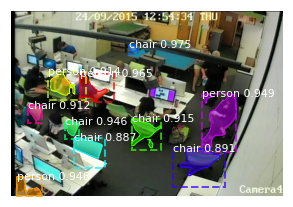

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


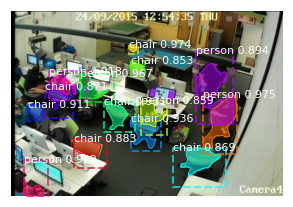

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


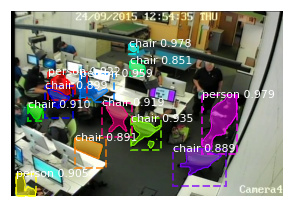

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


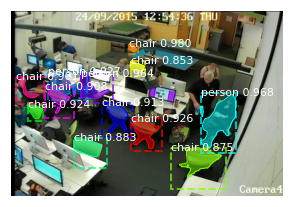

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


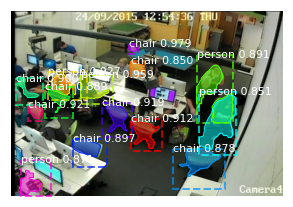

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


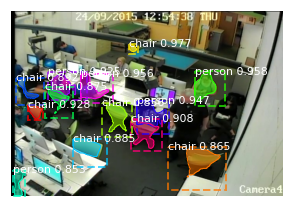

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


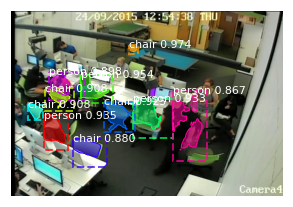

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


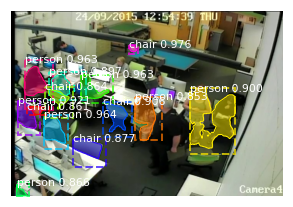

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


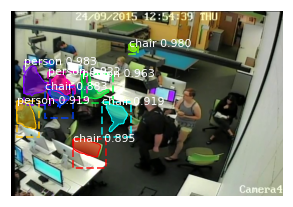

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


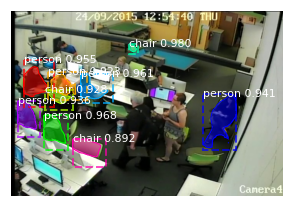

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


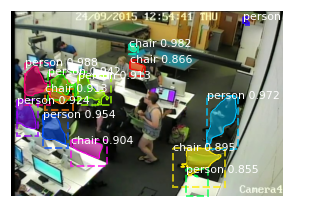

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


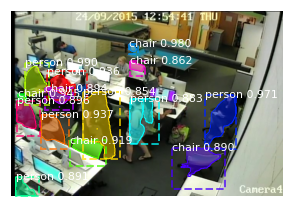

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


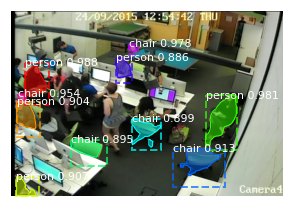

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


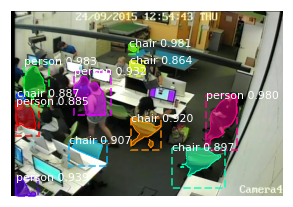

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


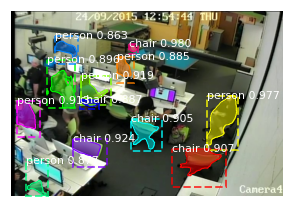

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


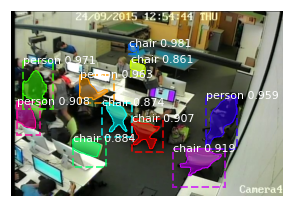

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


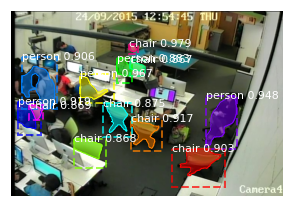

Processing 1 images
image                    shape: (480, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  704.00000  float64
anchors                  shape: (1, 123783, 4)        min:   -0.25750  max:    1.16646  float32


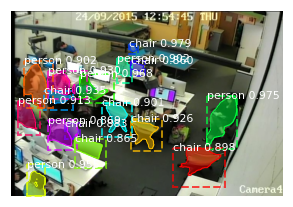

In [43]:
import skimage
real_test_dir = '../classroom_data/datasets/video2/real_test/' #change this location of test_dir
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))